# Detecting the Higgs Boson with TPUs 
This notebook demonstrates an improved approach to classifying Higgs boson events using modern Keras practices, feature normalization, and enhanced training stability.

## Key Improvements:
- **Modern Wide & Deep Architecture**: Built with Keras Functional API instead of deprecated experimental components
- **Input Normalization**: Integrated normalization layer for better training stability
- **Enhanced Callbacks**: Improved early stopping, learning rate scheduling, and model checkpointing
- **Regularization**: Added L2 regularization to prevent overfitting
- **Better Monitoring**: Focus on AUC metrics for classification performance

## Dataset:
The Higgs boson dataset contains 11 million particle collision events from the Large Hadron Collider (LHC). Each event is characterized by 28 kinematic features, and the goal is to classify whether the event represents a Higgs boson decay or background noise.

## Physics Context:
The Higgs boson is a fundamental particle that gives mass to other particles through the Higgs mechanism. Detecting it requires sophisticated machine learning techniques to distinguish its decay signature from the overwhelming background of other particle interactions.

In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/294.9 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 286.7/294.9 kB 8.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 286.7/294.9 kB 8.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Output directory configuration
import os

# All output files will be saved to this directory
OUTPUT_DIR = '/kaggle/working/'

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

Output directory: /kaggle/working/


## 1. Initial Setup and Configuration

In [3]:
# Model and training hyperparameters
UNITS = 2 ** 11  # 2048 units per dense layer
ACTIVATION = 'relu'
DROPOUT = 0.1
BATCH_SIZE_PER_REPLICA = 2 ** 11  # 2048 samples per replica

print(f"Model Configuration:")
print(f"  Units per layer: {UNITS}")
print(f"  Activation: {ACTIVATION}")
print(f"  Dropout rate: {DROPOUT}")
print(f"  Batch size per replica: {BATCH_SIZE_PER_REPLICA}")

Model Configuration:
  Units per layer: 2048
  Activation: relu
  Dropout rate: 0.1
  Batch size per replica: 2048


In [4]:
# TensorFlow
import tensorflow as tf
print("TensorFlow version: " + tf.__version__)
AUTO = tf.data.AUTOTUNE

# NOTE: TPU initialization is REMOVED from this cell.
# It will be done in a later cell, right before model building.

# Environment setup
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns


E0000 00:00:1761823811.113826      14 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:501


TensorFlow version: 2.15.0


## 2. Data Pipeline and Normalization

In [5]:
# TFRecord parsing utilities
def make_decoder():
    """Create a function to parse TFRecord examples"""
    def decoder(serialized_example):
        # Define the feature description for parsing
        feature_description = {
            'features': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.float32),
        }
        
        # Parse the example
        example = tf.io.parse_single_example(serialized_example, feature_description)
        
        # Decode the serialized tensor
        features = tf.io.parse_tensor(example['features'], out_type=tf.float32)
        features = tf.reshape(features, [28])
        
        label = example['label']
        
        return features, label
    
    return decoder

def load_dataset(filenames, decoder, ordered=False):
    """Load and preprocess TFRecord dataset"""
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(decoder, num_parallel_calls=AUTO)
    
    return dataset

print("✓ TFRecord parsing utilities defined")

✓ TFRecord parsing utilities defined


In [6]:
try:
    # Get the GCS path for the dataset
    from kaggle_datasets import KaggleDatasets
    GCS_PATH = KaggleDatasets().get_gcs_path('higgs-boson')
except (NameError, ImportError):
    # If we're not on Kaggle, use a public GCS bucket
    GCS_PATH = "gs://kds-264b93057042d4b33350b16232436560289380e65a6d21009e3334e2"

# Define file paths for training and validation
# IMPORTANT: Use tf.io.gfile.glob to find the files
train_paths = tf.io.gfile.glob(GCS_PATH + '/training/*.tfrecord')
valid_paths = tf.io.gfile.glob(GCS_PATH + '/validation/*.tfrecord')

# FAIL-FAST CHECK:
# Immediately verify that the file paths were found. If not, the dataset is
# not attached correctly or the path is wrong. This prevents the cryptic
# "Iterator.get_next()" error later on.
if not train_paths:
    raise ValueError(f"No training files found with pattern: {GCS_PATH}/training/training_*.tfrecord. Please ensure the 'higgs-boson' dataset is correctly attached in your Kaggle notebook environment and the path is correct.")
if not valid_paths:
    raise ValueError(f"No validation files found with pattern: {GCS_PATH}/validation/validation_*.tfrecord. Please ensure the 'higgs-boson' dataset is correctly attached in your Kaggle notebook environment and the path is correct.")

print(f"Found {len(train_paths)} training files.")
print(f"Found {len(valid_paths)} validation files.")
 

Found 24 training files.
Found 8 validation files.


get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/higgs-boson


## 3. Build the Modern Wide & Deep Model

In [7]:
# Define dense block with regularization support
def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    """Create a dense block with batch normalization, activation, and dropout"""
    def make(inputs):
        # Configure regularization
        regularizer = None
        if l1 and l2:
            regularizer = keras.regularizers.L1L2(l1=l1, l2=l2)
        elif l1:
            regularizer = keras.regularizers.L1(l1)
        elif l2:
            regularizer = keras.regularizers.L2(l2)
        
        # Build the block
        x = layers.Dense(units, kernel_regularizer=regularizer)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x
    
    return make

print("✓ Dense block function defined")

✓ Dense block function defined


In [8]:
# --- STAGE 1: CPU-ONLY NORMALIZATION ---
# Dataset configuration
TRAIN_SIZE = int(11e6)
VALID_SIZE = int(5e5)

# Create a temporary dataset for normalization BEFORE initializing the TPU
print("Creating temporary dataset for normalization...")
temp_decoder = make_decoder()
temp_ds = load_dataset(train_paths, temp_decoder, ordered=True)

# Take a representative sample for adapting (about 200k samples)
print("Preparing feature sample...")
feature_ds = temp_ds.map(lambda x, y: x, num_parallel_calls=AUTO).batch(BATCH_SIZE_PER_REPLICA).take(100)
print("✓ Feature sample prepared.")

# Adapt the normalization layer on the CPU
print("\nAdapting normalization layer on CPU...")
normalizer = layers.Normalization()
normalizer.adapt(feature_ds)
print("✓ Normalization layer adapted.")
print("\n⚠️ IMPORTANT: Do NOT re-run this cell after running the next cell (TPU initialization).")
print("   If you need to restart, use 'Restart Kernel' to clear all state first.")


Creating temporary dataset for normalization...


Preparing feature sample...
✓ Feature sample prepared.

Adapting normalization layer on CPU...


2025-10-30 11:30:30.984007: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:30.984102: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:30.984185: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:30.984246: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:30.984306: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:30.984449: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:30.984535: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

✓ Normalization layer adapted.

⚠️ IMPORTANT: Do NOT re-run this cell after running the next cell (TPU initialization).
   If you need to restart, use 'Restart Kernel' to clear all state first.


In [9]:
# --- STAGE 2: TPU INITIALIZATION, DATASET, AND MODEL BUILD ---
print("Initializing TPU Strategy...")

# Detect and initialize the TPU now that all CPU work is done
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("✓ TPU detected and initialized")
except (ValueError, ImportError, tf.errors.NotFoundError):
    print("TPU not found, falling back to default strategy (GPU/CPU)")
    strategy = tf.distribute.get_strategy()

print(f"Strategy: {type(strategy).__name__}")
print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

# Calculate global batch size and steps
batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
steps_per_epoch = TRAIN_SIZE // batch_size
validation_steps = VALID_SIZE // batch_size

print(f"\nDataset Configuration:")
print(f"  Global batch size: {batch_size:,}")
print(f"  Steps per epoch: {steps_per_epoch:,}")
print(f"  Validation steps: {validation_steps:,}")

# Create final datasets for training
print("\nCreating final datasets for TPU...")
final_decoder = make_decoder()

ds_train = load_dataset(train_paths, final_decoder, ordered=False)
ds_train = (
    ds_train
    .cache()
    .shuffle(8 * batch_size, seed=42)
    .repeat()
    .batch(batch_size, drop_remainder=True)
    .prefetch(AUTO)
)

ds_valid = load_dataset(valid_paths, final_decoder, ordered=True)
ds_valid = (
    ds_valid
    .batch(batch_size, drop_remainder=True)
    .cache()
    .prefetch(AUTO)
)
print("✓ Final training and validation datasets created.")

# Build the Wide & Deep model within strategy scope
print("\nBuilding Wide & Deep model within strategy scope...")
with strategy.scope():
    # Input layer
    inputs = keras.Input(shape=[28], name='input_features')
    
    # Apply the PRE-ADAPTED normalization layer
    norm_inputs = normalizer(inputs)
    
    # Wide branch
    wide = layers.Dense(1, name='wide_output')(norm_inputs)
    
    # Deep branch: Stack of dense blocks with L2 regularization
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(norm_inputs)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    x = dense_block(UNITS, ACTIVATION, DROPOUT, l2=1e-5)(x)
    deep = layers.Dense(1, name='deep_output')(x)
    
    # Combine wide and deep branches
    merged = layers.Add(name='wide_deep_add')([wide, deep])
    outputs = layers.Activation('sigmoid', name='prediction')(merged)
    
    # Create the complete model
    wide_and_deep = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='wide_and_deep_higgs_classifier'
    )
    
    # Compile the model
    wide_and_deep.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['AUC', 'binary_accuracy'],
    )

print("✓ Wide & Deep model created and compiled")
print(f"Total parameters: {wide_and_deep.count_params():,}")
wide_and_deep.summary()


Initializing TPU Strategy...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


✓ TPU detected and initialized
Strategy: TPUStrategyV2
Number of accelerators: 8

Dataset Configuration:
  Global batch size: 16,384
  Steps per epoch: 671
  Validation steps: 30

Creating final datasets for TPU...
✓ Final training and validation datasets created.

Building Wide & Deep model within strategy scope...


I0000 00:00:1761823847.255036      14 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✓ Wide & Deep model created and compiled
Total parameters: 16,887,895


Model: "wide_and_deep_higgs_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 28)        │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ normalization       │ (None, 28)        │      57 │ input_features[0][0] │
│ (Normalization)     │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 2048)      │  59,392 │ normalization[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 2048)      │   8,192 │ dense[0][0]          │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │       0 │ activation[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_1[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_1        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │       0 │ activation_1[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_2[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_2        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │       0 │ activation_2[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_2[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_3[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_3        │ (None, 2048)      │       0 │ batch_normalization… │
│ (Activation)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_3 (Dropout) │ (None, 2048)      │       0 │ activation_3[0][0]   │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │ 4,196,… │ dropout_3[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 2048)      │   8,192 │ dense_4[0][0]      

 Total params: 16,887,895 (64.42 MB)

 Trainable params: 16,867,358 (64.34 MB)

 Non-trainable params: 20,537 (80.23 KB)

## 4. Configure Improved Callbacks

In [10]:
# Configure enhanced callbacks for better training control

# Early stopping based on validation AUC
early_stopping = callbacks.EarlyStopping(
    monitor='val_AUC',           # Monitor 'val_AUC' to match the compiled metric
    patience=5,                  # More patience for better stability
    min_delta=0.0001,            # Smaller minimum improvement threshold
    mode='max',                  # AUC should be maximized
    restore_best_weights=True,   # Restore best weights at the end
    verbose=1
)

# Learning rate reduction on plateau
lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss
    patience=2,                  # More conservative than patience=0
    factor=0.5,                  # Less aggressive reduction
    min_lr=1e-7,                 # Minimum learning rate
    verbose=1
)

# Model checkpoint to save the best model
model_checkpoint = callbacks.ModelCheckpoint(
    'best_higgs_model.keras',    # Save as .keras format (recommended)
    monitor='val_AUC',           # Monitor 'val_AUC' to match the compiled metric
    mode='max',                  # Maximize AUC
    save_best_only=True,         # Only save when improvement is made
    save_weights_only=False,     # Save the entire model
    verbose=1
)

# Combine all callbacks
callback_list = [
    early_stopping,
    lr_schedule,
    model_checkpoint
]

print("Enhanced callbacks configured:")
print(f"  Early stopping: monitor val_AUC, patience={early_stopping.patience}")
print(f"  LR reduction: factor={lr_schedule.factor}, patience={lr_schedule.patience}")
print(f"  Model checkpoint: saving best model based on val_AUC")
print(f"  Learning rate will be automatically tracked by ReduceLROnPlateau")


Enhanced callbacks configured:
  Early stopping: monitor val_AUC, patience=5
  LR reduction: factor=0.5, patience=2
  Model checkpoint: saving best model based on val_AUC
  Learning rate will be automatically tracked by ReduceLROnPlateau


## 5. Train the Model

In [11]:
# Train the Wide & Deep model
print("Starting model training...")
print(f"Training for up to 50 epochs with early stopping")
print(f"Global batch size: {batch_size:,}")
print(f"Steps per epoch: {steps_per_epoch:,}")
print("\n" + "="*50)

# Wrap fit() in strategy scope as suggested
with strategy.scope():
    history = wide_and_deep.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=50,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,  
        callbacks=callback_list,
        verbose=1
    )

print("\n" + "="*50)
print("✓ Training completed!")


Starting model training...
Training for up to 50 epochs with early stopping
Global batch size: 16,384
Steps per epoch: 671

Epoch 1/50


2025-10-30 11:30:47.912500: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:47.930067: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:47.947108: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:47.965307: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:47.993231: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:48.010759: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:48.029178: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

2025-10-30 11:30:54.627799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


  1/671 ━━━━━━━━━━━━━━━━━━━━ 2:15:24 12s/step - AUC: 3.7287 - binary_accuracy: 3.7705 - loss: 8.7685

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 4.0229 - binary_accuracy: 3.9832 - loss: 13.9593  

  6/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 4.0797 - binary_accuracy: 4.0416 - loss: 14.2020

2025-10-30 11:30:59.822794: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:59.822878: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:59.822973: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:59.823063: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:59.823161: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:59.823247: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2025-10-30 11:30:59.823358: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

  7/671 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - AUC: 4.1056 - binary_accuracy: 4.0649 - loss: 14.0943

2025-10-30 11:31:00.273104: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


  8/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 102ms/step - AUC: 4.1257 - binary_accuracy: 4.0833 - loss: 13.9270

2025-10-30 11:31:00.560716: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


  9/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 134ms/step - AUC: 4.1428 - binary_accuracy: 4.1004 - loss: 13.7256

2025-10-30 11:31:00.914904: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


 10/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 160ms/step - AUC: 4.1607 - binary_accuracy: 4.1188 - loss: 13.5085

 11/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 177ms/step - AUC: 4.1809 - binary_accuracy: 4.1391 - loss: 13.2865

 12/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 192ms/step - AUC: 4.2025 - binary_accuracy: 4.1603 - loss: 13.0676

 13/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 207ms/step - AUC: 4.2252 - binary_accuracy: 4.1820 - loss: 12.8552

 14/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 219ms/step - AUC: 4.2484 - binary_accuracy: 4.2039 - loss: 12.6514

 15/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 230ms/step - AUC: 4.2714 - binary_accuracy: 4.2253 - loss: 12.4569

 16/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 239ms/step - AUC: 4.2940 - binary_accuracy: 4.2463 - loss: 12.2717

 17/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 248ms/step - AUC: 4.3159 - binary_accuracy: 4.2664 - loss: 12.0957

 18/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 256ms/step - AUC: 4.3373 - binary_accuracy: 4.2859 - loss: 11.9288

 19/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 262ms/step - AUC: 4.3581 - binary_accuracy: 4.3047 - loss: 11.7705

 20/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 267ms/step - AUC: 4.3783 - binary_accuracy: 4.3227 - loss: 11.6203

 21/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 272ms/step - AUC: 4.3981 - binary_accuracy: 4.3402 - loss: 11.4777

 22/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 277ms/step - AUC: 4.4173 - binary_accuracy: 4.3570 - loss: 11.3423

 23/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 280ms/step - AUC: 4.4360 - binary_accuracy: 4.3732 - loss: 11.2134

 24/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 283ms/step - AUC: 4.4544 - binary_accuracy: 4.3889 - loss: 11.0908

 25/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 286ms/step - AUC: 4.4724 - binary_accuracy: 4.4040 - loss: 10.9741

 26/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 290ms/step - AUC: 4.4900 - binary_accuracy: 4.4186 - loss: 10.8627

 27/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 293ms/step - AUC: 4.5072 - binary_accuracy: 4.4329 - loss: 10.7564

 28/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 295ms/step - AUC: 4.5239 - binary_accuracy: 4.4466 - loss: 10.6547

 29/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 298ms/step - AUC: 4.5403 - binary_accuracy: 4.4600 - loss: 10.5575

 30/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 299ms/step - AUC: 4.5563 - binary_accuracy: 4.4729 - loss: 10.4643

 31/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 300ms/step - AUC: 4.5718 - binary_accuracy: 4.4855 - loss: 10.3750

 32/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 301ms/step - AUC: 4.5870 - binary_accuracy: 4.4976 - loss: 10.2893

 33/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 302ms/step - AUC: 4.6018 - binary_accuracy: 4.5094 - loss: 10.2070

 34/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 304ms/step - AUC: 4.6162 - binary_accuracy: 4.5208 - loss: 10.1279

 35/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 306ms/step - AUC: 4.6302 - binary_accuracy: 4.5319 - loss: 10.0518

 36/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 308ms/step - AUC: 4.6439 - binary_accuracy: 4.5427 - loss: 9.9786 

 37/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 309ms/step - AUC: 4.6573 - binary_accuracy: 4.5532 - loss: 9.9080

 38/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 310ms/step - AUC: 4.6704 - binary_accuracy: 4.5634 - loss: 9.8399

 39/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 312ms/step - AUC: 4.6832 - binary_accuracy: 4.5733 - loss: 9.7742

 40/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 313ms/step - AUC: 4.6958 - binary_accuracy: 4.5830 - loss: 9.7107

 41/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 314ms/step - AUC: 4.7080 - binary_accuracy: 4.5924 - loss: 9.6494

 42/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 316ms/step - AUC: 4.7200 - binary_accuracy: 4.6016 - loss: 9.5901

 43/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 317ms/step - AUC: 4.7317 - binary_accuracy: 4.6105 - loss: 9.5328

 44/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 318ms/step - AUC: 4.7431 - binary_accuracy: 4.6192 - loss: 9.4773

 45/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 319ms/step - AUC: 4.7542 - binary_accuracy: 4.6276 - loss: 9.4236

 46/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 319ms/step - AUC: 4.7652 - binary_accuracy: 4.6359 - loss: 9.3715

 47/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 320ms/step - AUC: 4.7759 - binary_accuracy: 4.6440 - loss: 9.3209

 48/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 321ms/step - AUC: 4.7863 - binary_accuracy: 4.6518 - loss: 9.2719

 49/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 322ms/step - AUC: 4.7966 - binary_accuracy: 4.6596 - loss: 9.2243

 50/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 322ms/step - AUC: 4.8067 - binary_accuracy: 4.6671 - loss: 9.1781

 51/671 ━━━━━━━━━━━━━━━━━━━━ 3:20 323ms/step - AUC: 4.8166 - binary_accuracy: 4.6745 - loss: 9.1331

 52/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 323ms/step - AUC: 4.8263 - binary_accuracy: 4.6817 - loss: 9.0894

 53/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 323ms/step - AUC: 4.8358 - binary_accuracy: 4.6888 - loss: 9.0469

 54/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 324ms/step - AUC: 4.8452 - binary_accuracy: 4.6957 - loss: 9.0055

 55/671 ━━━━━━━━━━━━━━━━━━━━ 3:19 324ms/step - AUC: 4.8544 - binary_accuracy: 4.7025 - loss: 8.9652

 56/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 324ms/step - AUC: 4.8634 - binary_accuracy: 4.7091 - loss: 8.9260

 57/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 323ms/step - AUC: 4.8722 - binary_accuracy: 4.7156 - loss: 8.8878

 58/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 324ms/step - AUC: 4.8809 - binary_accuracy: 4.7220 - loss: 8.8506

 59/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 325ms/step - AUC: 4.8894 - binary_accuracy: 4.7282 - loss: 8.8143

 60/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 325ms/step - AUC: 4.8978 - binary_accuracy: 4.7344 - loss: 8.7789

 61/671 ━━━━━━━━━━━━━━━━━━━━ 3:18 325ms/step - AUC: 4.9061 - binary_accuracy: 4.7404 - loss: 8.7443

 62/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 325ms/step - AUC: 4.9142 - binary_accuracy: 4.7463 - loss: 8.7105

 63/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 325ms/step - AUC: 4.9221 - binary_accuracy: 4.7521 - loss: 8.6775

 64/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 325ms/step - AUC: 4.9300 - binary_accuracy: 4.7578 - loss: 8.6453

 65/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 326ms/step - AUC: 4.9377 - binary_accuracy: 4.7634 - loss: 8.6138

 66/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 326ms/step - AUC: 4.9453 - binary_accuracy: 4.7689 - loss: 8.5830

 67/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 327ms/step - AUC: 4.9528 - binary_accuracy: 4.7744 - loss: 8.5529

 68/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 328ms/step - AUC: 4.9601 - binary_accuracy: 4.7797 - loss: 8.5235

 69/671 ━━━━━━━━━━━━━━━━━━━━ 3:17 328ms/step - AUC: 4.9673 - binary_accuracy: 4.7849 - loss: 8.4947

 70/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 328ms/step - AUC: 4.9744 - binary_accuracy: 4.7900 - loss: 8.4665

 71/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 328ms/step - AUC: 4.9814 - binary_accuracy: 4.7950 - loss: 8.4389

 72/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 328ms/step - AUC: 4.9883 - binary_accuracy: 4.8000 - loss: 8.4119

 73/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 329ms/step - AUC: 4.9951 - binary_accuracy: 4.8048 - loss: 8.3855

 74/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 329ms/step - AUC: 5.0018 - binary_accuracy: 4.8096 - loss: 8.3596

 75/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 330ms/step - AUC: 5.0083 - binary_accuracy: 4.8143 - loss: 8.3342

 76/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 330ms/step - AUC: 5.0148 - binary_accuracy: 4.8189 - loss: 8.3093

 77/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 331ms/step - AUC: 5.0212 - binary_accuracy: 4.8235 - loss: 8.2849

 78/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 332ms/step - AUC: 5.0275 - binary_accuracy: 4.8280 - loss: 8.2610

 79/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 332ms/step - AUC: 5.0337 - binary_accuracy: 4.8324 - loss: 8.2375

 80/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 332ms/step - AUC: 5.0398 - binary_accuracy: 4.8368 - loss: 8.2145

 81/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 333ms/step - AUC: 5.0458 - binary_accuracy: 4.8411 - loss: 8.1919

 82/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 333ms/step - AUC: 5.0518 - binary_accuracy: 4.8453 - loss: 8.1698

 83/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 333ms/step - AUC: 5.0576 - binary_accuracy: 4.8495 - loss: 8.1480

 84/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 334ms/step - AUC: 5.0634 - binary_accuracy: 4.8536 - loss: 8.1266

 85/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 334ms/step - AUC: 5.0692 - binary_accuracy: 4.8576 - loss: 8.1056

 86/671 ━━━━━━━━━━━━━━━━━━━━ 3:16 335ms/step - AUC: 5.0748 - binary_accuracy: 4.8616 - loss: 8.0850

 87/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 335ms/step - AUC: 5.0804 - binary_accuracy: 4.8656 - loss: 8.0647

 88/671 ━━━━━━━━━━━━━━━━━━━━ 3:15 335ms/step - AUC: 5.0859 - binary_accuracy: 4.8695 - loss: 8.0448

 89/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 335ms/step - AUC: 5.0913 - binary_accuracy: 4.8733 - loss: 8.0252

 90/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 335ms/step - AUC: 5.0967 - binary_accuracy: 4.8771 - loss: 8.0060

 91/671 ━━━━━━━━━━━━━━━━━━━━ 3:14 335ms/step - AUC: 5.1020 - binary_accuracy: 4.8809 - loss: 7.9870

 92/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 334ms/step - AUC: 5.1072 - binary_accuracy: 4.8846 - loss: 7.9684

 93/671 ━━━━━━━━━━━━━━━━━━━━ 3:13 334ms/step - AUC: 5.1124 - binary_accuracy: 4.8882 - loss: 7.9501

 94/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 334ms/step - AUC: 5.1175 - binary_accuracy: 4.8918 - loss: 7.9321

 95/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 334ms/step - AUC: 5.1225 - binary_accuracy: 4.8954 - loss: 7.9143

 96/671 ━━━━━━━━━━━━━━━━━━━━ 3:12 334ms/step - AUC: 5.1275 - binary_accuracy: 4.8989 - loss: 7.8969

 97/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 334ms/step - AUC: 5.1324 - binary_accuracy: 4.9023 - loss: 7.8797

 98/671 ━━━━━━━━━━━━━━━━━━━━ 3:11 334ms/step - AUC: 5.1373 - binary_accuracy: 4.9058 - loss: 7.8628

 99/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 334ms/step - AUC: 5.1421 - binary_accuracy: 4.9092 - loss: 7.8461

100/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 334ms/step - AUC: 5.1469 - binary_accuracy: 4.9125 - loss: 7.8297

101/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 334ms/step - AUC: 5.1516 - binary_accuracy: 4.9158 - loss: 7.8136

102/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 334ms/step - AUC: 5.1562 - binary_accuracy: 4.9191 - loss: 7.7977

103/671 ━━━━━━━━━━━━━━━━━━━━ 3:10 335ms/step - AUC: 5.1608 - binary_accuracy: 4.9223 - loss: 7.7820

104/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 334ms/step - AUC: 5.1654 - binary_accuracy: 4.9255 - loss: 7.7665

105/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 334ms/step - AUC: 5.1699 - binary_accuracy: 4.9286 - loss: 7.7513

106/671 ━━━━━━━━━━━━━━━━━━━━ 3:09 335ms/step - AUC: 5.1743 - binary_accuracy: 4.9317 - loss: 7.7363

107/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 335ms/step - AUC: 5.1787 - binary_accuracy: 4.9348 - loss: 7.7216

108/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 335ms/step - AUC: 5.1831 - binary_accuracy: 4.9378 - loss: 7.7070

109/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 335ms/step - AUC: 5.1874 - binary_accuracy: 4.9408 - loss: 7.6926

110/671 ━━━━━━━━━━━━━━━━━━━━ 3:08 335ms/step - AUC: 5.1916 - binary_accuracy: 4.9438 - loss: 7.6785

111/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 335ms/step - AUC: 5.1958 - binary_accuracy: 4.9467 - loss: 7.6645

112/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 336ms/step - AUC: 5.2000 - binary_accuracy: 4.9496 - loss: 7.6507

113/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 336ms/step - AUC: 5.2041 - binary_accuracy: 4.9525 - loss: 7.6371

114/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 336ms/step - AUC: 5.2082 - binary_accuracy: 4.9553 - loss: 7.6237

115/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 337ms/step - AUC: 5.2122 - binary_accuracy: 4.9581 - loss: 7.6105

116/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 337ms/step - AUC: 5.2162 - binary_accuracy: 4.9609 - loss: 7.5975

117/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 338ms/step - AUC: 5.2201 - binary_accuracy: 4.9636 - loss: 7.5846

118/671 ━━━━━━━━━━━━━━━━━━━━ 3:07 338ms/step - AUC: 5.2240 - binary_accuracy: 4.9663 - loss: 7.5719

119/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 339ms/step - AUC: 5.2279 - binary_accuracy: 4.9690 - loss: 7.5593

120/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 339ms/step - AUC: 5.2318 - binary_accuracy: 4.9717 - loss: 7.5469

121/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 340ms/step - AUC: 5.2356 - binary_accuracy: 4.9743 - loss: 7.5347

122/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 340ms/step - AUC: 5.2393 - binary_accuracy: 4.9769 - loss: 7.5226

123/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 340ms/step - AUC: 5.2430 - binary_accuracy: 4.9795 - loss: 7.5107

124/671 ━━━━━━━━━━━━━━━━━━━━ 3:06 340ms/step - AUC: 5.2467 - binary_accuracy: 4.9820 - loss: 7.4990

125/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 340ms/step - AUC: 5.2504 - binary_accuracy: 4.9845 - loss: 7.4873

126/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 341ms/step - AUC: 5.2540 - binary_accuracy: 4.9870 - loss: 7.4759

127/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 341ms/step - AUC: 5.2575 - binary_accuracy: 4.9895 - loss: 7.4645

128/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 341ms/step - AUC: 5.2611 - binary_accuracy: 4.9919 - loss: 7.4533

129/671 ━━━━━━━━━━━━━━━━━━━━ 3:05 341ms/step - AUC: 5.2646 - binary_accuracy: 4.9944 - loss: 7.4422

130/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 341ms/step - AUC: 5.2681 - binary_accuracy: 4.9968 - loss: 7.4313

131/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 342ms/step - AUC: 5.2715 - binary_accuracy: 4.9991 - loss: 7.4205

132/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 342ms/step - AUC: 5.2749 - binary_accuracy: 5.0015 - loss: 7.4098

133/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 343ms/step - AUC: 5.2783 - binary_accuracy: 5.0038 - loss: 7.3993

134/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 343ms/step - AUC: 5.2817 - binary_accuracy: 5.0061 - loss: 7.3888

135/671 ━━━━━━━━━━━━━━━━━━━━ 3:04 343ms/step - AUC: 5.2850 - binary_accuracy: 5.0084 - loss: 7.3785

136/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 344ms/step - AUC: 5.2883 - binary_accuracy: 5.0107 - loss: 7.3683

137/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 344ms/step - AUC: 5.2916 - binary_accuracy: 5.0130 - loss: 7.3582

138/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 344ms/step - AUC: 5.2948 - binary_accuracy: 5.0152 - loss: 7.3482

139/671 ━━━━━━━━━━━━━━━━━━━━ 3:03 344ms/step - AUC: 5.2980 - binary_accuracy: 5.0174 - loss: 7.3384

140/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 344ms/step - AUC: 5.3012 - binary_accuracy: 5.0196 - loss: 7.3286

141/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 345ms/step - AUC: 5.3044 - binary_accuracy: 5.0218 - loss: 7.3190

142/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 345ms/step - AUC: 5.3075 - binary_accuracy: 5.0240 - loss: 7.3094

143/671 ━━━━━━━━━━━━━━━━━━━━ 3:02 345ms/step - AUC: 5.3107 - binary_accuracy: 5.0261 - loss: 7.3000

144/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 345ms/step - AUC: 5.3137 - binary_accuracy: 5.0282 - loss: 7.2906

145/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 345ms/step - AUC: 5.3168 - binary_accuracy: 5.0303 - loss: 7.2814

146/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 346ms/step - AUC: 5.3198 - binary_accuracy: 5.0324 - loss: 7.2722

147/671 ━━━━━━━━━━━━━━━━━━━━ 3:01 346ms/step - AUC: 5.3229 - binary_accuracy: 5.0345 - loss: 7.2632

148/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 346ms/step - AUC: 5.3258 - binary_accuracy: 5.0365 - loss: 7.2542

149/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 346ms/step - AUC: 5.3288 - binary_accuracy: 5.0386 - loss: 7.2454

150/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 346ms/step - AUC: 5.3318 - binary_accuracy: 5.0406 - loss: 7.2366

151/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 347ms/step - AUC: 5.3347 - binary_accuracy: 5.0426 - loss: 7.2279

152/671 ━━━━━━━━━━━━━━━━━━━━ 3:00 347ms/step - AUC: 5.3376 - binary_accuracy: 5.0446 - loss: 7.2193

153/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 347ms/step - AUC: 5.3404 - binary_accuracy: 5.0466 - loss: 7.2108

154/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 348ms/step - AUC: 5.3433 - binary_accuracy: 5.0485 - loss: 7.2024

155/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 348ms/step - AUC: 5.3461 - binary_accuracy: 5.0505 - loss: 7.1940

156/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 348ms/step - AUC: 5.3489 - binary_accuracy: 5.0524 - loss: 7.1857

157/671 ━━━━━━━━━━━━━━━━━━━━ 2:59 348ms/step - AUC: 5.3517 - binary_accuracy: 5.0543 - loss: 7.1776

158/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 349ms/step - AUC: 5.3545 - binary_accuracy: 5.0562 - loss: 7.1695

159/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 349ms/step - AUC: 5.3572 - binary_accuracy: 5.0581 - loss: 7.1614

160/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 349ms/step - AUC: 5.3600 - binary_accuracy: 5.0600 - loss: 7.1535

161/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 350ms/step - AUC: 5.3627 - binary_accuracy: 5.0618 - loss: 7.1456

162/671 ━━━━━━━━━━━━━━━━━━━━ 2:58 350ms/step - AUC: 5.3654 - binary_accuracy: 5.0637 - loss: 7.1378

163/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 350ms/step - AUC: 5.3680 - binary_accuracy: 5.0655 - loss: 7.1301

164/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 351ms/step - AUC: 5.3707 - binary_accuracy: 5.0673 - loss: 7.1224

165/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 351ms/step - AUC: 5.3733 - binary_accuracy: 5.0691 - loss: 7.1148

166/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 351ms/step - AUC: 5.3760 - binary_accuracy: 5.0709 - loss: 7.1073

167/671 ━━━━━━━━━━━━━━━━━━━━ 2:57 351ms/step - AUC: 5.3786 - binary_accuracy: 5.0727 - loss: 7.0999

168/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 352ms/step - AUC: 5.3811 - binary_accuracy: 5.0745 - loss: 7.0925

169/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 352ms/step - AUC: 5.3837 - binary_accuracy: 5.0762 - loss: 7.0852

170/671 ━━━━━━━━━━━━━━━━━━━━ 2:56 352ms/step - AUC: 5.3862 - binary_accuracy: 5.0780 - loss: 7.0779

171/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 352ms/step - AUC: 5.3888 - binary_accuracy: 5.0797 - loss: 7.0707

172/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 352ms/step - AUC: 5.3913 - binary_accuracy: 5.0814 - loss: 7.0636

173/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 352ms/step - AUC: 5.3938 - binary_accuracy: 5.0831 - loss: 7.0566

174/671 ━━━━━━━━━━━━━━━━━━━━ 2:55 352ms/step - AUC: 5.3962 - binary_accuracy: 5.0848 - loss: 7.0496

175/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 353ms/step - AUC: 5.3987 - binary_accuracy: 5.0865 - loss: 7.0426

176/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 353ms/step - AUC: 5.4011 - binary_accuracy: 5.0882 - loss: 7.0358

177/671 ━━━━━━━━━━━━━━━━━━━━ 2:54 353ms/step - AUC: 5.4036 - binary_accuracy: 5.0898 - loss: 7.0290

178/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 353ms/step - AUC: 5.4060 - binary_accuracy: 5.0915 - loss: 7.0222

179/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 353ms/step - AUC: 5.4084 - binary_accuracy: 5.0931 - loss: 7.0155

180/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 353ms/step - AUC: 5.4107 - binary_accuracy: 5.0947 - loss: 7.0089

181/671 ━━━━━━━━━━━━━━━━━━━━ 2:53 353ms/step - AUC: 5.4131 - binary_accuracy: 5.0964 - loss: 7.0023

182/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 353ms/step - AUC: 5.4155 - binary_accuracy: 5.0980 - loss: 6.9958

183/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 353ms/step - AUC: 5.4178 - binary_accuracy: 5.0995 - loss: 6.9893

184/671 ━━━━━━━━━━━━━━━━━━━━ 2:52 353ms/step - AUC: 5.4201 - binary_accuracy: 5.1011 - loss: 6.9829

185/671 ━━━━━━━━━━━━━━━━━━━━ 2:51 353ms/step - AUC: 5.4224 - binary_accuracy: 5.1027 - loss: 6.9765

186/671 ━━━━━━━━━━━━━━━━━━━━ 2:51 353ms/step - AUC: 5.4247 - binary_accuracy: 5.1043 - loss: 6.9702

187/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 353ms/step - AUC: 5.4270 - binary_accuracy: 5.1058 - loss: 6.9639

188/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 353ms/step - AUC: 5.4292 - binary_accuracy: 5.1074 - loss: 6.9577

189/671 ━━━━━━━━━━━━━━━━━━━━ 2:50 353ms/step - AUC: 5.4315 - binary_accuracy: 5.1089 - loss: 6.9516

190/671 ━━━━━━━━━━━━━━━━━━━━ 2:49 353ms/step - AUC: 5.4337 - binary_accuracy: 5.1104 - loss: 6.9454

191/671 ━━━━━━━━━━━━━━━━━━━━ 2:49 353ms/step - AUC: 5.4359 - binary_accuracy: 5.1119 - loss: 6.9394

192/671 ━━━━━━━━━━━━━━━━━━━━ 2:48 353ms/step - AUC: 5.4382 - binary_accuracy: 5.1134 - loss: 6.9333

193/671 ━━━━━━━━━━━━━━━━━━━━ 2:48 353ms/step - AUC: 5.4404 - binary_accuracy: 5.1149 - loss: 6.9274

194/671 ━━━━━━━━━━━━━━━━━━━━ 2:48 353ms/step - AUC: 5.4425 - binary_accuracy: 5.1164 - loss: 6.9214

195/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 353ms/step - AUC: 5.4447 - binary_accuracy: 5.1179 - loss: 6.9156

196/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 353ms/step - AUC: 5.4469 - binary_accuracy: 5.1194 - loss: 6.9097

197/671 ━━━━━━━━━━━━━━━━━━━━ 2:47 353ms/step - AUC: 5.4490 - binary_accuracy: 5.1208 - loss: 6.9039

198/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 353ms/step - AUC: 5.4511 - binary_accuracy: 5.1223 - loss: 6.8982

199/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 353ms/step - AUC: 5.4533 - binary_accuracy: 5.1237 - loss: 6.8925

200/671 ━━━━━━━━━━━━━━━━━━━━ 2:46 353ms/step - AUC: 5.4554 - binary_accuracy: 5.1252 - loss: 6.8868

201/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 353ms/step - AUC: 5.4575 - binary_accuracy: 5.1266 - loss: 6.8812

202/671 ━━━━━━━━━━━━━━━━━━━━ 2:45 352ms/step - AUC: 5.4596 - binary_accuracy: 5.1280 - loss: 6.8756

203/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 352ms/step - AUC: 5.4616 - binary_accuracy: 5.1294 - loss: 6.8701

204/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 352ms/step - AUC: 5.4637 - binary_accuracy: 5.1308 - loss: 6.8646

205/671 ━━━━━━━━━━━━━━━━━━━━ 2:44 352ms/step - AUC: 5.4657 - binary_accuracy: 5.1322 - loss: 6.8591

206/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 352ms/step - AUC: 5.4678 - binary_accuracy: 5.1336 - loss: 6.8537

207/671 ━━━━━━━━━━━━━━━━━━━━ 2:43 352ms/step - AUC: 5.4698 - binary_accuracy: 5.1350 - loss: 6.8483

208/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 352ms/step - AUC: 5.4718 - binary_accuracy: 5.1364 - loss: 6.8430

209/671 ━━━━━━━━━━━━━━━━━━━━ 2:42 351ms/step - AUC: 5.4738 - binary_accuracy: 5.1377 - loss: 6.8377

210/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 351ms/step - AUC: 5.4758 - binary_accuracy: 5.1391 - loss: 6.8324

211/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 351ms/step - AUC: 5.4778 - binary_accuracy: 5.1405 - loss: 6.8272

212/671 ━━━━━━━━━━━━━━━━━━━━ 2:41 351ms/step - AUC: 5.4798 - binary_accuracy: 5.1418 - loss: 6.8220

213/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 351ms/step - AUC: 5.4817 - binary_accuracy: 5.1431 - loss: 6.8169

214/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 351ms/step - AUC: 5.4837 - binary_accuracy: 5.1445 - loss: 6.8118

215/671 ━━━━━━━━━━━━━━━━━━━━ 2:40 351ms/step - AUC: 5.4856 - binary_accuracy: 5.1458 - loss: 6.8067

216/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 351ms/step - AUC: 5.4875 - binary_accuracy: 5.1471 - loss: 6.8017

217/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 351ms/step - AUC: 5.4894 - binary_accuracy: 5.1484 - loss: 6.7967

218/671 ━━━━━━━━━━━━━━━━━━━━ 2:39 351ms/step - AUC: 5.4913 - binary_accuracy: 5.1497 - loss: 6.7917

219/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 351ms/step - AUC: 5.4932 - binary_accuracy: 5.1510 - loss: 6.7868

220/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 351ms/step - AUC: 5.4951 - binary_accuracy: 5.1523 - loss: 6.7818

221/671 ━━━━━━━━━━━━━━━━━━━━ 2:38 351ms/step - AUC: 5.4970 - binary_accuracy: 5.1536 - loss: 6.7770

222/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 351ms/step - AUC: 5.4989 - binary_accuracy: 5.1548 - loss: 6.7721

223/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 352ms/step - AUC: 5.5007 - binary_accuracy: 5.1561 - loss: 6.7673

224/671 ━━━━━━━━━━━━━━━━━━━━ 2:37 352ms/step - AUC: 5.5026 - binary_accuracy: 5.1574 - loss: 6.7626

225/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 352ms/step - AUC: 5.5044 - binary_accuracy: 5.1586 - loss: 6.7578

226/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 352ms/step - AUC: 5.5063 - binary_accuracy: 5.1599 - loss: 6.7531

227/671 ━━━━━━━━━━━━━━━━━━━━ 2:36 352ms/step - AUC: 5.5081 - binary_accuracy: 5.1611 - loss: 6.7484

228/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 352ms/step - AUC: 5.5099 - binary_accuracy: 5.1623 - loss: 6.7438

229/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 352ms/step - AUC: 5.5117 - binary_accuracy: 5.1636 - loss: 6.7392

230/671 ━━━━━━━━━━━━━━━━━━━━ 2:35 352ms/step - AUC: 5.5135 - binary_accuracy: 5.1648 - loss: 6.7346

231/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 352ms/step - AUC: 5.5153 - binary_accuracy: 5.1660 - loss: 6.7300

232/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 352ms/step - AUC: 5.5170 - binary_accuracy: 5.1672 - loss: 6.7255

233/671 ━━━━━━━━━━━━━━━━━━━━ 2:34 352ms/step - AUC: 5.5188 - binary_accuracy: 5.1684 - loss: 6.7210

234/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 352ms/step - AUC: 5.5206 - binary_accuracy: 5.1696 - loss: 6.7165

235/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 352ms/step - AUC: 5.5223 - binary_accuracy: 5.1708 - loss: 6.7121

236/671 ━━━━━━━━━━━━━━━━━━━━ 2:33 352ms/step - AUC: 5.5240 - binary_accuracy: 5.1720 - loss: 6.7077

237/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 352ms/step - AUC: 5.5258 - binary_accuracy: 5.1732 - loss: 6.7033

238/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 352ms/step - AUC: 5.5275 - binary_accuracy: 5.1743 - loss: 6.6989

239/671 ━━━━━━━━━━━━━━━━━━━━ 2:32 353ms/step - AUC: 5.5292 - binary_accuracy: 5.1755 - loss: 6.6946

240/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 353ms/step - AUC: 5.5309 - binary_accuracy: 5.1767 - loss: 6.6903

241/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 353ms/step - AUC: 5.5326 - binary_accuracy: 5.1778 - loss: 6.6860

242/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 353ms/step - AUC: 5.5343 - binary_accuracy: 5.1790 - loss: 6.6818

243/671 ━━━━━━━━━━━━━━━━━━━━ 2:31 353ms/step - AUC: 5.5360 - binary_accuracy: 5.1801 - loss: 6.6775

244/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 353ms/step - AUC: 5.5376 - binary_accuracy: 5.1813 - loss: 6.6733

245/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 353ms/step - AUC: 5.5393 - binary_accuracy: 5.1824 - loss: 6.6692

246/671 ━━━━━━━━━━━━━━━━━━━━ 2:30 353ms/step - AUC: 5.5410 - binary_accuracy: 5.1835 - loss: 6.6650

247/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 353ms/step - AUC: 5.5426 - binary_accuracy: 5.1846 - loss: 6.6609

248/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 353ms/step - AUC: 5.5443 - binary_accuracy: 5.1858 - loss: 6.6568

249/671 ━━━━━━━━━━━━━━━━━━━━ 2:29 353ms/step - AUC: 5.5459 - binary_accuracy: 5.1869 - loss: 6.6527

250/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 353ms/step - AUC: 5.5475 - binary_accuracy: 5.1880 - loss: 6.6487

251/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 353ms/step - AUC: 5.5491 - binary_accuracy: 5.1891 - loss: 6.6446

252/671 ━━━━━━━━━━━━━━━━━━━━ 2:28 353ms/step - AUC: 5.5508 - binary_accuracy: 5.1902 - loss: 6.6406

253/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 353ms/step - AUC: 5.5524 - binary_accuracy: 5.1913 - loss: 6.6367

254/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 353ms/step - AUC: 5.5539 - binary_accuracy: 5.1924 - loss: 6.6327

255/671 ━━━━━━━━━━━━━━━━━━━━ 2:27 353ms/step - AUC: 5.5555 - binary_accuracy: 5.1935 - loss: 6.6288

256/671 ━━━━━━━━━━━━━━━━━━━━ 2:26 353ms/step - AUC: 5.5571 - binary_accuracy: 5.1945 - loss: 6.6249

257/671 ━━━━━━━━━━━━━━━━━━━━ 2:26 353ms/step - AUC: 5.5587 - binary_accuracy: 5.1956 - loss: 6.6210

258/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 353ms/step - AUC: 5.5603 - binary_accuracy: 5.1967 - loss: 6.6171

259/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 353ms/step - AUC: 5.5618 - binary_accuracy: 5.1977 - loss: 6.6133

260/671 ━━━━━━━━━━━━━━━━━━━━ 2:25 353ms/step - AUC: 5.5634 - binary_accuracy: 5.1988 - loss: 6.6095

261/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 353ms/step - AUC: 5.5649 - binary_accuracy: 5.1999 - loss: 6.6057

262/671 ━━━━━━━━━━━━━━━━━━━━ 2:24 353ms/step - AUC: 5.5665 - binary_accuracy: 5.2009 - loss: 6.6019

263/671 ━━━━━━━━━━━━━━━━━━━━ 2:23 353ms/step - AUC: 5.5680 - binary_accuracy: 5.2019 - loss: 6.5981

264/671 ━━━━━━━━━━━━━━━━━━━━ 2:23 352ms/step - AUC: 5.5695 - binary_accuracy: 5.2030 - loss: 6.5944

265/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 352ms/step - AUC: 5.5710 - binary_accuracy: 5.2040 - loss: 6.5907

266/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 352ms/step - AUC: 5.5726 - binary_accuracy: 5.2051 - loss: 6.5870

267/671 ━━━━━━━━━━━━━━━━━━━━ 2:22 352ms/step - AUC: 5.5741 - binary_accuracy: 5.2061 - loss: 6.5833

268/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 352ms/step - AUC: 5.5756 - binary_accuracy: 5.2071 - loss: 6.5797

269/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 352ms/step - AUC: 5.5771 - binary_accuracy: 5.2081 - loss: 6.5760

270/671 ━━━━━━━━━━━━━━━━━━━━ 2:21 352ms/step - AUC: 5.5785 - binary_accuracy: 5.2091 - loss: 6.5724

271/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 352ms/step - AUC: 5.5800 - binary_accuracy: 5.2101 - loss: 6.5688

272/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 352ms/step - AUC: 5.5815 - binary_accuracy: 5.2112 - loss: 6.5653

273/671 ━━━━━━━━━━━━━━━━━━━━ 2:20 352ms/step - AUC: 5.5830 - binary_accuracy: 5.2122 - loss: 6.5617

274/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 352ms/step - AUC: 5.5844 - binary_accuracy: 5.2132 - loss: 6.5582

275/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 352ms/step - AUC: 5.5859 - binary_accuracy: 5.2141 - loss: 6.5547

276/671 ━━━━━━━━━━━━━━━━━━━━ 2:19 352ms/step - AUC: 5.5873 - binary_accuracy: 5.2151 - loss: 6.5512

277/671 ━━━━━━━━━━━━━━━━━━━━ 2:18 352ms/step - AUC: 5.5888 - binary_accuracy: 5.2161 - loss: 6.5477

278/671 ━━━━━━━━━━━━━━━━━━━━ 2:18 352ms/step - AUC: 5.5902 - binary_accuracy: 5.2171 - loss: 6.5442

279/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 352ms/step - AUC: 5.5916 - binary_accuracy: 5.2181 - loss: 6.5408

280/671 ━━━━━━━━━━━━━━━━━━━━ 2:17 351ms/step - AUC: 5.5931 - binary_accuracy: 5.2190 - loss: 6.5374

281/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 351ms/step - AUC: 5.5945 - binary_accuracy: 5.2200 - loss: 6.5339

282/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 351ms/step - AUC: 5.5959 - binary_accuracy: 5.2210 - loss: 6.5306

283/671 ━━━━━━━━━━━━━━━━━━━━ 2:16 351ms/step - AUC: 5.5973 - binary_accuracy: 5.2219 - loss: 6.5272

284/671 ━━━━━━━━━━━━━━━━━━━━ 2:15 351ms/step - AUC: 5.5987 - binary_accuracy: 5.2229 - loss: 6.5238

285/671 ━━━━━━━━━━━━━━━━━━━━ 2:15 351ms/step - AUC: 5.6001 - binary_accuracy: 5.2238 - loss: 6.5205

286/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 350ms/step - AUC: 5.6015 - binary_accuracy: 5.2248 - loss: 6.5172

287/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 350ms/step - AUC: 5.6029 - binary_accuracy: 5.2257 - loss: 6.5139

288/671 ━━━━━━━━━━━━━━━━━━━━ 2:14 350ms/step - AUC: 5.6043 - binary_accuracy: 5.2267 - loss: 6.5106

289/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 350ms/step - AUC: 5.6056 - binary_accuracy: 5.2276 - loss: 6.5073

290/671 ━━━━━━━━━━━━━━━━━━━━ 2:13 350ms/step - AUC: 5.6070 - binary_accuracy: 5.2285 - loss: 6.5041

291/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 350ms/step - AUC: 5.6084 - binary_accuracy: 5.2295 - loss: 6.5008

292/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 350ms/step - AUC: 5.6097 - binary_accuracy: 5.2304 - loss: 6.4976

293/671 ━━━━━━━━━━━━━━━━━━━━ 2:12 350ms/step - AUC: 5.6111 - binary_accuracy: 5.2313 - loss: 6.4944

294/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 350ms/step - AUC: 5.6124 - binary_accuracy: 5.2322 - loss: 6.4912

295/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 350ms/step - AUC: 5.6138 - binary_accuracy: 5.2332 - loss: 6.4881

296/671 ━━━━━━━━━━━━━━━━━━━━ 2:11 350ms/step - AUC: 5.6151 - binary_accuracy: 5.2341 - loss: 6.4849

297/671 ━━━━━━━━━━━━━━━━━━━━ 2:10 350ms/step - AUC: 5.6164 - binary_accuracy: 5.2350 - loss: 6.4818

298/671 ━━━━━━━━━━━━━━━━━━━━ 2:10 350ms/step - AUC: 5.6178 - binary_accuracy: 5.2359 - loss: 6.4787

299/671 ━━━━━━━━━━━━━━━━━━━━ 2:09 349ms/step - AUC: 5.6191 - binary_accuracy: 5.2368 - loss: 6.4756

300/671 ━━━━━━━━━━━━━━━━━━━━ 2:09 349ms/step - AUC: 5.6204 - binary_accuracy: 5.2377 - loss: 6.4725

301/671 ━━━━━━━━━━━━━━━━━━━━ 2:09 349ms/step - AUC: 5.6217 - binary_accuracy: 5.2386 - loss: 6.4694

302/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 349ms/step - AUC: 5.6230 - binary_accuracy: 5.2394 - loss: 6.4663

303/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 349ms/step - AUC: 5.6243 - binary_accuracy: 5.2403 - loss: 6.4633

304/671 ━━━━━━━━━━━━━━━━━━━━ 2:08 349ms/step - AUC: 5.6256 - binary_accuracy: 5.2412 - loss: 6.4602

305/671 ━━━━━━━━━━━━━━━━━━━━ 2:07 349ms/step - AUC: 5.6269 - binary_accuracy: 5.2421 - loss: 6.4572

306/671 ━━━━━━━━━━━━━━━━━━━━ 2:07 349ms/step - AUC: 5.6282 - binary_accuracy: 5.2430 - loss: 6.4542

307/671 ━━━━━━━━━━━━━━━━━━━━ 2:07 349ms/step - AUC: 5.6294 - binary_accuracy: 5.2438 - loss: 6.4512

308/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 349ms/step - AUC: 5.6307 - binary_accuracy: 5.2447 - loss: 6.4483

309/671 ━━━━━━━━━━━━━━━━━━━━ 2:06 349ms/step - AUC: 5.6320 - binary_accuracy: 5.2456 - loss: 6.4453

310/671 ━━━━━━━━━━━━━━━━━━━━ 2:05 349ms/step - AUC: 5.6332 - binary_accuracy: 5.2464 - loss: 6.4424

311/671 ━━━━━━━━━━━━━━━━━━━━ 2:05 349ms/step - AUC: 5.6345 - binary_accuracy: 5.2473 - loss: 6.4394

312/671 ━━━━━━━━━━━━━━━━━━━━ 2:05 349ms/step - AUC: 5.6358 - binary_accuracy: 5.2481 - loss: 6.4365

313/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 349ms/step - AUC: 5.6370 - binary_accuracy: 5.2490 - loss: 6.4336

314/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 349ms/step - AUC: 5.6383 - binary_accuracy: 5.2498 - loss: 6.4307

315/671 ━━━━━━━━━━━━━━━━━━━━ 2:04 349ms/step - AUC: 5.6395 - binary_accuracy: 5.2507 - loss: 6.4278

316/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 349ms/step - AUC: 5.6407 - binary_accuracy: 5.2515 - loss: 6.4249

317/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 349ms/step - AUC: 5.6420 - binary_accuracy: 5.2524 - loss: 6.4221

318/671 ━━━━━━━━━━━━━━━━━━━━ 2:03 349ms/step - AUC: 5.6432 - binary_accuracy: 5.2532 - loss: 6.4193

319/671 ━━━━━━━━━━━━━━━━━━━━ 2:02 349ms/step - AUC: 5.6444 - binary_accuracy: 5.2540 - loss: 6.4164

320/671 ━━━━━━━━━━━━━━━━━━━━ 2:02 348ms/step - AUC: 5.6456 - binary_accuracy: 5.2549 - loss: 6.4136

321/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 348ms/step - AUC: 5.6468 - binary_accuracy: 5.2557 - loss: 6.4108

322/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 348ms/step - AUC: 5.6481 - binary_accuracy: 5.2565 - loss: 6.4080

323/671 ━━━━━━━━━━━━━━━━━━━━ 2:01 349ms/step - AUC: 5.6493 - binary_accuracy: 5.2574 - loss: 6.4052

324/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 348ms/step - AUC: 5.6505 - binary_accuracy: 5.2582 - loss: 6.4025

325/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 348ms/step - AUC: 5.6517 - binary_accuracy: 5.2590 - loss: 6.3997

326/671 ━━━━━━━━━━━━━━━━━━━━ 2:00 348ms/step - AUC: 5.6528 - binary_accuracy: 5.2598 - loss: 6.3970

327/671 ━━━━━━━━━━━━━━━━━━━━ 1:59 348ms/step - AUC: 5.6540 - binary_accuracy: 5.2606 - loss: 6.3943

328/671 ━━━━━━━━━━━━━━━━━━━━ 1:59 348ms/step - AUC: 5.6552 - binary_accuracy: 5.2614 - loss: 6.3916

329/671 ━━━━━━━━━━━━━━━━━━━━ 1:59 348ms/step - AUC: 5.6564 - binary_accuracy: 5.2622 - loss: 6.3888

330/671 ━━━━━━━━━━━━━━━━━━━━ 1:58 348ms/step - AUC: 5.6576 - binary_accuracy: 5.2630 - loss: 6.3862

331/671 ━━━━━━━━━━━━━━━━━━━━ 1:58 348ms/step - AUC: 5.6587 - binary_accuracy: 5.2638 - loss: 6.3835

332/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 348ms/step - AUC: 5.6599 - binary_accuracy: 5.2646 - loss: 6.3808

333/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 347ms/step - AUC: 5.6611 - binary_accuracy: 5.2654 - loss: 6.3782

334/671 ━━━━━━━━━━━━━━━━━━━━ 1:57 347ms/step - AUC: 5.6622 - binary_accuracy: 5.2662 - loss: 6.3755

335/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 347ms/step - AUC: 5.6634 - binary_accuracy: 5.2670 - loss: 6.3729

336/671 ━━━━━━━━━━━━━━━━━━━━ 1:56 347ms/step - AUC: 5.6645 - binary_accuracy: 5.2678 - loss: 6.3703

337/671 ━━━━━━━━━━━━━━━━━━━━ 1:55 347ms/step - AUC: 5.6657 - binary_accuracy: 5.2686 - loss: 6.3676

338/671 ━━━━━━━━━━━━━━━━━━━━ 1:55 347ms/step - AUC: 5.6668 - binary_accuracy: 5.2694 - loss: 6.3650

339/671 ━━━━━━━━━━━━━━━━━━━━ 1:55 347ms/step - AUC: 5.6680 - binary_accuracy: 5.2701 - loss: 6.3625

340/671 ━━━━━━━━━━━━━━━━━━━━ 1:54 347ms/step - AUC: 5.6691 - binary_accuracy: 5.2709 - loss: 6.3599

341/671 ━━━━━━━━━━━━━━━━━━━━ 1:54 347ms/step - AUC: 5.6702 - binary_accuracy: 5.2717 - loss: 6.3573

342/671 ━━━━━━━━━━━━━━━━━━━━ 1:54 348ms/step - AUC: 5.6714 - binary_accuracy: 5.2725 - loss: 6.3548

343/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 348ms/step - AUC: 5.6725 - binary_accuracy: 5.2732 - loss: 6.3522

344/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 348ms/step - AUC: 5.6736 - binary_accuracy: 5.2740 - loss: 6.3497

345/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 348ms/step - AUC: 5.6747 - binary_accuracy: 5.2747 - loss: 6.3472

346/671 ━━━━━━━━━━━━━━━━━━━━ 1:53 348ms/step - AUC: 5.6758 - binary_accuracy: 5.2755 - loss: 6.3447

347/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 348ms/step - AUC: 5.6769 - binary_accuracy: 5.2763 - loss: 6.3421

348/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 348ms/step - AUC: 5.6780 - binary_accuracy: 5.2770 - loss: 6.3397

349/671 ━━━━━━━━━━━━━━━━━━━━ 1:52 348ms/step - AUC: 5.6791 - binary_accuracy: 5.2778 - loss: 6.3372

350/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 348ms/step - AUC: 5.6802 - binary_accuracy: 5.2785 - loss: 6.3347

351/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 348ms/step - AUC: 5.6813 - binary_accuracy: 5.2793 - loss: 6.3322

352/671 ━━━━━━━━━━━━━━━━━━━━ 1:51 348ms/step - AUC: 5.6824 - binary_accuracy: 5.2800 - loss: 6.3298

353/671 ━━━━━━━━━━━━━━━━━━━━ 1:50 348ms/step - AUC: 5.6835 - binary_accuracy: 5.2808 - loss: 6.3274

354/671 ━━━━━━━━━━━━━━━━━━━━ 1:50 348ms/step - AUC: 5.6846 - binary_accuracy: 5.2815 - loss: 6.3249

355/671 ━━━━━━━━━━━━━━━━━━━━ 1:50 348ms/step - AUC: 5.6857 - binary_accuracy: 5.2822 - loss: 6.3225

356/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 348ms/step - AUC: 5.6867 - binary_accuracy: 5.2830 - loss: 6.3201

357/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 348ms/step - AUC: 5.6878 - binary_accuracy: 5.2837 - loss: 6.3177

358/671 ━━━━━━━━━━━━━━━━━━━━ 1:49 348ms/step - AUC: 5.6889 - binary_accuracy: 5.2844 - loss: 6.3153

359/671 ━━━━━━━━━━━━━━━━━━━━ 1:48 348ms/step - AUC: 5.6899 - binary_accuracy: 5.2852 - loss: 6.3129

360/671 ━━━━━━━━━━━━━━━━━━━━ 1:48 348ms/step - AUC: 5.6910 - binary_accuracy: 5.2859 - loss: 6.3106

361/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 348ms/step - AUC: 5.6920 - binary_accuracy: 5.2866 - loss: 6.3082

362/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 348ms/step - AUC: 5.6931 - binary_accuracy: 5.2873 - loss: 6.3058

363/671 ━━━━━━━━━━━━━━━━━━━━ 1:47 348ms/step - AUC: 5.6941 - binary_accuracy: 5.2880 - loss: 6.3035

364/671 ━━━━━━━━━━━━━━━━━━━━ 1:46 348ms/step - AUC: 5.6952 - binary_accuracy: 5.2888 - loss: 6.3012

365/671 ━━━━━━━━━━━━━━━━━━━━ 1:46 348ms/step - AUC: 5.6962 - binary_accuracy: 5.2895 - loss: 6.2988

366/671 ━━━━━━━━━━━━━━━━━━━━ 1:46 348ms/step - AUC: 5.6973 - binary_accuracy: 5.2902 - loss: 6.2965

367/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 348ms/step - AUC: 5.6983 - binary_accuracy: 5.2909 - loss: 6.2942

368/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 348ms/step - AUC: 5.6993 - binary_accuracy: 5.2916 - loss: 6.2919

369/671 ━━━━━━━━━━━━━━━━━━━━ 1:45 348ms/step - AUC: 5.7004 - binary_accuracy: 5.2923 - loss: 6.2896

370/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 348ms/step - AUC: 5.7014 - binary_accuracy: 5.2930 - loss: 6.2874

371/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 348ms/step - AUC: 5.7024 - binary_accuracy: 5.2937 - loss: 6.2851

372/671 ━━━━━━━━━━━━━━━━━━━━ 1:44 348ms/step - AUC: 5.7034 - binary_accuracy: 5.2944 - loss: 6.2828

373/671 ━━━━━━━━━━━━━━━━━━━━ 1:43 348ms/step - AUC: 5.7045 - binary_accuracy: 5.2951 - loss: 6.2806

374/671 ━━━━━━━━━━━━━━━━━━━━ 1:43 348ms/step - AUC: 5.7055 - binary_accuracy: 5.2958 - loss: 6.2783

375/671 ━━━━━━━━━━━━━━━━━━━━ 1:43 348ms/step - AUC: 5.7065 - binary_accuracy: 5.2965 - loss: 6.2761

376/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 348ms/step - AUC: 5.7075 - binary_accuracy: 5.2972 - loss: 6.2739

377/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 348ms/step - AUC: 5.7085 - binary_accuracy: 5.2979 - loss: 6.2717

378/671 ━━━━━━━━━━━━━━━━━━━━ 1:42 348ms/step - AUC: 5.7095 - binary_accuracy: 5.2985 - loss: 6.2695

379/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 348ms/step - AUC: 5.7105 - binary_accuracy: 5.2992 - loss: 6.2673

380/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 348ms/step - AUC: 5.7115 - binary_accuracy: 5.2999 - loss: 6.2651

381/671 ━━━━━━━━━━━━━━━━━━━━ 1:41 348ms/step - AUC: 5.7125 - binary_accuracy: 5.3006 - loss: 6.2629

382/671 ━━━━━━━━━━━━━━━━━━━━ 1:40 349ms/step - AUC: 5.7134 - binary_accuracy: 5.3013 - loss: 6.2607

383/671 ━━━━━━━━━━━━━━━━━━━━ 1:40 349ms/step - AUC: 5.7144 - binary_accuracy: 5.3019 - loss: 6.2585

384/671 ━━━━━━━━━━━━━━━━━━━━ 1:40 349ms/step - AUC: 5.7154 - binary_accuracy: 5.3026 - loss: 6.2564

385/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 349ms/step - AUC: 5.7164 - binary_accuracy: 5.3033 - loss: 6.2542

386/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 349ms/step - AUC: 5.7174 - binary_accuracy: 5.3039 - loss: 6.2521

387/671 ━━━━━━━━━━━━━━━━━━━━ 1:39 349ms/step - AUC: 5.7183 - binary_accuracy: 5.3046 - loss: 6.2500

388/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 349ms/step - AUC: 5.7193 - binary_accuracy: 5.3053 - loss: 6.2478

389/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 349ms/step - AUC: 5.7203 - binary_accuracy: 5.3059 - loss: 6.2457

390/671 ━━━━━━━━━━━━━━━━━━━━ 1:38 349ms/step - AUC: 5.7212 - binary_accuracy: 5.3066 - loss: 6.2436

391/671 ━━━━━━━━━━━━━━━━━━━━ 1:37 349ms/step - AUC: 5.7222 - binary_accuracy: 5.3072 - loss: 6.2415

392/671 ━━━━━━━━━━━━━━━━━━━━ 1:37 349ms/step - AUC: 5.7231 - binary_accuracy: 5.3079 - loss: 6.2394

393/671 ━━━━━━━━━━━━━━━━━━━━ 1:37 350ms/step - AUC: 5.7241 - binary_accuracy: 5.3086 - loss: 6.2373

394/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 350ms/step - AUC: 5.7250 - binary_accuracy: 5.3092 - loss: 6.2352

395/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 350ms/step - AUC: 5.7260 - binary_accuracy: 5.3099 - loss: 6.2332

396/671 ━━━━━━━━━━━━━━━━━━━━ 1:36 350ms/step - AUC: 5.7269 - binary_accuracy: 5.3105 - loss: 6.2311

397/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 350ms/step - AUC: 5.7279 - binary_accuracy: 5.3112 - loss: 6.2290

398/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 350ms/step - AUC: 5.7288 - binary_accuracy: 5.3118 - loss: 6.2270

399/671 ━━━━━━━━━━━━━━━━━━━━ 1:35 350ms/step - AUC: 5.7298 - binary_accuracy: 5.3124 - loss: 6.2249

400/671 ━━━━━━━━━━━━━━━━━━━━ 1:34 350ms/step - AUC: 5.7307 - binary_accuracy: 5.3131 - loss: 6.2229

401/671 ━━━━━━━━━━━━━━━━━━━━ 1:34 350ms/step - AUC: 5.7316 - binary_accuracy: 5.3137 - loss: 6.2209

402/671 ━━━━━━━━━━━━━━━━━━━━ 1:34 350ms/step - AUC: 5.7325 - binary_accuracy: 5.3144 - loss: 6.2189

403/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 350ms/step - AUC: 5.7335 - binary_accuracy: 5.3150 - loss: 6.2168

404/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 350ms/step - AUC: 5.7344 - binary_accuracy: 5.3156 - loss: 6.2148

405/671 ━━━━━━━━━━━━━━━━━━━━ 1:33 350ms/step - AUC: 5.7353 - binary_accuracy: 5.3163 - loss: 6.2128

406/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 350ms/step - AUC: 5.7362 - binary_accuracy: 5.3169 - loss: 6.2108

407/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 350ms/step - AUC: 5.7371 - binary_accuracy: 5.3175 - loss: 6.2089

408/671 ━━━━━━━━━━━━━━━━━━━━ 1:32 350ms/step - AUC: 5.7380 - binary_accuracy: 5.3181 - loss: 6.2069

409/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 350ms/step - AUC: 5.7390 - binary_accuracy: 5.3188 - loss: 6.2049

410/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 350ms/step - AUC: 5.7399 - binary_accuracy: 5.3194 - loss: 6.2030

411/671 ━━━━━━━━━━━━━━━━━━━━ 1:31 350ms/step - AUC: 5.7408 - binary_accuracy: 5.3200 - loss: 6.2010

412/671 ━━━━━━━━━━━━━━━━━━━━ 1:30 350ms/step - AUC: 5.7417 - binary_accuracy: 5.3206 - loss: 6.1990

413/671 ━━━━━━━━━━━━━━━━━━━━ 1:30 350ms/step - AUC: 5.7426 - binary_accuracy: 5.3212 - loss: 6.1971

414/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 350ms/step - AUC: 5.7435 - binary_accuracy: 5.3219 - loss: 6.1952

415/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 350ms/step - AUC: 5.7443 - binary_accuracy: 5.3225 - loss: 6.1932

416/671 ━━━━━━━━━━━━━━━━━━━━ 1:29 350ms/step - AUC: 5.7452 - binary_accuracy: 5.3231 - loss: 6.1913

417/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 350ms/step - AUC: 5.7461 - binary_accuracy: 5.3237 - loss: 6.1894

418/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 350ms/step - AUC: 5.7470 - binary_accuracy: 5.3243 - loss: 6.1875

419/671 ━━━━━━━━━━━━━━━━━━━━ 1:28 350ms/step - AUC: 5.7479 - binary_accuracy: 5.3249 - loss: 6.1856

420/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 350ms/step - AUC: 5.7488 - binary_accuracy: 5.3255 - loss: 6.1837

421/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 351ms/step - AUC: 5.7496 - binary_accuracy: 5.3261 - loss: 6.1818

422/671 ━━━━━━━━━━━━━━━━━━━━ 1:27 351ms/step - AUC: 5.7505 - binary_accuracy: 5.3267 - loss: 6.1799

423/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 351ms/step - AUC: 5.7514 - binary_accuracy: 5.3273 - loss: 6.1780

424/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 351ms/step - AUC: 5.7522 - binary_accuracy: 5.3279 - loss: 6.1762

425/671 ━━━━━━━━━━━━━━━━━━━━ 1:26 351ms/step - AUC: 5.7531 - binary_accuracy: 5.3285 - loss: 6.1743

426/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 351ms/step - AUC: 5.7540 - binary_accuracy: 5.3291 - loss: 6.1725

427/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 350ms/step - AUC: 5.7548 - binary_accuracy: 5.3297 - loss: 6.1706

428/671 ━━━━━━━━━━━━━━━━━━━━ 1:25 350ms/step - AUC: 5.7557 - binary_accuracy: 5.3303 - loss: 6.1688

429/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 350ms/step - AUC: 5.7566 - binary_accuracy: 5.3309 - loss: 6.1669

430/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 350ms/step - AUC: 5.7574 - binary_accuracy: 5.3315 - loss: 6.1651

431/671 ━━━━━━━━━━━━━━━━━━━━ 1:24 350ms/step - AUC: 5.7583 - binary_accuracy: 5.3320 - loss: 6.1633

432/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 350ms/step - AUC: 5.7591 - binary_accuracy: 5.3326 - loss: 6.1614

433/671 ━━━━━━━━━━━━━━━━━━━━ 1:23 350ms/step - AUC: 5.7600 - binary_accuracy: 5.3332 - loss: 6.1596

434/671 ━━━━━━━━━━━━━━━━━━━━ 1:22 350ms/step - AUC: 5.7608 - binary_accuracy: 5.3338 - loss: 6.1578

435/671 ━━━━━━━━━━━━━━━━━━━━ 1:22 350ms/step - AUC: 5.7616 - binary_accuracy: 5.3344 - loss: 6.1560

436/671 ━━━━━━━━━━━━━━━━━━━━ 1:22 350ms/step - AUC: 5.7625 - binary_accuracy: 5.3350 - loss: 6.1542

437/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 350ms/step - AUC: 5.7633 - binary_accuracy: 5.3355 - loss: 6.1524

438/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 350ms/step - AUC: 5.7641 - binary_accuracy: 5.3361 - loss: 6.1506

439/671 ━━━━━━━━━━━━━━━━━━━━ 1:21 350ms/step - AUC: 5.7650 - binary_accuracy: 5.3367 - loss: 6.1489

440/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 350ms/step - AUC: 5.7658 - binary_accuracy: 5.3372 - loss: 6.1471

441/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 350ms/step - AUC: 5.7666 - binary_accuracy: 5.3378 - loss: 6.1453

442/671 ━━━━━━━━━━━━━━━━━━━━ 1:20 350ms/step - AUC: 5.7675 - binary_accuracy: 5.3384 - loss: 6.1436

443/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 350ms/step - AUC: 5.7683 - binary_accuracy: 5.3390 - loss: 6.1418

444/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 350ms/step - AUC: 5.7691 - binary_accuracy: 5.3395 - loss: 6.1401

445/671 ━━━━━━━━━━━━━━━━━━━━ 1:19 350ms/step - AUC: 5.7699 - binary_accuracy: 5.3401 - loss: 6.1383

446/671 ━━━━━━━━━━━━━━━━━━━━ 1:18 350ms/step - AUC: 5.7707 - binary_accuracy: 5.3406 - loss: 6.1366

447/671 ━━━━━━━━━━━━━━━━━━━━ 1:18 350ms/step - AUC: 5.7715 - binary_accuracy: 5.3412 - loss: 6.1348

448/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 350ms/step - AUC: 5.7724 - binary_accuracy: 5.3418 - loss: 6.1331

449/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 350ms/step - AUC: 5.7732 - binary_accuracy: 5.3423 - loss: 6.1314

450/671 ━━━━━━━━━━━━━━━━━━━━ 1:17 350ms/step - AUC: 5.7740 - binary_accuracy: 5.3429 - loss: 6.1297

451/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 349ms/step - AUC: 5.7748 - binary_accuracy: 5.3434 - loss: 6.1280

452/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 349ms/step - AUC: 5.7756 - binary_accuracy: 5.3440 - loss: 6.1262

453/671 ━━━━━━━━━━━━━━━━━━━━ 1:16 349ms/step - AUC: 5.7764 - binary_accuracy: 5.3445 - loss: 6.1245

454/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 349ms/step - AUC: 5.7772 - binary_accuracy: 5.3451 - loss: 6.1228

455/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 349ms/step - AUC: 5.7780 - binary_accuracy: 5.3456 - loss: 6.1212

456/671 ━━━━━━━━━━━━━━━━━━━━ 1:15 349ms/step - AUC: 5.7788 - binary_accuracy: 5.3462 - loss: 6.1195

457/671 ━━━━━━━━━━━━━━━━━━━━ 1:14 349ms/step - AUC: 5.7796 - binary_accuracy: 5.3467 - loss: 6.1178

458/671 ━━━━━━━━━━━━━━━━━━━━ 1:14 349ms/step - AUC: 5.7804 - binary_accuracy: 5.3473 - loss: 6.1161

459/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 349ms/step - AUC: 5.7811 - binary_accuracy: 5.3478 - loss: 6.1144

460/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 349ms/step - AUC: 5.7819 - binary_accuracy: 5.3484 - loss: 6.1128

461/671 ━━━━━━━━━━━━━━━━━━━━ 1:13 349ms/step - AUC: 5.7827 - binary_accuracy: 5.3489 - loss: 6.1111

462/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 349ms/step - AUC: 5.7835 - binary_accuracy: 5.3495 - loss: 6.1095

463/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 349ms/step - AUC: 5.7843 - binary_accuracy: 5.3500 - loss: 6.1078

464/671 ━━━━━━━━━━━━━━━━━━━━ 1:12 349ms/step - AUC: 5.7851 - binary_accuracy: 5.3505 - loss: 6.1062

465/671 ━━━━━━━━━━━━━━━━━━━━ 1:11 348ms/step - AUC: 5.7858 - binary_accuracy: 5.3511 - loss: 6.1045

466/671 ━━━━━━━━━━━━━━━━━━━━ 1:11 348ms/step - AUC: 5.7866 - binary_accuracy: 5.3516 - loss: 6.1029

467/671 ━━━━━━━━━━━━━━━━━━━━ 1:11 348ms/step - AUC: 5.7874 - binary_accuracy: 5.3521 - loss: 6.1013

468/671 ━━━━━━━━━━━━━━━━━━━━ 1:10 348ms/step - AUC: 5.7881 - binary_accuracy: 5.3527 - loss: 6.0996

469/671 ━━━━━━━━━━━━━━━━━━━━ 1:10 348ms/step - AUC: 5.7889 - binary_accuracy: 5.3532 - loss: 6.0980

470/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 348ms/step - AUC: 5.7897 - binary_accuracy: 5.3537 - loss: 6.0964

471/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 348ms/step - AUC: 5.7904 - binary_accuracy: 5.3542 - loss: 6.0948

472/671 ━━━━━━━━━━━━━━━━━━━━ 1:09 348ms/step - AUC: 5.7912 - binary_accuracy: 5.3548 - loss: 6.0932

473/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 348ms/step - AUC: 5.7920 - binary_accuracy: 5.3553 - loss: 6.0916

474/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 348ms/step - AUC: 5.7927 - binary_accuracy: 5.3558 - loss: 6.0900

475/671 ━━━━━━━━━━━━━━━━━━━━ 1:08 348ms/step - AUC: 5.7935 - binary_accuracy: 5.3563 - loss: 6.0884

476/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 348ms/step - AUC: 5.7942 - binary_accuracy: 5.3569 - loss: 6.0868

477/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 348ms/step - AUC: 5.7950 - binary_accuracy: 5.3574 - loss: 6.0852

478/671 ━━━━━━━━━━━━━━━━━━━━ 1:07 348ms/step - AUC: 5.7957 - binary_accuracy: 5.3579 - loss: 6.0836

479/671 ━━━━━━━━━━━━━━━━━━━━ 1:06 348ms/step - AUC: 5.7965 - binary_accuracy: 5.3584 - loss: 6.0821

480/671 ━━━━━━━━━━━━━━━━━━━━ 1:06 348ms/step - AUC: 5.7972 - binary_accuracy: 5.3589 - loss: 6.0805

481/671 ━━━━━━━━━━━━━━━━━━━━ 1:06 347ms/step - AUC: 5.7980 - binary_accuracy: 5.3595 - loss: 6.0789

482/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 347ms/step - AUC: 5.7987 - binary_accuracy: 5.3600 - loss: 6.0774

483/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 347ms/step - AUC: 5.7995 - binary_accuracy: 5.3605 - loss: 6.0758

484/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 347ms/step - AUC: 5.8002 - binary_accuracy: 5.3610 - loss: 6.0743

485/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 347ms/step - AUC: 5.8009 - binary_accuracy: 5.3615 - loss: 6.0727

486/671 ━━━━━━━━━━━━━━━━━━━━ 1:04 347ms/step - AUC: 5.8017 - binary_accuracy: 5.3620 - loss: 6.0712

487/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 347ms/step - AUC: 5.8024 - binary_accuracy: 5.3625 - loss: 6.0696

488/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 347ms/step - AUC: 5.8031 - binary_accuracy: 5.3630 - loss: 6.0681

489/671 ━━━━━━━━━━━━━━━━━━━━ 1:03 347ms/step - AUC: 5.8039 - binary_accuracy: 5.3635 - loss: 6.0666

490/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 347ms/step - AUC: 5.8046 - binary_accuracy: 5.3640 - loss: 6.0651

491/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 347ms/step - AUC: 5.8053 - binary_accuracy: 5.3645 - loss: 6.0635

492/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 347ms/step - AUC: 5.8060 - binary_accuracy: 5.3650 - loss: 6.0620

493/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 347ms/step - AUC: 5.8068 - binary_accuracy: 5.3655 - loss: 6.0605

494/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 347ms/step - AUC: 5.8075 - binary_accuracy: 5.3660 - loss: 6.0590

495/671 ━━━━━━━━━━━━━━━━━━━━ 1:01 347ms/step - AUC: 5.8082 - binary_accuracy: 5.3665 - loss: 6.0575

496/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 347ms/step - AUC: 5.8089 - binary_accuracy: 5.3670 - loss: 6.0560

497/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 347ms/step - AUC: 5.8096 - binary_accuracy: 5.3675 - loss: 6.0545

498/671 ━━━━━━━━━━━━━━━━━━━━ 1:00 347ms/step - AUC: 5.8104 - binary_accuracy: 5.3680 - loss: 6.0530

499/671 ━━━━━━━━━━━━━━━━━━━━ 59s 347ms/step - AUC: 5.8111 - binary_accuracy: 5.3685 - loss: 6.0515 

500/671 ━━━━━━━━━━━━━━━━━━━━ 59s 347ms/step - AUC: 5.8118 - binary_accuracy: 5.3690 - loss: 6.0501

501/671 ━━━━━━━━━━━━━━━━━━━━ 59s 347ms/step - AUC: 5.8125 - binary_accuracy: 5.3695 - loss: 6.0486

502/671 ━━━━━━━━━━━━━━━━━━━━ 58s 347ms/step - AUC: 5.8132 - binary_accuracy: 5.3700 - loss: 6.0471

503/671 ━━━━━━━━━━━━━━━━━━━━ 58s 347ms/step - AUC: 5.8139 - binary_accuracy: 5.3705 - loss: 6.0456

504/671 ━━━━━━━━━━━━━━━━━━━━ 57s 347ms/step - AUC: 5.8146 - binary_accuracy: 5.3710 - loss: 6.0442

505/671 ━━━━━━━━━━━━━━━━━━━━ 57s 347ms/step - AUC: 5.8153 - binary_accuracy: 5.3715 - loss: 6.0427

506/671 ━━━━━━━━━━━━━━━━━━━━ 57s 347ms/step - AUC: 5.8160 - binary_accuracy: 5.3720 - loss: 6.0412

507/671 ━━━━━━━━━━━━━━━━━━━━ 56s 347ms/step - AUC: 5.8167 - binary_accuracy: 5.3724 - loss: 6.0398

508/671 ━━━━━━━━━━━━━━━━━━━━ 56s 347ms/step - AUC: 5.8174 - binary_accuracy: 5.3729 - loss: 6.0383

509/671 ━━━━━━━━━━━━━━━━━━━━ 56s 347ms/step - AUC: 5.8181 - binary_accuracy: 5.3734 - loss: 6.0369

510/671 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step - AUC: 5.8188 - binary_accuracy: 5.3739 - loss: 6.0355

511/671 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step - AUC: 5.8195 - binary_accuracy: 5.3744 - loss: 6.0340

512/671 ━━━━━━━━━━━━━━━━━━━━ 55s 347ms/step - AUC: 5.8202 - binary_accuracy: 5.3748 - loss: 6.0326

513/671 ━━━━━━━━━━━━━━━━━━━━ 54s 347ms/step - AUC: 5.8209 - binary_accuracy: 5.3753 - loss: 6.0312

514/671 ━━━━━━━━━━━━━━━━━━━━ 54s 347ms/step - AUC: 5.8215 - binary_accuracy: 5.3758 - loss: 6.0297

515/671 ━━━━━━━━━━━━━━━━━━━━ 54s 347ms/step - AUC: 5.8222 - binary_accuracy: 5.3763 - loss: 6.0283

516/671 ━━━━━━━━━━━━━━━━━━━━ 53s 347ms/step - AUC: 5.8229 - binary_accuracy: 5.3767 - loss: 6.0269

517/671 ━━━━━━━━━━━━━━━━━━━━ 53s 346ms/step - AUC: 5.8236 - binary_accuracy: 5.3772 - loss: 6.0255

518/671 ━━━━━━━━━━━━━━━━━━━━ 52s 346ms/step - AUC: 5.8243 - binary_accuracy: 5.3777 - loss: 6.0241

519/671 ━━━━━━━━━━━━━━━━━━━━ 52s 346ms/step - AUC: 5.8250 - binary_accuracy: 5.3782 - loss: 6.0227

520/671 ━━━━━━━━━━━━━━━━━━━━ 52s 346ms/step - AUC: 5.8256 - binary_accuracy: 5.3786 - loss: 6.0213

521/671 ━━━━━━━━━━━━━━━━━━━━ 51s 346ms/step - AUC: 5.8263 - binary_accuracy: 5.3791 - loss: 6.0199

522/671 ━━━━━━━━━━━━━━━━━━━━ 51s 346ms/step - AUC: 5.8270 - binary_accuracy: 5.3796 - loss: 6.0185

523/671 ━━━━━━━━━━━━━━━━━━━━ 51s 346ms/step - AUC: 5.8277 - binary_accuracy: 5.3800 - loss: 6.0171

524/671 ━━━━━━━━━━━━━━━━━━━━ 50s 346ms/step - AUC: 5.8283 - binary_accuracy: 5.3805 - loss: 6.0157

525/671 ━━━━━━━━━━━━━━━━━━━━ 50s 346ms/step - AUC: 5.8290 - binary_accuracy: 5.3810 - loss: 6.0143

526/671 ━━━━━━━━━━━━━━━━━━━━ 50s 346ms/step - AUC: 5.8297 - binary_accuracy: 5.3814 - loss: 6.0129

527/671 ━━━━━━━━━━━━━━━━━━━━ 49s 346ms/step - AUC: 5.8303 - binary_accuracy: 5.3819 - loss: 6.0115

528/671 ━━━━━━━━━━━━━━━━━━━━ 49s 345ms/step - AUC: 5.8310 - binary_accuracy: 5.3824 - loss: 6.0102

529/671 ━━━━━━━━━━━━━━━━━━━━ 49s 345ms/step - AUC: 5.8317 - binary_accuracy: 5.3828 - loss: 6.0088

530/671 ━━━━━━━━━━━━━━━━━━━━ 48s 345ms/step - AUC: 5.8323 - binary_accuracy: 5.3833 - loss: 6.0074

531/671 ━━━━━━━━━━━━━━━━━━━━ 48s 345ms/step - AUC: 5.8330 - binary_accuracy: 5.3837 - loss: 6.0061

532/671 ━━━━━━━━━━━━━━━━━━━━ 47s 345ms/step - AUC: 5.8336 - binary_accuracy: 5.3842 - loss: 6.0047

533/671 ━━━━━━━━━━━━━━━━━━━━ 47s 345ms/step - AUC: 5.8343 - binary_accuracy: 5.3847 - loss: 6.0034

534/671 ━━━━━━━━━━━━━━━━━━━━ 47s 345ms/step - AUC: 5.8349 - binary_accuracy: 5.3851 - loss: 6.0020

535/671 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - AUC: 5.8356 - binary_accuracy: 5.3856 - loss: 6.0007

536/671 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - AUC: 5.8362 - binary_accuracy: 5.3860 - loss: 5.9993

537/671 ━━━━━━━━━━━━━━━━━━━━ 46s 345ms/step - AUC: 5.8369 - binary_accuracy: 5.3865 - loss: 5.9980

538/671 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - AUC: 5.8375 - binary_accuracy: 5.3869 - loss: 5.9966

539/671 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - AUC: 5.8382 - binary_accuracy: 5.3874 - loss: 5.9953

540/671 ━━━━━━━━━━━━━━━━━━━━ 45s 344ms/step - AUC: 5.8388 - binary_accuracy: 5.3878 - loss: 5.9940

541/671 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - AUC: 5.8395 - binary_accuracy: 5.3883 - loss: 5.9926

542/671 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - AUC: 5.8401 - binary_accuracy: 5.3887 - loss: 5.9913

543/671 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - AUC: 5.8408 - binary_accuracy: 5.3892 - loss: 5.9900

544/671 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step - AUC: 5.8414 - binary_accuracy: 5.3896 - loss: 5.9887

545/671 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step - AUC: 5.8420 - binary_accuracy: 5.3900 - loss: 5.9874

546/671 ━━━━━━━━━━━━━━━━━━━━ 42s 344ms/step - AUC: 5.8427 - binary_accuracy: 5.3905 - loss: 5.9861

547/671 ━━━━━━━━━━━━━━━━━━━━ 42s 344ms/step - AUC: 5.8433 - binary_accuracy: 5.3909 - loss: 5.9847

548/671 ━━━━━━━━━━━━━━━━━━━━ 42s 343ms/step - AUC: 5.8440 - binary_accuracy: 5.3914 - loss: 5.9834

549/671 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - AUC: 5.8446 - binary_accuracy: 5.3918 - loss: 5.9821

550/671 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - AUC: 5.8452 - binary_accuracy: 5.3923 - loss: 5.9808

551/671 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - AUC: 5.8458 - binary_accuracy: 5.3927 - loss: 5.9796

552/671 ━━━━━━━━━━━━━━━━━━━━ 40s 344ms/step - AUC: 5.8465 - binary_accuracy: 5.3931 - loss: 5.9783

553/671 ━━━━━━━━━━━━━━━━━━━━ 40s 344ms/step - AUC: 5.8471 - binary_accuracy: 5.3936 - loss: 5.9770

554/671 ━━━━━━━━━━━━━━━━━━━━ 40s 344ms/step - AUC: 5.8477 - binary_accuracy: 5.3940 - loss: 5.9757

555/671 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - AUC: 5.8484 - binary_accuracy: 5.3944 - loss: 5.9744

556/671 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - AUC: 5.8490 - binary_accuracy: 5.3949 - loss: 5.9731

557/671 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - AUC: 5.8496 - binary_accuracy: 5.3953 - loss: 5.9719

558/671 ━━━━━━━━━━━━━━━━━━━━ 38s 344ms/step - AUC: 5.8502 - binary_accuracy: 5.3957 - loss: 5.9706

559/671 ━━━━━━━━━━━━━━━━━━━━ 38s 344ms/step - AUC: 5.8508 - binary_accuracy: 5.3962 - loss: 5.9693

560/671 ━━━━━━━━━━━━━━━━━━━━ 38s 344ms/step - AUC: 5.8515 - binary_accuracy: 5.3966 - loss: 5.9681

561/671 ━━━━━━━━━━━━━━━━━━━━ 37s 344ms/step - AUC: 5.8521 - binary_accuracy: 5.3970 - loss: 5.9668

562/671 ━━━━━━━━━━━━━━━━━━━━ 37s 344ms/step - AUC: 5.8527 - binary_accuracy: 5.3975 - loss: 5.9655

563/671 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - AUC: 5.8533 - binary_accuracy: 5.3979 - loss: 5.9643

564/671 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - AUC: 5.8539 - binary_accuracy: 5.3983 - loss: 5.9630

565/671 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - AUC: 5.8545 - binary_accuracy: 5.3987 - loss: 5.9618

566/671 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - AUC: 5.8551 - binary_accuracy: 5.3992 - loss: 5.9605

567/671 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step - AUC: 5.8557 - binary_accuracy: 5.3996 - loss: 5.9593

568/671 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step - AUC: 5.8563 - binary_accuracy: 5.4000 - loss: 5.9580

569/671 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step - AUC: 5.8570 - binary_accuracy: 5.4004 - loss: 5.9568

570/671 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - AUC: 5.8576 - binary_accuracy: 5.4009 - loss: 5.9556

571/671 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - AUC: 5.8582 - binary_accuracy: 5.4013 - loss: 5.9543

572/671 ━━━━━━━━━━━━━━━━━━━━ 34s 345ms/step - AUC: 5.8588 - binary_accuracy: 5.4017 - loss: 5.9531

573/671 ━━━━━━━━━━━━━━━━━━━━ 33s 345ms/step - AUC: 5.8594 - binary_accuracy: 5.4021 - loss: 5.9519

574/671 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - AUC: 5.8600 - binary_accuracy: 5.4025 - loss: 5.9507

575/671 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - AUC: 5.8606 - binary_accuracy: 5.4030 - loss: 5.9494

576/671 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - AUC: 5.8612 - binary_accuracy: 5.4034 - loss: 5.9482

577/671 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - AUC: 5.8618 - binary_accuracy: 5.4038 - loss: 5.9470

578/671 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - AUC: 5.8623 - binary_accuracy: 5.4042 - loss: 5.9458

579/671 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - AUC: 5.8629 - binary_accuracy: 5.4046 - loss: 5.9446

580/671 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - AUC: 5.8635 - binary_accuracy: 5.4050 - loss: 5.9434

581/671 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - AUC: 5.8641 - binary_accuracy: 5.4054 - loss: 5.9422

582/671 ━━━━━━━━━━━━━━━━━━━━ 30s 346ms/step - AUC: 5.8647 - binary_accuracy: 5.4059 - loss: 5.9410

583/671 ━━━━━━━━━━━━━━━━━━━━ 30s 346ms/step - AUC: 5.8653 - binary_accuracy: 5.4063 - loss: 5.9398

584/671 ━━━━━━━━━━━━━━━━━━━━ 30s 346ms/step - AUC: 5.8659 - binary_accuracy: 5.4067 - loss: 5.9386

585/671 ━━━━━━━━━━━━━━━━━━━━ 29s 346ms/step - AUC: 5.8665 - binary_accuracy: 5.4071 - loss: 5.9374

586/671 ━━━━━━━━━━━━━━━━━━━━ 29s 346ms/step - AUC: 5.8671 - binary_accuracy: 5.4075 - loss: 5.9362

587/671 ━━━━━━━━━━━━━━━━━━━━ 29s 347ms/step - AUC: 5.8676 - binary_accuracy: 5.4079 - loss: 5.9350

588/671 ━━━━━━━━━━━━━━━━━━━━ 28s 347ms/step - AUC: 5.8682 - binary_accuracy: 5.4083 - loss: 5.9338

589/671 ━━━━━━━━━━━━━━━━━━━━ 28s 347ms/step - AUC: 5.8688 - binary_accuracy: 5.4087 - loss: 5.9327

590/671 ━━━━━━━━━━━━━━━━━━━━ 28s 347ms/step - AUC: 5.8694 - binary_accuracy: 5.4091 - loss: 5.9315

591/671 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - AUC: 5.8700 - binary_accuracy: 5.4095 - loss: 5.9303

592/671 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - AUC: 5.8705 - binary_accuracy: 5.4099 - loss: 5.9291

593/671 ━━━━━━━━━━━━━━━━━━━━ 27s 347ms/step - AUC: 5.8711 - binary_accuracy: 5.4103 - loss: 5.9280

594/671 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - AUC: 5.8717 - binary_accuracy: 5.4107 - loss: 5.9268

595/671 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - AUC: 5.8723 - binary_accuracy: 5.4111 - loss: 5.9256

596/671 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - AUC: 5.8728 - binary_accuracy: 5.4115 - loss: 5.9245

597/671 ━━━━━━━━━━━━━━━━━━━━ 25s 347ms/step - AUC: 5.8734 - binary_accuracy: 5.4119 - loss: 5.9233

598/671 ━━━━━━━━━━━━━━━━━━━━ 25s 347ms/step - AUC: 5.8740 - binary_accuracy: 5.4123 - loss: 5.9222

599/671 ━━━━━━━━━━━━━━━━━━━━ 25s 347ms/step - AUC: 5.8745 - binary_accuracy: 5.4127 - loss: 5.9210

600/671 ━━━━━━━━━━━━━━━━━━━━ 24s 347ms/step - AUC: 5.8751 - binary_accuracy: 5.4131 - loss: 5.9199

601/671 ━━━━━━━━━━━━━━━━━━━━ 24s 348ms/step - AUC: 5.8757 - binary_accuracy: 5.4135 - loss: 5.9187

602/671 ━━━━━━━━━━━━━━━━━━━━ 23s 348ms/step - AUC: 5.8762 - binary_accuracy: 5.4139 - loss: 5.9176

603/671 ━━━━━━━━━━━━━━━━━━━━ 23s 348ms/step - AUC: 5.8768 - binary_accuracy: 5.4143 - loss: 5.9164

604/671 ━━━━━━━━━━━━━━━━━━━━ 23s 348ms/step - AUC: 5.8774 - binary_accuracy: 5.4147 - loss: 5.9153

605/671 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - AUC: 5.8779 - binary_accuracy: 5.4151 - loss: 5.9141

606/671 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - AUC: 5.8785 - binary_accuracy: 5.4155 - loss: 5.9130

607/671 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - AUC: 5.8791 - binary_accuracy: 5.4159 - loss: 5.9119

608/671 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - AUC: 5.8796 - binary_accuracy: 5.4163 - loss: 5.9107

609/671 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - AUC: 5.8802 - binary_accuracy: 5.4167 - loss: 5.9096

610/671 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - AUC: 5.8807 - binary_accuracy: 5.4171 - loss: 5.9085

611/671 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - AUC: 5.8813 - binary_accuracy: 5.4175 - loss: 5.9074

612/671 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - AUC: 5.8818 - binary_accuracy: 5.4178 - loss: 5.9062

613/671 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step - AUC: 5.8824 - binary_accuracy: 5.4182 - loss: 5.9051

614/671 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - AUC: 5.8829 - binary_accuracy: 5.4186 - loss: 5.9040

615/671 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - AUC: 5.8835 - binary_accuracy: 5.4190 - loss: 5.9029

616/671 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - AUC: 5.8840 - binary_accuracy: 5.4194 - loss: 5.9018

617/671 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - AUC: 5.8846 - binary_accuracy: 5.4198 - loss: 5.9007

618/671 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - AUC: 5.8851 - binary_accuracy: 5.4202 - loss: 5.8996

619/671 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - AUC: 5.8857 - binary_accuracy: 5.4205 - loss: 5.8985

620/671 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - AUC: 5.8862 - binary_accuracy: 5.4209 - loss: 5.8974

621/671 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - AUC: 5.8868 - binary_accuracy: 5.4213 - loss: 5.8963

622/671 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - AUC: 5.8873 - binary_accuracy: 5.4217 - loss: 5.8952

623/671 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - AUC: 5.8879 - binary_accuracy: 5.4221 - loss: 5.8941

624/671 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - AUC: 5.8884 - binary_accuracy: 5.4224 - loss: 5.8930

625/671 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - AUC: 5.8889 - binary_accuracy: 5.4228 - loss: 5.8919

626/671 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - AUC: 5.8895 - binary_accuracy: 5.4232 - loss: 5.8908

627/671 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - AUC: 5.8900 - binary_accuracy: 5.4236 - loss: 5.8897

628/671 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - AUC: 5.8906 - binary_accuracy: 5.4240 - loss: 5.8886

629/671 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - AUC: 5.8911 - binary_accuracy: 5.4243 - loss: 5.8875

630/671 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - AUC: 5.8916 - binary_accuracy: 5.4247 - loss: 5.8865

631/671 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - AUC: 5.8922 - binary_accuracy: 5.4251 - loss: 5.8854

632/671 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - AUC: 5.8927 - binary_accuracy: 5.4255 - loss: 5.8843

633/671 ━━━━━━━━━━━━━━━━━━━━ 13s 354ms/step - AUC: 5.8932 - binary_accuracy: 5.4258 - loss: 5.8832

635/671 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step - AUC: 5.8943 - binary_accuracy: 5.4266 - loss: 5.8811

637/671 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - AUC: 5.8954 - binary_accuracy: 5.4273 - loss: 5.8790

639/671 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - AUC: 5.8964 - binary_accuracy: 5.4281 - loss: 5.8769

641/671 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - AUC: 5.8975 - binary_accuracy: 5.4288 - loss: 5.8748

643/671 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - AUC: 5.8985 - binary_accuracy: 5.4295 - loss: 5.8726 

645/671 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - AUC: 5.8995 - binary_accuracy: 5.4303 - loss: 5.8706

647/671 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - AUC: 5.9006 - binary_accuracy: 5.4310 - loss: 5.8685

649/671 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - AUC: 5.9016 - binary_accuracy: 5.4317 - loss: 5.8664

651/671 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - AUC: 5.9026 - binary_accuracy: 5.4324 - loss: 5.8643

653/671 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - AUC: 5.9037 - binary_accuracy: 5.4332 - loss: 5.8623

655/671 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - AUC: 5.9047 - binary_accuracy: 5.4339 - loss: 5.8602

657/671 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - AUC: 5.9057 - binary_accuracy: 5.4346 - loss: 5.8582

659/671 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - AUC: 5.9067 - binary_accuracy: 5.4353 - loss: 5.8562

661/671 ━━━━━━━━━━━━━━━━━━━━ 3s 340ms/step - AUC: 5.9077 - binary_accuracy: 5.4360 - loss: 5.8541

663/671 ━━━━━━━━━━━━━━━━━━━━ 2s 339ms/step - AUC: 5.9087 - binary_accuracy: 5.4367 - loss: 5.8521

665/671 ━━━━━━━━━━━━━━━━━━━━ 2s 338ms/step - AUC: 5.9097 - binary_accuracy: 5.4374 - loss: 5.8501

667/671 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step - AUC: 5.9107 - binary_accuracy: 5.4381 - loss: 5.8481

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - AUC: 5.9117 - binary_accuracy: 5.4388 - loss: 5.8461

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - AUC: 5.9127 - binary_accuracy: 5.4395 - loss: 5.8441

2025-10-30 11:34:45.242153: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.



Epoch 1: val_AUC improved from -inf to 0.81259, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 249s 353ms/step - AUC: 5.9051 - binary_accuracy: 5.4325 - loss: 5.8364 - val_AUC: 0.8126 - val_binary_accuracy: 0.7334 - val_loss: 0.5901 - learning_rate: 0.0010


Epoch 2/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.5354 - binary_accuracy: 5.9082 - loss: 4.6933

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.5093 - binary_accuracy: 5.8833 - loss: 4.7178

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.5010 - binary_accuracy: 5.8749 - loss: 4.7268

 11/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.4998 - binary_accuracy: 5.8731 - loss: 4.7283

 13/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.4994 - binary_accuracy: 5.8723 - loss: 4.7286

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.4994 - binary_accuracy: 5.8721 - loss: 4.7284

 17/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.4993 - binary_accuracy: 5.8719 - loss: 4.7282

 19/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.4991 - binary_accuracy: 5.8718 - loss: 4.7281

 21/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.4993 - binary_accuracy: 5.8719 - loss: 4.7277

 23/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.4994 - binary_accuracy: 5.8722 - loss: 4.7273

 25/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4995 - binary_accuracy: 5.8722 - loss: 4.7270

 27/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4997 - binary_accuracy: 5.8723 - loss: 4.7265

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.4999 - binary_accuracy: 5.8724 - loss: 4.7259

 31/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.5001 - binary_accuracy: 5.8725 - loss: 4.7254

 33/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.5003 - binary_accuracy: 5.8724 - loss: 4.7250

 35/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.5003 - binary_accuracy: 5.8724 - loss: 4.7246

 37/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.5004 - binary_accuracy: 5.8724 - loss: 4.7243

 39/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5005 - binary_accuracy: 5.8723 - loss: 4.7240

 41/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5005 - binary_accuracy: 5.8722 - loss: 4.7237

 43/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5006 - binary_accuracy: 5.8722 - loss: 4.7234

 45/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5006 - binary_accuracy: 5.8722 - loss: 4.7232

 47/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5007 - binary_accuracy: 5.8722 - loss: 4.7230

 49/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5007 - binary_accuracy: 5.8722 - loss: 4.7228

 51/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5007 - binary_accuracy: 5.8721 - loss: 4.7226

 53/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.5007 - binary_accuracy: 5.8721 - loss: 4.7224

 55/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5007 - binary_accuracy: 5.8721 - loss: 4.7222

 57/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5007 - binary_accuracy: 5.8721 - loss: 4.7220

 59/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5008 - binary_accuracy: 5.8721 - loss: 4.7218

 61/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5008 - binary_accuracy: 5.8720 - loss: 4.7215

 63/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5009 - binary_accuracy: 5.8721 - loss: 4.7213

 65/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5010 - binary_accuracy: 5.8721 - loss: 4.7210

 67/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5011 - binary_accuracy: 5.8722 - loss: 4.7208

 69/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5011 - binary_accuracy: 5.8722 - loss: 4.7205

 71/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5012 - binary_accuracy: 5.8722 - loss: 4.7202

 73/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5013 - binary_accuracy: 5.8723 - loss: 4.7200

 75/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5014 - binary_accuracy: 5.8723 - loss: 4.7197

 77/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5014 - binary_accuracy: 5.8724 - loss: 4.7195

 79/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5015 - binary_accuracy: 5.8724 - loss: 4.7192

 81/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5016 - binary_accuracy: 5.8725 - loss: 4.7190

 83/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5017 - binary_accuracy: 5.8725 - loss: 4.7187

 85/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5018 - binary_accuracy: 5.8726 - loss: 4.7184

 87/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5018 - binary_accuracy: 5.8726 - loss: 4.7182

 89/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.5019 - binary_accuracy: 5.8727 - loss: 4.7179

 91/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5020 - binary_accuracy: 5.8727 - loss: 4.7177

 93/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5020 - binary_accuracy: 5.8727 - loss: 4.7175

 95/671 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - AUC: 6.5021 - binary_accuracy: 5.8727 - loss: 4.7173

 97/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5021 - binary_accuracy: 5.8727 - loss: 4.7171

 99/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5022 - binary_accuracy: 5.8728 - loss: 4.7168

101/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5022 - binary_accuracy: 5.8728 - loss: 4.7166

103/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5023 - binary_accuracy: 5.8728 - loss: 4.7164

105/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5023 - binary_accuracy: 5.8729 - loss: 4.7161

107/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5024 - binary_accuracy: 5.8729 - loss: 4.7159

109/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5025 - binary_accuracy: 5.8730 - loss: 4.7156

111/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5025 - binary_accuracy: 5.8730 - loss: 4.7154

113/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5026 - binary_accuracy: 5.8730 - loss: 4.7151

115/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5027 - binary_accuracy: 5.8731 - loss: 4.7149

117/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5027 - binary_accuracy: 5.8731 - loss: 4.7146

119/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5028 - binary_accuracy: 5.8731 - loss: 4.7144

121/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5029 - binary_accuracy: 5.8732 - loss: 4.7141

123/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5030 - binary_accuracy: 5.8732 - loss: 4.7138

125/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5031 - binary_accuracy: 5.8733 - loss: 4.7136

127/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5031 - binary_accuracy: 5.8733 - loss: 4.7133

129/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5032 - binary_accuracy: 5.8734 - loss: 4.7130

131/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5033 - binary_accuracy: 5.8734 - loss: 4.7128

133/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5033 - binary_accuracy: 5.8734 - loss: 4.7125

135/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5034 - binary_accuracy: 5.8735 - loss: 4.7123

137/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.5035 - binary_accuracy: 5.8735 - loss: 4.7120

139/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5036 - binary_accuracy: 5.8735 - loss: 4.7117

141/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5037 - binary_accuracy: 5.8736 - loss: 4.7115

143/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5037 - binary_accuracy: 5.8736 - loss: 4.7112

145/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5038 - binary_accuracy: 5.8737 - loss: 4.7109

147/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5039 - binary_accuracy: 5.8737 - loss: 4.7106

149/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5040 - binary_accuracy: 5.8738 - loss: 4.7103

151/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5041 - binary_accuracy: 5.8738 - loss: 4.7100

153/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5042 - binary_accuracy: 5.8739 - loss: 4.7097

155/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5043 - binary_accuracy: 5.8740 - loss: 4.7094

157/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5044 - binary_accuracy: 5.8740 - loss: 4.7091

159/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5045 - binary_accuracy: 5.8741 - loss: 4.7088

161/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5046 - binary_accuracy: 5.8742 - loss: 4.7086

163/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5047 - binary_accuracy: 5.8742 - loss: 4.7083

165/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5048 - binary_accuracy: 5.8743 - loss: 4.7080

167/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5049 - binary_accuracy: 5.8744 - loss: 4.7077

169/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5050 - binary_accuracy: 5.8744 - loss: 4.7074

171/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5051 - binary_accuracy: 5.8745 - loss: 4.7071

173/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.5052 - binary_accuracy: 5.8745 - loss: 4.7068

175/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5053 - binary_accuracy: 5.8746 - loss: 4.7065

177/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5054 - binary_accuracy: 5.8747 - loss: 4.7062

179/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5055 - binary_accuracy: 5.8747 - loss: 4.7059

181/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5056 - binary_accuracy: 5.8748 - loss: 4.7056

183/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5058 - binary_accuracy: 5.8749 - loss: 4.7053

185/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5059 - binary_accuracy: 5.8750 - loss: 4.7050

187/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5060 - binary_accuracy: 5.8750 - loss: 4.7047

189/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5061 - binary_accuracy: 5.8751 - loss: 4.7044

191/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5062 - binary_accuracy: 5.8752 - loss: 4.7041

193/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5063 - binary_accuracy: 5.8753 - loss: 4.7038

195/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5064 - binary_accuracy: 5.8753 - loss: 4.7035

197/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5065 - binary_accuracy: 5.8754 - loss: 4.7032

199/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5066 - binary_accuracy: 5.8755 - loss: 4.7029

201/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5067 - binary_accuracy: 5.8756 - loss: 4.7026

203/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5068 - binary_accuracy: 5.8756 - loss: 4.7023

205/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5069 - binary_accuracy: 5.8757 - loss: 4.7020

207/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5070 - binary_accuracy: 5.8758 - loss: 4.7018

209/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.5071 - binary_accuracy: 5.8758 - loss: 4.7015

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5072 - binary_accuracy: 5.8759 - loss: 4.7012

213/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5073 - binary_accuracy: 5.8760 - loss: 4.7009

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5075 - binary_accuracy: 5.8761 - loss: 4.7006

217/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5076 - binary_accuracy: 5.8761 - loss: 4.7003

219/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5077 - binary_accuracy: 5.8762 - loss: 4.7000

221/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5078 - binary_accuracy: 5.8763 - loss: 4.6997

223/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5079 - binary_accuracy: 5.8764 - loss: 4.6994

225/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5080 - binary_accuracy: 5.8765 - loss: 4.6990

227/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5081 - binary_accuracy: 5.8766 - loss: 4.6987

229/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5083 - binary_accuracy: 5.8767 - loss: 4.6984

231/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5084 - binary_accuracy: 5.8768 - loss: 4.6981

233/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5085 - binary_accuracy: 5.8768 - loss: 4.6978

235/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5086 - binary_accuracy: 5.8769 - loss: 4.6975

237/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5087 - binary_accuracy: 5.8770 - loss: 4.6972

239/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5089 - binary_accuracy: 5.8771 - loss: 4.6969

241/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5090 - binary_accuracy: 5.8772 - loss: 4.6966

243/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.5091 - binary_accuracy: 5.8773 - loss: 4.6963

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5092 - binary_accuracy: 5.8774 - loss: 4.6960

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5093 - binary_accuracy: 5.8775 - loss: 4.6957

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5094 - binary_accuracy: 5.8775 - loss: 4.6954

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5095 - binary_accuracy: 5.8776 - loss: 4.6951

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5097 - binary_accuracy: 5.8777 - loss: 4.6947

255/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5098 - binary_accuracy: 5.8778 - loss: 4.6944

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5099 - binary_accuracy: 5.8779 - loss: 4.6941

259/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5100 - binary_accuracy: 5.8780 - loss: 4.6938

261/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5101 - binary_accuracy: 5.8780 - loss: 4.6935

263/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5102 - binary_accuracy: 5.8781 - loss: 4.6932

265/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5103 - binary_accuracy: 5.8782 - loss: 4.6929

267/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5105 - binary_accuracy: 5.8783 - loss: 4.6926

269/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5106 - binary_accuracy: 5.8784 - loss: 4.6923

271/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5107 - binary_accuracy: 5.8785 - loss: 4.6920

273/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5108 - binary_accuracy: 5.8785 - loss: 4.6917

275/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5109 - binary_accuracy: 5.8786 - loss: 4.6914

277/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.5110 - binary_accuracy: 5.8787 - loss: 4.6911

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5111 - binary_accuracy: 5.8788 - loss: 4.6908

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5113 - binary_accuracy: 5.8789 - loss: 4.6905

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5114 - binary_accuracy: 5.8790 - loss: 4.6902

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5115 - binary_accuracy: 5.8791 - loss: 4.6899

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5116 - binary_accuracy: 5.8792 - loss: 4.6896

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5117 - binary_accuracy: 5.8792 - loss: 4.6893

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5118 - binary_accuracy: 5.8793 - loss: 4.6890

293/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5119 - binary_accuracy: 5.8794 - loss: 4.6887

295/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5121 - binary_accuracy: 5.8795 - loss: 4.6884

297/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5122 - binary_accuracy: 5.8796 - loss: 4.6881

299/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5123 - binary_accuracy: 5.8797 - loss: 4.6877

301/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5124 - binary_accuracy: 5.8798 - loss: 4.6874

303/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5125 - binary_accuracy: 5.8798 - loss: 4.6871

305/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5126 - binary_accuracy: 5.8799 - loss: 4.6868

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5128 - binary_accuracy: 5.8800 - loss: 4.6865

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5129 - binary_accuracy: 5.8801 - loss: 4.6862

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.5130 - binary_accuracy: 5.8802 - loss: 4.6859

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5131 - binary_accuracy: 5.8803 - loss: 4.6856

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5132 - binary_accuracy: 5.8804 - loss: 4.6853

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5133 - binary_accuracy: 5.8804 - loss: 4.6850

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5134 - binary_accuracy: 5.8805 - loss: 4.6847

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5136 - binary_accuracy: 5.8806 - loss: 4.6844

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5137 - binary_accuracy: 5.8807 - loss: 4.6841

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5138 - binary_accuracy: 5.8808 - loss: 4.6838

327/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5139 - binary_accuracy: 5.8809 - loss: 4.6835

329/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5140 - binary_accuracy: 5.8810 - loss: 4.6832

331/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5141 - binary_accuracy: 5.8810 - loss: 4.6829

333/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5143 - binary_accuracy: 5.8811 - loss: 4.6826

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5144 - binary_accuracy: 5.8812 - loss: 4.6823

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5145 - binary_accuracy: 5.8813 - loss: 4.6820

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5146 - binary_accuracy: 5.8814 - loss: 4.6817

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5147 - binary_accuracy: 5.8815 - loss: 4.6814

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5148 - binary_accuracy: 5.8816 - loss: 4.6811

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.5150 - binary_accuracy: 5.8817 - loss: 4.6808

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5151 - binary_accuracy: 5.8818 - loss: 4.6805 

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5152 - binary_accuracy: 5.8818 - loss: 4.6802

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5153 - binary_accuracy: 5.8819 - loss: 4.6799

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5154 - binary_accuracy: 5.8820 - loss: 4.6796

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5155 - binary_accuracy: 5.8821 - loss: 4.6793

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5157 - binary_accuracy: 5.8822 - loss: 4.6790

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5158 - binary_accuracy: 5.8823 - loss: 4.6787

361/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5159 - binary_accuracy: 5.8824 - loss: 4.6784

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5160 - binary_accuracy: 5.8825 - loss: 4.6781

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5161 - binary_accuracy: 5.8826 - loss: 4.6778

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5162 - binary_accuracy: 5.8827 - loss: 4.6775

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5164 - binary_accuracy: 5.8828 - loss: 4.6772

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5165 - binary_accuracy: 5.8828 - loss: 4.6769

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5166 - binary_accuracy: 5.8829 - loss: 4.6766

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5167 - binary_accuracy: 5.8830 - loss: 4.6763

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.5168 - binary_accuracy: 5.8831 - loss: 4.6760

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5169 - binary_accuracy: 5.8832 - loss: 4.6757

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5170 - binary_accuracy: 5.8833 - loss: 4.6754

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5171 - binary_accuracy: 5.8834 - loss: 4.6751

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5173 - binary_accuracy: 5.8835 - loss: 4.6748

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5174 - binary_accuracy: 5.8836 - loss: 4.6745

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5175 - binary_accuracy: 5.8836 - loss: 4.6742

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5176 - binary_accuracy: 5.8837 - loss: 4.6739

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5177 - binary_accuracy: 5.8838 - loss: 4.6736

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5178 - binary_accuracy: 5.8839 - loss: 4.6733

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5179 - binary_accuracy: 5.8840 - loss: 4.6730

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5180 - binary_accuracy: 5.8841 - loss: 4.6727

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5181 - binary_accuracy: 5.8842 - loss: 4.6724

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5183 - binary_accuracy: 5.8843 - loss: 4.6721

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5184 - binary_accuracy: 5.8843 - loss: 4.6719

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5185 - binary_accuracy: 5.8844 - loss: 4.6716

409/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5186 - binary_accuracy: 5.8845 - loss: 4.6713

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.5187 - binary_accuracy: 5.8846 - loss: 4.6710

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5188 - binary_accuracy: 5.8847 - loss: 4.6707

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5189 - binary_accuracy: 5.8848 - loss: 4.6704

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5190 - binary_accuracy: 5.8849 - loss: 4.6701

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5191 - binary_accuracy: 5.8850 - loss: 4.6698

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5192 - binary_accuracy: 5.8850 - loss: 4.6695

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5193 - binary_accuracy: 5.8851 - loss: 4.6693

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5194 - binary_accuracy: 5.8852 - loss: 4.6690

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5196 - binary_accuracy: 5.8853 - loss: 4.6687

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5197 - binary_accuracy: 5.8854 - loss: 4.6684

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5198 - binary_accuracy: 5.8855 - loss: 4.6681

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5199 - binary_accuracy: 5.8856 - loss: 4.6678

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5200 - binary_accuracy: 5.8856 - loss: 4.6675

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5201 - binary_accuracy: 5.8857 - loss: 4.6672

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5202 - binary_accuracy: 5.8858 - loss: 4.6670

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5203 - binary_accuracy: 5.8859 - loss: 4.6667

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.5204 - binary_accuracy: 5.8860 - loss: 4.6664

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5205 - binary_accuracy: 5.8861 - loss: 4.6661

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5206 - binary_accuracy: 5.8861 - loss: 4.6658

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5207 - binary_accuracy: 5.8862 - loss: 4.6655

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5208 - binary_accuracy: 5.8863 - loss: 4.6652

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5209 - binary_accuracy: 5.8864 - loss: 4.6650

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5210 - binary_accuracy: 5.8865 - loss: 4.6647

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5211 - binary_accuracy: 5.8866 - loss: 4.6644

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5213 - binary_accuracy: 5.8867 - loss: 4.6641

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5214 - binary_accuracy: 5.8867 - loss: 4.6638

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5215 - binary_accuracy: 5.8868 - loss: 4.6635

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5216 - binary_accuracy: 5.8869 - loss: 4.6633

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5217 - binary_accuracy: 5.8870 - loss: 4.6630

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5218 - binary_accuracy: 5.8871 - loss: 4.6627

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5219 - binary_accuracy: 5.8872 - loss: 4.6624

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5220 - binary_accuracy: 5.8873 - loss: 4.6621

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.5221 - binary_accuracy: 5.8873 - loss: 4.6618

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5222 - binary_accuracy: 5.8874 - loss: 4.6616

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5223 - binary_accuracy: 5.8875 - loss: 4.6613

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5224 - binary_accuracy: 5.8876 - loss: 4.6610

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5225 - binary_accuracy: 5.8877 - loss: 4.6607

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5226 - binary_accuracy: 5.8878 - loss: 4.6604

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5227 - binary_accuracy: 5.8878 - loss: 4.6602

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5228 - binary_accuracy: 5.8879 - loss: 4.6599

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5229 - binary_accuracy: 5.8880 - loss: 4.6596

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5230 - binary_accuracy: 5.8881 - loss: 4.6593

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5231 - binary_accuracy: 5.8882 - loss: 4.6590

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5232 - binary_accuracy: 5.8883 - loss: 4.6588

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5233 - binary_accuracy: 5.8883 - loss: 4.6585

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5234 - binary_accuracy: 5.8884 - loss: 4.6582

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5235 - binary_accuracy: 5.8885 - loss: 4.6579

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5236 - binary_accuracy: 5.8886 - loss: 4.6577

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5237 - binary_accuracy: 5.8887 - loss: 4.6574

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.5238 - binary_accuracy: 5.8887 - loss: 4.6571

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5239 - binary_accuracy: 5.8888 - loss: 4.6568

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5240 - binary_accuracy: 5.8889 - loss: 4.6566

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5241 - binary_accuracy: 5.8890 - loss: 4.6563

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5242 - binary_accuracy: 5.8891 - loss: 4.6560

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5243 - binary_accuracy: 5.8891 - loss: 4.6558

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5244 - binary_accuracy: 5.8892 - loss: 4.6555

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5245 - binary_accuracy: 5.8893 - loss: 4.6552

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5246 - binary_accuracy: 5.8894 - loss: 4.6549

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5247 - binary_accuracy: 5.8895 - loss: 4.6547

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5248 - binary_accuracy: 5.8895 - loss: 4.6544

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5249 - binary_accuracy: 5.8896 - loss: 4.6541

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5250 - binary_accuracy: 5.8897 - loss: 4.6538

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5251 - binary_accuracy: 5.8898 - loss: 4.6536

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5252 - binary_accuracy: 5.8899 - loss: 4.6533

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5253 - binary_accuracy: 5.8899 - loss: 4.6530

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.5254 - binary_accuracy: 5.8900 - loss: 4.6528

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5255 - binary_accuracy: 5.8901 - loss: 4.6525

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5256 - binary_accuracy: 5.8902 - loss: 4.6522

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5257 - binary_accuracy: 5.8903 - loss: 4.6519

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5258 - binary_accuracy: 5.8903 - loss: 4.6517

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5259 - binary_accuracy: 5.8904 - loss: 4.6514

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5260 - binary_accuracy: 5.8905 - loss: 4.6511

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5261 - binary_accuracy: 5.8906 - loss: 4.6509

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5262 - binary_accuracy: 5.8907 - loss: 4.6506

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5263 - binary_accuracy: 5.8907 - loss: 4.6503

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5264 - binary_accuracy: 5.8908 - loss: 4.6500

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5265 - binary_accuracy: 5.8909 - loss: 4.6498

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5266 - binary_accuracy: 5.8910 - loss: 4.6495

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5267 - binary_accuracy: 5.8911 - loss: 4.6492

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5268 - binary_accuracy: 5.8911 - loss: 4.6490

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5269 - binary_accuracy: 5.8912 - loss: 4.6487

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.5270 - binary_accuracy: 5.8913 - loss: 4.6484

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5270 - binary_accuracy: 5.8914 - loss: 4.6482

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5271 - binary_accuracy: 5.8915 - loss: 4.6479

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5272 - binary_accuracy: 5.8915 - loss: 4.6476

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5273 - binary_accuracy: 5.8916 - loss: 4.6474

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5274 - binary_accuracy: 5.8917 - loss: 4.6471

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5275 - binary_accuracy: 5.8918 - loss: 4.6468

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5276 - binary_accuracy: 5.8919 - loss: 4.6466

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5277 - binary_accuracy: 5.8919 - loss: 4.6463

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5278 - binary_accuracy: 5.8920 - loss: 4.6460

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5279 - binary_accuracy: 5.8921 - loss: 4.6458

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5280 - binary_accuracy: 5.8922 - loss: 4.6455

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5281 - binary_accuracy: 5.8923 - loss: 4.6452

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5282 - binary_accuracy: 5.8923 - loss: 4.6450

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.5283 - binary_accuracy: 5.8924 - loss: 4.6447

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5284 - binary_accuracy: 5.8925 - loss: 4.6444

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5285 - binary_accuracy: 5.8926 - loss: 4.6442

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5286 - binary_accuracy: 5.8926 - loss: 4.6439

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5287 - binary_accuracy: 5.8927 - loss: 4.6436

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5288 - binary_accuracy: 5.8928 - loss: 4.6434

613/671 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - AUC: 6.5289 - binary_accuracy: 5.8929 - loss: 4.6431

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5290 - binary_accuracy: 5.8930 - loss: 4.6428

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5291 - binary_accuracy: 5.8930 - loss: 4.6426

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5292 - binary_accuracy: 5.8931 - loss: 4.6423

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5292 - binary_accuracy: 5.8932 - loss: 4.6420

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5293 - binary_accuracy: 5.8933 - loss: 4.6418

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5294 - binary_accuracy: 5.8933 - loss: 4.6415

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5295 - binary_accuracy: 5.8934 - loss: 4.6413

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - AUC: 6.5296 - binary_accuracy: 5.8935 - loss: 4.6410

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.5297 - binary_accuracy: 5.8936 - loss: 4.6407

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.5298 - binary_accuracy: 5.8936 - loss: 4.6405

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.5299 - binary_accuracy: 5.8937 - loss: 4.6402

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.5300 - binary_accuracy: 5.8938 - loss: 4.6400

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.5301 - binary_accuracy: 5.8939 - loss: 4.6397

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.5302 - binary_accuracy: 5.8940 - loss: 4.6394

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5303 - binary_accuracy: 5.8940 - loss: 4.6392

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5304 - binary_accuracy: 5.8941 - loss: 4.6389

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5304 - binary_accuracy: 5.8942 - loss: 4.6387

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5305 - binary_accuracy: 5.8942 - loss: 4.6384

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5306 - binary_accuracy: 5.8943 - loss: 4.6381

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5307 - binary_accuracy: 5.8944 - loss: 4.6379

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5308 - binary_accuracy: 5.8945 - loss: 4.6376

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5309 - binary_accuracy: 5.8945 - loss: 4.6374

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5310 - binary_accuracy: 5.8946 - loss: 4.6371

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5311 - binary_accuracy: 5.8947 - loss: 4.6369

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5312 - binary_accuracy: 5.8948 - loss: 4.6366

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5313 - binary_accuracy: 5.8948 - loss: 4.6363

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5313 - binary_accuracy: 5.8949 - loss: 4.6361

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5314 - binary_accuracy: 5.8950 - loss: 4.6358

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.5315 - binary_accuracy: 5.8951 - loss: 4.6356


Epoch 2: val_AUC did not improve from 0.81259


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.5230 - binary_accuracy: 5.8874 - loss: 4.6295 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010


Epoch 3/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6357 - binary_accuracy: 5.9771 - loss: 4.3663

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6341 - binary_accuracy: 5.9839 - loss: 4.3701

  8/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.6248 - binary_accuracy: 5.9755 - loss: 4.3823 

/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.6231 - binary_accuracy: 5.9740 - loss: 4.3845

 12/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.6215 - binary_accuracy: 5.9723 - loss: 4.3866

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6200 - binary_accuracy: 5.9710 - loss: 4.3883

 16/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.6188 - binary_accuracy: 5.9698 - loss: 4.3898

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6180 - binary_accuracy: 5.9692 - loss: 4.3906

 20/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6174 - binary_accuracy: 5.9686 - loss: 4.3913

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6166 - binary_accuracy: 5.9679 - loss: 4.3921

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6159 - binary_accuracy: 5.9673 - loss: 4.3929

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6153 - binary_accuracy: 5.9667 - loss: 4.3936

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6148 - binary_accuracy: 5.9662 - loss: 4.3941

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6144 - binary_accuracy: 5.9659 - loss: 4.3944

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6140 - binary_accuracy: 5.9654 - loss: 4.3948

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6138 - binary_accuracy: 5.9651 - loss: 4.3950

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6135 - binary_accuracy: 5.9649 - loss: 4.3952

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6132 - binary_accuracy: 5.9647 - loss: 4.3954

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.6130 - binary_accuracy: 5.9645 - loss: 4.3955

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6128 - binary_accuracy: 5.9643 - loss: 4.3957

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6126 - binary_accuracy: 5.9642 - loss: 4.3957

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6125 - binary_accuracy: 5.9641 - loss: 4.3958

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6124 - binary_accuracy: 5.9640 - loss: 4.3958

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6124 - binary_accuracy: 5.9639 - loss: 4.3958

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6123 - binary_accuracy: 5.9638 - loss: 4.3957

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6123 - binary_accuracy: 5.9637 - loss: 4.3956

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6122 - binary_accuracy: 5.9636 - loss: 4.3956

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6121 - binary_accuracy: 5.9635 - loss: 4.3956

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6120 - binary_accuracy: 5.9634 - loss: 4.3956

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6119 - binary_accuracy: 5.9633 - loss: 4.3956

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6118 - binary_accuracy: 5.9631 - loss: 4.3957

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.6116 - binary_accuracy: 5.9629 - loss: 4.3957

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6115 - binary_accuracy: 5.9628 - loss: 4.3957

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6115 - binary_accuracy: 5.9627 - loss: 4.3957

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9626 - loss: 4.3956

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9626 - loss: 4.3955

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9625 - loss: 4.3954

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9625 - loss: 4.3953

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9625 - loss: 4.3952

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9624 - loss: 4.3951

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9624 - loss: 4.3950

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9624 - loss: 4.3949

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9623 - loss: 4.3949

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9623 - loss: 4.3948

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9622 - loss: 4.3947

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9622 - loss: 4.3946

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9622 - loss: 4.3945

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9621 - loss: 4.3944

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9621 - loss: 4.3943

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9621 - loss: 4.3942

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9621 - loss: 4.3941

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9621 - loss: 4.3940

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3939

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3938

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3937

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3936

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3935

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3934

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3933

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3931

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3930

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6112 - binary_accuracy: 5.9620 - loss: 4.3929

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9620 - loss: 4.3928

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9620 - loss: 4.3927

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9620 - loss: 4.3925

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9620 - loss: 4.3924

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9620 - loss: 4.3923

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6113 - binary_accuracy: 5.9621 - loss: 4.3922

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9621 - loss: 4.3921

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9621 - loss: 4.3920

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9621 - loss: 4.3918

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9621 - loss: 4.3917

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9621 - loss: 4.3916

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9621 - loss: 4.3915

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6114 - binary_accuracy: 5.9621 - loss: 4.3914

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6115 - binary_accuracy: 5.9621 - loss: 4.3912

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.6115 - binary_accuracy: 5.9622 - loss: 4.3911

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6115 - binary_accuracy: 5.9622 - loss: 4.3910

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6115 - binary_accuracy: 5.9622 - loss: 4.3909

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6115 - binary_accuracy: 5.9622 - loss: 4.3908

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6115 - binary_accuracy: 5.9622 - loss: 4.3906

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6116 - binary_accuracy: 5.9623 - loss: 4.3905

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6116 - binary_accuracy: 5.9623 - loss: 4.3904

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6116 - binary_accuracy: 5.9623 - loss: 4.3903

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6116 - binary_accuracy: 5.9623 - loss: 4.3901

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6117 - binary_accuracy: 5.9624 - loss: 4.3900

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6117 - binary_accuracy: 5.9624 - loss: 4.3899

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6117 - binary_accuracy: 5.9624 - loss: 4.3898

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6117 - binary_accuracy: 5.9625 - loss: 4.3896

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6118 - binary_accuracy: 5.9625 - loss: 4.3895

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6118 - binary_accuracy: 5.9625 - loss: 4.3893

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6118 - binary_accuracy: 5.9626 - loss: 4.3892

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6119 - binary_accuracy: 5.9626 - loss: 4.3891

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6119 - binary_accuracy: 5.9626 - loss: 4.3889

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.6119 - binary_accuracy: 5.9627 - loss: 4.3888

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6119 - binary_accuracy: 5.9627 - loss: 4.3887

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6120 - binary_accuracy: 5.9627 - loss: 4.3885

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6120 - binary_accuracy: 5.9628 - loss: 4.3884

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6120 - binary_accuracy: 5.9628 - loss: 4.3883

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6121 - binary_accuracy: 5.9629 - loss: 4.3881

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6121 - binary_accuracy: 5.9629 - loss: 4.3880

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6121 - binary_accuracy: 5.9629 - loss: 4.3878

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6122 - binary_accuracy: 5.9630 - loss: 4.3877

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6122 - binary_accuracy: 5.9630 - loss: 4.3875

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6123 - binary_accuracy: 5.9631 - loss: 4.3874

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6123 - binary_accuracy: 5.9631 - loss: 4.3872

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6123 - binary_accuracy: 5.9631 - loss: 4.3871

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6124 - binary_accuracy: 5.9632 - loss: 4.3869

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6124 - binary_accuracy: 5.9632 - loss: 4.3868

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6125 - binary_accuracy: 5.9632 - loss: 4.3866

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6125 - binary_accuracy: 5.9633 - loss: 4.3865

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6125 - binary_accuracy: 5.9633 - loss: 4.3863

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6126 - binary_accuracy: 5.9634 - loss: 4.3862

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.6126 - binary_accuracy: 5.9634 - loss: 4.3860

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6127 - binary_accuracy: 5.9634 - loss: 4.3859

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6127 - binary_accuracy: 5.9635 - loss: 4.3857

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6127 - binary_accuracy: 5.9635 - loss: 4.3856

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6128 - binary_accuracy: 5.9635 - loss: 4.3854

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6128 - binary_accuracy: 5.9636 - loss: 4.3853

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6129 - binary_accuracy: 5.9636 - loss: 4.3851

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6129 - binary_accuracy: 5.9636 - loss: 4.3850

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6129 - binary_accuracy: 5.9636 - loss: 4.3848

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6130 - binary_accuracy: 5.9637 - loss: 4.3847

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6130 - binary_accuracy: 5.9637 - loss: 4.3845

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6131 - binary_accuracy: 5.9637 - loss: 4.3844

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6131 - binary_accuracy: 5.9638 - loss: 4.3842

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6132 - binary_accuracy: 5.9638 - loss: 4.3841

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6132 - binary_accuracy: 5.9638 - loss: 4.3839

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6132 - binary_accuracy: 5.9639 - loss: 4.3838

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6133 - binary_accuracy: 5.9639 - loss: 4.3836

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6133 - binary_accuracy: 5.9639 - loss: 4.3834

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.6134 - binary_accuracy: 5.9640 - loss: 4.3833

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6134 - binary_accuracy: 5.9640 - loss: 4.3831

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6135 - binary_accuracy: 5.9641 - loss: 4.3830

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6135 - binary_accuracy: 5.9641 - loss: 4.3828

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6136 - binary_accuracy: 5.9641 - loss: 4.3827

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6136 - binary_accuracy: 5.9642 - loss: 4.3825

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6136 - binary_accuracy: 5.9642 - loss: 4.3824

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6137 - binary_accuracy: 5.9642 - loss: 4.3822

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6137 - binary_accuracy: 5.9643 - loss: 4.3821

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6138 - binary_accuracy: 5.9643 - loss: 4.3819

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6138 - binary_accuracy: 5.9643 - loss: 4.3818

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6139 - binary_accuracy: 5.9644 - loss: 4.3816

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6139 - binary_accuracy: 5.9644 - loss: 4.3815

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6140 - binary_accuracy: 5.9644 - loss: 4.3813

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6140 - binary_accuracy: 5.9645 - loss: 4.3811

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6141 - binary_accuracy: 5.9645 - loss: 4.3810

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6141 - binary_accuracy: 5.9646 - loss: 4.3808

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6141 - binary_accuracy: 5.9646 - loss: 4.3807

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.6142 - binary_accuracy: 5.9646 - loss: 4.3805

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6142 - binary_accuracy: 5.9647 - loss: 4.3804

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6143 - binary_accuracy: 5.9647 - loss: 4.3802

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6143 - binary_accuracy: 5.9647 - loss: 4.3801

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6144 - binary_accuracy: 5.9648 - loss: 4.3799

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6144 - binary_accuracy: 5.9648 - loss: 4.3798

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6145 - binary_accuracy: 5.9649 - loss: 4.3796

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6145 - binary_accuracy: 5.9649 - loss: 4.3795

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6146 - binary_accuracy: 5.9649 - loss: 4.3793

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6146 - binary_accuracy: 5.9650 - loss: 4.3792

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6147 - binary_accuracy: 5.9650 - loss: 4.3790

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6147 - binary_accuracy: 5.9650 - loss: 4.3789

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6148 - binary_accuracy: 5.9651 - loss: 4.3787

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6148 - binary_accuracy: 5.9651 - loss: 4.3786

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6149 - binary_accuracy: 5.9652 - loss: 4.3784

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6149 - binary_accuracy: 5.9652 - loss: 4.3782

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6149 - binary_accuracy: 5.9652 - loss: 4.3781

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.6150 - binary_accuracy: 5.9653 - loss: 4.3779

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6150 - binary_accuracy: 5.9653 - loss: 4.3778 

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6151 - binary_accuracy: 5.9654 - loss: 4.3776

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6151 - binary_accuracy: 5.9654 - loss: 4.3775

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6152 - binary_accuracy: 5.9654 - loss: 4.3773

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6152 - binary_accuracy: 5.9655 - loss: 4.3772

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6153 - binary_accuracy: 5.9655 - loss: 4.3770

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6153 - binary_accuracy: 5.9655 - loss: 4.3769

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6153 - binary_accuracy: 5.9656 - loss: 4.3767

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6154 - binary_accuracy: 5.9656 - loss: 4.3766

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6154 - binary_accuracy: 5.9656 - loss: 4.3764

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6155 - binary_accuracy: 5.9657 - loss: 4.3763

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6155 - binary_accuracy: 5.9657 - loss: 4.3762

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6156 - binary_accuracy: 5.9658 - loss: 4.3760

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6156 - binary_accuracy: 5.9658 - loss: 4.3759

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6156 - binary_accuracy: 5.9658 - loss: 4.3757

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6157 - binary_accuracy: 5.9659 - loss: 4.3756

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.6157 - binary_accuracy: 5.9659 - loss: 4.3754

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6158 - binary_accuracy: 5.9659 - loss: 4.3753

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6158 - binary_accuracy: 5.9660 - loss: 4.3751

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6159 - binary_accuracy: 5.9660 - loss: 4.3750

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6159 - binary_accuracy: 5.9660 - loss: 4.3748

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6159 - binary_accuracy: 5.9661 - loss: 4.3747

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6160 - binary_accuracy: 5.9661 - loss: 4.3745

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6160 - binary_accuracy: 5.9661 - loss: 4.3744

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6161 - binary_accuracy: 5.9662 - loss: 4.3742

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6161 - binary_accuracy: 5.9662 - loss: 4.3741

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6162 - binary_accuracy: 5.9663 - loss: 4.3740

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6162 - binary_accuracy: 5.9663 - loss: 4.3738

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6163 - binary_accuracy: 5.9663 - loss: 4.3737

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6163 - binary_accuracy: 5.9664 - loss: 4.3735

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6163 - binary_accuracy: 5.9664 - loss: 4.3734

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6164 - binary_accuracy: 5.9664 - loss: 4.3732

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6164 - binary_accuracy: 5.9665 - loss: 4.3731

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.6165 - binary_accuracy: 5.9665 - loss: 4.3729

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6165 - binary_accuracy: 5.9665 - loss: 4.3728

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6165 - binary_accuracy: 5.9666 - loss: 4.3727

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6166 - binary_accuracy: 5.9666 - loss: 4.3725

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6166 - binary_accuracy: 5.9666 - loss: 4.3724

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6167 - binary_accuracy: 5.9667 - loss: 4.3722

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6167 - binary_accuracy: 5.9667 - loss: 4.3721

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6167 - binary_accuracy: 5.9667 - loss: 4.3719

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6168 - binary_accuracy: 5.9668 - loss: 4.3718

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6168 - binary_accuracy: 5.9668 - loss: 4.3717

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6169 - binary_accuracy: 5.9668 - loss: 4.3715

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6169 - binary_accuracy: 5.9669 - loss: 4.3714

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6169 - binary_accuracy: 5.9669 - loss: 4.3712

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6170 - binary_accuracy: 5.9669 - loss: 4.3711

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6170 - binary_accuracy: 5.9670 - loss: 4.3710

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6171 - binary_accuracy: 5.9670 - loss: 4.3708

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6171 - binary_accuracy: 5.9670 - loss: 4.3707

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.6172 - binary_accuracy: 5.9671 - loss: 4.3705

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6172 - binary_accuracy: 5.9671 - loss: 4.3704

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6172 - binary_accuracy: 5.9671 - loss: 4.3702

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6173 - binary_accuracy: 5.9672 - loss: 4.3701

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6173 - binary_accuracy: 5.9672 - loss: 4.3700

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6174 - binary_accuracy: 5.9672 - loss: 4.3698

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6174 - binary_accuracy: 5.9673 - loss: 4.3697

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6174 - binary_accuracy: 5.9673 - loss: 4.3695

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6175 - binary_accuracy: 5.9673 - loss: 4.3694

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6175 - binary_accuracy: 5.9674 - loss: 4.3693

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6176 - binary_accuracy: 5.9674 - loss: 4.3691

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6176 - binary_accuracy: 5.9674 - loss: 4.3690

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6176 - binary_accuracy: 5.9675 - loss: 4.3688

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6177 - binary_accuracy: 5.9675 - loss: 4.3687

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6177 - binary_accuracy: 5.9676 - loss: 4.3686

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6178 - binary_accuracy: 5.9676 - loss: 4.3684

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6178 - binary_accuracy: 5.9676 - loss: 4.3683

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.6178 - binary_accuracy: 5.9677 - loss: 4.3681

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6179 - binary_accuracy: 5.9677 - loss: 4.3680

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6179 - binary_accuracy: 5.9677 - loss: 4.3679

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6180 - binary_accuracy: 5.9678 - loss: 4.3677

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6180 - binary_accuracy: 5.9678 - loss: 4.3676

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6180 - binary_accuracy: 5.9678 - loss: 4.3674

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6181 - binary_accuracy: 5.9679 - loss: 4.3673

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6181 - binary_accuracy: 5.9679 - loss: 4.3672

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6182 - binary_accuracy: 5.9679 - loss: 4.3670

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6182 - binary_accuracy: 5.9679 - loss: 4.3669

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6182 - binary_accuracy: 5.9680 - loss: 4.3668

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6183 - binary_accuracy: 5.9680 - loss: 4.3666

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6183 - binary_accuracy: 5.9680 - loss: 4.3665

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6183 - binary_accuracy: 5.9681 - loss: 4.3664

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6184 - binary_accuracy: 5.9681 - loss: 4.3662

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6184 - binary_accuracy: 5.9681 - loss: 4.3661

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.6185 - binary_accuracy: 5.9682 - loss: 4.3659

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6185 - binary_accuracy: 5.9682 - loss: 4.3658

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6185 - binary_accuracy: 5.9682 - loss: 4.3657

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6186 - binary_accuracy: 5.9683 - loss: 4.3655

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6186 - binary_accuracy: 5.9683 - loss: 4.3654

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6186 - binary_accuracy: 5.9683 - loss: 4.3653

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6187 - binary_accuracy: 5.9684 - loss: 4.3651

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6187 - binary_accuracy: 5.9684 - loss: 4.3650

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6188 - binary_accuracy: 5.9684 - loss: 4.3648

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6188 - binary_accuracy: 5.9685 - loss: 4.3647

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6188 - binary_accuracy: 5.9685 - loss: 4.3646

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6189 - binary_accuracy: 5.9685 - loss: 4.3644

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6189 - binary_accuracy: 5.9686 - loss: 4.3643

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6190 - binary_accuracy: 5.9686 - loss: 4.3642

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6190 - binary_accuracy: 5.9686 - loss: 4.3640

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6190 - binary_accuracy: 5.9687 - loss: 4.3639

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6191 - binary_accuracy: 5.9687 - loss: 4.3638

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.6191 - binary_accuracy: 5.9687 - loss: 4.3636

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6191 - binary_accuracy: 5.9687 - loss: 4.3635

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6192 - binary_accuracy: 5.9688 - loss: 4.3634

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6192 - binary_accuracy: 5.9688 - loss: 4.3632

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6193 - binary_accuracy: 5.9688 - loss: 4.3631

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6193 - binary_accuracy: 5.9689 - loss: 4.3629

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6193 - binary_accuracy: 5.9689 - loss: 4.3628

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6194 - binary_accuracy: 5.9689 - loss: 4.3627

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6194 - binary_accuracy: 5.9690 - loss: 4.3625

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6195 - binary_accuracy: 5.9690 - loss: 4.3624

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6195 - binary_accuracy: 5.9690 - loss: 4.3623

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6195 - binary_accuracy: 5.9691 - loss: 4.3621

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6196 - binary_accuracy: 5.9691 - loss: 4.3620

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6196 - binary_accuracy: 5.9691 - loss: 4.3619

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6197 - binary_accuracy: 5.9692 - loss: 4.3617

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6197 - binary_accuracy: 5.9692 - loss: 4.3616

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.6197 - binary_accuracy: 5.9692 - loss: 4.3615

572/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.6198 - binary_accuracy: 5.9693 - loss: 4.3613

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6198 - binary_accuracy: 5.9693 - loss: 4.3612

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6198 - binary_accuracy: 5.9693 - loss: 4.3611

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6199 - binary_accuracy: 5.9693 - loss: 4.3610

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6199 - binary_accuracy: 5.9694 - loss: 4.3608

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6200 - binary_accuracy: 5.9694 - loss: 4.3607

583/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.6200 - binary_accuracy: 5.9694 - loss: 4.3606

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6200 - binary_accuracy: 5.9695 - loss: 4.3604

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6201 - binary_accuracy: 5.9695 - loss: 4.3603

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6201 - binary_accuracy: 5.9695 - loss: 4.3602

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6202 - binary_accuracy: 5.9696 - loss: 4.3600

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6202 - binary_accuracy: 5.9696 - loss: 4.3599

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6202 - binary_accuracy: 5.9696 - loss: 4.3598

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6203 - binary_accuracy: 5.9697 - loss: 4.3596

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6203 - binary_accuracy: 5.9697 - loss: 4.3595

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6203 - binary_accuracy: 5.9697 - loss: 4.3594

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6204 - binary_accuracy: 5.9698 - loss: 4.3592

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6204 - binary_accuracy: 5.9698 - loss: 4.3591

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6205 - binary_accuracy: 5.9698 - loss: 4.3590

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6205 - binary_accuracy: 5.9699 - loss: 4.3588

611/671 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - AUC: 6.6205 - binary_accuracy: 5.9699 - loss: 4.3587

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6206 - binary_accuracy: 5.9699 - loss: 4.3586

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6206 - binary_accuracy: 5.9700 - loss: 4.3584

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6206 - binary_accuracy: 5.9700 - loss: 4.3583

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6207 - binary_accuracy: 5.9700 - loss: 4.3582

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6207 - binary_accuracy: 5.9700 - loss: 4.3580

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6208 - binary_accuracy: 5.9701 - loss: 4.3579

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6208 - binary_accuracy: 5.9701 - loss: 4.3578

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6208 - binary_accuracy: 5.9701 - loss: 4.3577

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6209 - binary_accuracy: 5.9702 - loss: 4.3575

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6209 - binary_accuracy: 5.9702 - loss: 4.3574

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6209 - binary_accuracy: 5.9702 - loss: 4.3573

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6210 - binary_accuracy: 5.9703 - loss: 4.3571

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6210 - binary_accuracy: 5.9703 - loss: 4.3570

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6211 - binary_accuracy: 5.9703 - loss: 4.3569

641/671 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - AUC: 6.6211 - binary_accuracy: 5.9704 - loss: 4.3567

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6211 - binary_accuracy: 5.9704 - loss: 4.3566

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6212 - binary_accuracy: 5.9704 - loss: 4.3565

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6212 - binary_accuracy: 5.9704 - loss: 4.3564

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6212 - binary_accuracy: 5.9705 - loss: 4.3562

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6213 - binary_accuracy: 5.9705 - loss: 4.3561

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6213 - binary_accuracy: 5.9705 - loss: 4.3560

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6213 - binary_accuracy: 5.9706 - loss: 4.3558

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6214 - binary_accuracy: 5.9706 - loss: 4.3557

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6214 - binary_accuracy: 5.9706 - loss: 4.3556

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6215 - binary_accuracy: 5.9707 - loss: 4.3555

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6215 - binary_accuracy: 5.9707 - loss: 4.3553

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6215 - binary_accuracy: 5.9707 - loss: 4.3552

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6216 - binary_accuracy: 5.9708 - loss: 4.3551

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6216 - binary_accuracy: 5.9708 - loss: 4.3549

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 6.6216 - binary_accuracy: 5.9708 - loss: 4.3548


Epoch 3: val_AUC improved from 0.81259 to 0.83376, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 6.6130 - binary_accuracy: 5.9630 - loss: 4.3491 - val_AUC: 0.8338 - val_binary_accuracy: 0.7510 - val_loss: 0.5270 - learning_rate: 0.0010


Epoch 4/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6445 - binary_accuracy: 5.9771 - loss: 4.2727

  5/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6438 - binary_accuracy: 5.9784 - loss: 4.2633

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6428 - binary_accuracy: 5.9795 - loss: 4.2615

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.6428 - binary_accuracy: 5.9807 - loss: 4.2587

 14/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6435 - binary_accuracy: 5.9821 - loss: 4.2571

 16/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.6442 - binary_accuracy: 5.9834 - loss: 4.2558

 18/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.6447 - binary_accuracy: 5.9844 - loss: 4.2548

 20/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6450 - binary_accuracy: 5.9851 - loss: 4.2542

 22/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.6455 - binary_accuracy: 5.9861 - loss: 4.2533

 24/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.6459 - binary_accuracy: 5.9869 - loss: 4.2525

 26/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6461 - binary_accuracy: 5.9875 - loss: 4.2520

 28/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6464 - binary_accuracy: 5.9881 - loss: 4.2515

 30/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6466 - binary_accuracy: 5.9885 - loss: 4.2511

 32/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6468 - binary_accuracy: 5.9888 - loss: 4.2507

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6470 - binary_accuracy: 5.9891 - loss: 4.2503

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6472 - binary_accuracy: 5.9895 - loss: 4.2500

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6473 - binary_accuracy: 5.9898 - loss: 4.2496

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6475 - binary_accuracy: 5.9901 - loss: 4.2494

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6476 - binary_accuracy: 5.9904 - loss: 4.2491

 44/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6477 - binary_accuracy: 5.9906 - loss: 4.2488

 46/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6478 - binary_accuracy: 5.9908 - loss: 4.2486

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6478 - binary_accuracy: 5.9910 - loss: 4.2484

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6479 - binary_accuracy: 5.9912 - loss: 4.2482

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6480 - binary_accuracy: 5.9914 - loss: 4.2480

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6481 - binary_accuracy: 5.9915 - loss: 4.2478

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6481 - binary_accuracy: 5.9917 - loss: 4.2476

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6482 - binary_accuracy: 5.9918 - loss: 4.2474

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6483 - binary_accuracy: 5.9920 - loss: 4.2473

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6483 - binary_accuracy: 5.9921 - loss: 4.2471

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6483 - binary_accuracy: 5.9922 - loss: 4.2470

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6483 - binary_accuracy: 5.9922 - loss: 4.2469

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6484 - binary_accuracy: 5.9923 - loss: 4.2467

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6484 - binary_accuracy: 5.9924 - loss: 4.2466

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6485 - binary_accuracy: 5.9925 - loss: 4.2464

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6485 - binary_accuracy: 5.9926 - loss: 4.2462

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9926 - loss: 4.2461

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9927 - loss: 4.2460

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9927 - loss: 4.2459

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9928 - loss: 4.2458

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9928 - loss: 4.2458

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9928 - loss: 4.2457

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9928 - loss: 4.2456

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9928 - loss: 4.2455

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6486 - binary_accuracy: 5.9929 - loss: 4.2455

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6487 - binary_accuracy: 5.9929 - loss: 4.2454

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6487 - binary_accuracy: 5.9929 - loss: 4.2453

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.6487 - binary_accuracy: 5.9930 - loss: 4.2452

100/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6487 - binary_accuracy: 5.9930 - loss: 4.2451

102/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6487 - binary_accuracy: 5.9930 - loss: 4.2450

104/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6487 - binary_accuracy: 5.9930 - loss: 4.2450

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6488 - binary_accuracy: 5.9930 - loss: 4.2449

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6488 - binary_accuracy: 5.9930 - loss: 4.2448

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6488 - binary_accuracy: 5.9930 - loss: 4.2447

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6488 - binary_accuracy: 5.9931 - loss: 4.2446

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6488 - binary_accuracy: 5.9931 - loss: 4.2445

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6489 - binary_accuracy: 5.9931 - loss: 4.2444

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6489 - binary_accuracy: 5.9931 - loss: 4.2443

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6489 - binary_accuracy: 5.9932 - loss: 4.2442

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6490 - binary_accuracy: 5.9932 - loss: 4.2441

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6490 - binary_accuracy: 5.9932 - loss: 4.2440

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6490 - binary_accuracy: 5.9933 - loss: 4.2439

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6491 - binary_accuracy: 5.9933 - loss: 4.2438

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6491 - binary_accuracy: 5.9933 - loss: 4.2437

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6491 - binary_accuracy: 5.9934 - loss: 4.2436

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6492 - binary_accuracy: 5.9934 - loss: 4.2435

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6492 - binary_accuracy: 5.9934 - loss: 4.2434

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6493 - binary_accuracy: 5.9935 - loss: 4.2433

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6493 - binary_accuracy: 5.9935 - loss: 4.2432

142/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6493 - binary_accuracy: 5.9935 - loss: 4.2431

144/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6494 - binary_accuracy: 5.9936 - loss: 4.2430

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6494 - binary_accuracy: 5.9936 - loss: 4.2429

148/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6495 - binary_accuracy: 5.9937 - loss: 4.2428

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6495 - binary_accuracy: 5.9937 - loss: 4.2426

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6495 - binary_accuracy: 5.9938 - loss: 4.2425

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6496 - binary_accuracy: 5.9938 - loss: 4.2424

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6496 - binary_accuracy: 5.9938 - loss: 4.2423

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6497 - binary_accuracy: 5.9939 - loss: 4.2422

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6497 - binary_accuracy: 5.9939 - loss: 4.2421

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6498 - binary_accuracy: 5.9940 - loss: 4.2419

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6498 - binary_accuracy: 5.9940 - loss: 4.2418

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6499 - binary_accuracy: 5.9940 - loss: 4.2417

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6499 - binary_accuracy: 5.9941 - loss: 4.2416

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6500 - binary_accuracy: 5.9941 - loss: 4.2415

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6500 - binary_accuracy: 5.9942 - loss: 4.2414

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6501 - binary_accuracy: 5.9942 - loss: 4.2413

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6501 - binary_accuracy: 5.9943 - loss: 4.2411

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6502 - binary_accuracy: 5.9943 - loss: 4.2410

180/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6502 - binary_accuracy: 5.9944 - loss: 4.2409

182/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6503 - binary_accuracy: 5.9944 - loss: 4.2408

184/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6503 - binary_accuracy: 5.9945 - loss: 4.2406

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6504 - binary_accuracy: 5.9945 - loss: 4.2405

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6504 - binary_accuracy: 5.9946 - loss: 4.2404

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6505 - binary_accuracy: 5.9946 - loss: 4.2403

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.6505 - binary_accuracy: 5.9947 - loss: 4.2402

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6506 - binary_accuracy: 5.9947 - loss: 4.2400

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6507 - binary_accuracy: 5.9948 - loss: 4.2399

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6507 - binary_accuracy: 5.9948 - loss: 4.2398

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6508 - binary_accuracy: 5.9949 - loss: 4.2397

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6508 - binary_accuracy: 5.9949 - loss: 4.2395

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6509 - binary_accuracy: 5.9950 - loss: 4.2394

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6509 - binary_accuracy: 5.9950 - loss: 4.2393

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6510 - binary_accuracy: 5.9950 - loss: 4.2392

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6510 - binary_accuracy: 5.9951 - loss: 4.2391

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6511 - binary_accuracy: 5.9951 - loss: 4.2389

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6511 - binary_accuracy: 5.9952 - loss: 4.2388

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.6512 - binary_accuracy: 5.9952 - loss: 4.2387

218/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6512 - binary_accuracy: 5.9953 - loss: 4.2386

220/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6513 - binary_accuracy: 5.9953 - loss: 4.2385

222/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6513 - binary_accuracy: 5.9953 - loss: 4.2384

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6514 - binary_accuracy: 5.9954 - loss: 4.2383

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6514 - binary_accuracy: 5.9954 - loss: 4.2382

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6515 - binary_accuracy: 5.9954 - loss: 4.2380

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6515 - binary_accuracy: 5.9955 - loss: 4.2379

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6516 - binary_accuracy: 5.9955 - loss: 4.2378

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6516 - binary_accuracy: 5.9956 - loss: 4.2377

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6516 - binary_accuracy: 5.9956 - loss: 4.2376

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6517 - binary_accuracy: 5.9956 - loss: 4.2375

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6517 - binary_accuracy: 5.9957 - loss: 4.2374

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6518 - binary_accuracy: 5.9957 - loss: 4.2373

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6518 - binary_accuracy: 5.9957 - loss: 4.2372

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6519 - binary_accuracy: 5.9958 - loss: 4.2371

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6519 - binary_accuracy: 5.9958 - loss: 4.2370

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6520 - binary_accuracy: 5.9958 - loss: 4.2369

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.6520 - binary_accuracy: 5.9959 - loss: 4.2368

254/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6521 - binary_accuracy: 5.9959 - loss: 4.2367

256/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6521 - binary_accuracy: 5.9960 - loss: 4.2366

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6521 - binary_accuracy: 5.9960 - loss: 4.2365

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6522 - binary_accuracy: 5.9960 - loss: 4.2364

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6522 - binary_accuracy: 5.9961 - loss: 4.2363

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6523 - binary_accuracy: 5.9961 - loss: 4.2362

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6523 - binary_accuracy: 5.9961 - loss: 4.2361

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6523 - binary_accuracy: 5.9962 - loss: 4.2360

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6524 - binary_accuracy: 5.9962 - loss: 4.2359

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6524 - binary_accuracy: 5.9962 - loss: 4.2358

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6525 - binary_accuracy: 5.9963 - loss: 4.2357

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6525 - binary_accuracy: 5.9963 - loss: 4.2356

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6525 - binary_accuracy: 5.9963 - loss: 4.2355

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6526 - binary_accuracy: 5.9964 - loss: 4.2354

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6526 - binary_accuracy: 5.9964 - loss: 4.2353

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6527 - binary_accuracy: 5.9964 - loss: 4.2352

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6527 - binary_accuracy: 5.9965 - loss: 4.2351

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.6527 - binary_accuracy: 5.9965 - loss: 4.2350

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6528 - binary_accuracy: 5.9965 - loss: 4.2349

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6528 - binary_accuracy: 5.9966 - loss: 4.2348

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6529 - binary_accuracy: 5.9966 - loss: 4.2347

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6529 - binary_accuracy: 5.9967 - loss: 4.2346

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6529 - binary_accuracy: 5.9967 - loss: 4.2345

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6530 - binary_accuracy: 5.9967 - loss: 4.2344

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6530 - binary_accuracy: 5.9968 - loss: 4.2343

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6531 - binary_accuracy: 5.9968 - loss: 4.2342

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6531 - binary_accuracy: 5.9969 - loss: 4.2341

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6532 - binary_accuracy: 5.9969 - loss: 4.2340

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6532 - binary_accuracy: 5.9969 - loss: 4.2339

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6532 - binary_accuracy: 5.9970 - loss: 4.2338

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6533 - binary_accuracy: 5.9970 - loss: 4.2337

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6533 - binary_accuracy: 5.9970 - loss: 4.2336

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6533 - binary_accuracy: 5.9971 - loss: 4.2336

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6534 - binary_accuracy: 5.9971 - loss: 4.2335

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6534 - binary_accuracy: 5.9971 - loss: 4.2334

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.6534 - binary_accuracy: 5.9972 - loss: 4.2333

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6535 - binary_accuracy: 5.9972 - loss: 4.2332 

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6535 - binary_accuracy: 5.9973 - loss: 4.2331

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6536 - binary_accuracy: 5.9973 - loss: 4.2330

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6536 - binary_accuracy: 5.9973 - loss: 4.2329

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6536 - binary_accuracy: 5.9974 - loss: 4.2328

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6537 - binary_accuracy: 5.9974 - loss: 4.2327

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6537 - binary_accuracy: 5.9974 - loss: 4.2327

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6537 - binary_accuracy: 5.9975 - loss: 4.2326

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6538 - binary_accuracy: 5.9975 - loss: 4.2325

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6538 - binary_accuracy: 5.9975 - loss: 4.2324

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6538 - binary_accuracy: 5.9976 - loss: 4.2323

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6539 - binary_accuracy: 5.9976 - loss: 4.2322

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6539 - binary_accuracy: 5.9976 - loss: 4.2321

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6539 - binary_accuracy: 5.9977 - loss: 4.2320

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6540 - binary_accuracy: 5.9977 - loss: 4.2319

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6540 - binary_accuracy: 5.9977 - loss: 4.2319

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.6540 - binary_accuracy: 5.9978 - loss: 4.2318

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6541 - binary_accuracy: 5.9978 - loss: 4.2317

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6541 - binary_accuracy: 5.9978 - loss: 4.2316

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6541 - binary_accuracy: 5.9979 - loss: 4.2315

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6542 - binary_accuracy: 5.9979 - loss: 4.2314

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6542 - binary_accuracy: 5.9979 - loss: 4.2313

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6542 - binary_accuracy: 5.9980 - loss: 4.2312

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6543 - binary_accuracy: 5.9980 - loss: 4.2312

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6543 - binary_accuracy: 5.9980 - loss: 4.2311

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6543 - binary_accuracy: 5.9981 - loss: 4.2310

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6544 - binary_accuracy: 5.9981 - loss: 4.2309

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6544 - binary_accuracy: 5.9981 - loss: 4.2308

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6544 - binary_accuracy: 5.9982 - loss: 4.2307

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6545 - binary_accuracy: 5.9982 - loss: 4.2306

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6545 - binary_accuracy: 5.9982 - loss: 4.2306

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6545 - binary_accuracy: 5.9983 - loss: 4.2305

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9983 - loss: 4.2304

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9983 - loss: 4.2303

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.6546 - binary_accuracy: 5.9984 - loss: 4.2302

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9984 - loss: 4.2301

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9984 - loss: 4.2300

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6547 - binary_accuracy: 5.9985 - loss: 4.2300

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9985 - loss: 4.2299

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9985 - loss: 4.2298

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6548 - binary_accuracy: 5.9986 - loss: 4.2297

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6549 - binary_accuracy: 5.9986 - loss: 4.2296

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6549 - binary_accuracy: 5.9986 - loss: 4.2295

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6549 - binary_accuracy: 5.9986 - loss: 4.2295

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6550 - binary_accuracy: 5.9987 - loss: 4.2294

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6550 - binary_accuracy: 5.9987 - loss: 4.2293

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6550 - binary_accuracy: 5.9987 - loss: 4.2292

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6551 - binary_accuracy: 5.9988 - loss: 4.2291

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6551 - binary_accuracy: 5.9988 - loss: 4.2290

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6551 - binary_accuracy: 5.9988 - loss: 4.2290

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6552 - binary_accuracy: 5.9988 - loss: 4.2289

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.6552 - binary_accuracy: 5.9989 - loss: 4.2288

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6552 - binary_accuracy: 5.9989 - loss: 4.2287

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6552 - binary_accuracy: 5.9989 - loss: 4.2286

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6553 - binary_accuracy: 5.9990 - loss: 4.2286

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6553 - binary_accuracy: 5.9990 - loss: 4.2285

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6553 - binary_accuracy: 5.9990 - loss: 4.2284

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6554 - binary_accuracy: 5.9990 - loss: 4.2283

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6554 - binary_accuracy: 5.9991 - loss: 4.2282

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6554 - binary_accuracy: 5.9991 - loss: 4.2282

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6554 - binary_accuracy: 5.9991 - loss: 4.2281

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6555 - binary_accuracy: 5.9991 - loss: 4.2280

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6555 - binary_accuracy: 5.9992 - loss: 4.2279

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6555 - binary_accuracy: 5.9992 - loss: 4.2279

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6555 - binary_accuracy: 5.9992 - loss: 4.2278

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6556 - binary_accuracy: 5.9992 - loss: 4.2277

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6556 - binary_accuracy: 5.9993 - loss: 4.2276

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6556 - binary_accuracy: 5.9993 - loss: 4.2276

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6556 - binary_accuracy: 5.9993 - loss: 4.2275

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.6557 - binary_accuracy: 5.9993 - loss: 4.2274

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6557 - binary_accuracy: 5.9994 - loss: 4.2273

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6557 - binary_accuracy: 5.9994 - loss: 4.2273

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6558 - binary_accuracy: 5.9994 - loss: 4.2272

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6558 - binary_accuracy: 5.9994 - loss: 4.2271

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6558 - binary_accuracy: 5.9995 - loss: 4.2271

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6558 - binary_accuracy: 5.9995 - loss: 4.2270

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6559 - binary_accuracy: 5.9995 - loss: 4.2269

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6559 - binary_accuracy: 5.9995 - loss: 4.2268

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6559 - binary_accuracy: 5.9995 - loss: 4.2268

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6559 - binary_accuracy: 5.9996 - loss: 4.2267

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6560 - binary_accuracy: 5.9996 - loss: 4.2266

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6560 - binary_accuracy: 5.9996 - loss: 4.2265

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6560 - binary_accuracy: 5.9996 - loss: 4.2265

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6560 - binary_accuracy: 5.9997 - loss: 4.2264

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6561 - binary_accuracy: 5.9997 - loss: 4.2263

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6561 - binary_accuracy: 5.9997 - loss: 4.2262

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.6561 - binary_accuracy: 5.9997 - loss: 4.2262

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6561 - binary_accuracy: 5.9997 - loss: 4.2261

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6562 - binary_accuracy: 5.9998 - loss: 4.2260

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6562 - binary_accuracy: 5.9998 - loss: 4.2260

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6562 - binary_accuracy: 5.9998 - loss: 4.2259

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6562 - binary_accuracy: 5.9998 - loss: 4.2258

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6563 - binary_accuracy: 5.9999 - loss: 4.2257

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6563 - binary_accuracy: 5.9999 - loss: 4.2257

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6563 - binary_accuracy: 5.9999 - loss: 4.2256

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6563 - binary_accuracy: 5.9999 - loss: 4.2255

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6564 - binary_accuracy: 6.0000 - loss: 4.2254

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6564 - binary_accuracy: 6.0000 - loss: 4.2254

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6564 - binary_accuracy: 6.0000 - loss: 4.2253

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6565 - binary_accuracy: 6.0000 - loss: 4.2252

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6565 - binary_accuracy: 6.0001 - loss: 4.2251

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6565 - binary_accuracy: 6.0001 - loss: 4.2251

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6565 - binary_accuracy: 6.0001 - loss: 4.2250

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.6566 - binary_accuracy: 6.0001 - loss: 4.2249

534/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.6566 - binary_accuracy: 6.0002 - loss: 4.2248

536/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.6566 - binary_accuracy: 6.0002 - loss: 4.2248

538/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.6566 - binary_accuracy: 6.0002 - loss: 4.2247

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.6567 - binary_accuracy: 6.0002 - loss: 4.2246

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.6567 - binary_accuracy: 6.0003 - loss: 4.2245

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.6567 - binary_accuracy: 6.0003 - loss: 4.2245

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.6567 - binary_accuracy: 6.0003 - loss: 4.2244

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.6568 - binary_accuracy: 6.0003 - loss: 4.2244

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.6568 - binary_accuracy: 6.0004 - loss: 4.2243

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6568 - binary_accuracy: 6.0004 - loss: 4.2242

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6569 - binary_accuracy: 6.0004 - loss: 4.2241

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6569 - binary_accuracy: 6.0004 - loss: 4.2241

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6569 - binary_accuracy: 6.0004 - loss: 4.2240

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6569 - binary_accuracy: 6.0005 - loss: 4.2239

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6570 - binary_accuracy: 6.0005 - loss: 4.2238

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6570 - binary_accuracy: 6.0005 - loss: 4.2238

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6570 - binary_accuracy: 6.0005 - loss: 4.2237

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6570 - binary_accuracy: 6.0006 - loss: 4.2236

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2236

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2235

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2234

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6571 - binary_accuracy: 6.0006 - loss: 4.2234

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2233

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2232

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2231

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6572 - binary_accuracy: 6.0007 - loss: 4.2231

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6572 - binary_accuracy: 6.0008 - loss: 4.2230

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2229

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2229

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2228

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6573 - binary_accuracy: 6.0008 - loss: 4.2227

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2227

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2226

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2225

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6574 - binary_accuracy: 6.0009 - loss: 4.2225

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6575 - binary_accuracy: 6.0009 - loss: 4.2224

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6575 - binary_accuracy: 6.0010 - loss: 4.2223

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6575 - binary_accuracy: 6.0010 - loss: 4.2223

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.6575 - binary_accuracy: 6.0010 - loss: 4.2222

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6576 - binary_accuracy: 6.0010 - loss: 4.2221

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6576 - binary_accuracy: 6.0011 - loss: 4.2221

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6576 - binary_accuracy: 6.0011 - loss: 4.2220

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6576 - binary_accuracy: 6.0011 - loss: 4.2219

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6577 - binary_accuracy: 6.0011 - loss: 4.2219

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6577 - binary_accuracy: 6.0011 - loss: 4.2218

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6577 - binary_accuracy: 6.0012 - loss: 4.2217

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6577 - binary_accuracy: 6.0012 - loss: 4.2217

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6577 - binary_accuracy: 6.0012 - loss: 4.2216

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6578 - binary_accuracy: 6.0012 - loss: 4.2215

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6578 - binary_accuracy: 6.0012 - loss: 4.2215

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6578 - binary_accuracy: 6.0013 - loss: 4.2214

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6578 - binary_accuracy: 6.0013 - loss: 4.2213

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6579 - binary_accuracy: 6.0013 - loss: 4.2213

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.6579 - binary_accuracy: 6.0013 - loss: 4.2212

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.6579 - binary_accuracy: 6.0013 - loss: 4.2211

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.6579 - binary_accuracy: 6.0014 - loss: 4.2211

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6580 - binary_accuracy: 6.0014 - loss: 4.2210

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6580 - binary_accuracy: 6.0014 - loss: 4.2209

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6580 - binary_accuracy: 6.0014 - loss: 4.2209

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6580 - binary_accuracy: 6.0014 - loss: 4.2208

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6580 - binary_accuracy: 6.0015 - loss: 4.2207

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6581 - binary_accuracy: 6.0015 - loss: 4.2207

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6581 - binary_accuracy: 6.0015 - loss: 4.2206

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6581 - binary_accuracy: 6.0015 - loss: 4.2205

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6581 - binary_accuracy: 6.0015 - loss: 4.2205

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6582 - binary_accuracy: 6.0016 - loss: 4.2204

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6582 - binary_accuracy: 6.0016 - loss: 4.2203

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6582 - binary_accuracy: 6.0016 - loss: 4.2203

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6582 - binary_accuracy: 6.0016 - loss: 4.2202

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.6582 - binary_accuracy: 6.0016 - loss: 4.2202


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 4: val_AUC did not improve from 0.83376


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - AUC: 6.6496 - binary_accuracy: 5.9938 - loss: 4.2147 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 0.0010


Epoch 5/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - AUC: 6.6537 - binary_accuracy: 5.9761 - loss: 4.2079

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.6576 - binary_accuracy: 5.9872 - loss: 4.1990

  9/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.6615 - binary_accuracy: 5.9936 - loss: 4.1903

 11/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.6633 - binary_accuracy: 5.9961 - loss: 4.1870

 13/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.6659 - binary_accuracy: 5.9991 - loss: 4.1828

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.6686 - binary_accuracy: 6.0017 - loss: 4.1787

 17/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.6708 - binary_accuracy: 6.0040 - loss: 4.1753

 19/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6723 - binary_accuracy: 6.0058 - loss: 4.1729

 21/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.6737 - binary_accuracy: 6.0076 - loss: 4.1708

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.6751 - binary_accuracy: 6.0094 - loss: 4.1688

 25/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6765 - binary_accuracy: 6.0111 - loss: 4.1669

 27/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6778 - binary_accuracy: 6.0128 - loss: 4.1651

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.6789 - binary_accuracy: 6.0142 - loss: 4.1634

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6799 - binary_accuracy: 6.0154 - loss: 4.1619

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6809 - binary_accuracy: 6.0165 - loss: 4.1606

 35/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6818 - binary_accuracy: 6.0176 - loss: 4.1593

 37/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6826 - binary_accuracy: 6.0186 - loss: 4.1581

 39/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6833 - binary_accuracy: 6.0195 - loss: 4.1571

 41/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.6840 - binary_accuracy: 6.0202 - loss: 4.1561

 43/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6847 - binary_accuracy: 6.0210 - loss: 4.1552

 45/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6853 - binary_accuracy: 6.0217 - loss: 4.1543

 47/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6859 - binary_accuracy: 6.0223 - loss: 4.1534

 49/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6864 - binary_accuracy: 6.0229 - loss: 4.1527

 51/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6869 - binary_accuracy: 6.0234 - loss: 4.1520

 53/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6873 - binary_accuracy: 6.0239 - loss: 4.1513

 55/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6878 - binary_accuracy: 6.0244 - loss: 4.1506

 57/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6883 - binary_accuracy: 6.0249 - loss: 4.1499

 59/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6887 - binary_accuracy: 6.0254 - loss: 4.1493

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6891 - binary_accuracy: 6.0258 - loss: 4.1486

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6896 - binary_accuracy: 6.0263 - loss: 4.1480

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6900 - binary_accuracy: 6.0268 - loss: 4.1474

 67/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6905 - binary_accuracy: 6.0273 - loss: 4.1467

 69/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6909 - binary_accuracy: 6.0277 - loss: 4.1461

 71/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6913 - binary_accuracy: 6.0282 - loss: 4.1455

 73/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6917 - binary_accuracy: 6.0287 - loss: 4.1449

 75/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6921 - binary_accuracy: 6.0291 - loss: 4.1443

 77/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6925 - binary_accuracy: 6.0295 - loss: 4.1437

 79/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6929 - binary_accuracy: 6.0299 - loss: 4.1432

 81/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6932 - binary_accuracy: 6.0303 - loss: 4.1427

 83/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6936 - binary_accuracy: 6.0307 - loss: 4.1422

 85/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6939 - binary_accuracy: 6.0311 - loss: 4.1417

 87/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.6942 - binary_accuracy: 6.0314 - loss: 4.1412

 89/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6946 - binary_accuracy: 6.0318 - loss: 4.1407

 91/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6949 - binary_accuracy: 6.0321 - loss: 4.1403

 93/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.6951 - binary_accuracy: 6.0324 - loss: 4.1399

 95/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6954 - binary_accuracy: 6.0327 - loss: 4.1394

 97/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6957 - binary_accuracy: 6.0330 - loss: 4.1390

 99/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6960 - binary_accuracy: 6.0333 - loss: 4.1386

101/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6962 - binary_accuracy: 6.0336 - loss: 4.1382

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6965 - binary_accuracy: 6.0338 - loss: 4.1378

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6967 - binary_accuracy: 6.0341 - loss: 4.1375

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6970 - binary_accuracy: 6.0344 - loss: 4.1371

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6972 - binary_accuracy: 6.0346 - loss: 4.1367

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6974 - binary_accuracy: 6.0349 - loss: 4.1364

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6977 - binary_accuracy: 6.0351 - loss: 4.1360

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6979 - binary_accuracy: 6.0354 - loss: 4.1357

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6981 - binary_accuracy: 6.0356 - loss: 4.1353

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6983 - binary_accuracy: 6.0359 - loss: 4.1350

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6986 - binary_accuracy: 6.0361 - loss: 4.1347

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6988 - binary_accuracy: 6.0363 - loss: 4.1343

125/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6990 - binary_accuracy: 6.0366 - loss: 4.1340

127/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6992 - binary_accuracy: 6.0368 - loss: 4.1337

129/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6994 - binary_accuracy: 6.0370 - loss: 4.1333

131/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.6996 - binary_accuracy: 6.0372 - loss: 4.1330

133/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.6998 - binary_accuracy: 6.0374 - loss: 4.1327

135/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7000 - binary_accuracy: 6.0377 - loss: 4.1324

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7002 - binary_accuracy: 6.0379 - loss: 4.1321

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7004 - binary_accuracy: 6.0381 - loss: 4.1318

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7006 - binary_accuracy: 6.0383 - loss: 4.1315

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7008 - binary_accuracy: 6.0385 - loss: 4.1312

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7010 - binary_accuracy: 6.0387 - loss: 4.1309

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7012 - binary_accuracy: 6.0389 - loss: 4.1306

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7014 - binary_accuracy: 6.0390 - loss: 4.1303

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7016 - binary_accuracy: 6.0392 - loss: 4.1300

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7018 - binary_accuracy: 6.0394 - loss: 4.1297

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7019 - binary_accuracy: 6.0396 - loss: 4.1295

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7021 - binary_accuracy: 6.0397 - loss: 4.1292

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7023 - binary_accuracy: 6.0399 - loss: 4.1289

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7024 - binary_accuracy: 6.0401 - loss: 4.1287

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7026 - binary_accuracy: 6.0402 - loss: 4.1284

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7028 - binary_accuracy: 6.0404 - loss: 4.1281

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7029 - binary_accuracy: 6.0405 - loss: 4.1279

169/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7031 - binary_accuracy: 6.0407 - loss: 4.1276

171/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7032 - binary_accuracy: 6.0409 - loss: 4.1274

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7034 - binary_accuracy: 6.0410 - loss: 4.1271

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7035 - binary_accuracy: 6.0411 - loss: 4.1269

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7037 - binary_accuracy: 6.0413 - loss: 4.1267

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7038 - binary_accuracy: 6.0414 - loss: 4.1264

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7040 - binary_accuracy: 6.0415 - loss: 4.1262

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7041 - binary_accuracy: 6.0417 - loss: 4.1260

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7042 - binary_accuracy: 6.0418 - loss: 4.1258

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7044 - binary_accuracy: 6.0419 - loss: 4.1256

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7045 - binary_accuracy: 6.0420 - loss: 4.1254

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7046 - binary_accuracy: 6.0422 - loss: 4.1251

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7048 - binary_accuracy: 6.0423 - loss: 4.1249

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7049 - binary_accuracy: 6.0424 - loss: 4.1247

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7050 - binary_accuracy: 6.0425 - loss: 4.1245

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7051 - binary_accuracy: 6.0426 - loss: 4.1243

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7053 - binary_accuracy: 6.0427 - loss: 4.1241

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7054 - binary_accuracy: 6.0428 - loss: 4.1239

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7055 - binary_accuracy: 6.0429 - loss: 4.1237

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7056 - binary_accuracy: 6.0430 - loss: 4.1235

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7058 - binary_accuracy: 6.0431 - loss: 4.1233

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7059 - binary_accuracy: 6.0432 - loss: 4.1231

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7060 - binary_accuracy: 6.0433 - loss: 4.1229

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7061 - binary_accuracy: 6.0434 - loss: 4.1227

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7062 - binary_accuracy: 6.0435 - loss: 4.1225

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7063 - binary_accuracy: 6.0436 - loss: 4.1223

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7064 - binary_accuracy: 6.0437 - loss: 4.1222

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7065 - binary_accuracy: 6.0438 - loss: 4.1220

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7066 - binary_accuracy: 6.0439 - loss: 4.1218

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7068 - binary_accuracy: 6.0440 - loss: 4.1216

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7069 - binary_accuracy: 6.0441 - loss: 4.1214

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7070 - binary_accuracy: 6.0442 - loss: 4.1213

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7071 - binary_accuracy: 6.0443 - loss: 4.1211

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7072 - binary_accuracy: 6.0443 - loss: 4.1209

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7073 - binary_accuracy: 6.0444 - loss: 4.1208

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7074 - binary_accuracy: 6.0445 - loss: 4.1206

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7075 - binary_accuracy: 6.0446 - loss: 4.1204

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7075 - binary_accuracy: 6.0447 - loss: 4.1203

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7076 - binary_accuracy: 6.0448 - loss: 4.1201

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7077 - binary_accuracy: 6.0448 - loss: 4.1199

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7078 - binary_accuracy: 6.0449 - loss: 4.1198

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7079 - binary_accuracy: 6.0450 - loss: 4.1196

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7080 - binary_accuracy: 6.0451 - loss: 4.1195

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7081 - binary_accuracy: 6.0451 - loss: 4.1193

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7082 - binary_accuracy: 6.0452 - loss: 4.1192

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7083 - binary_accuracy: 6.0453 - loss: 4.1190

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7084 - binary_accuracy: 6.0454 - loss: 4.1189

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7085 - binary_accuracy: 6.0454 - loss: 4.1187

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7085 - binary_accuracy: 6.0455 - loss: 4.1186

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7086 - binary_accuracy: 6.0456 - loss: 4.1184

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7087 - binary_accuracy: 6.0456 - loss: 4.1183

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7088 - binary_accuracy: 6.0457 - loss: 4.1181

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7089 - binary_accuracy: 6.0458 - loss: 4.1180

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7090 - binary_accuracy: 6.0458 - loss: 4.1178

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7090 - binary_accuracy: 6.0459 - loss: 4.1177

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7091 - binary_accuracy: 6.0460 - loss: 4.1176

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7092 - binary_accuracy: 6.0460 - loss: 4.1174

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7093 - binary_accuracy: 6.0461 - loss: 4.1173

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7093 - binary_accuracy: 6.0461 - loss: 4.1171

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7094 - binary_accuracy: 6.0462 - loss: 4.1170

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7095 - binary_accuracy: 6.0463 - loss: 4.1169

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7096 - binary_accuracy: 6.0463 - loss: 4.1167

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7096 - binary_accuracy: 6.0464 - loss: 4.1166

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7097 - binary_accuracy: 6.0465 - loss: 4.1165

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7098 - binary_accuracy: 6.0465 - loss: 4.1163

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7099 - binary_accuracy: 6.0466 - loss: 4.1162

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7099 - binary_accuracy: 6.0466 - loss: 4.1161

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7100 - binary_accuracy: 6.0467 - loss: 4.1160

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7101 - binary_accuracy: 6.0467 - loss: 4.1158

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7101 - binary_accuracy: 6.0468 - loss: 4.1157

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7102 - binary_accuracy: 6.0468 - loss: 4.1156

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7103 - binary_accuracy: 6.0469 - loss: 4.1155

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7103 - binary_accuracy: 6.0470 - loss: 4.1153

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7104 - binary_accuracy: 6.0470 - loss: 4.1152

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7105 - binary_accuracy: 6.0471 - loss: 4.1151

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7105 - binary_accuracy: 6.0471 - loss: 4.1150

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7106 - binary_accuracy: 6.0472 - loss: 4.1149

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7107 - binary_accuracy: 6.0472 - loss: 4.1147 

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7107 - binary_accuracy: 6.0473 - loss: 4.1146

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7108 - binary_accuracy: 6.0473 - loss: 4.1145

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7108 - binary_accuracy: 6.0474 - loss: 4.1144

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7109 - binary_accuracy: 6.0474 - loss: 4.1143

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7110 - binary_accuracy: 6.0475 - loss: 4.1141

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7110 - binary_accuracy: 6.0475 - loss: 4.1140

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7111 - binary_accuracy: 6.0476 - loss: 4.1139

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7112 - binary_accuracy: 6.0476 - loss: 4.1138

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7112 - binary_accuracy: 6.0477 - loss: 4.1137

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7113 - binary_accuracy: 6.0477 - loss: 4.1136

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7113 - binary_accuracy: 6.0478 - loss: 4.1135

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7114 - binary_accuracy: 6.0478 - loss: 4.1134

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7114 - binary_accuracy: 6.0479 - loss: 4.1133

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7115 - binary_accuracy: 6.0479 - loss: 4.1131

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7116 - binary_accuracy: 6.0480 - loss: 4.1130

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7116 - binary_accuracy: 6.0480 - loss: 4.1129

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7117 - binary_accuracy: 6.0481 - loss: 4.1128

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7117 - binary_accuracy: 6.0481 - loss: 4.1127

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7118 - binary_accuracy: 6.0481 - loss: 4.1126

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7118 - binary_accuracy: 6.0482 - loss: 4.1125

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7119 - binary_accuracy: 6.0482 - loss: 4.1124

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7120 - binary_accuracy: 6.0483 - loss: 4.1123

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7120 - binary_accuracy: 6.0483 - loss: 4.1122

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7121 - binary_accuracy: 6.0484 - loss: 4.1121

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7121 - binary_accuracy: 6.0484 - loss: 4.1119

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7122 - binary_accuracy: 6.0485 - loss: 4.1118

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7122 - binary_accuracy: 6.0485 - loss: 4.1117

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7123 - binary_accuracy: 6.0486 - loss: 4.1116

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7123 - binary_accuracy: 6.0486 - loss: 4.1115

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7124 - binary_accuracy: 6.0486 - loss: 4.1114

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7124 - binary_accuracy: 6.0487 - loss: 4.1113

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7125 - binary_accuracy: 6.0487 - loss: 4.1112

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7126 - binary_accuracy: 6.0488 - loss: 4.1111

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7126 - binary_accuracy: 6.0488 - loss: 4.1110

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7127 - binary_accuracy: 6.0489 - loss: 4.1109

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7127 - binary_accuracy: 6.0489 - loss: 4.1108

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7127 - binary_accuracy: 6.0489 - loss: 4.1107

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7128 - binary_accuracy: 6.0490 - loss: 4.1106

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7128 - binary_accuracy: 6.0490 - loss: 4.1105

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7129 - binary_accuracy: 6.0491 - loss: 4.1104

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7129 - binary_accuracy: 6.0491 - loss: 4.1103

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7130 - binary_accuracy: 6.0491 - loss: 4.1103

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7130 - binary_accuracy: 6.0492 - loss: 4.1102

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7131 - binary_accuracy: 6.0492 - loss: 4.1101

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7131 - binary_accuracy: 6.0492 - loss: 4.1100

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7132 - binary_accuracy: 6.0493 - loss: 4.1099

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7132 - binary_accuracy: 6.0493 - loss: 4.1098

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7133 - binary_accuracy: 6.0494 - loss: 4.1097

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7133 - binary_accuracy: 6.0494 - loss: 4.1096

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7133 - binary_accuracy: 6.0494 - loss: 4.1095

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7134 - binary_accuracy: 6.0495 - loss: 4.1094

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7134 - binary_accuracy: 6.0495 - loss: 4.1094

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7135 - binary_accuracy: 6.0495 - loss: 4.1093

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7135 - binary_accuracy: 6.0496 - loss: 4.1092

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7136 - binary_accuracy: 6.0496 - loss: 4.1091

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7136 - binary_accuracy: 6.0496 - loss: 4.1090

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7136 - binary_accuracy: 6.0497 - loss: 4.1089

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7137 - binary_accuracy: 6.0497 - loss: 4.1088

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7137 - binary_accuracy: 6.0497 - loss: 4.1088

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7138 - binary_accuracy: 6.0498 - loss: 4.1087

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7138 - binary_accuracy: 6.0498 - loss: 4.1086

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7138 - binary_accuracy: 6.0498 - loss: 4.1085

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7139 - binary_accuracy: 6.0499 - loss: 4.1084

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7139 - binary_accuracy: 6.0499 - loss: 4.1083

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7140 - binary_accuracy: 6.0500 - loss: 4.1082

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7140 - binary_accuracy: 6.0500 - loss: 4.1082

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7140 - binary_accuracy: 6.0500 - loss: 4.1081

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7141 - binary_accuracy: 6.0501 - loss: 4.1080

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7141 - binary_accuracy: 6.0501 - loss: 4.1079

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7142 - binary_accuracy: 6.0501 - loss: 4.1078

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7142 - binary_accuracy: 6.0502 - loss: 4.1077

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7142 - binary_accuracy: 6.0502 - loss: 4.1077

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7143 - binary_accuracy: 6.0502 - loss: 4.1076

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7143 - binary_accuracy: 6.0503 - loss: 4.1075

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7144 - binary_accuracy: 6.0503 - loss: 4.1074

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7144 - binary_accuracy: 6.0503 - loss: 4.1073

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7144 - binary_accuracy: 6.0504 - loss: 4.1073

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7145 - binary_accuracy: 6.0504 - loss: 4.1072

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7145 - binary_accuracy: 6.0504 - loss: 4.1071

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7145 - binary_accuracy: 6.0505 - loss: 4.1070

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7146 - binary_accuracy: 6.0505 - loss: 4.1069

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7146 - binary_accuracy: 6.0505 - loss: 4.1068

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7147 - binary_accuracy: 6.0506 - loss: 4.1068

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7147 - binary_accuracy: 6.0506 - loss: 4.1067

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7147 - binary_accuracy: 6.0506 - loss: 4.1066

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7148 - binary_accuracy: 6.0507 - loss: 4.1065

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7148 - binary_accuracy: 6.0507 - loss: 4.1064

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7149 - binary_accuracy: 6.0507 - loss: 4.1064

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7149 - binary_accuracy: 6.0508 - loss: 4.1063

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7149 - binary_accuracy: 6.0508 - loss: 4.1062

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7150 - binary_accuracy: 6.0508 - loss: 4.1061

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7150 - binary_accuracy: 6.0509 - loss: 4.1060

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7151 - binary_accuracy: 6.0509 - loss: 4.1060

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.7151 - binary_accuracy: 6.0509 - loss: 4.1059

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7151 - binary_accuracy: 6.0509 - loss: 4.1058

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7152 - binary_accuracy: 6.0510 - loss: 4.1057

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7152 - binary_accuracy: 6.0510 - loss: 4.1056

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7152 - binary_accuracy: 6.0510 - loss: 4.1056

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7153 - binary_accuracy: 6.0511 - loss: 4.1055

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7153 - binary_accuracy: 6.0511 - loss: 4.1054

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7154 - binary_accuracy: 6.0511 - loss: 4.1053

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7154 - binary_accuracy: 6.0512 - loss: 4.1052

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7154 - binary_accuracy: 6.0512 - loss: 4.1052

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7155 - binary_accuracy: 6.0512 - loss: 4.1051

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7155 - binary_accuracy: 6.0513 - loss: 4.1050

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7155 - binary_accuracy: 6.0513 - loss: 4.1049

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7156 - binary_accuracy: 6.0513 - loss: 4.1049

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7156 - binary_accuracy: 6.0514 - loss: 4.1048

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7156 - binary_accuracy: 6.0514 - loss: 4.1047

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7157 - binary_accuracy: 6.0514 - loss: 4.1046

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7157 - binary_accuracy: 6.0514 - loss: 4.1046

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7157 - binary_accuracy: 6.0515 - loss: 4.1045

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7158 - binary_accuracy: 6.0515 - loss: 4.1044

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7158 - binary_accuracy: 6.0515 - loss: 4.1044

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7158 - binary_accuracy: 6.0516 - loss: 4.1043

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7159 - binary_accuracy: 6.0516 - loss: 4.1042

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7159 - binary_accuracy: 6.0516 - loss: 4.1042

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7159 - binary_accuracy: 6.0516 - loss: 4.1041

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7160 - binary_accuracy: 6.0517 - loss: 4.1040

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7160 - binary_accuracy: 6.0517 - loss: 4.1040

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7160 - binary_accuracy: 6.0517 - loss: 4.1039

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7161 - binary_accuracy: 6.0517 - loss: 4.1038

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7161 - binary_accuracy: 6.0518 - loss: 4.1038

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7161 - binary_accuracy: 6.0518 - loss: 4.1037

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7161 - binary_accuracy: 6.0518 - loss: 4.1036

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7162 - binary_accuracy: 6.0518 - loss: 4.1036

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7162 - binary_accuracy: 6.0519 - loss: 4.1035

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7162 - binary_accuracy: 6.0519 - loss: 4.1034

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7163 - binary_accuracy: 6.0519 - loss: 4.1034

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7163 - binary_accuracy: 6.0519 - loss: 4.1033

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7163 - binary_accuracy: 6.0520 - loss: 4.1032

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7164 - binary_accuracy: 6.0520 - loss: 4.1032

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7164 - binary_accuracy: 6.0520 - loss: 4.1031

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7164 - binary_accuracy: 6.0520 - loss: 4.1030

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7164 - binary_accuracy: 6.0521 - loss: 4.1030

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7165 - binary_accuracy: 6.0521 - loss: 4.1029

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7165 - binary_accuracy: 6.0521 - loss: 4.1028

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7165 - binary_accuracy: 6.0522 - loss: 4.1028

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7166 - binary_accuracy: 6.0522 - loss: 4.1027

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7166 - binary_accuracy: 6.0522 - loss: 4.1026

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7166 - binary_accuracy: 6.0522 - loss: 4.1026

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7166 - binary_accuracy: 6.0523 - loss: 4.1025

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7167 - binary_accuracy: 6.0523 - loss: 4.1024

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7167 - binary_accuracy: 6.0523 - loss: 4.1024

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7167 - binary_accuracy: 6.0523 - loss: 4.1023

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7168 - binary_accuracy: 6.0524 - loss: 4.1022

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7168 - binary_accuracy: 6.0524 - loss: 4.1022

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7168 - binary_accuracy: 6.0524 - loss: 4.1021

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7168 - binary_accuracy: 6.0524 - loss: 4.1021

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7169 - binary_accuracy: 6.0524 - loss: 4.1020

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7169 - binary_accuracy: 6.0525 - loss: 4.1019

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7169 - binary_accuracy: 6.0525 - loss: 4.1019

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7170 - binary_accuracy: 6.0525 - loss: 4.1018

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7170 - binary_accuracy: 6.0525 - loss: 4.1017

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7170 - binary_accuracy: 6.0526 - loss: 4.1017

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7170 - binary_accuracy: 6.0526 - loss: 4.1016

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7171 - binary_accuracy: 6.0526 - loss: 4.1016

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7171 - binary_accuracy: 6.0526 - loss: 4.1015

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7171 - binary_accuracy: 6.0527 - loss: 4.1014

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7171 - binary_accuracy: 6.0527 - loss: 4.1014

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7172 - binary_accuracy: 6.0527 - loss: 4.1013

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7172 - binary_accuracy: 6.0527 - loss: 4.1013

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7172 - binary_accuracy: 6.0527 - loss: 4.1012

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7172 - binary_accuracy: 6.0528 - loss: 4.1011

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7173 - binary_accuracy: 6.0528 - loss: 4.1011

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7173 - binary_accuracy: 6.0528 - loss: 4.1010

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7173 - binary_accuracy: 6.0528 - loss: 4.1010

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7173 - binary_accuracy: 6.0529 - loss: 4.1009

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7174 - binary_accuracy: 6.0529 - loss: 4.1009

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7174 - binary_accuracy: 6.0529 - loss: 4.1008

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7174 - binary_accuracy: 6.0529 - loss: 4.1007

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7174 - binary_accuracy: 6.0529 - loss: 4.1007

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7175 - binary_accuracy: 6.0530 - loss: 4.1006


Epoch 5: val_AUC improved from 0.83376 to 0.84277, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.7087 - binary_accuracy: 6.0451 - loss: 4.0953 - val_AUC: 0.8428 - val_binary_accuracy: 0.7602 - val_loss: 0.5071 - learning_rate: 5.0000e-04


Epoch 6/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7125 - binary_accuracy: 6.0391 - loss: 4.0798

  5/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.7217 - binary_accuracy: 6.0489 - loss: 4.0729 

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.7286 - binary_accuracy: 6.0585 - loss: 4.0653

 13/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.7289 - binary_accuracy: 6.0603 - loss: 4.0654

 17/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.7288 - binary_accuracy: 6.0613 - loss: 4.0658

 21/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.7291 - binary_accuracy: 6.0623 - loss: 4.0657 

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7292 - binary_accuracy: 6.0627 - loss: 4.0656

 25/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7293 - binary_accuracy: 6.0629 - loss: 4.0655

 27/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7294 - binary_accuracy: 6.0630 - loss: 4.0655

 29/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.7294 - binary_accuracy: 6.0631 - loss: 4.0653

 31/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7294 - binary_accuracy: 6.0631 - loss: 4.0654

 33/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7294 - binary_accuracy: 6.0632 - loss: 4.0654

 35/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.7294 - binary_accuracy: 6.0633 - loss: 4.0654

 37/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.7294 - binary_accuracy: 6.0634 - loss: 4.0654

 39/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7295 - binary_accuracy: 6.0636 - loss: 4.0653

 41/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7295 - binary_accuracy: 6.0636 - loss: 4.0652

 43/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.7295 - binary_accuracy: 6.0637 - loss: 4.0652

 45/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7295 - binary_accuracy: 6.0636 - loss: 4.0652

 47/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7294 - binary_accuracy: 6.0636 - loss: 4.0653

 49/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.7294 - binary_accuracy: 6.0636 - loss: 4.0653

 51/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7294 - binary_accuracy: 6.0635 - loss: 4.0653

 53/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7294 - binary_accuracy: 6.0635 - loss: 4.0653

 55/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7293 - binary_accuracy: 6.0635 - loss: 4.0652

 57/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7294 - binary_accuracy: 6.0635 - loss: 4.0652

 59/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7294 - binary_accuracy: 6.0635 - loss: 4.0652

 61/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7294 - binary_accuracy: 6.0636 - loss: 4.0651

 63/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7294 - binary_accuracy: 6.0636 - loss: 4.0651

 65/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7295 - binary_accuracy: 6.0637 - loss: 4.0650

 67/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7295 - binary_accuracy: 6.0637 - loss: 4.0649

 69/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7296 - binary_accuracy: 6.0638 - loss: 4.0648

 71/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7297 - binary_accuracy: 6.0639 - loss: 4.0647

 73/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.7297 - binary_accuracy: 6.0640 - loss: 4.0646

 75/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7298 - binary_accuracy: 6.0641 - loss: 4.0646

 77/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7298 - binary_accuracy: 6.0642 - loss: 4.0645

 79/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7299 - binary_accuracy: 6.0642 - loss: 4.0644

 81/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7299 - binary_accuracy: 6.0643 - loss: 4.0643

 83/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7300 - binary_accuracy: 6.0644 - loss: 4.0642

 85/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7301 - binary_accuracy: 6.0645 - loss: 4.0641

 87/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7301 - binary_accuracy: 6.0646 - loss: 4.0640

 89/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7302 - binary_accuracy: 6.0646 - loss: 4.0639

 91/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7303 - binary_accuracy: 6.0647 - loss: 4.0638

 93/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7304 - binary_accuracy: 6.0648 - loss: 4.0637

 95/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7304 - binary_accuracy: 6.0649 - loss: 4.0636

 97/671 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - AUC: 6.7305 - binary_accuracy: 6.0650 - loss: 4.0635

 99/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7305 - binary_accuracy: 6.0650 - loss: 4.0634

101/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7306 - binary_accuracy: 6.0651 - loss: 4.0633

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7306 - binary_accuracy: 6.0651 - loss: 4.0633

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7307 - binary_accuracy: 6.0652 - loss: 4.0632

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7307 - binary_accuracy: 6.0652 - loss: 4.0631

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7308 - binary_accuracy: 6.0653 - loss: 4.0630

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7309 - binary_accuracy: 6.0654 - loss: 4.0629

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7309 - binary_accuracy: 6.0654 - loss: 4.0629

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7310 - binary_accuracy: 6.0655 - loss: 4.0628

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.7310 - binary_accuracy: 6.0656 - loss: 4.0627

119/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7310 - binary_accuracy: 6.0656 - loss: 4.0627

121/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7311 - binary_accuracy: 6.0657 - loss: 4.0626

123/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7311 - binary_accuracy: 6.0657 - loss: 4.0625

125/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7312 - binary_accuracy: 6.0658 - loss: 4.0625

127/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7312 - binary_accuracy: 6.0658 - loss: 4.0624

129/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7312 - binary_accuracy: 6.0658 - loss: 4.0624

131/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7313 - binary_accuracy: 6.0659 - loss: 4.0623

133/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7313 - binary_accuracy: 6.0659 - loss: 4.0622

135/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7313 - binary_accuracy: 6.0659 - loss: 4.0622

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7314 - binary_accuracy: 6.0660 - loss: 4.0621

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7314 - binary_accuracy: 6.0660 - loss: 4.0621

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7314 - binary_accuracy: 6.0660 - loss: 4.0620

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7315 - binary_accuracy: 6.0661 - loss: 4.0619

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7315 - binary_accuracy: 6.0661 - loss: 4.0619

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7315 - binary_accuracy: 6.0661 - loss: 4.0618

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7316 - binary_accuracy: 6.0662 - loss: 4.0618

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7316 - binary_accuracy: 6.0662 - loss: 4.0617

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7316 - binary_accuracy: 6.0662 - loss: 4.0617

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7317 - binary_accuracy: 6.0663 - loss: 4.0616

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7317 - binary_accuracy: 6.0663 - loss: 4.0616

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7317 - binary_accuracy: 6.0663 - loss: 4.0615

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7317 - binary_accuracy: 6.0664 - loss: 4.0615

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7318 - binary_accuracy: 6.0664 - loss: 4.0614

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7318 - binary_accuracy: 6.0664 - loss: 4.0614

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.7318 - binary_accuracy: 6.0665 - loss: 4.0613

169/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7319 - binary_accuracy: 6.0665 - loss: 4.0613

171/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7319 - binary_accuracy: 6.0665 - loss: 4.0612

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7319 - binary_accuracy: 6.0666 - loss: 4.0612

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7320 - binary_accuracy: 6.0666 - loss: 4.0611

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7320 - binary_accuracy: 6.0666 - loss: 4.0611

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7320 - binary_accuracy: 6.0666 - loss: 4.0610

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7321 - binary_accuracy: 6.0667 - loss: 4.0610

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7321 - binary_accuracy: 6.0667 - loss: 4.0609

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7321 - binary_accuracy: 6.0667 - loss: 4.0609

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7322 - binary_accuracy: 6.0668 - loss: 4.0608

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7322 - binary_accuracy: 6.0668 - loss: 4.0608

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7322 - binary_accuracy: 6.0668 - loss: 4.0607

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7322 - binary_accuracy: 6.0668 - loss: 4.0607

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7323 - binary_accuracy: 6.0668 - loss: 4.0607

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7323 - binary_accuracy: 6.0669 - loss: 4.0606

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7323 - binary_accuracy: 6.0669 - loss: 4.0606

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7323 - binary_accuracy: 6.0669 - loss: 4.0606

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0669 - loss: 4.0605

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0669 - loss: 4.0605

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0669 - loss: 4.0605

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0669 - loss: 4.0604

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0670 - loss: 4.0604

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0670 - loss: 4.0604

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7324 - binary_accuracy: 6.0670 - loss: 4.0604

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0670 - loss: 4.0603

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0670 - loss: 4.0603

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0670 - loss: 4.0603

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0670 - loss: 4.0603

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7325 - binary_accuracy: 6.0670 - loss: 4.0602

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0670 - loss: 4.0602

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0671 - loss: 4.0602

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0671 - loss: 4.0601

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0671 - loss: 4.0601

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0671 - loss: 4.0601

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7326 - binary_accuracy: 6.0671 - loss: 4.0600

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0671 - loss: 4.0600

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0671 - loss: 4.0600

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0671 - loss: 4.0599

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0672 - loss: 4.0599

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0672 - loss: 4.0599

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0672 - loss: 4.0599

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0672 - loss: 4.0599

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7327 - binary_accuracy: 6.0672 - loss: 4.0598

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0672 - loss: 4.0598

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0672 - loss: 4.0598

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0672 - loss: 4.0598

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0672 - loss: 4.0597

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0673 - loss: 4.0597

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0673 - loss: 4.0597

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0673 - loss: 4.0597

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7328 - binary_accuracy: 6.0673 - loss: 4.0596

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0673 - loss: 4.0596

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0673 - loss: 4.0596

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0673 - loss: 4.0596

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0673 - loss: 4.0596

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0673 - loss: 4.0595

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0673 - loss: 4.0595

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0674 - loss: 4.0595

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0674 - loss: 4.0595

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0674 - loss: 4.0595

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7329 - binary_accuracy: 6.0674 - loss: 4.0594

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0674 - loss: 4.0594

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0674 - loss: 4.0594

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0674 - loss: 4.0594

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0674 - loss: 4.0594

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0674 - loss: 4.0593

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0674 - loss: 4.0593

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0675 - loss: 4.0593

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0675 - loss: 4.0593

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0675 - loss: 4.0592

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0675 - loss: 4.0592

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0675 - loss: 4.0592

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7330 - binary_accuracy: 6.0675 - loss: 4.0592

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0675 - loss: 4.0592

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0675 - loss: 4.0591

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0675 - loss: 4.0591

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0675 - loss: 4.0591 

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0676 - loss: 4.0591

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0676 - loss: 4.0591

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.7331 - binary_accuracy: 6.0676 - loss: 4.0590

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7331 - binary_accuracy: 6.0676 - loss: 4.0590

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7331 - binary_accuracy: 6.0676 - loss: 4.0590

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7331 - binary_accuracy: 6.0676 - loss: 4.0590

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0676 - loss: 4.0589

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0676 - loss: 4.0589

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0677 - loss: 4.0589

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0677 - loss: 4.0589

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0677 - loss: 4.0589

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0677 - loss: 4.0588

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0677 - loss: 4.0588

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0677 - loss: 4.0588

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0677 - loss: 4.0588

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7332 - binary_accuracy: 6.0677 - loss: 4.0587

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0677 - loss: 4.0587

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0678 - loss: 4.0587

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0678 - loss: 4.0587

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0678 - loss: 4.0587

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0678 - loss: 4.0586

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0678 - loss: 4.0586

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0678 - loss: 4.0586

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0678 - loss: 4.0586

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0679 - loss: 4.0585

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7333 - binary_accuracy: 6.0679 - loss: 4.0585

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0679 - loss: 4.0585

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0679 - loss: 4.0585

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0679 - loss: 4.0585

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0679 - loss: 4.0584

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0679 - loss: 4.0584

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0679 - loss: 4.0584

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0680 - loss: 4.0584

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0680 - loss: 4.0584

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0680 - loss: 4.0583

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0680 - loss: 4.0583

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0680 - loss: 4.0583

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7334 - binary_accuracy: 6.0680 - loss: 4.0583

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0680 - loss: 4.0583

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0680 - loss: 4.0583

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0680 - loss: 4.0582

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0582

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0582

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0582

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0582

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0582

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0581

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0581

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0581

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0581

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0581

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7335 - binary_accuracy: 6.0681 - loss: 4.0580

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0580

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0580

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0580

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0580

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0579

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0579

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0579

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0579

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0682 - loss: 4.0579

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0683 - loss: 4.0579

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0683 - loss: 4.0578

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7336 - binary_accuracy: 6.0683 - loss: 4.0578

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0683 - loss: 4.0578

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0683 - loss: 4.0578

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0683 - loss: 4.0577

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0683 - loss: 4.0577

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0683 - loss: 4.0577

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0684 - loss: 4.0577

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0684 - loss: 4.0577

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0684 - loss: 4.0576

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7337 - binary_accuracy: 6.0684 - loss: 4.0576

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0684 - loss: 4.0576

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0684 - loss: 4.0576

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0684 - loss: 4.0575

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0685 - loss: 4.0575

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0685 - loss: 4.0575

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0685 - loss: 4.0575

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.7338 - binary_accuracy: 6.0685 - loss: 4.0574

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7338 - binary_accuracy: 6.0685 - loss: 4.0574

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7338 - binary_accuracy: 6.0685 - loss: 4.0574

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7339 - binary_accuracy: 6.0685 - loss: 4.0574

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7339 - binary_accuracy: 6.0685 - loss: 4.0574

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7339 - binary_accuracy: 6.0686 - loss: 4.0573

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7339 - binary_accuracy: 6.0686 - loss: 4.0573

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7339 - binary_accuracy: 6.0686 - loss: 4.0573

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7339 - binary_accuracy: 6.0686 - loss: 4.0573

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7339 - binary_accuracy: 6.0686 - loss: 4.0572

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7339 - binary_accuracy: 6.0686 - loss: 4.0572

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7339 - binary_accuracy: 6.0686 - loss: 4.0572

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0686 - loss: 4.0572

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0572

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0571

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0571

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0571

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0571

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0571

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0570

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0570

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7340 - binary_accuracy: 6.0687 - loss: 4.0570

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0687 - loss: 4.0570

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0570

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0569

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0569

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0569

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0569

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0569

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0568

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0568

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0568

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7341 - binary_accuracy: 6.0688 - loss: 4.0568

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0568

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0567

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0567

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0567

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0567

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0567

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0566

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0566

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0689 - loss: 4.0566

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7342 - binary_accuracy: 6.0690 - loss: 4.0566

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0566

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0565

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0565

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0565

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0565

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0565

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0565

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0564

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0690 - loss: 4.0564

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0691 - loss: 4.0564

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7343 - binary_accuracy: 6.0691 - loss: 4.0564

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0691 - loss: 4.0564

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0691 - loss: 4.0563

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0691 - loss: 4.0563

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0691 - loss: 4.0563

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0691 - loss: 4.0563

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0691 - loss: 4.0563

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0691 - loss: 4.0562

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0691 - loss: 4.0562

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0692 - loss: 4.0562

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0692 - loss: 4.0562

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0692 - loss: 4.0562

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7344 - binary_accuracy: 6.0692 - loss: 4.0562

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0692 - loss: 4.0561

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0692 - loss: 4.0561

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0692 - loss: 4.0561

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0692 - loss: 4.0561

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0692 - loss: 4.0561

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0692 - loss: 4.0560

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0693 - loss: 4.0560

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0693 - loss: 4.0560

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7345 - binary_accuracy: 6.0693 - loss: 4.0560

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7345 - binary_accuracy: 6.0693 - loss: 4.0560

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7345 - binary_accuracy: 6.0693 - loss: 4.0560

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0693 - loss: 4.0559

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0693 - loss: 4.0559

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0693 - loss: 4.0559

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0693 - loss: 4.0559

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0693 - loss: 4.0559

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0693 - loss: 4.0558

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0694 - loss: 4.0558

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0694 - loss: 4.0558

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0694 - loss: 4.0558

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0694 - loss: 4.0558

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0694 - loss: 4.0558

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0694 - loss: 4.0557

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7346 - binary_accuracy: 6.0694 - loss: 4.0557

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7347 - binary_accuracy: 6.0694 - loss: 4.0557

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7347 - binary_accuracy: 6.0694 - loss: 4.0557

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7347 - binary_accuracy: 6.0694 - loss: 4.0557

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7347 - binary_accuracy: 6.0694 - loss: 4.0557

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7347 - binary_accuracy: 6.0694 - loss: 4.0556

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7347 - binary_accuracy: 6.0695 - loss: 4.0556


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 6: val_AUC did not improve from 0.84277


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - AUC: 6.7259 - binary_accuracy: 6.0615 - loss: 4.0503 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04


Epoch 7/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7380 - binary_accuracy: 6.0610 - loss: 4.0506

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7483 - binary_accuracy: 6.0772 - loss: 4.0343

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7513 - binary_accuracy: 6.0813 - loss: 4.0292

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.7506 - binary_accuracy: 6.0815 - loss: 4.0294

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.7503 - binary_accuracy: 6.0816 - loss: 4.0293

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.7500 - binary_accuracy: 6.0815 - loss: 4.0294

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.7497 - binary_accuracy: 6.0813 - loss: 4.0296

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.7496 - binary_accuracy: 6.0810 - loss: 4.0297

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.7497 - binary_accuracy: 6.0811 - loss: 4.0294

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.7500 - binary_accuracy: 6.0813 - loss: 4.0288

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7502 - binary_accuracy: 6.0815 - loss: 4.0283

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7506 - binary_accuracy: 6.0819 - loss: 4.0278

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7510 - binary_accuracy: 6.0824 - loss: 4.0271

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.7516 - binary_accuracy: 6.0829 - loss: 4.0264

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7521 - binary_accuracy: 6.0834 - loss: 4.0257

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.7525 - binary_accuracy: 6.0839 - loss: 4.0250

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7531 - binary_accuracy: 6.0845 - loss: 4.0243

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7535 - binary_accuracy: 6.0850 - loss: 4.0237

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7540 - binary_accuracy: 6.0856 - loss: 4.0231

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7544 - binary_accuracy: 6.0860 - loss: 4.0225

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7548 - binary_accuracy: 6.0864 - loss: 4.0220

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7551 - binary_accuracy: 6.0868 - loss: 4.0215

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.7555 - binary_accuracy: 6.0872 - loss: 4.0210

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7558 - binary_accuracy: 6.0875 - loss: 4.0206

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7561 - binary_accuracy: 6.0879 - loss: 4.0201

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7564 - binary_accuracy: 6.0882 - loss: 4.0197

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7567 - binary_accuracy: 6.0885 - loss: 4.0192

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.7571 - binary_accuracy: 6.0888 - loss: 4.0187

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7574 - binary_accuracy: 6.0891 - loss: 4.0183

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7577 - binary_accuracy: 6.0894 - loss: 4.0178

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7580 - binary_accuracy: 6.0896 - loss: 4.0174

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7583 - binary_accuracy: 6.0899 - loss: 4.0170

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7586 - binary_accuracy: 6.0901 - loss: 4.0166

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7588 - binary_accuracy: 6.0903 - loss: 4.0162

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7590 - binary_accuracy: 6.0905 - loss: 4.0159

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7593 - binary_accuracy: 6.0907 - loss: 4.0156

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7595 - binary_accuracy: 6.0909 - loss: 4.0152

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7597 - binary_accuracy: 6.0911 - loss: 4.0149

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7599 - binary_accuracy: 6.0913 - loss: 4.0146

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7601 - binary_accuracy: 6.0915 - loss: 4.0143

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7603 - binary_accuracy: 6.0917 - loss: 4.0140

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7605 - binary_accuracy: 6.0919 - loss: 4.0137

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7607 - binary_accuracy: 6.0921 - loss: 4.0134

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7609 - binary_accuracy: 6.0923 - loss: 4.0132

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.7611 - binary_accuracy: 6.0924 - loss: 4.0129

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7613 - binary_accuracy: 6.0926 - loss: 4.0126

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7614 - binary_accuracy: 6.0928 - loss: 4.0124

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7616 - binary_accuracy: 6.0929 - loss: 4.0121

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7618 - binary_accuracy: 6.0930 - loss: 4.0119

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7619 - binary_accuracy: 6.0932 - loss: 4.0117

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7620 - binary_accuracy: 6.0933 - loss: 4.0115

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7622 - binary_accuracy: 6.0934 - loss: 4.0112

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7624 - binary_accuracy: 6.0935 - loss: 4.0110

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7625 - binary_accuracy: 6.0937 - loss: 4.0108

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7626 - binary_accuracy: 6.0938 - loss: 4.0106

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.7628 - binary_accuracy: 6.0939 - loss: 4.0104

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7629 - binary_accuracy: 6.0940 - loss: 4.0101

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7631 - binary_accuracy: 6.0941 - loss: 4.0099

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7632 - binary_accuracy: 6.0942 - loss: 4.0097

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7633 - binary_accuracy: 6.0943 - loss: 4.0095

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7635 - binary_accuracy: 6.0945 - loss: 4.0093

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7636 - binary_accuracy: 6.0946 - loss: 4.0091

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7637 - binary_accuracy: 6.0947 - loss: 4.0090

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7638 - binary_accuracy: 6.0948 - loss: 4.0088

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7640 - binary_accuracy: 6.0949 - loss: 4.0086

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7641 - binary_accuracy: 6.0950 - loss: 4.0084

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7642 - binary_accuracy: 6.0951 - loss: 4.0082

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7643 - binary_accuracy: 6.0952 - loss: 4.0081

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7644 - binary_accuracy: 6.0953 - loss: 4.0079

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7645 - binary_accuracy: 6.0954 - loss: 4.0077

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7646 - binary_accuracy: 6.0954 - loss: 4.0076

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7647 - binary_accuracy: 6.0955 - loss: 4.0074

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7648 - binary_accuracy: 6.0956 - loss: 4.0072

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7650 - binary_accuracy: 6.0957 - loss: 4.0071

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7651 - binary_accuracy: 6.0958 - loss: 4.0069

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.7652 - binary_accuracy: 6.0959 - loss: 4.0067

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7653 - binary_accuracy: 6.0960 - loss: 4.0066

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7654 - binary_accuracy: 6.0961 - loss: 4.0064

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7655 - binary_accuracy: 6.0962 - loss: 4.0063

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7656 - binary_accuracy: 6.0962 - loss: 4.0061

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7657 - binary_accuracy: 6.0963 - loss: 4.0060

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7658 - binary_accuracy: 6.0964 - loss: 4.0058

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7659 - binary_accuracy: 6.0965 - loss: 4.0057

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7659 - binary_accuracy: 6.0966 - loss: 4.0055

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7660 - binary_accuracy: 6.0967 - loss: 4.0054

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7661 - binary_accuracy: 6.0967 - loss: 4.0053

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7662 - binary_accuracy: 6.0968 - loss: 4.0051

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7663 - binary_accuracy: 6.0969 - loss: 4.0050

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7664 - binary_accuracy: 6.0970 - loss: 4.0049

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7665 - binary_accuracy: 6.0970 - loss: 4.0048

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7665 - binary_accuracy: 6.0971 - loss: 4.0046

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7666 - binary_accuracy: 6.0972 - loss: 4.0045

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7667 - binary_accuracy: 6.0972 - loss: 4.0044

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7668 - binary_accuracy: 6.0973 - loss: 4.0043

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.7669 - binary_accuracy: 6.0974 - loss: 4.0041

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7669 - binary_accuracy: 6.0974 - loss: 4.0040

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7670 - binary_accuracy: 6.0975 - loss: 4.0039

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7671 - binary_accuracy: 6.0976 - loss: 4.0038

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7672 - binary_accuracy: 6.0977 - loss: 4.0036

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7672 - binary_accuracy: 6.0977 - loss: 4.0035

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7673 - binary_accuracy: 6.0978 - loss: 4.0034

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7674 - binary_accuracy: 6.0979 - loss: 4.0033

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7675 - binary_accuracy: 6.0979 - loss: 4.0032

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7676 - binary_accuracy: 6.0980 - loss: 4.0030

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7676 - binary_accuracy: 6.0981 - loss: 4.0029

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7677 - binary_accuracy: 6.0981 - loss: 4.0028

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7678 - binary_accuracy: 6.0982 - loss: 4.0027

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7678 - binary_accuracy: 6.0982 - loss: 4.0026

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7679 - binary_accuracy: 6.0983 - loss: 4.0025

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7680 - binary_accuracy: 6.0984 - loss: 4.0024

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7680 - binary_accuracy: 6.0984 - loss: 4.0023

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.7681 - binary_accuracy: 6.0985 - loss: 4.0022

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7681 - binary_accuracy: 6.0985 - loss: 4.0021

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7682 - binary_accuracy: 6.0986 - loss: 4.0020

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7683 - binary_accuracy: 6.0986 - loss: 4.0019

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7683 - binary_accuracy: 6.0987 - loss: 4.0018

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7684 - binary_accuracy: 6.0987 - loss: 4.0017

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7684 - binary_accuracy: 6.0988 - loss: 4.0016

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7685 - binary_accuracy: 6.0988 - loss: 4.0015

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7685 - binary_accuracy: 6.0989 - loss: 4.0014

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7686 - binary_accuracy: 6.0989 - loss: 4.0013

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7686 - binary_accuracy: 6.0990 - loss: 4.0012

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7687 - binary_accuracy: 6.0990 - loss: 4.0011

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7687 - binary_accuracy: 6.0991 - loss: 4.0010

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7688 - binary_accuracy: 6.0991 - loss: 4.0010

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7689 - binary_accuracy: 6.0992 - loss: 4.0009

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7689 - binary_accuracy: 6.0992 - loss: 4.0008

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7690 - binary_accuracy: 6.0993 - loss: 4.0007

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7690 - binary_accuracy: 6.0993 - loss: 4.0006

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.7691 - binary_accuracy: 6.0994 - loss: 4.0005

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7691 - binary_accuracy: 6.0994 - loss: 4.0004

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7692 - binary_accuracy: 6.0994 - loss: 4.0004

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7692 - binary_accuracy: 6.0995 - loss: 4.0003

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7692 - binary_accuracy: 6.0995 - loss: 4.0002

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7693 - binary_accuracy: 6.0996 - loss: 4.0001

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7693 - binary_accuracy: 6.0996 - loss: 4.0000

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7694 - binary_accuracy: 6.0996 - loss: 4.0000

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7694 - binary_accuracy: 6.0997 - loss: 3.9999

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7695 - binary_accuracy: 6.0997 - loss: 3.9998

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7695 - binary_accuracy: 6.0998 - loss: 3.9997

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7696 - binary_accuracy: 6.0998 - loss: 3.9997

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7696 - binary_accuracy: 6.0998 - loss: 3.9996

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7696 - binary_accuracy: 6.0999 - loss: 3.9995

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7697 - binary_accuracy: 6.0999 - loss: 3.9994

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7697 - binary_accuracy: 6.0999 - loss: 3.9994

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7698 - binary_accuracy: 6.1000 - loss: 3.9993

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.7698 - binary_accuracy: 6.1000 - loss: 3.9992

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7698 - binary_accuracy: 6.1000 - loss: 3.9991

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7699 - binary_accuracy: 6.1001 - loss: 3.9991

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7699 - binary_accuracy: 6.1001 - loss: 3.9990

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7700 - binary_accuracy: 6.1002 - loss: 3.9989

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7700 - binary_accuracy: 6.1002 - loss: 3.9988

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7701 - binary_accuracy: 6.1002 - loss: 3.9988

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7701 - binary_accuracy: 6.1003 - loss: 3.9987

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7701 - binary_accuracy: 6.1003 - loss: 3.9986

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7702 - binary_accuracy: 6.1003 - loss: 3.9985

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7702 - binary_accuracy: 6.1004 - loss: 3.9985

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7703 - binary_accuracy: 6.1004 - loss: 3.9984

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7703 - binary_accuracy: 6.1004 - loss: 3.9983

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7703 - binary_accuracy: 6.1005 - loss: 3.9983

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7704 - binary_accuracy: 6.1005 - loss: 3.9982

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7704 - binary_accuracy: 6.1005 - loss: 3.9981

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7704 - binary_accuracy: 6.1006 - loss: 3.9980

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7705 - binary_accuracy: 6.1006 - loss: 3.9980

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.7705 - binary_accuracy: 6.1006 - loss: 3.9979

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7706 - binary_accuracy: 6.1007 - loss: 3.9978 

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7706 - binary_accuracy: 6.1007 - loss: 3.9978

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7706 - binary_accuracy: 6.1007 - loss: 3.9977

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7707 - binary_accuracy: 6.1007 - loss: 3.9976

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7707 - binary_accuracy: 6.1008 - loss: 3.9976

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7707 - binary_accuracy: 6.1008 - loss: 3.9975

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7708 - binary_accuracy: 6.1008 - loss: 3.9975

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7708 - binary_accuracy: 6.1009 - loss: 3.9974

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7708 - binary_accuracy: 6.1009 - loss: 3.9973

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7709 - binary_accuracy: 6.1009 - loss: 3.9973

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7709 - binary_accuracy: 6.1009 - loss: 3.9972

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7709 - binary_accuracy: 6.1010 - loss: 3.9972

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7710 - binary_accuracy: 6.1010 - loss: 3.9971

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7710 - binary_accuracy: 6.1010 - loss: 3.9970

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7710 - binary_accuracy: 6.1011 - loss: 3.9970

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7711 - binary_accuracy: 6.1011 - loss: 3.9969

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.7711 - binary_accuracy: 6.1011 - loss: 3.9969

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7711 - binary_accuracy: 6.1011 - loss: 3.9968

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7711 - binary_accuracy: 6.1012 - loss: 3.9967

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7712 - binary_accuracy: 6.1012 - loss: 3.9967

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7712 - binary_accuracy: 6.1012 - loss: 3.9966

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7712 - binary_accuracy: 6.1012 - loss: 3.9966

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7713 - binary_accuracy: 6.1013 - loss: 3.9965

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7713 - binary_accuracy: 6.1013 - loss: 3.9965

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7713 - binary_accuracy: 6.1013 - loss: 3.9964

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7713 - binary_accuracy: 6.1013 - loss: 3.9964

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7714 - binary_accuracy: 6.1013 - loss: 3.9963

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7714 - binary_accuracy: 6.1014 - loss: 3.9962

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7714 - binary_accuracy: 6.1014 - loss: 3.9962

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7715 - binary_accuracy: 6.1014 - loss: 3.9961

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7715 - binary_accuracy: 6.1014 - loss: 3.9961

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7715 - binary_accuracy: 6.1015 - loss: 3.9960

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7715 - binary_accuracy: 6.1015 - loss: 3.9960

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.7716 - binary_accuracy: 6.1015 - loss: 3.9959

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7716 - binary_accuracy: 6.1015 - loss: 3.9959

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7716 - binary_accuracy: 6.1016 - loss: 3.9958

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7716 - binary_accuracy: 6.1016 - loss: 3.9958

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7717 - binary_accuracy: 6.1016 - loss: 3.9957

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7717 - binary_accuracy: 6.1016 - loss: 3.9957

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7717 - binary_accuracy: 6.1017 - loss: 3.9956

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7718 - binary_accuracy: 6.1017 - loss: 3.9955

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7718 - binary_accuracy: 6.1017 - loss: 3.9955

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7718 - binary_accuracy: 6.1017 - loss: 3.9954

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7718 - binary_accuracy: 6.1018 - loss: 3.9954

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7719 - binary_accuracy: 6.1018 - loss: 3.9953

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7719 - binary_accuracy: 6.1018 - loss: 3.9953

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7719 - binary_accuracy: 6.1018 - loss: 3.9952

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7720 - binary_accuracy: 6.1018 - loss: 3.9952

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7720 - binary_accuracy: 6.1019 - loss: 3.9951

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7720 - binary_accuracy: 6.1019 - loss: 3.9951

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.7720 - binary_accuracy: 6.1019 - loss: 3.9950

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7721 - binary_accuracy: 6.1019 - loss: 3.9950

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7721 - binary_accuracy: 6.1020 - loss: 3.9949

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7721 - binary_accuracy: 6.1020 - loss: 3.9948

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7721 - binary_accuracy: 6.1020 - loss: 3.9948

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7722 - binary_accuracy: 6.1020 - loss: 3.9947

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7722 - binary_accuracy: 6.1021 - loss: 3.9947

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7722 - binary_accuracy: 6.1021 - loss: 3.9946

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7723 - binary_accuracy: 6.1021 - loss: 3.9946

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.7723 - binary_accuracy: 6.1021 - loss: 3.9945

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7723 - binary_accuracy: 6.1021 - loss: 3.9945

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7723 - binary_accuracy: 6.1022 - loss: 3.9944

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7724 - binary_accuracy: 6.1022 - loss: 3.9944

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7724 - binary_accuracy: 6.1022 - loss: 3.9943

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7724 - binary_accuracy: 6.1022 - loss: 3.9943

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7724 - binary_accuracy: 6.1023 - loss: 3.9942

465/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7725 - binary_accuracy: 6.1023 - loss: 3.9942

467/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.7725 - binary_accuracy: 6.1023 - loss: 3.9941

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7725 - binary_accuracy: 6.1023 - loss: 3.9941

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7725 - binary_accuracy: 6.1023 - loss: 3.9940

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7726 - binary_accuracy: 6.1024 - loss: 3.9940

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7726 - binary_accuracy: 6.1024 - loss: 3.9939

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7726 - binary_accuracy: 6.1024 - loss: 3.9939

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7726 - binary_accuracy: 6.1024 - loss: 3.9938

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7727 - binary_accuracy: 6.1024 - loss: 3.9938

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7727 - binary_accuracy: 6.1025 - loss: 3.9937

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7727 - binary_accuracy: 6.1025 - loss: 3.9937

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7727 - binary_accuracy: 6.1025 - loss: 3.9936

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7728 - binary_accuracy: 6.1025 - loss: 3.9936

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7728 - binary_accuracy: 6.1025 - loss: 3.9935

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7728 - binary_accuracy: 6.1026 - loss: 3.9935

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7728 - binary_accuracy: 6.1026 - loss: 3.9934

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9934

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9934

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9933

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7729 - binary_accuracy: 6.1026 - loss: 3.9933

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7729 - binary_accuracy: 6.1027 - loss: 3.9932

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7730 - binary_accuracy: 6.1027 - loss: 3.9932

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7730 - binary_accuracy: 6.1027 - loss: 3.9931

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7730 - binary_accuracy: 6.1027 - loss: 3.9931

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7730 - binary_accuracy: 6.1027 - loss: 3.9930

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9930

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9930

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9929

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9929

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.7731 - binary_accuracy: 6.1028 - loss: 3.9928

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7732 - binary_accuracy: 6.1028 - loss: 3.9928

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7732 - binary_accuracy: 6.1029 - loss: 3.9927

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7732 - binary_accuracy: 6.1029 - loss: 3.9927

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7732 - binary_accuracy: 6.1029 - loss: 3.9926

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7733 - binary_accuracy: 6.1029 - loss: 3.9926

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7733 - binary_accuracy: 6.1029 - loss: 3.9926

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7733 - binary_accuracy: 6.1030 - loss: 3.9925

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7733 - binary_accuracy: 6.1030 - loss: 3.9925

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7733 - binary_accuracy: 6.1030 - loss: 3.9924

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9924

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9923

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7734 - binary_accuracy: 6.1030 - loss: 3.9923

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7734 - binary_accuracy: 6.1031 - loss: 3.9923

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9922

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9922

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9921

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9921

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7735 - binary_accuracy: 6.1031 - loss: 3.9920

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7736 - binary_accuracy: 6.1032 - loss: 3.9920

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7736 - binary_accuracy: 6.1032 - loss: 3.9919

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7736 - binary_accuracy: 6.1032 - loss: 3.9919

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7736 - binary_accuracy: 6.1032 - loss: 3.9919

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7736 - binary_accuracy: 6.1032 - loss: 3.9918

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7737 - binary_accuracy: 6.1032 - loss: 3.9918

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7737 - binary_accuracy: 6.1033 - loss: 3.9917

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7737 - binary_accuracy: 6.1033 - loss: 3.9917

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.7737 - binary_accuracy: 6.1033 - loss: 3.9917

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7738 - binary_accuracy: 6.1033 - loss: 3.9916

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7738 - binary_accuracy: 6.1033 - loss: 3.9916

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7738 - binary_accuracy: 6.1033 - loss: 3.9915

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7738 - binary_accuracy: 6.1034 - loss: 3.9915

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7738 - binary_accuracy: 6.1034 - loss: 3.9915

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7738 - binary_accuracy: 6.1034 - loss: 3.9914

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7739 - binary_accuracy: 6.1034 - loss: 3.9914

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7739 - binary_accuracy: 6.1034 - loss: 3.9913

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7739 - binary_accuracy: 6.1034 - loss: 3.9913

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7739 - binary_accuracy: 6.1035 - loss: 3.9913

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7739 - binary_accuracy: 6.1035 - loss: 3.9912

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7740 - binary_accuracy: 6.1035 - loss: 3.9912

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7740 - binary_accuracy: 6.1035 - loss: 3.9911

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7740 - binary_accuracy: 6.1035 - loss: 3.9911

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7740 - binary_accuracy: 6.1035 - loss: 3.9911

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7740 - binary_accuracy: 6.1035 - loss: 3.9910

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7741 - binary_accuracy: 6.1036 - loss: 3.9910

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7741 - binary_accuracy: 6.1036 - loss: 3.9909

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7741 - binary_accuracy: 6.1036 - loss: 3.9909

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7741 - binary_accuracy: 6.1036 - loss: 3.9909

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7741 - binary_accuracy: 6.1036 - loss: 3.9908

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7742 - binary_accuracy: 6.1036 - loss: 3.9908

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7742 - binary_accuracy: 6.1036 - loss: 3.9907

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7742 - binary_accuracy: 6.1037 - loss: 3.9907

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7742 - binary_accuracy: 6.1037 - loss: 3.9907

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7742 - binary_accuracy: 6.1037 - loss: 3.9906

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7742 - binary_accuracy: 6.1037 - loss: 3.9906

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7743 - binary_accuracy: 6.1037 - loss: 3.9906

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7743 - binary_accuracy: 6.1037 - loss: 3.9905

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7743 - binary_accuracy: 6.1037 - loss: 3.9905

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7743 - binary_accuracy: 6.1038 - loss: 3.9904

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7743 - binary_accuracy: 6.1038 - loss: 3.9904

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7743 - binary_accuracy: 6.1038 - loss: 3.9904

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7744 - binary_accuracy: 6.1038 - loss: 3.9903

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7744 - binary_accuracy: 6.1038 - loss: 3.9903

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7744 - binary_accuracy: 6.1038 - loss: 3.9903

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7744 - binary_accuracy: 6.1038 - loss: 3.9902

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7744 - binary_accuracy: 6.1039 - loss: 3.9902

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7745 - binary_accuracy: 6.1039 - loss: 3.9902

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7745 - binary_accuracy: 6.1039 - loss: 3.9901

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7745 - binary_accuracy: 6.1039 - loss: 3.9901

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7745 - binary_accuracy: 6.1039 - loss: 3.9900

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7745 - binary_accuracy: 6.1039 - loss: 3.9900

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7745 - binary_accuracy: 6.1039 - loss: 3.9900

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7746 - binary_accuracy: 6.1040 - loss: 3.9899

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7746 - binary_accuracy: 6.1040 - loss: 3.9899

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.7746 - binary_accuracy: 6.1040 - loss: 3.9899


Epoch 7: val_AUC improved from 0.84277 to 0.84870, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - AUC: 6.7658 - binary_accuracy: 6.0960 - loss: 3.9847 - val_AUC: 0.8487 - val_binary_accuracy: 0.7640 - val_loss: 0.4947 - learning_rate: 2.5000e-04


Epoch 8/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.7475 - binary_accuracy: 6.0986 - loss: 4.0209

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7699 - binary_accuracy: 6.1047 - loss: 3.9867

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.7750 - binary_accuracy: 6.1079 - loss: 3.9800

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7796 - binary_accuracy: 6.1114 - loss: 3.9739

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7820 - binary_accuracy: 6.1137 - loss: 3.9706

 19/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7835 - binary_accuracy: 6.1147 - loss: 3.9685

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7849 - binary_accuracy: 6.1157 - loss: 3.9664

 27/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7858 - binary_accuracy: 6.1161 - loss: 3.9651

 31/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7864 - binary_accuracy: 6.1163 - loss: 3.9642

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7867 - binary_accuracy: 6.1162 - loss: 3.9637

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.7868 - binary_accuracy: 6.1161 - loss: 3.9635

 40/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.7868 - binary_accuracy: 6.1161 - loss: 3.9633

 42/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7869 - binary_accuracy: 6.1160 - loss: 3.9632

 44/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7870 - binary_accuracy: 6.1161 - loss: 3.9630

 46/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.7871 - binary_accuracy: 6.1162 - loss: 3.9629

 48/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.7872 - binary_accuracy: 6.1163 - loss: 3.9627

 50/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7873 - binary_accuracy: 6.1163 - loss: 3.9625

 52/671 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - AUC: 6.7874 - binary_accuracy: 6.1164 - loss: 3.9623

 54/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.7875 - binary_accuracy: 6.1165 - loss: 3.9622

 56/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.7876 - binary_accuracy: 6.1165 - loss: 3.9621

 58/671 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - AUC: 6.7876 - binary_accuracy: 6.1166 - loss: 3.9620

 60/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7877 - binary_accuracy: 6.1166 - loss: 3.9619

 62/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7878 - binary_accuracy: 6.1167 - loss: 3.9617

 64/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7879 - binary_accuracy: 6.1167 - loss: 3.9616

 66/671 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - AUC: 6.7880 - binary_accuracy: 6.1168 - loss: 3.9614

 68/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7880 - binary_accuracy: 6.1169 - loss: 3.9613

 70/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7881 - binary_accuracy: 6.1170 - loss: 3.9611

 72/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7882 - binary_accuracy: 6.1171 - loss: 3.9610

 74/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7883 - binary_accuracy: 6.1172 - loss: 3.9609

 76/671 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - AUC: 6.7884 - binary_accuracy: 6.1172 - loss: 3.9607

 78/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7884 - binary_accuracy: 6.1173 - loss: 3.9606

 80/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7885 - binary_accuracy: 6.1173 - loss: 3.9606

 82/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7885 - binary_accuracy: 6.1174 - loss: 3.9605

 84/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7886 - binary_accuracy: 6.1174 - loss: 3.9603

 86/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7886 - binary_accuracy: 6.1175 - loss: 3.9603

 88/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7887 - binary_accuracy: 6.1175 - loss: 3.9602

 90/671 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - AUC: 6.7887 - binary_accuracy: 6.1175 - loss: 3.9601

 92/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7888 - binary_accuracy: 6.1176 - loss: 3.9601

 94/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7888 - binary_accuracy: 6.1176 - loss: 3.9600

 96/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7888 - binary_accuracy: 6.1176 - loss: 3.9600

 98/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7888 - binary_accuracy: 6.1177 - loss: 3.9599

100/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7889 - binary_accuracy: 6.1177 - loss: 3.9599

102/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7889 - binary_accuracy: 6.1177 - loss: 3.9598

104/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7889 - binary_accuracy: 6.1177 - loss: 3.9598

106/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7890 - binary_accuracy: 6.1178 - loss: 3.9597

108/671 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - AUC: 6.7890 - binary_accuracy: 6.1178 - loss: 3.9596

110/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7891 - binary_accuracy: 6.1178 - loss: 3.9596

112/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7891 - binary_accuracy: 6.1178 - loss: 3.9595

114/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7891 - binary_accuracy: 6.1179 - loss: 3.9595

116/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7891 - binary_accuracy: 6.1179 - loss: 3.9594

118/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7892 - binary_accuracy: 6.1179 - loss: 3.9594

120/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7892 - binary_accuracy: 6.1179 - loss: 3.9593

122/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7892 - binary_accuracy: 6.1179 - loss: 3.9593

124/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7893 - binary_accuracy: 6.1180 - loss: 3.9593

126/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7893 - binary_accuracy: 6.1180 - loss: 3.9592

128/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7893 - binary_accuracy: 6.1180 - loss: 3.9592

130/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7893 - binary_accuracy: 6.1180 - loss: 3.9591

132/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7893 - binary_accuracy: 6.1180 - loss: 3.9591

134/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9591

136/671 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9591

138/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

140/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

142/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

144/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

148/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

150/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

152/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

154/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9590

156/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1182 - loss: 3.9590

158/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1182 - loss: 3.9590

160/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1182 - loss: 3.9590

162/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1182 - loss: 3.9590

164/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7894 - binary_accuracy: 6.1182 - loss: 3.9589

166/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9589

168/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9589

170/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9589

172/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9589

174/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9589

176/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9589

178/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9588

180/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9588

182/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9588

184/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9588

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9588

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9588

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9588

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9588

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

202/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

204/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

206/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

208/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

210/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

212/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

214/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

216/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

218/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

220/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

222/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9587

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9586

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9586

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9586

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9586

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9586

244/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9586

246/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1182 - loss: 3.9586

248/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

250/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

252/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

254/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

256/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7895 - binary_accuracy: 6.1181 - loss: 3.9586

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9586

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9586

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9586

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9586

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9586

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9586

284/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

286/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

288/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1181 - loss: 3.9585

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9585

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584 

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1180 - loss: 3.9584

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9584

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9583

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9582

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9582

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7893 - binary_accuracy: 6.1179 - loss: 3.9582

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9582

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9582

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9582

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9582

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9582

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9581

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9581

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9581

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9581

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9581

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9581

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9581

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9581

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9580

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9579

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9578

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.7894 - binary_accuracy: 6.1179 - loss: 3.9578

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9578

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9578

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9578

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9578

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9578

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9578

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9578

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9578

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9577

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9577

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9577

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9577

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9577

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9577

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9577

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1179 - loss: 3.9577

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9577

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9576

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9576

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9576

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9576

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9576

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9576

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9576

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9576

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7895 - binary_accuracy: 6.1180 - loss: 3.9575

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9575

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9575

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9575

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9575

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9575

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9575

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9575

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9575

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9574

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9573

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9572

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9572

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7896 - binary_accuracy: 6.1180 - loss: 3.9572

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1180 - loss: 3.9572

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9572

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9572

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9572

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9572

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9572

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9572

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9571

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9570

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9569

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9569

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9569

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9569

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9569

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.7897 - binary_accuracy: 6.1181 - loss: 3.9569


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 8: val_AUC did not improve from 0.84870


671/671 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - AUC: 6.7809 - binary_accuracy: 6.1101 - loss: 3.9517 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.5000e-04


Epoch 9/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.7999 - binary_accuracy: 6.1240 - loss: 3.9417

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8062 - binary_accuracy: 6.1331 - loss: 3.9304

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8058 - binary_accuracy: 6.1322 - loss: 3.9299

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8044 - binary_accuracy: 6.1312 - loss: 3.9314

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8041 - binary_accuracy: 6.1315 - loss: 3.9318

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8042 - binary_accuracy: 6.1321 - loss: 3.9317

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8043 - binary_accuracy: 6.1327 - loss: 3.9314

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8046 - binary_accuracy: 6.1332 - loss: 3.9311

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8048 - binary_accuracy: 6.1338 - loss: 3.9308

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8049 - binary_accuracy: 6.1342 - loss: 3.9306

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8050 - binary_accuracy: 6.1344 - loss: 3.9304

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8052 - binary_accuracy: 6.1346 - loss: 3.9302

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8052 - binary_accuracy: 6.1348 - loss: 3.9301

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8053 - binary_accuracy: 6.1348 - loss: 3.9299

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8054 - binary_accuracy: 6.1349 - loss: 3.9298

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8056 - binary_accuracy: 6.1350 - loss: 3.9295

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8057 - binary_accuracy: 6.1351 - loss: 3.9293

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8059 - binary_accuracy: 6.1352 - loss: 3.9291

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8060 - binary_accuracy: 6.1353 - loss: 3.9288

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8062 - binary_accuracy: 6.1355 - loss: 3.9286

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8064 - binary_accuracy: 6.1356 - loss: 3.9282

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8066 - binary_accuracy: 6.1357 - loss: 3.9279

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8067 - binary_accuracy: 6.1357 - loss: 3.9277

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8069 - binary_accuracy: 6.1357 - loss: 3.9274

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8070 - binary_accuracy: 6.1358 - loss: 3.9272

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8071 - binary_accuracy: 6.1358 - loss: 3.9269

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8073 - binary_accuracy: 6.1358 - loss: 3.9267

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8074 - binary_accuracy: 6.1359 - loss: 3.9265

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8075 - binary_accuracy: 6.1359 - loss: 3.9264

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8076 - binary_accuracy: 6.1359 - loss: 3.9262

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8077 - binary_accuracy: 6.1359 - loss: 3.9261

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8077 - binary_accuracy: 6.1359 - loss: 3.9260

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8078 - binary_accuracy: 6.1359 - loss: 3.9258

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8079 - binary_accuracy: 6.1359 - loss: 3.9257

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8080 - binary_accuracy: 6.1359 - loss: 3.9255

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8081 - binary_accuracy: 6.1360 - loss: 3.9254

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8082 - binary_accuracy: 6.1360 - loss: 3.9253

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8082 - binary_accuracy: 6.1360 - loss: 3.9252

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8083 - binary_accuracy: 6.1360 - loss: 3.9250

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8084 - binary_accuracy: 6.1361 - loss: 3.9249

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8085 - binary_accuracy: 6.1361 - loss: 3.9247

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8086 - binary_accuracy: 6.1362 - loss: 3.9246

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8087 - binary_accuracy: 6.1362 - loss: 3.9244

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8088 - binary_accuracy: 6.1362 - loss: 3.9243

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8089 - binary_accuracy: 6.1363 - loss: 3.9242

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8090 - binary_accuracy: 6.1363 - loss: 3.9240

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8091 - binary_accuracy: 6.1364 - loss: 3.9239

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8092 - binary_accuracy: 6.1364 - loss: 3.9238

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8092 - binary_accuracy: 6.1365 - loss: 3.9237

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8093 - binary_accuracy: 6.1365 - loss: 3.9236

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8094 - binary_accuracy: 6.1366 - loss: 3.9235

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8094 - binary_accuracy: 6.1366 - loss: 3.9234

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8095 - binary_accuracy: 6.1366 - loss: 3.9233

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8095 - binary_accuracy: 6.1367 - loss: 3.9232

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8096 - binary_accuracy: 6.1367 - loss: 3.9231

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8097 - binary_accuracy: 6.1368 - loss: 3.9231

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8097 - binary_accuracy: 6.1368 - loss: 3.9230

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8098 - binary_accuracy: 6.1368 - loss: 3.9229

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8098 - binary_accuracy: 6.1368 - loss: 3.9228

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8098 - binary_accuracy: 6.1369 - loss: 3.9228

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8099 - binary_accuracy: 6.1369 - loss: 3.9227

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8099 - binary_accuracy: 6.1369 - loss: 3.9226

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8100 - binary_accuracy: 6.1369 - loss: 3.9226

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8100 - binary_accuracy: 6.1369 - loss: 3.9225

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8101 - binary_accuracy: 6.1370 - loss: 3.9224

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8101 - binary_accuracy: 6.1370 - loss: 3.9224

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8102 - binary_accuracy: 6.1371 - loss: 3.9223

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8102 - binary_accuracy: 6.1371 - loss: 3.9222

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8103 - binary_accuracy: 6.1371 - loss: 3.9221

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8104 - binary_accuracy: 6.1372 - loss: 3.9220

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8104 - binary_accuracy: 6.1372 - loss: 3.9219

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8105 - binary_accuracy: 6.1373 - loss: 3.9218

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8105 - binary_accuracy: 6.1373 - loss: 3.9217

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8106 - binary_accuracy: 6.1374 - loss: 3.9216

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8106 - binary_accuracy: 6.1374 - loss: 3.9216

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8107 - binary_accuracy: 6.1374 - loss: 3.9215

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8107 - binary_accuracy: 6.1375 - loss: 3.9214

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8108 - binary_accuracy: 6.1375 - loss: 3.9213

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8108 - binary_accuracy: 6.1375 - loss: 3.9213

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8109 - binary_accuracy: 6.1376 - loss: 3.9212

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8109 - binary_accuracy: 6.1376 - loss: 3.9211

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8110 - binary_accuracy: 6.1376 - loss: 3.9210

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8110 - binary_accuracy: 6.1377 - loss: 3.9210

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8110 - binary_accuracy: 6.1377 - loss: 3.9209

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8111 - binary_accuracy: 6.1377 - loss: 3.9209

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8111 - binary_accuracy: 6.1378 - loss: 3.9208

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8111 - binary_accuracy: 6.1378 - loss: 3.9207

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8112 - binary_accuracy: 6.1378 - loss: 3.9207

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8112 - binary_accuracy: 6.1379 - loss: 3.9206

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8113 - binary_accuracy: 6.1379 - loss: 3.9205

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8113 - binary_accuracy: 6.1379 - loss: 3.9205

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8113 - binary_accuracy: 6.1379 - loss: 3.9204

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8114 - binary_accuracy: 6.1380 - loss: 3.9204

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8114 - binary_accuracy: 6.1380 - loss: 3.9203

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8114 - binary_accuracy: 6.1380 - loss: 3.9202

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8115 - binary_accuracy: 6.1380 - loss: 3.9202

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8115 - binary_accuracy: 6.1381 - loss: 3.9201

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8115 - binary_accuracy: 6.1381 - loss: 3.9201

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8116 - binary_accuracy: 6.1381 - loss: 3.9200

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8116 - binary_accuracy: 6.1381 - loss: 3.9199

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8116 - binary_accuracy: 6.1382 - loss: 3.9199

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8117 - binary_accuracy: 6.1382 - loss: 3.9198

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8117 - binary_accuracy: 6.1382 - loss: 3.9198

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8117 - binary_accuracy: 6.1382 - loss: 3.9197

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8118 - binary_accuracy: 6.1382 - loss: 3.9197

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8118 - binary_accuracy: 6.1383 - loss: 3.9196

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8118 - binary_accuracy: 6.1383 - loss: 3.9196

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8119 - binary_accuracy: 6.1383 - loss: 3.9195

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8119 - binary_accuracy: 6.1383 - loss: 3.9195

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8119 - binary_accuracy: 6.1383 - loss: 3.9194

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8120 - binary_accuracy: 6.1384 - loss: 3.9193

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8120 - binary_accuracy: 6.1384 - loss: 3.9193

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8120 - binary_accuracy: 6.1384 - loss: 3.9192

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8121 - binary_accuracy: 6.1384 - loss: 3.9192

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8121 - binary_accuracy: 6.1384 - loss: 3.9191

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8121 - binary_accuracy: 6.1384 - loss: 3.9191

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8122 - binary_accuracy: 6.1385 - loss: 3.9190

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8122 - binary_accuracy: 6.1385 - loss: 3.9190

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8122 - binary_accuracy: 6.1385 - loss: 3.9189

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8122 - binary_accuracy: 6.1385 - loss: 3.9189

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8123 - binary_accuracy: 6.1385 - loss: 3.9188

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8123 - binary_accuracy: 6.1386 - loss: 3.9188

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8123 - binary_accuracy: 6.1386 - loss: 3.9187

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8124 - binary_accuracy: 6.1386 - loss: 3.9187

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8124 - binary_accuracy: 6.1386 - loss: 3.9186

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8124 - binary_accuracy: 6.1386 - loss: 3.9186

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8124 - binary_accuracy: 6.1387 - loss: 3.9185

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8125 - binary_accuracy: 6.1387 - loss: 3.9185

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8125 - binary_accuracy: 6.1387 - loss: 3.9184

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8125 - binary_accuracy: 6.1387 - loss: 3.9184

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8126 - binary_accuracy: 6.1388 - loss: 3.9183

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8126 - binary_accuracy: 6.1388 - loss: 3.9183

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8126 - binary_accuracy: 6.1388 - loss: 3.9182

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8126 - binary_accuracy: 6.1388 - loss: 3.9182

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8127 - binary_accuracy: 6.1388 - loss: 3.9181

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8127 - binary_accuracy: 6.1389 - loss: 3.9181

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8127 - binary_accuracy: 6.1389 - loss: 3.9180

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8127 - binary_accuracy: 6.1389 - loss: 3.9180

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8128 - binary_accuracy: 6.1389 - loss: 3.9180

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8128 - binary_accuracy: 6.1390 - loss: 3.9179

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8128 - binary_accuracy: 6.1390 - loss: 3.9179

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8128 - binary_accuracy: 6.1390 - loss: 3.9178

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8129 - binary_accuracy: 6.1390 - loss: 3.9178

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8129 - binary_accuracy: 6.1390 - loss: 3.9177

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8129 - binary_accuracy: 6.1390 - loss: 3.9177

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8129 - binary_accuracy: 6.1391 - loss: 3.9177

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8129 - binary_accuracy: 6.1391 - loss: 3.9176

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8130 - binary_accuracy: 6.1391 - loss: 3.9176

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8130 - binary_accuracy: 6.1391 - loss: 3.9176

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8130 - binary_accuracy: 6.1391 - loss: 3.9175

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8130 - binary_accuracy: 6.1391 - loss: 3.9175

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8130 - binary_accuracy: 6.1392 - loss: 3.9175

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8131 - binary_accuracy: 6.1392 - loss: 3.9174

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8131 - binary_accuracy: 6.1392 - loss: 3.9174

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8131 - binary_accuracy: 6.1392 - loss: 3.9174

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8131 - binary_accuracy: 6.1392 - loss: 3.9173

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8131 - binary_accuracy: 6.1392 - loss: 3.9173

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8132 - binary_accuracy: 6.1393 - loss: 3.9173

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8132 - binary_accuracy: 6.1393 - loss: 3.9172

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8132 - binary_accuracy: 6.1393 - loss: 3.9172

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8132 - binary_accuracy: 6.1393 - loss: 3.9171

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8132 - binary_accuracy: 6.1393 - loss: 3.9171

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8132 - binary_accuracy: 6.1393 - loss: 3.9171

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8133 - binary_accuracy: 6.1393 - loss: 3.9170

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8133 - binary_accuracy: 6.1394 - loss: 3.9170

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8133 - binary_accuracy: 6.1394 - loss: 3.9170 

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8133 - binary_accuracy: 6.1394 - loss: 3.9169

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8133 - binary_accuracy: 6.1394 - loss: 3.9169

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8134 - binary_accuracy: 6.1394 - loss: 3.9169

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8134 - binary_accuracy: 6.1394 - loss: 3.9168

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8134 - binary_accuracy: 6.1394 - loss: 3.9168

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8134 - binary_accuracy: 6.1395 - loss: 3.9168

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8134 - binary_accuracy: 6.1395 - loss: 3.9167

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8134 - binary_accuracy: 6.1395 - loss: 3.9167

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8135 - binary_accuracy: 6.1395 - loss: 3.9167

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8135 - binary_accuracy: 6.1395 - loss: 3.9166

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8135 - binary_accuracy: 6.1395 - loss: 3.9166

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8135 - binary_accuracy: 6.1396 - loss: 3.9165

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8135 - binary_accuracy: 6.1396 - loss: 3.9165

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8136 - binary_accuracy: 6.1396 - loss: 3.9165

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8136 - binary_accuracy: 6.1396 - loss: 3.9164

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8136 - binary_accuracy: 6.1396 - loss: 3.9164

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8136 - binary_accuracy: 6.1396 - loss: 3.9164

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8136 - binary_accuracy: 6.1397 - loss: 3.9163

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8137 - binary_accuracy: 6.1397 - loss: 3.9163

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8137 - binary_accuracy: 6.1397 - loss: 3.9162

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8137 - binary_accuracy: 6.1397 - loss: 3.9162

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8137 - binary_accuracy: 6.1397 - loss: 3.9162

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8138 - binary_accuracy: 6.1397 - loss: 3.9161

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8138 - binary_accuracy: 6.1398 - loss: 3.9161

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8138 - binary_accuracy: 6.1398 - loss: 3.9160

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8138 - binary_accuracy: 6.1398 - loss: 3.9160

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8138 - binary_accuracy: 6.1398 - loss: 3.9160

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8139 - binary_accuracy: 6.1398 - loss: 3.9159

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8139 - binary_accuracy: 6.1399 - loss: 3.9159

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8139 - binary_accuracy: 6.1399 - loss: 3.9158

396/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8139 - binary_accuracy: 6.1399 - loss: 3.9158

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8140 - binary_accuracy: 6.1399 - loss: 3.9158

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8140 - binary_accuracy: 6.1399 - loss: 3.9157

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8140 - binary_accuracy: 6.1400 - loss: 3.9157

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8140 - binary_accuracy: 6.1400 - loss: 3.9156

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8140 - binary_accuracy: 6.1400 - loss: 3.9156

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8141 - binary_accuracy: 6.1400 - loss: 3.9156

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8141 - binary_accuracy: 6.1400 - loss: 3.9155

412/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8141 - binary_accuracy: 6.1400 - loss: 3.9155

414/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8141 - binary_accuracy: 6.1401 - loss: 3.9155

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8141 - binary_accuracy: 6.1401 - loss: 3.9154

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8142 - binary_accuracy: 6.1401 - loss: 3.9154

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8142 - binary_accuracy: 6.1401 - loss: 3.9153

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8142 - binary_accuracy: 6.1401 - loss: 3.9153

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8142 - binary_accuracy: 6.1401 - loss: 3.9153

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8142 - binary_accuracy: 6.1402 - loss: 3.9152

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8143 - binary_accuracy: 6.1402 - loss: 3.9152

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8143 - binary_accuracy: 6.1402 - loss: 3.9152

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8143 - binary_accuracy: 6.1402 - loss: 3.9151

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8143 - binary_accuracy: 6.1402 - loss: 3.9151

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8143 - binary_accuracy: 6.1402 - loss: 3.9151

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8143 - binary_accuracy: 6.1402 - loss: 3.9150

440/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8144 - binary_accuracy: 6.1403 - loss: 3.9150

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8144 - binary_accuracy: 6.1403 - loss: 3.9150

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8144 - binary_accuracy: 6.1403 - loss: 3.9149

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8144 - binary_accuracy: 6.1403 - loss: 3.9149

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8144 - binary_accuracy: 6.1403 - loss: 3.9149

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8145 - binary_accuracy: 6.1403 - loss: 3.9148

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8145 - binary_accuracy: 6.1403 - loss: 3.9148

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8145 - binary_accuracy: 6.1404 - loss: 3.9148

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8145 - binary_accuracy: 6.1404 - loss: 3.9148

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8145 - binary_accuracy: 6.1404 - loss: 3.9147

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8145 - binary_accuracy: 6.1404 - loss: 3.9147

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8146 - binary_accuracy: 6.1404 - loss: 3.9147

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8146 - binary_accuracy: 6.1404 - loss: 3.9146

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8146 - binary_accuracy: 6.1405 - loss: 3.9146

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8146 - binary_accuracy: 6.1405 - loss: 3.9146

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8146 - binary_accuracy: 6.1405 - loss: 3.9145

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8146 - binary_accuracy: 6.1405 - loss: 3.9145

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8147 - binary_accuracy: 6.1405 - loss: 3.9145

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8147 - binary_accuracy: 6.1405 - loss: 3.9144

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8147 - binary_accuracy: 6.1405 - loss: 3.9144

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8147 - binary_accuracy: 6.1406 - loss: 3.9144

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8147 - binary_accuracy: 6.1406 - loss: 3.9143

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8148 - binary_accuracy: 6.1406 - loss: 3.9143

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8148 - binary_accuracy: 6.1406 - loss: 3.9142

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8148 - binary_accuracy: 6.1406 - loss: 3.9142

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8148 - binary_accuracy: 6.1406 - loss: 3.9142

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8148 - binary_accuracy: 6.1407 - loss: 3.9141

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8149 - binary_accuracy: 6.1407 - loss: 3.9141

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8149 - binary_accuracy: 6.1407 - loss: 3.9141

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8149 - binary_accuracy: 6.1407 - loss: 3.9141

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8149 - binary_accuracy: 6.1407 - loss: 3.9140

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8149 - binary_accuracy: 6.1407 - loss: 3.9140

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8149 - binary_accuracy: 6.1407 - loss: 3.9140

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8150 - binary_accuracy: 6.1408 - loss: 3.9139

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8150 - binary_accuracy: 6.1408 - loss: 3.9139

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8150 - binary_accuracy: 6.1408 - loss: 3.9139

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8150 - binary_accuracy: 6.1408 - loss: 3.9138

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8150 - binary_accuracy: 6.1408 - loss: 3.9138

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8150 - binary_accuracy: 6.1408 - loss: 3.9138

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8151 - binary_accuracy: 6.1409 - loss: 3.9137

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8151 - binary_accuracy: 6.1409 - loss: 3.9137

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8151 - binary_accuracy: 6.1409 - loss: 3.9137

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8151 - binary_accuracy: 6.1409 - loss: 3.9136

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8151 - binary_accuracy: 6.1409 - loss: 3.9136

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8151 - binary_accuracy: 6.1409 - loss: 3.9136

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8152 - binary_accuracy: 6.1409 - loss: 3.9135

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8152 - binary_accuracy: 6.1410 - loss: 3.9135

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8152 - binary_accuracy: 6.1410 - loss: 3.9135

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8152 - binary_accuracy: 6.1410 - loss: 3.9135

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8152 - binary_accuracy: 6.1410 - loss: 3.9134

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8152 - binary_accuracy: 6.1410 - loss: 3.9134

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8153 - binary_accuracy: 6.1410 - loss: 3.9134

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8153 - binary_accuracy: 6.1410 - loss: 3.9133

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8153 - binary_accuracy: 6.1410 - loss: 3.9133

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8153 - binary_accuracy: 6.1411 - loss: 3.9133

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8153 - binary_accuracy: 6.1411 - loss: 3.9132

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8153 - binary_accuracy: 6.1411 - loss: 3.9132

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8154 - binary_accuracy: 6.1411 - loss: 3.9132

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8154 - binary_accuracy: 6.1411 - loss: 3.9132

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8154 - binary_accuracy: 6.1411 - loss: 3.9131

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8154 - binary_accuracy: 6.1411 - loss: 3.9131

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8154 - binary_accuracy: 6.1412 - loss: 3.9131

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8154 - binary_accuracy: 6.1412 - loss: 3.9130

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8154 - binary_accuracy: 6.1412 - loss: 3.9130

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8155 - binary_accuracy: 6.1412 - loss: 3.9130

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8155 - binary_accuracy: 6.1412 - loss: 3.9130

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8155 - binary_accuracy: 6.1412 - loss: 3.9129

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8155 - binary_accuracy: 6.1412 - loss: 3.9129

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8155 - binary_accuracy: 6.1412 - loss: 3.9129

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8155 - binary_accuracy: 6.1413 - loss: 3.9128

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8156 - binary_accuracy: 6.1413 - loss: 3.9128

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8156 - binary_accuracy: 6.1413 - loss: 3.9128

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8156 - binary_accuracy: 6.1413 - loss: 3.9128

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8156 - binary_accuracy: 6.1413 - loss: 3.9127

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8156 - binary_accuracy: 6.1413 - loss: 3.9127

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8156 - binary_accuracy: 6.1413 - loss: 3.9127

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8156 - binary_accuracy: 6.1413 - loss: 3.9126

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8157 - binary_accuracy: 6.1414 - loss: 3.9126

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8157 - binary_accuracy: 6.1414 - loss: 3.9126

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8157 - binary_accuracy: 6.1414 - loss: 3.9126

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8157 - binary_accuracy: 6.1414 - loss: 3.9125

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8157 - binary_accuracy: 6.1414 - loss: 3.9125

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8157 - binary_accuracy: 6.1414 - loss: 3.9125

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8157 - binary_accuracy: 6.1414 - loss: 3.9125

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8158 - binary_accuracy: 6.1414 - loss: 3.9124

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8158 - binary_accuracy: 6.1415 - loss: 3.9124

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8158 - binary_accuracy: 6.1415 - loss: 3.9124

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8158 - binary_accuracy: 6.1415 - loss: 3.9124

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8158 - binary_accuracy: 6.1415 - loss: 3.9123

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8158 - binary_accuracy: 6.1415 - loss: 3.9123

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8158 - binary_accuracy: 6.1415 - loss: 3.9123

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8159 - binary_accuracy: 6.1415 - loss: 3.9122

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8159 - binary_accuracy: 6.1415 - loss: 3.9122

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8159 - binary_accuracy: 6.1416 - loss: 3.9122

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8159 - binary_accuracy: 6.1416 - loss: 3.9122

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8159 - binary_accuracy: 6.1416 - loss: 3.9121

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8159 - binary_accuracy: 6.1416 - loss: 3.9121

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8159 - binary_accuracy: 6.1416 - loss: 3.9121

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8159 - binary_accuracy: 6.1416 - loss: 3.9121

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8160 - binary_accuracy: 6.1416 - loss: 3.9120

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8160 - binary_accuracy: 6.1416 - loss: 3.9120

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8160 - binary_accuracy: 6.1416 - loss: 3.9120

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8160 - binary_accuracy: 6.1417 - loss: 3.9120

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8160 - binary_accuracy: 6.1417 - loss: 3.9119

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8160 - binary_accuracy: 6.1417 - loss: 3.9119

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8160 - binary_accuracy: 6.1417 - loss: 3.9119

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8161 - binary_accuracy: 6.1417 - loss: 3.9119

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8161 - binary_accuracy: 6.1417 - loss: 3.9118

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8161 - binary_accuracy: 6.1417 - loss: 3.9118

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8161 - binary_accuracy: 6.1417 - loss: 3.9118

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8161 - binary_accuracy: 6.1418 - loss: 3.9117

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8161 - binary_accuracy: 6.1418 - loss: 3.9117

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8161 - binary_accuracy: 6.1418 - loss: 3.9117

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8162 - binary_accuracy: 6.1418 - loss: 3.9117

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8162 - binary_accuracy: 6.1418 - loss: 3.9116

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8162 - binary_accuracy: 6.1418 - loss: 3.9116


Epoch 9: val_AUC improved from 0.84870 to 0.85492, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - AUC: 6.8073 - binary_accuracy: 6.1338 - loss: 3.9065 - val_AUC: 0.8549 - val_binary_accuracy: 0.7695 - val_loss: 0.4843 - learning_rate: 1.2500e-04


Epoch 10/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - AUC: 6.8371 - binary_accuracy: 6.1841 - loss: 3.8835

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8255 - binary_accuracy: 6.1593 - loss: 3.8974

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8268 - binary_accuracy: 6.1549 - loss: 3.8942

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8273 - binary_accuracy: 6.1533 - loss: 3.8931

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8274 - binary_accuracy: 6.1527 - loss: 3.8926

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8283 - binary_accuracy: 6.1531 - loss: 3.8909

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8288 - binary_accuracy: 6.1532 - loss: 3.8900

 26/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8292 - binary_accuracy: 6.1535 - loss: 3.8892

 30/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8294 - binary_accuracy: 6.1535 - loss: 3.8885

 34/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8297 - binary_accuracy: 6.1537 - loss: 3.8879

 38/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8298 - binary_accuracy: 6.1537 - loss: 3.8876

 42/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8298 - binary_accuracy: 6.1537 - loss: 3.8874

 46/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8298 - binary_accuracy: 6.1537 - loss: 3.8873

 50/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8297 - binary_accuracy: 6.1536 - loss: 3.8874 

 54/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8295 - binary_accuracy: 6.1535 - loss: 3.8875

 58/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8295 - binary_accuracy: 6.1535 - loss: 3.8875

 62/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8295 - binary_accuracy: 6.1535 - loss: 3.8876

 66/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8294 - binary_accuracy: 6.1534 - loss: 3.8876

 70/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8293 - binary_accuracy: 6.1533 - loss: 3.8878

 72/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8292 - binary_accuracy: 6.1533 - loss: 3.8878

 74/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8292 - binary_accuracy: 6.1533 - loss: 3.8879

 76/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8291 - binary_accuracy: 6.1532 - loss: 3.8880

 78/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8291 - binary_accuracy: 6.1532 - loss: 3.8880

 80/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8290 - binary_accuracy: 6.1532 - loss: 3.8881

 82/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8290 - binary_accuracy: 6.1531 - loss: 3.8882

 84/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8289 - binary_accuracy: 6.1531 - loss: 3.8883

 86/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8289 - binary_accuracy: 6.1531 - loss: 3.8883

 88/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8288 - binary_accuracy: 6.1530 - loss: 3.8884

 90/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8288 - binary_accuracy: 6.1530 - loss: 3.8885

 92/671 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - AUC: 6.8287 - binary_accuracy: 6.1529 - loss: 3.8886

 94/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8286 - binary_accuracy: 6.1529 - loss: 3.8887

 96/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8286 - binary_accuracy: 6.1528 - loss: 3.8887

 98/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8285 - binary_accuracy: 6.1528 - loss: 3.8888

100/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8285 - binary_accuracy: 6.1528 - loss: 3.8888

102/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8285 - binary_accuracy: 6.1528 - loss: 3.8888

104/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8285 - binary_accuracy: 6.1527 - loss: 3.8889

106/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8285 - binary_accuracy: 6.1527 - loss: 3.8889

108/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8285 - binary_accuracy: 6.1527 - loss: 3.8889

110/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

112/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

114/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

116/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

118/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

120/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

122/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

124/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

126/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

128/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

130/671 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

132/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

134/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8889

136/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8889

138/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8889

140/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8889

142/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8889

144/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8889

146/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8889

148/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8890

150/671 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

152/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8890

154/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8890

156/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8890

158/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8890

160/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

162/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

164/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

166/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

168/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

170/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

172/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

174/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

176/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

178/671 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8890

180/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8889

182/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8889

184/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8889

186/671 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - AUC: 6.8282 - binary_accuracy: 6.1528 - loss: 3.8889

188/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

190/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

192/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

194/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

196/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

198/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

200/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

202/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

204/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

206/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

208/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

210/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

212/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

214/671 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

216/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

218/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

220/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

222/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1527 - loss: 3.8889

224/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8889

226/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

228/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

230/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

232/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

234/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

236/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

238/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

240/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

242/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

244/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

246/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8888

248/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

250/671 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

252/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

254/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

256/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

258/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

260/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

262/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

264/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

266/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

268/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

270/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

272/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8888

274/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8888

276/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8888

278/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8888

280/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8888

282/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8888

284/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8888

286/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8888

288/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8888

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

298/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888 

300/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

302/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

304/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

306/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

308/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

310/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

312/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

314/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8888

316/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

318/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

320/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8887

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8886

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8886

342/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8886

344/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8886

346/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8886

348/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8279 - binary_accuracy: 6.1525 - loss: 3.8886

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8886

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8886

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8885

356/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8885

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8885

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8885

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8885

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8885

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8884

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8884

370/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8884

372/671 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8884

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1525 - loss: 3.8884 

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8884

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8884

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8884

382/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8883

384/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8883

386/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8883

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8280 - binary_accuracy: 6.1526 - loss: 3.8883

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8883

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8883

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8883

396/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8883

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8883

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8883

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8883

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8883

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8882

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8882

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8882

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8882

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8882

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8882

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8882

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1525 - loss: 3.8882

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8882

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8882

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8882

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8882

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8882

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8881

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8281 - binary_accuracy: 6.1526 - loss: 3.8880

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8879

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8878

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8878

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8878

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8878

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8878

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8878

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1526 - loss: 3.8878

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8878

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8878

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8878

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8877

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8876

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8876

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8282 - binary_accuracy: 6.1527 - loss: 3.8876

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8876

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8875

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8874

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8873

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8873

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8873

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8873

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1527 - loss: 3.8873

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8873

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8283 - binary_accuracy: 6.1528 - loss: 3.8873

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8873

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8873

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8873

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8873

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8872

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8871

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8870

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8284 - binary_accuracy: 6.1528 - loss: 3.8870


Epoch 10: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 10: val_AUC did not improve from 0.85492


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - AUC: 6.8196 - binary_accuracy: 6.1448 - loss: 3.8820 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.2500e-04


Epoch 11/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8527 - binary_accuracy: 6.1777 - loss: 3.8521

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8477 - binary_accuracy: 6.1731 - loss: 3.8558

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8454 - binary_accuracy: 6.1709 - loss: 3.8583

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8436 - binary_accuracy: 6.1689 - loss: 3.8610

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8423 - binary_accuracy: 6.1673 - loss: 3.8630

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8416 - binary_accuracy: 6.1661 - loss: 3.8641

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8410 - binary_accuracy: 6.1651 - loss: 3.8649

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8405 - binary_accuracy: 6.1643 - loss: 3.8657

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8401 - binary_accuracy: 6.1636 - loss: 3.8663

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8398 - binary_accuracy: 6.1631 - loss: 3.8667

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8395 - binary_accuracy: 6.1625 - loss: 3.8672

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8393 - binary_accuracy: 6.1623 - loss: 3.8675

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8391 - binary_accuracy: 6.1622 - loss: 3.8678

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8389 - binary_accuracy: 6.1622 - loss: 3.8680

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8387 - binary_accuracy: 6.1620 - loss: 3.8683

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8385 - binary_accuracy: 6.1618 - loss: 3.8687

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8383 - binary_accuracy: 6.1617 - loss: 3.8690

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8381 - binary_accuracy: 6.1617 - loss: 3.8693

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8380 - binary_accuracy: 6.1617 - loss: 3.8694

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8379 - binary_accuracy: 6.1617 - loss: 3.8696

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8379 - binary_accuracy: 6.1618 - loss: 3.8697

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8378 - binary_accuracy: 6.1618 - loss: 3.8698

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8378 - binary_accuracy: 6.1618 - loss: 3.8699

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8378 - binary_accuracy: 6.1619 - loss: 3.8700

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8378 - binary_accuracy: 6.1620 - loss: 3.8700

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8377 - binary_accuracy: 6.1620 - loss: 3.8700

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8377 - binary_accuracy: 6.1621 - loss: 3.8701

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8377 - binary_accuracy: 6.1621 - loss: 3.8701

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8376 - binary_accuracy: 6.1620 - loss: 3.8702

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8376 - binary_accuracy: 6.1620 - loss: 3.8703

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8376 - binary_accuracy: 6.1621 - loss: 3.8703

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8376 - binary_accuracy: 6.1621 - loss: 3.8703

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8376 - binary_accuracy: 6.1621 - loss: 3.8703

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8376 - binary_accuracy: 6.1622 - loss: 3.8702

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8377 - binary_accuracy: 6.1622 - loss: 3.8701

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8377 - binary_accuracy: 6.1623 - loss: 3.8700

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8378 - binary_accuracy: 6.1624 - loss: 3.8699

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8379 - binary_accuracy: 6.1625 - loss: 3.8698

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8380 - binary_accuracy: 6.1626 - loss: 3.8696

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8381 - binary_accuracy: 6.1626 - loss: 3.8695

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8382 - binary_accuracy: 6.1627 - loss: 3.8693

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8383 - binary_accuracy: 6.1628 - loss: 3.8692

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8383 - binary_accuracy: 6.1628 - loss: 3.8691

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8384 - binary_accuracy: 6.1629 - loss: 3.8690

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8385 - binary_accuracy: 6.1629 - loss: 3.8688

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8385 - binary_accuracy: 6.1629 - loss: 3.8687

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8386 - binary_accuracy: 6.1630 - loss: 3.8686

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8386 - binary_accuracy: 6.1630 - loss: 3.8685

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8387 - binary_accuracy: 6.1630 - loss: 3.8684

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8388 - binary_accuracy: 6.1630 - loss: 3.8683

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8388 - binary_accuracy: 6.1631 - loss: 3.8683

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8389 - binary_accuracy: 6.1631 - loss: 3.8682

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8389 - binary_accuracy: 6.1631 - loss: 3.8681

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8390 - binary_accuracy: 6.1632 - loss: 3.8680

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8390 - binary_accuracy: 6.1632 - loss: 3.8679

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8391 - binary_accuracy: 6.1632 - loss: 3.8678

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8391 - binary_accuracy: 6.1632 - loss: 3.8677

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8391 - binary_accuracy: 6.1633 - loss: 3.8677

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8392 - binary_accuracy: 6.1633 - loss: 3.8676

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8392 - binary_accuracy: 6.1633 - loss: 3.8675

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8393 - binary_accuracy: 6.1633 - loss: 3.8675

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8393 - binary_accuracy: 6.1633 - loss: 3.8674

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8393 - binary_accuracy: 6.1633 - loss: 3.8673

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8394 - binary_accuracy: 6.1634 - loss: 3.8673

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8394 - binary_accuracy: 6.1634 - loss: 3.8672

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8394 - binary_accuracy: 6.1634 - loss: 3.8672

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8395 - binary_accuracy: 6.1634 - loss: 3.8671

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8395 - binary_accuracy: 6.1634 - loss: 3.8671

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8395 - binary_accuracy: 6.1634 - loss: 3.8670

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8395 - binary_accuracy: 6.1635 - loss: 3.8669

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8396 - binary_accuracy: 6.1635 - loss: 3.8669

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8396 - binary_accuracy: 6.1635 - loss: 3.8668

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8396 - binary_accuracy: 6.1635 - loss: 3.8668

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8397 - binary_accuracy: 6.1635 - loss: 3.8667

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8397 - binary_accuracy: 6.1635 - loss: 3.8667

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8397 - binary_accuracy: 6.1636 - loss: 3.8666

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8398 - binary_accuracy: 6.1636 - loss: 3.8665

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8398 - binary_accuracy: 6.1636 - loss: 3.8665

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8398 - binary_accuracy: 6.1636 - loss: 3.8664

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8399 - binary_accuracy: 6.1636 - loss: 3.8664

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8399 - binary_accuracy: 6.1637 - loss: 3.8663

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8399 - binary_accuracy: 6.1637 - loss: 3.8662

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8400 - binary_accuracy: 6.1637 - loss: 3.8662

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8400 - binary_accuracy: 6.1637 - loss: 3.8661

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8401 - binary_accuracy: 6.1637 - loss: 3.8660

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8401 - binary_accuracy: 6.1638 - loss: 3.8660

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8401 - binary_accuracy: 6.1638 - loss: 3.8659

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8402 - binary_accuracy: 6.1638 - loss: 3.8659

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8402 - binary_accuracy: 6.1638 - loss: 3.8658

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8402 - binary_accuracy: 6.1638 - loss: 3.8657

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8403 - binary_accuracy: 6.1639 - loss: 3.8657

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8403 - binary_accuracy: 6.1639 - loss: 3.8656

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8403 - binary_accuracy: 6.1639 - loss: 3.8656

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8404 - binary_accuracy: 6.1639 - loss: 3.8655

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8404 - binary_accuracy: 6.1639 - loss: 3.8655

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8404 - binary_accuracy: 6.1640 - loss: 3.8654

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8405 - binary_accuracy: 6.1640 - loss: 3.8653

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8405 - binary_accuracy: 6.1640 - loss: 3.8653

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8405 - binary_accuracy: 6.1640 - loss: 3.8652

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8405 - binary_accuracy: 6.1641 - loss: 3.8652

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8406 - binary_accuracy: 6.1641 - loss: 3.8651

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8406 - binary_accuracy: 6.1641 - loss: 3.8651

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8406 - binary_accuracy: 6.1641 - loss: 3.8650

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8407 - binary_accuracy: 6.1641 - loss: 3.8650

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8407 - binary_accuracy: 6.1642 - loss: 3.8649

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8407 - binary_accuracy: 6.1642 - loss: 3.8649

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8407 - binary_accuracy: 6.1642 - loss: 3.8648

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8408 - binary_accuracy: 6.1642 - loss: 3.8648

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8408 - binary_accuracy: 6.1643 - loss: 3.8647

222/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8408 - binary_accuracy: 6.1643 - loss: 3.8647

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8409 - binary_accuracy: 6.1643 - loss: 3.8647

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8409 - binary_accuracy: 6.1643 - loss: 3.8646

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8409 - binary_accuracy: 6.1643 - loss: 3.8646

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8409 - binary_accuracy: 6.1644 - loss: 3.8645

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8410 - binary_accuracy: 6.1644 - loss: 3.8645

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8410 - binary_accuracy: 6.1644 - loss: 3.8644

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8410 - binary_accuracy: 6.1644 - loss: 3.8644

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8410 - binary_accuracy: 6.1644 - loss: 3.8644

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8410 - binary_accuracy: 6.1644 - loss: 3.8643

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8411 - binary_accuracy: 6.1645 - loss: 3.8643

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8411 - binary_accuracy: 6.1645 - loss: 3.8643

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8411 - binary_accuracy: 6.1645 - loss: 3.8642

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8411 - binary_accuracy: 6.1645 - loss: 3.8642

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8411 - binary_accuracy: 6.1645 - loss: 3.8641

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1645 - loss: 3.8641

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1646 - loss: 3.8641

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1646 - loss: 3.8640

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1646 - loss: 3.8640

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8412 - binary_accuracy: 6.1646 - loss: 3.8639

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8413 - binary_accuracy: 6.1646 - loss: 3.8639

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8413 - binary_accuracy: 6.1646 - loss: 3.8639

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8413 - binary_accuracy: 6.1647 - loss: 3.8638

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8413 - binary_accuracy: 6.1647 - loss: 3.8638

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8413 - binary_accuracy: 6.1647 - loss: 3.8638

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8414 - binary_accuracy: 6.1647 - loss: 3.8637

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8414 - binary_accuracy: 6.1647 - loss: 3.8637

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8414 - binary_accuracy: 6.1648 - loss: 3.8636

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8414 - binary_accuracy: 6.1648 - loss: 3.8636

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8414 - binary_accuracy: 6.1648 - loss: 3.8636

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8415 - binary_accuracy: 6.1648 - loss: 3.8635

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8415 - binary_accuracy: 6.1648 - loss: 3.8635

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8415 - binary_accuracy: 6.1649 - loss: 3.8634

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8415 - binary_accuracy: 6.1649 - loss: 3.8634

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8416 - binary_accuracy: 6.1649 - loss: 3.8634

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8416 - binary_accuracy: 6.1649 - loss: 3.8633

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8416 - binary_accuracy: 6.1649 - loss: 3.8633

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8416 - binary_accuracy: 6.1649 - loss: 3.8632

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8417 - binary_accuracy: 6.1650 - loss: 3.8632

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8417 - binary_accuracy: 6.1650 - loss: 3.8632

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8417 - binary_accuracy: 6.1650 - loss: 3.8631

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8417 - binary_accuracy: 6.1650 - loss: 3.8631

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8417 - binary_accuracy: 6.1650 - loss: 3.8631

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8418 - binary_accuracy: 6.1651 - loss: 3.8630

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8418 - binary_accuracy: 6.1651 - loss: 3.8630

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8418 - binary_accuracy: 6.1651 - loss: 3.8629

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8418 - binary_accuracy: 6.1651 - loss: 3.8629

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8419 - binary_accuracy: 6.1651 - loss: 3.8628

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8419 - binary_accuracy: 6.1652 - loss: 3.8628

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8419 - binary_accuracy: 6.1652 - loss: 3.8628

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8419 - binary_accuracy: 6.1652 - loss: 3.8627

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8420 - binary_accuracy: 6.1652 - loss: 3.8627

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8420 - binary_accuracy: 6.1652 - loss: 3.8626

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8420 - binary_accuracy: 6.1652 - loss: 3.8626 

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8420 - binary_accuracy: 6.1653 - loss: 3.8626

332/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8421 - binary_accuracy: 6.1653 - loss: 3.8625

334/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8421 - binary_accuracy: 6.1653 - loss: 3.8625

336/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8421 - binary_accuracy: 6.1653 - loss: 3.8624

338/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8421 - binary_accuracy: 6.1653 - loss: 3.8624

340/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8421 - binary_accuracy: 6.1654 - loss: 3.8624

342/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8422 - binary_accuracy: 6.1654 - loss: 3.8623

344/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8422 - binary_accuracy: 6.1654 - loss: 3.8623

346/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8422 - binary_accuracy: 6.1654 - loss: 3.8622

348/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8422 - binary_accuracy: 6.1654 - loss: 3.8622

350/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8423 - binary_accuracy: 6.1654 - loss: 3.8622

352/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8423 - binary_accuracy: 6.1655 - loss: 3.8621

354/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8423 - binary_accuracy: 6.1655 - loss: 3.8621

356/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8423 - binary_accuracy: 6.1655 - loss: 3.8621

358/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8423 - binary_accuracy: 6.1655 - loss: 3.8620

360/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8424 - binary_accuracy: 6.1655 - loss: 3.8620

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8424 - binary_accuracy: 6.1655 - loss: 3.8620

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8424 - binary_accuracy: 6.1655 - loss: 3.8619

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8424 - binary_accuracy: 6.1656 - loss: 3.8619

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8424 - binary_accuracy: 6.1656 - loss: 3.8619

370/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8425 - binary_accuracy: 6.1656 - loss: 3.8618

372/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8425 - binary_accuracy: 6.1656 - loss: 3.8618

374/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8425 - binary_accuracy: 6.1656 - loss: 3.8618

376/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8425 - binary_accuracy: 6.1656 - loss: 3.8617

378/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8425 - binary_accuracy: 6.1656 - loss: 3.8617

380/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8425 - binary_accuracy: 6.1656 - loss: 3.8617

382/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8426 - binary_accuracy: 6.1656 - loss: 3.8616

384/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8426 - binary_accuracy: 6.1657 - loss: 3.8616

386/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8426 - binary_accuracy: 6.1657 - loss: 3.8616 

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8426 - binary_accuracy: 6.1657 - loss: 3.8616

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8426 - binary_accuracy: 6.1657 - loss: 3.8615

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8426 - binary_accuracy: 6.1657 - loss: 3.8615

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8427 - binary_accuracy: 6.1657 - loss: 3.8615

396/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8427 - binary_accuracy: 6.1657 - loss: 3.8614

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8427 - binary_accuracy: 6.1658 - loss: 3.8614

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8427 - binary_accuracy: 6.1658 - loss: 3.8614

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8427 - binary_accuracy: 6.1658 - loss: 3.8613

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8427 - binary_accuracy: 6.1658 - loss: 3.8613

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8428 - binary_accuracy: 6.1658 - loss: 3.8613

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8428 - binary_accuracy: 6.1658 - loss: 3.8612

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8428 - binary_accuracy: 6.1658 - loss: 3.8612

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8428 - binary_accuracy: 6.1659 - loss: 3.8612

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8428 - binary_accuracy: 6.1659 - loss: 3.8612

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8429 - binary_accuracy: 6.1659 - loss: 3.8611

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8429 - binary_accuracy: 6.1659 - loss: 3.8611

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8429 - binary_accuracy: 6.1659 - loss: 3.8611

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8429 - binary_accuracy: 6.1659 - loss: 3.8610

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8429 - binary_accuracy: 6.1660 - loss: 3.8610

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8429 - binary_accuracy: 6.1660 - loss: 3.8610

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8430 - binary_accuracy: 6.1660 - loss: 3.8609

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8430 - binary_accuracy: 6.1660 - loss: 3.8609

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8430 - binary_accuracy: 6.1660 - loss: 3.8609

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8430 - binary_accuracy: 6.1660 - loss: 3.8608

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8430 - binary_accuracy: 6.1660 - loss: 3.8608

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8430 - binary_accuracy: 6.1661 - loss: 3.8608

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8431 - binary_accuracy: 6.1661 - loss: 3.8608

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8431 - binary_accuracy: 6.1661 - loss: 3.8607

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8431 - binary_accuracy: 6.1661 - loss: 3.8607

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8431 - binary_accuracy: 6.1661 - loss: 3.8607

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8431 - binary_accuracy: 6.1661 - loss: 3.8606

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8432 - binary_accuracy: 6.1661 - loss: 3.8606

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8432 - binary_accuracy: 6.1662 - loss: 3.8606

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8432 - binary_accuracy: 6.1662 - loss: 3.8606

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8432 - binary_accuracy: 6.1662 - loss: 3.8605

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8432 - binary_accuracy: 6.1662 - loss: 3.8605

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8432 - binary_accuracy: 6.1662 - loss: 3.8605

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8433 - binary_accuracy: 6.1662 - loss: 3.8604

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8433 - binary_accuracy: 6.1662 - loss: 3.8604

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8433 - binary_accuracy: 6.1662 - loss: 3.8604

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8433 - binary_accuracy: 6.1663 - loss: 3.8603

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8433 - binary_accuracy: 6.1663 - loss: 3.8603

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8433 - binary_accuracy: 6.1663 - loss: 3.8603

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8434 - binary_accuracy: 6.1663 - loss: 3.8603

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8434 - binary_accuracy: 6.1663 - loss: 3.8602

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8434 - binary_accuracy: 6.1663 - loss: 3.8602

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8434 - binary_accuracy: 6.1663 - loss: 3.8602

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8434 - binary_accuracy: 6.1663 - loss: 3.8602

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8434 - binary_accuracy: 6.1664 - loss: 3.8601

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8435 - binary_accuracy: 6.1664 - loss: 3.8601

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8435 - binary_accuracy: 6.1664 - loss: 3.8601

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8435 - binary_accuracy: 6.1664 - loss: 3.8600

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8435 - binary_accuracy: 6.1664 - loss: 3.8600

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8435 - binary_accuracy: 6.1664 - loss: 3.8600

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8435 - binary_accuracy: 6.1664 - loss: 3.8600

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8436 - binary_accuracy: 6.1664 - loss: 3.8599

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8436 - binary_accuracy: 6.1665 - loss: 3.8599

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8436 - binary_accuracy: 6.1665 - loss: 3.8599

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8436 - binary_accuracy: 6.1665 - loss: 3.8599

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8436 - binary_accuracy: 6.1665 - loss: 3.8598

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8436 - binary_accuracy: 6.1665 - loss: 3.8598

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8436 - binary_accuracy: 6.1665 - loss: 3.8598

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8437 - binary_accuracy: 6.1665 - loss: 3.8598

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8437 - binary_accuracy: 6.1665 - loss: 3.8597

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8437 - binary_accuracy: 6.1666 - loss: 3.8597

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8437 - binary_accuracy: 6.1666 - loss: 3.8597

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8437 - binary_accuracy: 6.1666 - loss: 3.8597

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8437 - binary_accuracy: 6.1666 - loss: 3.8596

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8437 - binary_accuracy: 6.1666 - loss: 3.8596

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8438 - binary_accuracy: 6.1666 - loss: 3.8596

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8438 - binary_accuracy: 6.1666 - loss: 3.8596

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8438 - binary_accuracy: 6.1666 - loss: 3.8595

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8438 - binary_accuracy: 6.1666 - loss: 3.8595

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8438 - binary_accuracy: 6.1667 - loss: 3.8595

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8438 - binary_accuracy: 6.1667 - loss: 3.8595

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8438 - binary_accuracy: 6.1667 - loss: 3.8594

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8438 - binary_accuracy: 6.1667 - loss: 3.8594

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8439 - binary_accuracy: 6.1667 - loss: 3.8594

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8439 - binary_accuracy: 6.1667 - loss: 3.8594

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8439 - binary_accuracy: 6.1667 - loss: 3.8593

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8439 - binary_accuracy: 6.1667 - loss: 3.8593

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8439 - binary_accuracy: 6.1667 - loss: 3.8593

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8439 - binary_accuracy: 6.1668 - loss: 3.8593

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8439 - binary_accuracy: 6.1668 - loss: 3.8593

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8440 - binary_accuracy: 6.1668 - loss: 3.8592

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8440 - binary_accuracy: 6.1668 - loss: 3.8592

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8440 - binary_accuracy: 6.1668 - loss: 3.8592

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8440 - binary_accuracy: 6.1668 - loss: 3.8592

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8440 - binary_accuracy: 6.1668 - loss: 3.8591

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8440 - binary_accuracy: 6.1668 - loss: 3.8591

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8440 - binary_accuracy: 6.1668 - loss: 3.8591

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8440 - binary_accuracy: 6.1669 - loss: 3.8591

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8441 - binary_accuracy: 6.1669 - loss: 3.8590

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8441 - binary_accuracy: 6.1669 - loss: 3.8590

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8441 - binary_accuracy: 6.1669 - loss: 3.8590

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8441 - binary_accuracy: 6.1669 - loss: 3.8590

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8441 - binary_accuracy: 6.1669 - loss: 3.8590

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8441 - binary_accuracy: 6.1669 - loss: 3.8589

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8441 - binary_accuracy: 6.1669 - loss: 3.8589

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8442 - binary_accuracy: 6.1669 - loss: 3.8589

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8442 - binary_accuracy: 6.1670 - loss: 3.8589

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8442 - binary_accuracy: 6.1670 - loss: 3.8588

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8442 - binary_accuracy: 6.1670 - loss: 3.8588

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8442 - binary_accuracy: 6.1670 - loss: 3.8588

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8442 - binary_accuracy: 6.1670 - loss: 3.8588

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8442 - binary_accuracy: 6.1670 - loss: 3.8587

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8442 - binary_accuracy: 6.1670 - loss: 3.8587

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8443 - binary_accuracy: 6.1670 - loss: 3.8587

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8443 - binary_accuracy: 6.1671 - loss: 3.8587

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8443 - binary_accuracy: 6.1671 - loss: 3.8586

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8443 - binary_accuracy: 6.1671 - loss: 3.8586

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8443 - binary_accuracy: 6.1671 - loss: 3.8586

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8443 - binary_accuracy: 6.1671 - loss: 3.8586

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8443 - binary_accuracy: 6.1671 - loss: 3.8586

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8444 - binary_accuracy: 6.1671 - loss: 3.8585

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8444 - binary_accuracy: 6.1671 - loss: 3.8585

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8444 - binary_accuracy: 6.1672 - loss: 3.8585

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8444 - binary_accuracy: 6.1672 - loss: 3.8585

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8444 - binary_accuracy: 6.1672 - loss: 3.8584

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8444 - binary_accuracy: 6.1672 - loss: 3.8584

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8444 - binary_accuracy: 6.1672 - loss: 3.8584

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8445 - binary_accuracy: 6.1672 - loss: 3.8584

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8445 - binary_accuracy: 6.1672 - loss: 3.8583

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8445 - binary_accuracy: 6.1672 - loss: 3.8583

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8445 - binary_accuracy: 6.1673 - loss: 3.8583

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8445 - binary_accuracy: 6.1673 - loss: 3.8583

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8445 - binary_accuracy: 6.1673 - loss: 3.8583

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8445 - binary_accuracy: 6.1673 - loss: 3.8582

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8445 - binary_accuracy: 6.1673 - loss: 3.8582

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8446 - binary_accuracy: 6.1673 - loss: 3.8582

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8446 - binary_accuracy: 6.1673 - loss: 3.8582

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8446 - binary_accuracy: 6.1673 - loss: 3.8581

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8446 - binary_accuracy: 6.1674 - loss: 3.8581

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8446 - binary_accuracy: 6.1674 - loss: 3.8581

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8446 - binary_accuracy: 6.1674 - loss: 3.8581

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8446 - binary_accuracy: 6.1674 - loss: 3.8580

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8447 - binary_accuracy: 6.1674 - loss: 3.8580

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8447 - binary_accuracy: 6.1674 - loss: 3.8580

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8447 - binary_accuracy: 6.1674 - loss: 3.8580

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8447 - binary_accuracy: 6.1674 - loss: 3.8580

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8447 - binary_accuracy: 6.1674 - loss: 3.8579

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8447 - binary_accuracy: 6.1675 - loss: 3.8579


Epoch 11: val_AUC improved from 0.85492 to 0.85900, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - AUC: 6.8358 - binary_accuracy: 6.1594 - loss: 3.8529 - val_AUC: 0.8590 - val_binary_accuracy: 0.7732 - val_loss: 0.4769 - learning_rate: 6.2500e-05


Epoch 12/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8488 - binary_accuracy: 6.1660 - loss: 3.8499

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8537 - binary_accuracy: 6.1711 - loss: 3.8419

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8531 - binary_accuracy: 6.1742 - loss: 3.8438

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8522 - binary_accuracy: 6.1742 - loss: 3.8453

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8524 - binary_accuracy: 6.1746 - loss: 3.8450

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8523 - binary_accuracy: 6.1742 - loss: 3.8450

 24/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8524 - binary_accuracy: 6.1741 - loss: 3.8447

 28/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8525 - binary_accuracy: 6.1738 - loss: 3.8445

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8525 - binary_accuracy: 6.1736 - loss: 3.8444

 36/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8525 - binary_accuracy: 6.1734 - loss: 3.8445 

 40/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8525 - binary_accuracy: 6.1733 - loss: 3.8443

 44/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8527 - binary_accuracy: 6.1733 - loss: 3.8440

 47/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8528 - binary_accuracy: 6.1734 - loss: 3.8437

 51/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8530 - binary_accuracy: 6.1735 - loss: 3.8433

 55/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8532 - binary_accuracy: 6.1735 - loss: 3.8430

 59/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8533 - binary_accuracy: 6.1736 - loss: 3.8427

 63/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8534 - binary_accuracy: 6.1736 - loss: 3.8424

 67/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8534 - binary_accuracy: 6.1736 - loss: 3.8424

 71/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8535 - binary_accuracy: 6.1737 - loss: 3.8422

 75/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8535 - binary_accuracy: 6.1737 - loss: 3.8422

 79/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1737 - loss: 3.8421

 83/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1738 - loss: 3.8420

 87/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1738 - loss: 3.8420

 91/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1739 - loss: 3.8420

 95/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8534 - binary_accuracy: 6.1739 - loss: 3.8420

 99/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8534 - binary_accuracy: 6.1739 - loss: 3.8420

103/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8534 - binary_accuracy: 6.1740 - loss: 3.8420

106/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8534 - binary_accuracy: 6.1740 - loss: 3.8420

110/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1741 - loss: 3.8419

113/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1741 - loss: 3.8419

115/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1741 - loss: 3.8419

117/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1741 - loss: 3.8418

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8535 - binary_accuracy: 6.1741 - loss: 3.8418

121/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8535 - binary_accuracy: 6.1741 - loss: 3.8418

123/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8535 - binary_accuracy: 6.1741 - loss: 3.8418

125/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8534 - binary_accuracy: 6.1741 - loss: 3.8418

127/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8534 - binary_accuracy: 6.1741 - loss: 3.8419

129/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8534 - binary_accuracy: 6.1741 - loss: 3.8418

131/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8534 - binary_accuracy: 6.1741 - loss: 3.8418

133/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8534 - binary_accuracy: 6.1741 - loss: 3.8419

135/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8534 - binary_accuracy: 6.1740 - loss: 3.8419

137/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8534 - binary_accuracy: 6.1740 - loss: 3.8419

139/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8534 - binary_accuracy: 6.1740 - loss: 3.8419

141/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8534 - binary_accuracy: 6.1740 - loss: 3.8419

143/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

145/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

147/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

149/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

151/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

153/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8533 - binary_accuracy: 6.1739 - loss: 3.8419

155/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8533 - binary_accuracy: 6.1739 - loss: 3.8419

157/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8533 - binary_accuracy: 6.1739 - loss: 3.8419

159/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8533 - binary_accuracy: 6.1739 - loss: 3.8419

161/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

163/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

165/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

167/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

169/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8533 - binary_accuracy: 6.1740 - loss: 3.8419

171/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

173/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

175/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

177/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

179/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

181/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

183/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

185/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

187/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8419

189/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

191/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

193/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

195/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

197/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

199/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

201/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

203/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

205/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8532 - binary_accuracy: 6.1740 - loss: 3.8420

207/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

209/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

211/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

213/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

215/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

217/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

219/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

221/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

223/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

225/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

227/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

229/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

231/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

233/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

235/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

237/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

239/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

241/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

243/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420 

245/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

247/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8420

249/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8530 - binary_accuracy: 6.1740 - loss: 3.8420

251/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8530 - binary_accuracy: 6.1740 - loss: 3.8420

253/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8530 - binary_accuracy: 6.1740 - loss: 3.8420

255/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8530 - binary_accuracy: 6.1740 - loss: 3.8420

257/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8530 - binary_accuracy: 6.1740 - loss: 3.8420

259/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8419

261/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8419

263/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1740 - loss: 3.8419

265/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8419

267/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8419

269/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8419

271/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8419

273/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8419

275/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8419

277/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8418

279/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8418

281/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8418

283/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1741 - loss: 3.8418

285/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1742 - loss: 3.8418

287/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1742 - loss: 3.8418

289/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8531 - binary_accuracy: 6.1742 - loss: 3.8418

291/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8532 - binary_accuracy: 6.1742 - loss: 3.8417

293/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8532 - binary_accuracy: 6.1742 - loss: 3.8417

295/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8532 - binary_accuracy: 6.1742 - loss: 3.8417

297/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8532 - binary_accuracy: 6.1742 - loss: 3.8417

299/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8532 - binary_accuracy: 6.1742 - loss: 3.8417

301/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8532 - binary_accuracy: 6.1742 - loss: 3.8417

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8532 - binary_accuracy: 6.1742 - loss: 3.8417

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8532 - binary_accuracy: 6.1743 - loss: 3.8416

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8532 - binary_accuracy: 6.1743 - loss: 3.8416

308/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8532 - binary_accuracy: 6.1743 - loss: 3.8416

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8532 - binary_accuracy: 6.1743 - loss: 3.8416

312/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8532 - binary_accuracy: 6.1743 - loss: 3.8416

314/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1743 - loss: 3.8416

316/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1743 - loss: 3.8416

318/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1743 - loss: 3.8415

320/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1743 - loss: 3.8415

322/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8415

324/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8415

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8415

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8415

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8415

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8415

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8415

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8415

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

348/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

350/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

352/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414 

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8533 - binary_accuracy: 6.1744 - loss: 3.8414

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8533 - binary_accuracy: 6.1745 - loss: 3.8414

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8414

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8414

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

382/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1745 - loss: 3.8413

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1746 - loss: 3.8412

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1746 - loss: 3.8412

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1746 - loss: 3.8412

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1746 - loss: 3.8412

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8534 - binary_accuracy: 6.1746 - loss: 3.8412

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1746 - loss: 3.8412

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1746 - loss: 3.8412

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1746 - loss: 3.8412

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1746 - loss: 3.8412

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1746 - loss: 3.8411

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1746 - loss: 3.8411

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1746 - loss: 3.8411

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1746 - loss: 3.8411

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8411

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8411

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8411

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8411

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8411

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8410

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8410

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8410

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8535 - binary_accuracy: 6.1747 - loss: 3.8410

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1747 - loss: 3.8410

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1747 - loss: 3.8410

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1747 - loss: 3.8410

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1747 - loss: 3.8410

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8410

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8409

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8408

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8536 - binary_accuracy: 6.1748 - loss: 3.8408

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1748 - loss: 3.8408

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8408

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8408

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8408

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8408

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8408

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8408

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8408

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8408

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8407

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8407

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8407

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8407

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8407

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8407

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8537 - binary_accuracy: 6.1749 - loss: 3.8407

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8537 - binary_accuracy: 6.1750 - loss: 3.8407

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8537 - binary_accuracy: 6.1750 - loss: 3.8407

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8537 - binary_accuracy: 6.1750 - loss: 3.8407

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8537 - binary_accuracy: 6.1750 - loss: 3.8407

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8537 - binary_accuracy: 6.1750 - loss: 3.8406

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1750 - loss: 3.8406

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8406

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8406

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8538 - binary_accuracy: 6.1751 - loss: 3.8405

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1751 - loss: 3.8404

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8404

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8403

572/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8403

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8403

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1752 - loss: 3.8403

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1753 - loss: 3.8403

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1753 - loss: 3.8403

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1753 - loss: 3.8403

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1753 - loss: 3.8403

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8539 - binary_accuracy: 6.1753 - loss: 3.8403

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1753 - loss: 3.8403

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1753 - loss: 3.8402

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1753 - loss: 3.8402

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1753 - loss: 3.8402

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1753 - loss: 3.8402

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1753 - loss: 3.8402

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1753 - loss: 3.8402

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1753 - loss: 3.8402

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8402

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8402

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8402

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8401

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8401

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8401

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8401

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8401

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8540 - binary_accuracy: 6.1754 - loss: 3.8401

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1754 - loss: 3.8401

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1754 - loss: 3.8401

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1754 - loss: 3.8401

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1754 - loss: 3.8400

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1754 - loss: 3.8400

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8400

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8400

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8400

638/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8400

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8400

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8400

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8400

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8400

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8399

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8399

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8399

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8399

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8541 - binary_accuracy: 6.1755 - loss: 3.8399

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8542 - binary_accuracy: 6.1755 - loss: 3.8399

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8542 - binary_accuracy: 6.1756 - loss: 3.8399

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8542 - binary_accuracy: 6.1756 - loss: 3.8399

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8542 - binary_accuracy: 6.1756 - loss: 3.8399

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8542 - binary_accuracy: 6.1756 - loss: 3.8398

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8542 - binary_accuracy: 6.1756 - loss: 3.8398

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8542 - binary_accuracy: 6.1756 - loss: 3.8398


Epoch 12: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 12: val_AUC did not improve from 0.85900


671/671 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - AUC: 6.8453 - binary_accuracy: 6.1675 - loss: 3.8348 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 6.2500e-05


Epoch 13/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8537 - binary_accuracy: 6.1699 - loss: 3.8387

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8463 - binary_accuracy: 6.1688 - loss: 3.8480

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8505 - binary_accuracy: 6.1701 - loss: 3.8413

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8520 - binary_accuracy: 6.1698 - loss: 3.8388

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.8533 - binary_accuracy: 6.1699 - loss: 3.8368

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8542 - binary_accuracy: 6.1699 - loss: 3.8355

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8553 - binary_accuracy: 6.1703 - loss: 3.8340

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8562 - binary_accuracy: 6.1708 - loss: 3.8328

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8570 - binary_accuracy: 6.1713 - loss: 3.8316

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8577 - binary_accuracy: 6.1719 - loss: 3.8306

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8583 - binary_accuracy: 6.1724 - loss: 3.8297

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8588 - binary_accuracy: 6.1730 - loss: 3.8289

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8593 - binary_accuracy: 6.1734 - loss: 3.8283

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8596 - binary_accuracy: 6.1738 - loss: 3.8278

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8599 - binary_accuracy: 6.1740 - loss: 3.8275

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8600 - binary_accuracy: 6.1741 - loss: 3.8273

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8601 - binary_accuracy: 6.1743 - loss: 3.8272

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8601 - binary_accuracy: 6.1745 - loss: 3.8271

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8602 - binary_accuracy: 6.1746 - loss: 3.8271

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8602 - binary_accuracy: 6.1747 - loss: 3.8270

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8602 - binary_accuracy: 6.1749 - loss: 3.8270

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8602 - binary_accuracy: 6.1750 - loss: 3.8270

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8602 - binary_accuracy: 6.1751 - loss: 3.8270

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8602 - binary_accuracy: 6.1753 - loss: 3.8270

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1754 - loss: 3.8270

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1755 - loss: 3.8269

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1756 - loss: 3.8269

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1757 - loss: 3.8269

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1757 - loss: 3.8269

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1758 - loss: 3.8269

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1759 - loss: 3.8269

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1760 - loss: 3.8269

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1761 - loss: 3.8269

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8603 - binary_accuracy: 6.1762 - loss: 3.8269

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8604 - binary_accuracy: 6.1763 - loss: 3.8268

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8604 - binary_accuracy: 6.1765 - loss: 3.8268

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8604 - binary_accuracy: 6.1766 - loss: 3.8268

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8605 - binary_accuracy: 6.1767 - loss: 3.8267

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8605 - binary_accuracy: 6.1768 - loss: 3.8267

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8606 - binary_accuracy: 6.1769 - loss: 3.8266

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8606 - binary_accuracy: 6.1770 - loss: 3.8266

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8606 - binary_accuracy: 6.1771 - loss: 3.8266

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8606 - binary_accuracy: 6.1772 - loss: 3.8266

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8607 - binary_accuracy: 6.1773 - loss: 3.8266

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8607 - binary_accuracy: 6.1773 - loss: 3.8266

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8607 - binary_accuracy: 6.1774 - loss: 3.8266

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8607 - binary_accuracy: 6.1775 - loss: 3.8265

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8607 - binary_accuracy: 6.1775 - loss: 3.8265

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8607 - binary_accuracy: 6.1776 - loss: 3.8265

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8607 - binary_accuracy: 6.1777 - loss: 3.8265

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8607 - binary_accuracy: 6.1777 - loss: 3.8265

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8608 - binary_accuracy: 6.1778 - loss: 3.8265

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8608 - binary_accuracy: 6.1779 - loss: 3.8265

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8608 - binary_accuracy: 6.1779 - loss: 3.8265

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8608 - binary_accuracy: 6.1780 - loss: 3.8264

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8608 - binary_accuracy: 6.1780 - loss: 3.8264

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8608 - binary_accuracy: 6.1781 - loss: 3.8264

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8608 - binary_accuracy: 6.1781 - loss: 3.8264

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8608 - binary_accuracy: 6.1782 - loss: 3.8264

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8609 - binary_accuracy: 6.1782 - loss: 3.8264

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8609 - binary_accuracy: 6.1783 - loss: 3.8263

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8609 - binary_accuracy: 6.1784 - loss: 3.8263

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8609 - binary_accuracy: 6.1784 - loss: 3.8263

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8609 - binary_accuracy: 6.1785 - loss: 3.8263

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8609 - binary_accuracy: 6.1785 - loss: 3.8263

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8610 - binary_accuracy: 6.1786 - loss: 3.8263

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8610 - binary_accuracy: 6.1787 - loss: 3.8263

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8610 - binary_accuracy: 6.1787 - loss: 3.8262

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8610 - binary_accuracy: 6.1788 - loss: 3.8262

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8610 - binary_accuracy: 6.1789 - loss: 3.8262

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8610 - binary_accuracy: 6.1789 - loss: 3.8262

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8611 - binary_accuracy: 6.1790 - loss: 3.8261

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8611 - binary_accuracy: 6.1790 - loss: 3.8261

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8611 - binary_accuracy: 6.1791 - loss: 3.8261

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8611 - binary_accuracy: 6.1792 - loss: 3.8260

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8612 - binary_accuracy: 6.1792 - loss: 3.8260

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8612 - binary_accuracy: 6.1793 - loss: 3.8260

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8612 - binary_accuracy: 6.1793 - loss: 3.8259

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8612 - binary_accuracy: 6.1794 - loss: 3.8259

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8613 - binary_accuracy: 6.1794 - loss: 3.8259

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8613 - binary_accuracy: 6.1795 - loss: 3.8259

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8613 - binary_accuracy: 6.1795 - loss: 3.8258

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8613 - binary_accuracy: 6.1796 - loss: 3.8258

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8613 - binary_accuracy: 6.1796 - loss: 3.8258

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8613 - binary_accuracy: 6.1796 - loss: 3.8258

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8613 - binary_accuracy: 6.1797 - loss: 3.8258

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1797 - loss: 3.8258

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1797 - loss: 3.8257

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1798 - loss: 3.8257

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1798 - loss: 3.8257

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1798 - loss: 3.8257

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1799 - loss: 3.8257

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1799 - loss: 3.8257

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1799 - loss: 3.8257

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1799 - loss: 3.8257

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8614 - binary_accuracy: 6.1800 - loss: 3.8257

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8614 - binary_accuracy: 6.1800 - loss: 3.8257

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8614 - binary_accuracy: 6.1800 - loss: 3.8257

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8614 - binary_accuracy: 6.1800 - loss: 3.8257

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8614 - binary_accuracy: 6.1801 - loss: 3.8257

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1801 - loss: 3.8257

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1801 - loss: 3.8256

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1801 - loss: 3.8256

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1802 - loss: 3.8256

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1802 - loss: 3.8256

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1802 - loss: 3.8256

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1802 - loss: 3.8256

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1803 - loss: 3.8256

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1803 - loss: 3.8255

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1803 - loss: 3.8255

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8615 - binary_accuracy: 6.1803 - loss: 3.8255

226/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8616 - binary_accuracy: 6.1804 - loss: 3.8255

228/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8616 - binary_accuracy: 6.1804 - loss: 3.8255

230/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8616 - binary_accuracy: 6.1804 - loss: 3.8255

232/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8616 - binary_accuracy: 6.1804 - loss: 3.8254

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8616 - binary_accuracy: 6.1805 - loss: 3.8254

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8616 - binary_accuracy: 6.1805 - loss: 3.8254

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8616 - binary_accuracy: 6.1805 - loss: 3.8254

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8617 - binary_accuracy: 6.1806 - loss: 3.8254

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8617 - binary_accuracy: 6.1806 - loss: 3.8253

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8617 - binary_accuracy: 6.1806 - loss: 3.8253

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8617 - binary_accuracy: 6.1807 - loss: 3.8253

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8617 - binary_accuracy: 6.1807 - loss: 3.8252

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8618 - binary_accuracy: 6.1807 - loss: 3.8252

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8618 - binary_accuracy: 6.1808 - loss: 3.8252

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8618 - binary_accuracy: 6.1808 - loss: 3.8251

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8618 - binary_accuracy: 6.1808 - loss: 3.8251

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8618 - binary_accuracy: 6.1808 - loss: 3.8251

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8619 - binary_accuracy: 6.1809 - loss: 3.8251

262/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8619 - binary_accuracy: 6.1809 - loss: 3.8250

264/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8619 - binary_accuracy: 6.1809 - loss: 3.8250

266/671 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - AUC: 6.8619 - binary_accuracy: 6.1810 - loss: 3.8250

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8620 - binary_accuracy: 6.1810 - loss: 3.8249

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - AUC: 6.8620 - binary_accuracy: 6.1810 - loss: 3.8249

272/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8620 - binary_accuracy: 6.1811 - loss: 3.8249

274/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8620 - binary_accuracy: 6.1811 - loss: 3.8248

276/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8620 - binary_accuracy: 6.1811 - loss: 3.8248

278/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8621 - binary_accuracy: 6.1811 - loss: 3.8248

280/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8621 - binary_accuracy: 6.1812 - loss: 3.8247

282/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8621 - binary_accuracy: 6.1812 - loss: 3.8247

284/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8621 - binary_accuracy: 6.1812 - loss: 3.8247

286/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8622 - binary_accuracy: 6.1813 - loss: 3.8247

288/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8622 - binary_accuracy: 6.1813 - loss: 3.8246

290/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8622 - binary_accuracy: 6.1813 - loss: 3.8246

292/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8622 - binary_accuracy: 6.1813 - loss: 3.8246

294/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8622 - binary_accuracy: 6.1813 - loss: 3.8245

296/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8622 - binary_accuracy: 6.1814 - loss: 3.8245

298/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8623 - binary_accuracy: 6.1814 - loss: 3.8245

300/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8623 - binary_accuracy: 6.1814 - loss: 3.8245

302/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8623 - binary_accuracy: 6.1814 - loss: 3.8244

304/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8623 - binary_accuracy: 6.1815 - loss: 3.8244

306/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8623 - binary_accuracy: 6.1815 - loss: 3.8244

308/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8623 - binary_accuracy: 6.1815 - loss: 3.8244

310/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8624 - binary_accuracy: 6.1815 - loss: 3.8244

312/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8624 - binary_accuracy: 6.1815 - loss: 3.8243

314/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8624 - binary_accuracy: 6.1815 - loss: 3.8243

316/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8624 - binary_accuracy: 6.1816 - loss: 3.8243

318/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8624 - binary_accuracy: 6.1816 - loss: 3.8243

320/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8624 - binary_accuracy: 6.1816 - loss: 3.8243

322/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8624 - binary_accuracy: 6.1816 - loss: 3.8243

324/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8624 - binary_accuracy: 6.1816 - loss: 3.8242

326/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8625 - binary_accuracy: 6.1817 - loss: 3.8242

328/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8625 - binary_accuracy: 6.1817 - loss: 3.8242

330/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8625 - binary_accuracy: 6.1817 - loss: 3.8242

332/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8625 - binary_accuracy: 6.1817 - loss: 3.8242

334/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8625 - binary_accuracy: 6.1817 - loss: 3.8241

336/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8625 - binary_accuracy: 6.1818 - loss: 3.8241

338/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8625 - binary_accuracy: 6.1818 - loss: 3.8241

340/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8626 - binary_accuracy: 6.1818 - loss: 3.8241

342/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8626 - binary_accuracy: 6.1818 - loss: 3.8241

344/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8626 - binary_accuracy: 6.1818 - loss: 3.8241

346/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8626 - binary_accuracy: 6.1819 - loss: 3.8240

348/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8626 - binary_accuracy: 6.1819 - loss: 3.8240

350/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8626 - binary_accuracy: 6.1819 - loss: 3.8240

352/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8626 - binary_accuracy: 6.1819 - loss: 3.8240

354/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8626 - binary_accuracy: 6.1819 - loss: 3.8240

356/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8627 - binary_accuracy: 6.1820 - loss: 3.8239

358/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8627 - binary_accuracy: 6.1820 - loss: 3.8239

360/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8627 - binary_accuracy: 6.1820 - loss: 3.8239

362/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8627 - binary_accuracy: 6.1820 - loss: 3.8239

364/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8627 - binary_accuracy: 6.1820 - loss: 3.8239

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8627 - binary_accuracy: 6.1821 - loss: 3.8239

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8627 - binary_accuracy: 6.1821 - loss: 3.8238

370/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8628 - binary_accuracy: 6.1821 - loss: 3.8238

372/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8628 - binary_accuracy: 6.1821 - loss: 3.8238

374/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8628 - binary_accuracy: 6.1821 - loss: 3.8238

376/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8628 - binary_accuracy: 6.1822 - loss: 3.8238

378/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8628 - binary_accuracy: 6.1822 - loss: 3.8237

380/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8628 - binary_accuracy: 6.1822 - loss: 3.8237

382/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8628 - binary_accuracy: 6.1822 - loss: 3.8237

384/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8628 - binary_accuracy: 6.1823 - loss: 3.8237

386/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8629 - binary_accuracy: 6.1823 - loss: 3.8237

388/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8629 - binary_accuracy: 6.1823 - loss: 3.8236

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8629 - binary_accuracy: 6.1823 - loss: 3.8236 

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8629 - binary_accuracy: 6.1823 - loss: 3.8236

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8629 - binary_accuracy: 6.1823 - loss: 3.8236

396/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8629 - binary_accuracy: 6.1824 - loss: 3.8236

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8629 - binary_accuracy: 6.1824 - loss: 3.8235

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8630 - binary_accuracy: 6.1824 - loss: 3.8235

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8630 - binary_accuracy: 6.1824 - loss: 3.8235

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8630 - binary_accuracy: 6.1824 - loss: 3.8235

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8630 - binary_accuracy: 6.1825 - loss: 3.8235

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8630 - binary_accuracy: 6.1825 - loss: 3.8235

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8630 - binary_accuracy: 6.1825 - loss: 3.8234

412/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8630 - binary_accuracy: 6.1825 - loss: 3.8234

414/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8630 - binary_accuracy: 6.1825 - loss: 3.8234

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8631 - binary_accuracy: 6.1825 - loss: 3.8234

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8631 - binary_accuracy: 6.1826 - loss: 3.8234

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8631 - binary_accuracy: 6.1826 - loss: 3.8233

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8631 - binary_accuracy: 6.1826 - loss: 3.8233

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8631 - binary_accuracy: 6.1826 - loss: 3.8233

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8631 - binary_accuracy: 6.1826 - loss: 3.8233

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8631 - binary_accuracy: 6.1827 - loss: 3.8233

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8631 - binary_accuracy: 6.1827 - loss: 3.8233

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1827 - loss: 3.8232

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1827 - loss: 3.8232

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1827 - loss: 3.8232

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1827 - loss: 3.8232

440/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1827 - loss: 3.8232

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1828 - loss: 3.8232

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1828 - loss: 3.8231

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1828 - loss: 3.8231

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8632 - binary_accuracy: 6.1828 - loss: 3.8231

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8633 - binary_accuracy: 6.1828 - loss: 3.8231

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8633 - binary_accuracy: 6.1828 - loss: 3.8231

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8633 - binary_accuracy: 6.1829 - loss: 3.8231

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8633 - binary_accuracy: 6.1829 - loss: 3.8231

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8633 - binary_accuracy: 6.1829 - loss: 3.8230

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8633 - binary_accuracy: 6.1829 - loss: 3.8230

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8633 - binary_accuracy: 6.1829 - loss: 3.8230

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8633 - binary_accuracy: 6.1829 - loss: 3.8230

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8633 - binary_accuracy: 6.1829 - loss: 3.8230

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8633 - binary_accuracy: 6.1830 - loss: 3.8230

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1830 - loss: 3.8229

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1830 - loss: 3.8229

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1830 - loss: 3.8229

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1830 - loss: 3.8229

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1830 - loss: 3.8229

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1831 - loss: 3.8229

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1831 - loss: 3.8229

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1831 - loss: 3.8228

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1831 - loss: 3.8228

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8634 - binary_accuracy: 6.1831 - loss: 3.8228

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1831 - loss: 3.8228

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1831 - loss: 3.8228

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1832 - loss: 3.8228

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1832 - loss: 3.8228

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1832 - loss: 3.8227

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1832 - loss: 3.8227

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1832 - loss: 3.8227

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1832 - loss: 3.8227

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1832 - loss: 3.8227

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8635 - binary_accuracy: 6.1833 - loss: 3.8227

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1833 - loss: 3.8227

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1833 - loss: 3.8226

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1833 - loss: 3.8226

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1833 - loss: 3.8226

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1833 - loss: 3.8226

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1833 - loss: 3.8226

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1834 - loss: 3.8226

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1834 - loss: 3.8225

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1834 - loss: 3.8225

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8636 - binary_accuracy: 6.1834 - loss: 3.8225

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1834 - loss: 3.8225

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1834 - loss: 3.8225

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1834 - loss: 3.8225

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1835 - loss: 3.8225

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1835 - loss: 3.8224

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1835 - loss: 3.8224

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1835 - loss: 3.8224

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1835 - loss: 3.8224

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1835 - loss: 3.8224

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8637 - binary_accuracy: 6.1835 - loss: 3.8224

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8638 - binary_accuracy: 6.1836 - loss: 3.8223

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8638 - binary_accuracy: 6.1836 - loss: 3.8223

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8638 - binary_accuracy: 6.1836 - loss: 3.8223

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8638 - binary_accuracy: 6.1836 - loss: 3.8223

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8638 - binary_accuracy: 6.1836 - loss: 3.8223

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8638 - binary_accuracy: 6.1836 - loss: 3.8223

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8638 - binary_accuracy: 6.1836 - loss: 3.8223

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8638 - binary_accuracy: 6.1836 - loss: 3.8222

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8638 - binary_accuracy: 6.1837 - loss: 3.8222

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8638 - binary_accuracy: 6.1837 - loss: 3.8222

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1837 - loss: 3.8222

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1837 - loss: 3.8222

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1837 - loss: 3.8222

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1837 - loss: 3.8221

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1837 - loss: 3.8221

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1837 - loss: 3.8221

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1838 - loss: 3.8221

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1838 - loss: 3.8221

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8639 - binary_accuracy: 6.1838 - loss: 3.8221

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1838 - loss: 3.8221

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1838 - loss: 3.8220

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1838 - loss: 3.8220

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1838 - loss: 3.8220

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1838 - loss: 3.8220

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1839 - loss: 3.8220

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1839 - loss: 3.8220

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1839 - loss: 3.8220

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1839 - loss: 3.8219

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1839 - loss: 3.8219

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8640 - binary_accuracy: 6.1839 - loss: 3.8219

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1839 - loss: 3.8219

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1839 - loss: 3.8219

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1840 - loss: 3.8219

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1840 - loss: 3.8219

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1840 - loss: 3.8218

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1840 - loss: 3.8218

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1840 - loss: 3.8218

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1840 - loss: 3.8218

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1840 - loss: 3.8218

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8641 - binary_accuracy: 6.1840 - loss: 3.8218

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8218

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8217

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8217

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8217

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8217

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8217

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8217

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8217

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1841 - loss: 3.8216

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1842 - loss: 3.8216

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8642 - binary_accuracy: 6.1842 - loss: 3.8216

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1842 - loss: 3.8216

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1842 - loss: 3.8216

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1842 - loss: 3.8216

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1842 - loss: 3.8216

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1842 - loss: 3.8216

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1842 - loss: 3.8215

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1842 - loss: 3.8215

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1843 - loss: 3.8215

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1843 - loss: 3.8215

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8643 - binary_accuracy: 6.1843 - loss: 3.8215


Epoch 13: val_AUC improved from 0.85900 to 0.86122, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - AUC: 6.8554 - binary_accuracy: 6.1762 - loss: 3.8165 - val_AUC: 0.8612 - val_binary_accuracy: 0.7753 - val_loss: 0.4726 - learning_rate: 3.1250e-05


Epoch 14/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8356 - binary_accuracy: 6.1846 - loss: 3.8665

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8388 - binary_accuracy: 6.1732 - loss: 3.8619

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - AUC: 6.8448 - binary_accuracy: 6.1744 - loss: 3.8516

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8472 - binary_accuracy: 6.1756 - loss: 3.8475

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8488 - binary_accuracy: 6.1757 - loss: 3.8447

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8504 - binary_accuracy: 6.1765 - loss: 3.8420

 24/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8520 - binary_accuracy: 6.1775 - loss: 3.8394

 28/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8533 - binary_accuracy: 6.1784 - loss: 3.8374

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8542 - binary_accuracy: 6.1790 - loss: 3.8359

 35/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8548 - binary_accuracy: 6.1795 - loss: 3.8349

 39/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8555 - binary_accuracy: 6.1801 - loss: 3.8337

 42/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8562 - binary_accuracy: 6.1806 - loss: 3.8327

 46/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8568 - binary_accuracy: 6.1810 - loss: 3.8318

 50/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8574 - binary_accuracy: 6.1813 - loss: 3.8309 

 54/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8579 - binary_accuracy: 6.1817 - loss: 3.8301

 57/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8583 - binary_accuracy: 6.1819 - loss: 3.8296

 61/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8587 - binary_accuracy: 6.1822 - loss: 3.8289

 65/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8591 - binary_accuracy: 6.1824 - loss: 3.8284

 69/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8594 - binary_accuracy: 6.1825 - loss: 3.8279

 73/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8597 - binary_accuracy: 6.1827 - loss: 3.8274

 77/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8600 - binary_accuracy: 6.1830 - loss: 3.8270

 81/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8603 - binary_accuracy: 6.1832 - loss: 3.8265

 85/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8605 - binary_accuracy: 6.1833 - loss: 3.8262

 89/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8607 - binary_accuracy: 6.1834 - loss: 3.8258

 92/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8609 - binary_accuracy: 6.1835 - loss: 3.8256

 96/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8611 - binary_accuracy: 6.1837 - loss: 3.8252

 99/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8612 - binary_accuracy: 6.1838 - loss: 3.8250

103/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8614 - binary_accuracy: 6.1839 - loss: 3.8247

107/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8616 - binary_accuracy: 6.1841 - loss: 3.8244

111/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8618 - binary_accuracy: 6.1842 - loss: 3.8242

115/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8619 - binary_accuracy: 6.1843 - loss: 3.8239

119/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8621 - binary_accuracy: 6.1845 - loss: 3.8237

122/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8622 - binary_accuracy: 6.1846 - loss: 3.8235

124/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8623 - binary_accuracy: 6.1846 - loss: 3.8234

126/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8623 - binary_accuracy: 6.1847 - loss: 3.8233

128/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8624 - binary_accuracy: 6.1848 - loss: 3.8232

130/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8625 - binary_accuracy: 6.1848 - loss: 3.8231

132/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8625 - binary_accuracy: 6.1849 - loss: 3.8230

134/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8626 - binary_accuracy: 6.1849 - loss: 3.8229

136/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8627 - binary_accuracy: 6.1850 - loss: 3.8228

138/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8627 - binary_accuracy: 6.1850 - loss: 3.8227

140/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8628 - binary_accuracy: 6.1851 - loss: 3.8226

142/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8628 - binary_accuracy: 6.1851 - loss: 3.8225

144/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8629 - binary_accuracy: 6.1852 - loss: 3.8224

146/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8629 - binary_accuracy: 6.1852 - loss: 3.8224

148/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8630 - binary_accuracy: 6.1853 - loss: 3.8223

150/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8630 - binary_accuracy: 6.1853 - loss: 3.8222

152/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8631 - binary_accuracy: 6.1853 - loss: 3.8221

154/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8631 - binary_accuracy: 6.1854 - loss: 3.8221

156/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8632 - binary_accuracy: 6.1854 - loss: 3.8220

158/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8632 - binary_accuracy: 6.1854 - loss: 3.8219

160/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8632 - binary_accuracy: 6.1855 - loss: 3.8219

162/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8633 - binary_accuracy: 6.1855 - loss: 3.8218

164/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8633 - binary_accuracy: 6.1855 - loss: 3.8217

166/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8634 - binary_accuracy: 6.1855 - loss: 3.8217

168/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8634 - binary_accuracy: 6.1856 - loss: 3.8216

170/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8634 - binary_accuracy: 6.1856 - loss: 3.8216

172/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8635 - binary_accuracy: 6.1856 - loss: 3.8215

174/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8635 - binary_accuracy: 6.1856 - loss: 3.8215

176/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8635 - binary_accuracy: 6.1856 - loss: 3.8214

178/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8636 - binary_accuracy: 6.1857 - loss: 3.8213

180/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8636 - binary_accuracy: 6.1857 - loss: 3.8213

182/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8636 - binary_accuracy: 6.1857 - loss: 3.8212

184/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8637 - binary_accuracy: 6.1857 - loss: 3.8212

186/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8637 - binary_accuracy: 6.1858 - loss: 3.8211

188/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8637 - binary_accuracy: 6.1858 - loss: 3.8210

190/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8638 - binary_accuracy: 6.1858 - loss: 3.8210

192/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8638 - binary_accuracy: 6.1858 - loss: 3.8209

194/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8639 - binary_accuracy: 6.1859 - loss: 3.8209

196/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8639 - binary_accuracy: 6.1859 - loss: 3.8208

198/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8639 - binary_accuracy: 6.1859 - loss: 3.8207

200/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8207

202/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8640 - binary_accuracy: 6.1860 - loss: 3.8206

204/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8641 - binary_accuracy: 6.1860 - loss: 3.8205

206/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8205

208/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8641 - binary_accuracy: 6.1861 - loss: 3.8204

210/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8642 - binary_accuracy: 6.1861 - loss: 3.8203

212/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8642 - binary_accuracy: 6.1862 - loss: 3.8203

214/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8643 - binary_accuracy: 6.1862 - loss: 3.8202

216/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8643 - binary_accuracy: 6.1862 - loss: 3.8201

218/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8643 - binary_accuracy: 6.1863 - loss: 3.8201

220/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8644 - binary_accuracy: 6.1863 - loss: 3.8200

222/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8644 - binary_accuracy: 6.1863 - loss: 3.8199

224/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8645 - binary_accuracy: 6.1864 - loss: 3.8199

226/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8645 - binary_accuracy: 6.1864 - loss: 3.8198

228/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8646 - binary_accuracy: 6.1864 - loss: 3.8197

230/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8646 - binary_accuracy: 6.1865 - loss: 3.8197

232/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8646 - binary_accuracy: 6.1865 - loss: 3.8196

234/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8647 - binary_accuracy: 6.1865 - loss: 3.8195

236/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8647 - binary_accuracy: 6.1866 - loss: 3.8195

238/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8648 - binary_accuracy: 6.1866 - loss: 3.8194 

240/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8648 - binary_accuracy: 6.1866 - loss: 3.8193

242/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8649 - binary_accuracy: 6.1867 - loss: 3.8193

244/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8649 - binary_accuracy: 6.1867 - loss: 3.8192

246/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8649 - binary_accuracy: 6.1868 - loss: 3.8192

248/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8650 - binary_accuracy: 6.1868 - loss: 3.8191

250/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8650 - binary_accuracy: 6.1868 - loss: 3.8190

252/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8651 - binary_accuracy: 6.1868 - loss: 3.8190

254/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8651 - binary_accuracy: 6.1869 - loss: 3.8189

256/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8651 - binary_accuracy: 6.1869 - loss: 3.8189

258/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8652 - binary_accuracy: 6.1869 - loss: 3.8188

260/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8652 - binary_accuracy: 6.1870 - loss: 3.8188

262/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8652 - binary_accuracy: 6.1870 - loss: 3.8187

264/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8653 - binary_accuracy: 6.1870 - loss: 3.8187

266/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8653 - binary_accuracy: 6.1870 - loss: 3.8186

268/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8653 - binary_accuracy: 6.1870 - loss: 3.8186

270/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8654 - binary_accuracy: 6.1871 - loss: 3.8185

272/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8654 - binary_accuracy: 6.1871 - loss: 3.8185

274/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8654 - binary_accuracy: 6.1871 - loss: 3.8184

276/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8654 - binary_accuracy: 6.1871 - loss: 3.8184

278/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8655 - binary_accuracy: 6.1871 - loss: 3.8184

280/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8655 - binary_accuracy: 6.1871 - loss: 3.8183

282/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8655 - binary_accuracy: 6.1872 - loss: 3.8183

284/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8655 - binary_accuracy: 6.1872 - loss: 3.8182

286/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8656 - binary_accuracy: 6.1872 - loss: 3.8182

288/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8656 - binary_accuracy: 6.1872 - loss: 3.8182

290/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8656 - binary_accuracy: 6.1872 - loss: 3.8181

292/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8656 - binary_accuracy: 6.1872 - loss: 3.8181

294/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8657 - binary_accuracy: 6.1873 - loss: 3.8181

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8657 - binary_accuracy: 6.1873 - loss: 3.8180

298/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8657 - binary_accuracy: 6.1873 - loss: 3.8180

300/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8657 - binary_accuracy: 6.1873 - loss: 3.8180

302/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8657 - binary_accuracy: 6.1873 - loss: 3.8179

304/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8658 - binary_accuracy: 6.1874 - loss: 3.8179

306/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8658 - binary_accuracy: 6.1874 - loss: 3.8179

308/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8658 - binary_accuracy: 6.1874 - loss: 3.8178

310/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8658 - binary_accuracy: 6.1874 - loss: 3.8178

312/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8659 - binary_accuracy: 6.1874 - loss: 3.8178

314/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8659 - binary_accuracy: 6.1874 - loss: 3.8177

316/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8659 - binary_accuracy: 6.1875 - loss: 3.8177

318/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8659 - binary_accuracy: 6.1875 - loss: 3.8177

320/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8659 - binary_accuracy: 6.1875 - loss: 3.8176

322/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8660 - binary_accuracy: 6.1875 - loss: 3.8176

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8660 - binary_accuracy: 6.1875 - loss: 3.8176

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8660 - binary_accuracy: 6.1876 - loss: 3.8175

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8660 - binary_accuracy: 6.1876 - loss: 3.8175

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8660 - binary_accuracy: 6.1876 - loss: 3.8175

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8661 - binary_accuracy: 6.1876 - loss: 3.8174

334/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8661 - binary_accuracy: 6.1876 - loss: 3.8174

336/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8661 - binary_accuracy: 6.1876 - loss: 3.8174

338/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8661 - binary_accuracy: 6.1877 - loss: 3.8173

340/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8662 - binary_accuracy: 6.1877 - loss: 3.8173

342/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8662 - binary_accuracy: 6.1877 - loss: 3.8173

344/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8662 - binary_accuracy: 6.1877 - loss: 3.8172

346/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8662 - binary_accuracy: 6.1877 - loss: 3.8172

348/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8662 - binary_accuracy: 6.1878 - loss: 3.8172

350/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8663 - binary_accuracy: 6.1878 - loss: 3.8172

352/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8663 - binary_accuracy: 6.1878 - loss: 3.8171

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8663 - binary_accuracy: 6.1878 - loss: 3.8171 

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8663 - binary_accuracy: 6.1878 - loss: 3.8171

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8663 - binary_accuracy: 6.1879 - loss: 3.8170

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8664 - binary_accuracy: 6.1879 - loss: 3.8170

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8664 - binary_accuracy: 6.1879 - loss: 3.8170

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8664 - binary_accuracy: 6.1879 - loss: 3.8169

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8664 - binary_accuracy: 6.1879 - loss: 3.8169

368/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8664 - binary_accuracy: 6.1879 - loss: 3.8169

370/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8665 - binary_accuracy: 6.1880 - loss: 3.8168

372/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8665 - binary_accuracy: 6.1880 - loss: 3.8168

374/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8665 - binary_accuracy: 6.1880 - loss: 3.8168

376/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8665 - binary_accuracy: 6.1880 - loss: 3.8168

378/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8665 - binary_accuracy: 6.1880 - loss: 3.8167

380/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8665 - binary_accuracy: 6.1880 - loss: 3.8167

382/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8666 - binary_accuracy: 6.1881 - loss: 3.8167

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8666 - binary_accuracy: 6.1881 - loss: 3.8167

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8666 - binary_accuracy: 6.1881 - loss: 3.8166

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8666 - binary_accuracy: 6.1881 - loss: 3.8166

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8666 - binary_accuracy: 6.1881 - loss: 3.8166

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8666 - binary_accuracy: 6.1881 - loss: 3.8166

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8667 - binary_accuracy: 6.1881 - loss: 3.8165

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8667 - binary_accuracy: 6.1882 - loss: 3.8165

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8667 - binary_accuracy: 6.1882 - loss: 3.8165

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8667 - binary_accuracy: 6.1882 - loss: 3.8165

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8667 - binary_accuracy: 6.1882 - loss: 3.8164

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8667 - binary_accuracy: 6.1882 - loss: 3.8164

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8668 - binary_accuracy: 6.1882 - loss: 3.8164

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8668 - binary_accuracy: 6.1883 - loss: 3.8164

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8668 - binary_accuracy: 6.1883 - loss: 3.8163

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8668 - binary_accuracy: 6.1883 - loss: 3.8163

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8668 - binary_accuracy: 6.1883 - loss: 3.8163

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8668 - binary_accuracy: 6.1883 - loss: 3.8163

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8668 - binary_accuracy: 6.1883 - loss: 3.8162

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8669 - binary_accuracy: 6.1883 - loss: 3.8162

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8669 - binary_accuracy: 6.1884 - loss: 3.8162

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8669 - binary_accuracy: 6.1884 - loss: 3.8162

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8669 - binary_accuracy: 6.1884 - loss: 3.8162

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8669 - binary_accuracy: 6.1884 - loss: 3.8161

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8669 - binary_accuracy: 6.1884 - loss: 3.8161

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8669 - binary_accuracy: 6.1884 - loss: 3.8161

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8670 - binary_accuracy: 6.1884 - loss: 3.8161

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8670 - binary_accuracy: 6.1884 - loss: 3.8160

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8670 - binary_accuracy: 6.1885 - loss: 3.8160

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8670 - binary_accuracy: 6.1885 - loss: 3.8160

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8670 - binary_accuracy: 6.1885 - loss: 3.8160

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8670 - binary_accuracy: 6.1885 - loss: 3.8160

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8670 - binary_accuracy: 6.1885 - loss: 3.8159

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8671 - binary_accuracy: 6.1885 - loss: 3.8159

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8671 - binary_accuracy: 6.1885 - loss: 3.8159

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8671 - binary_accuracy: 6.1885 - loss: 3.8159

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8671 - binary_accuracy: 6.1885 - loss: 3.8159

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8671 - binary_accuracy: 6.1886 - loss: 3.8158

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8671 - binary_accuracy: 6.1886 - loss: 3.8158

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8671 - binary_accuracy: 6.1886 - loss: 3.8158

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8671 - binary_accuracy: 6.1886 - loss: 3.8158

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8672 - binary_accuracy: 6.1886 - loss: 3.8158

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8672 - binary_accuracy: 6.1886 - loss: 3.8157

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8672 - binary_accuracy: 6.1886 - loss: 3.8157

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8672 - binary_accuracy: 6.1886 - loss: 3.8157

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8672 - binary_accuracy: 6.1886 - loss: 3.8157

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8672 - binary_accuracy: 6.1887 - loss: 3.8157

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8672 - binary_accuracy: 6.1887 - loss: 3.8156

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8672 - binary_accuracy: 6.1887 - loss: 3.8156

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8673 - binary_accuracy: 6.1887 - loss: 3.8156

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8673 - binary_accuracy: 6.1887 - loss: 3.8156

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8673 - binary_accuracy: 6.1887 - loss: 3.8156

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8673 - binary_accuracy: 6.1887 - loss: 3.8155

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8673 - binary_accuracy: 6.1887 - loss: 3.8155

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8673 - binary_accuracy: 6.1887 - loss: 3.8155

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8673 - binary_accuracy: 6.1888 - loss: 3.8155

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8673 - binary_accuracy: 6.1888 - loss: 3.8155

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8674 - binary_accuracy: 6.1888 - loss: 3.8154

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8674 - binary_accuracy: 6.1888 - loss: 3.8154

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8674 - binary_accuracy: 6.1888 - loss: 3.8154

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8674 - binary_accuracy: 6.1888 - loss: 3.8154

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8674 - binary_accuracy: 6.1888 - loss: 3.8154

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8674 - binary_accuracy: 6.1888 - loss: 3.8154

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8674 - binary_accuracy: 6.1888 - loss: 3.8153

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8674 - binary_accuracy: 6.1888 - loss: 3.8153

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8153

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8153

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8153

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8152

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8152

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8152

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8152

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8675 - binary_accuracy: 6.1889 - loss: 3.8152

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8676 - binary_accuracy: 6.1890 - loss: 3.8151

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8676 - binary_accuracy: 6.1890 - loss: 3.8151

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8676 - binary_accuracy: 6.1890 - loss: 3.8151

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8676 - binary_accuracy: 6.1890 - loss: 3.8151

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8676 - binary_accuracy: 6.1890 - loss: 3.8151

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8676 - binary_accuracy: 6.1890 - loss: 3.8150

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8676 - binary_accuracy: 6.1890 - loss: 3.8150

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8676 - binary_accuracy: 6.1890 - loss: 3.8150

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8677 - binary_accuracy: 6.1891 - loss: 3.8150

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8677 - binary_accuracy: 6.1891 - loss: 3.8149

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8677 - binary_accuracy: 6.1891 - loss: 3.8149

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8677 - binary_accuracy: 6.1891 - loss: 3.8149

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8677 - binary_accuracy: 6.1891 - loss: 3.8149

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8677 - binary_accuracy: 6.1891 - loss: 3.8149

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8677 - binary_accuracy: 6.1891 - loss: 3.8148

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1891 - loss: 3.8148

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1891 - loss: 3.8148

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1892 - loss: 3.8148

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1892 - loss: 3.8148

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1892 - loss: 3.8148

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1892 - loss: 3.8147

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1892 - loss: 3.8147

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1892 - loss: 3.8147

574/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8678 - binary_accuracy: 6.1892 - loss: 3.8147

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8679 - binary_accuracy: 6.1892 - loss: 3.8147

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8679 - binary_accuracy: 6.1892 - loss: 3.8146

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8679 - binary_accuracy: 6.1892 - loss: 3.8146

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8679 - binary_accuracy: 6.1893 - loss: 3.8146

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8679 - binary_accuracy: 6.1893 - loss: 3.8146

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8679 - binary_accuracy: 6.1893 - loss: 3.8146

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8679 - binary_accuracy: 6.1893 - loss: 3.8145

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8679 - binary_accuracy: 6.1893 - loss: 3.8145

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1893 - loss: 3.8145

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1893 - loss: 3.8145

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1893 - loss: 3.8145

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1893 - loss: 3.8145

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1894 - loss: 3.8144

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1894 - loss: 3.8144

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1894 - loss: 3.8144

606/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1894 - loss: 3.8144

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8680 - binary_accuracy: 6.1894 - loss: 3.8144

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1894 - loss: 3.8144

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1894 - loss: 3.8143

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1894 - loss: 3.8143

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1894 - loss: 3.8143

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1894 - loss: 3.8143

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1894 - loss: 3.8143

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1895 - loss: 3.8143

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1895 - loss: 3.8142

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1895 - loss: 3.8142

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8681 - binary_accuracy: 6.1895 - loss: 3.8142

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1895 - loss: 3.8142

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1895 - loss: 3.8142

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1895 - loss: 3.8142

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1895 - loss: 3.8141

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1895 - loss: 3.8141

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1895 - loss: 3.8141

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1896 - loss: 3.8141

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1896 - loss: 3.8141

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8682 - binary_accuracy: 6.1896 - loss: 3.8141

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1896 - loss: 3.8141

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1896 - loss: 3.8140

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1896 - loss: 3.8140

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1896 - loss: 3.8140

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1896 - loss: 3.8140

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1896 - loss: 3.8140

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1896 - loss: 3.8140

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1896 - loss: 3.8139

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1897 - loss: 3.8139

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1897 - loss: 3.8139

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8683 - binary_accuracy: 6.1897 - loss: 3.8139

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8684 - binary_accuracy: 6.1897 - loss: 3.8139


Epoch 14: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 14: val_AUC did not improve from 0.86122


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.8594 - binary_accuracy: 6.1816 - loss: 3.8089 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 3.1250e-05


Epoch 15/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8451 - binary_accuracy: 6.1636 - loss: 3.8543

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8599 - binary_accuracy: 6.1836 - loss: 3.8299

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8615 - binary_accuracy: 6.1839 - loss: 3.8264

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8636 - binary_accuracy: 6.1853 - loss: 3.8230

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8655 - binary_accuracy: 6.1866 - loss: 3.8200

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8670 - binary_accuracy: 6.1875 - loss: 3.8177

 16/671 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - AUC: 6.8685 - binary_accuracy: 6.1886 - loss: 3.8154

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8695 - binary_accuracy: 6.1890 - loss: 3.8138

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8700 - binary_accuracy: 6.1891 - loss: 3.8131

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8703 - binary_accuracy: 6.1891 - loss: 3.8124

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8705 - binary_accuracy: 6.1891 - loss: 3.8121

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8706 - binary_accuracy: 6.1890 - loss: 3.8119

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8707 - binary_accuracy: 6.1891 - loss: 3.8117

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8709 - binary_accuracy: 6.1892 - loss: 3.8113

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8711 - binary_accuracy: 6.1894 - loss: 3.8109

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8713 - binary_accuracy: 6.1896 - loss: 3.8106

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8715 - binary_accuracy: 6.1898 - loss: 3.8102

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8716 - binary_accuracy: 6.1899 - loss: 3.8100

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8717 - binary_accuracy: 6.1901 - loss: 3.8097

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8718 - binary_accuracy: 6.1902 - loss: 3.8095

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8719 - binary_accuracy: 6.1903 - loss: 3.8094

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8719 - binary_accuracy: 6.1904 - loss: 3.8092

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8720 - binary_accuracy: 6.1904 - loss: 3.8091

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8720 - binary_accuracy: 6.1905 - loss: 3.8090

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8720 - binary_accuracy: 6.1906 - loss: 3.8089

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8721 - binary_accuracy: 6.1907 - loss: 3.8087

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8721 - binary_accuracy: 6.1907 - loss: 3.8086

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8722 - binary_accuracy: 6.1908 - loss: 3.8085

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8722 - binary_accuracy: 6.1908 - loss: 3.8083

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8723 - binary_accuracy: 6.1909 - loss: 3.8082

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8723 - binary_accuracy: 6.1910 - loss: 3.8081

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8724 - binary_accuracy: 6.1910 - loss: 3.8079

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8724 - binary_accuracy: 6.1911 - loss: 3.8078

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8724 - binary_accuracy: 6.1912 - loss: 3.8077

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8725 - binary_accuracy: 6.1912 - loss: 3.8077

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8725 - binary_accuracy: 6.1913 - loss: 3.8076

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8725 - binary_accuracy: 6.1913 - loss: 3.8075

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8726 - binary_accuracy: 6.1914 - loss: 3.8073

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8727 - binary_accuracy: 6.1915 - loss: 3.8072

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8727 - binary_accuracy: 6.1916 - loss: 3.8071

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8727 - binary_accuracy: 6.1916 - loss: 3.8070

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8728 - binary_accuracy: 6.1917 - loss: 3.8070

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8728 - binary_accuracy: 6.1918 - loss: 3.8069

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8729 - binary_accuracy: 6.1918 - loss: 3.8068

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8729 - binary_accuracy: 6.1919 - loss: 3.8067

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8730 - binary_accuracy: 6.1920 - loss: 3.8066

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8730 - binary_accuracy: 6.1920 - loss: 3.8065

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8730 - binary_accuracy: 6.1921 - loss: 3.8065

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1921 - loss: 3.8064

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1922 - loss: 3.8063

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8731 - binary_accuracy: 6.1922 - loss: 3.8062

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1922 - loss: 3.8062

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1923 - loss: 3.8061

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8732 - binary_accuracy: 6.1923 - loss: 3.8060

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1924 - loss: 3.8060

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1924 - loss: 3.8059

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1924 - loss: 3.8059

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1924 - loss: 3.8059

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8733 - binary_accuracy: 6.1925 - loss: 3.8058

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8733 - binary_accuracy: 6.1925 - loss: 3.8058

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8733 - binary_accuracy: 6.1925 - loss: 3.8058

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8733 - binary_accuracy: 6.1925 - loss: 3.8058

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8733 - binary_accuracy: 6.1925 - loss: 3.8057

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8733 - binary_accuracy: 6.1925 - loss: 3.8057

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8733 - binary_accuracy: 6.1926 - loss: 3.8057

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1926 - loss: 3.8057

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1926 - loss: 3.8056

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1926 - loss: 3.8056

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1926 - loss: 3.8056

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1926 - loss: 3.8056

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1927 - loss: 3.8056

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1927 - loss: 3.8055

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1927 - loss: 3.8055

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1927 - loss: 3.8055

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8734 - binary_accuracy: 6.1928 - loss: 3.8054

154/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8735 - binary_accuracy: 6.1928 - loss: 3.8054

156/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8735 - binary_accuracy: 6.1928 - loss: 3.8054

158/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8735 - binary_accuracy: 6.1928 - loss: 3.8053

160/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8735 - binary_accuracy: 6.1928 - loss: 3.8053

162/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8735 - binary_accuracy: 6.1929 - loss: 3.8053

164/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8735 - binary_accuracy: 6.1929 - loss: 3.8052

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8736 - binary_accuracy: 6.1929 - loss: 3.8052

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8736 - binary_accuracy: 6.1929 - loss: 3.8052

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8736 - binary_accuracy: 6.1930 - loss: 3.8051

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8736 - binary_accuracy: 6.1930 - loss: 3.8051

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8736 - binary_accuracy: 6.1930 - loss: 3.8050

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8737 - binary_accuracy: 6.1930 - loss: 3.8050

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8737 - binary_accuracy: 6.1931 - loss: 3.8049

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8737 - binary_accuracy: 6.1931 - loss: 3.8049

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8737 - binary_accuracy: 6.1931 - loss: 3.8048

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8738 - binary_accuracy: 6.1932 - loss: 3.8048

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8738 - binary_accuracy: 6.1932 - loss: 3.8047

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8738 - binary_accuracy: 6.1932 - loss: 3.8047

190/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8739 - binary_accuracy: 6.1932 - loss: 3.8047

192/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8739 - binary_accuracy: 6.1933 - loss: 3.8046

194/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8739 - binary_accuracy: 6.1933 - loss: 3.8045

196/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8740 - binary_accuracy: 6.1933 - loss: 3.8045

198/671 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - AUC: 6.8740 - binary_accuracy: 6.1934 - loss: 3.8045

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8740 - binary_accuracy: 6.1934 - loss: 3.8044

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8740 - binary_accuracy: 6.1934 - loss: 3.8044

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8740 - binary_accuracy: 6.1934 - loss: 3.8043

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8741 - binary_accuracy: 6.1935 - loss: 3.8043

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8741 - binary_accuracy: 6.1935 - loss: 3.8043

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - AUC: 6.8741 - binary_accuracy: 6.1935 - loss: 3.8042

212/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8741 - binary_accuracy: 6.1935 - loss: 3.8042

214/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8742 - binary_accuracy: 6.1936 - loss: 3.8041

216/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8742 - binary_accuracy: 6.1936 - loss: 3.8041

218/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8742 - binary_accuracy: 6.1936 - loss: 3.8041

220/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8742 - binary_accuracy: 6.1936 - loss: 3.8040

222/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8743 - binary_accuracy: 6.1936 - loss: 3.8040

224/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8743 - binary_accuracy: 6.1937 - loss: 3.8040

226/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8743 - binary_accuracy: 6.1937 - loss: 3.8039

228/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8743 - binary_accuracy: 6.1937 - loss: 3.8039

230/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8743 - binary_accuracy: 6.1937 - loss: 3.8039

232/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8743 - binary_accuracy: 6.1937 - loss: 3.8038

234/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1937 - loss: 3.8038

236/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1937 - loss: 3.8038

238/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1937 - loss: 3.8038

240/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1937 - loss: 3.8038

242/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1937 - loss: 3.8037

244/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1937 - loss: 3.8037

246/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1937 - loss: 3.8037

248/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1937 - loss: 3.8037

250/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8744 - binary_accuracy: 6.1938 - loss: 3.8037

252/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8744 - binary_accuracy: 6.1938 - loss: 3.8037

254/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8744 - binary_accuracy: 6.1938 - loss: 3.8036

256/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1938 - loss: 3.8036

258/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1938 - loss: 3.8036

260/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1938 - loss: 3.8036

262/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1938 - loss: 3.8036

264/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1938 - loss: 3.8035

266/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1938 - loss: 3.8035

268/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1938 - loss: 3.8035

270/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1938 - loss: 3.8035

272/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8745 - binary_accuracy: 6.1939 - loss: 3.8035

274/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8746 - binary_accuracy: 6.1939 - loss: 3.8034

276/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8746 - binary_accuracy: 6.1939 - loss: 3.8034

278/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8746 - binary_accuracy: 6.1939 - loss: 3.8034

280/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8746 - binary_accuracy: 6.1939 - loss: 3.8034

282/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8746 - binary_accuracy: 6.1939 - loss: 3.8034

284/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8746 - binary_accuracy: 6.1939 - loss: 3.8033

286/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8746 - binary_accuracy: 6.1939 - loss: 3.8033

288/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8747 - binary_accuracy: 6.1940 - loss: 3.8033

290/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8747 - binary_accuracy: 6.1940 - loss: 3.8033

292/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8747 - binary_accuracy: 6.1940 - loss: 3.8032

294/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8747 - binary_accuracy: 6.1940 - loss: 3.8032

296/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8747 - binary_accuracy: 6.1940 - loss: 3.8032

298/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8747 - binary_accuracy: 6.1940 - loss: 3.8032

300/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8747 - binary_accuracy: 6.1940 - loss: 3.8032

302/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8747 - binary_accuracy: 6.1941 - loss: 3.8031

304/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8748 - binary_accuracy: 6.1941 - loss: 3.8031

306/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8748 - binary_accuracy: 6.1941 - loss: 3.8031

308/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8748 - binary_accuracy: 6.1941 - loss: 3.8031

310/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8748 - binary_accuracy: 6.1941 - loss: 3.8031

312/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8748 - binary_accuracy: 6.1941 - loss: 3.8030

314/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8748 - binary_accuracy: 6.1942 - loss: 3.8030

316/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8748 - binary_accuracy: 6.1942 - loss: 3.8030

318/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8749 - binary_accuracy: 6.1942 - loss: 3.8030

320/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8749 - binary_accuracy: 6.1942 - loss: 3.8030

322/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8749 - binary_accuracy: 6.1942 - loss: 3.8029

324/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8749 - binary_accuracy: 6.1942 - loss: 3.8029

326/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8749 - binary_accuracy: 6.1942 - loss: 3.8029

328/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8749 - binary_accuracy: 6.1942 - loss: 3.8029

330/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8749 - binary_accuracy: 6.1942 - loss: 3.8029

332/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8749 - binary_accuracy: 6.1943 - loss: 3.8028

334/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8749 - binary_accuracy: 6.1943 - loss: 3.8028

336/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1943 - loss: 3.8028

338/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1943 - loss: 3.8028

340/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1943 - loss: 3.8028

342/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1943 - loss: 3.8027

344/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1943 - loss: 3.8027

346/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1943 - loss: 3.8027

348/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1944 - loss: 3.8027

350/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1944 - loss: 3.8027

352/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8750 - binary_accuracy: 6.1944 - loss: 3.8027

354/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8751 - binary_accuracy: 6.1944 - loss: 3.8026

356/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8751 - binary_accuracy: 6.1944 - loss: 3.8026

358/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8751 - binary_accuracy: 6.1944 - loss: 3.8026

360/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8751 - binary_accuracy: 6.1944 - loss: 3.8026

362/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8751 - binary_accuracy: 6.1944 - loss: 3.8026

364/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8751 - binary_accuracy: 6.1945 - loss: 3.8025

366/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8751 - binary_accuracy: 6.1945 - loss: 3.8025

368/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8751 - binary_accuracy: 6.1945 - loss: 3.8025

370/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8751 - binary_accuracy: 6.1945 - loss: 3.8025

372/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1945 - loss: 3.8025

374/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1945 - loss: 3.8025

376/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1945 - loss: 3.8024

378/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1945 - loss: 3.8024

380/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1945 - loss: 3.8024

382/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1945 - loss: 3.8024

384/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1946 - loss: 3.8024

386/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1946 - loss: 3.8024

388/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1946 - loss: 3.8023 

390/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1946 - loss: 3.8023

392/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1946 - loss: 3.8023

394/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8752 - binary_accuracy: 6.1946 - loss: 3.8023

396/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1946 - loss: 3.8023

398/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1946 - loss: 3.8023

400/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1946 - loss: 3.8023

402/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1946 - loss: 3.8023

404/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1946 - loss: 3.8022

406/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8022

408/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8022

410/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8022

412/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8022

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8022

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8022

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8022

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8021

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8753 - binary_accuracy: 6.1947 - loss: 3.8021

424/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8754 - binary_accuracy: 6.1947 - loss: 3.8021

426/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8754 - binary_accuracy: 6.1947 - loss: 3.8021

428/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8754 - binary_accuracy: 6.1947 - loss: 3.8021

430/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8021

432/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8021

434/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8021

436/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8020

438/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8020

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8020

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8020

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8020

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8020

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8754 - binary_accuracy: 6.1948 - loss: 3.8020

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8020

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8019

454/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8019

456/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8019

458/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8019

460/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8019

462/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8019

464/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8019

466/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8019

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8018

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1949 - loss: 3.8018

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1950 - loss: 3.8018

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1950 - loss: 3.8018

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8755 - binary_accuracy: 6.1950 - loss: 3.8018

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1950 - loss: 3.8018

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1950 - loss: 3.8018

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1950 - loss: 3.8018

484/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1950 - loss: 3.8017

486/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1950 - loss: 3.8017

488/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1950 - loss: 3.8017

490/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1950 - loss: 3.8017

492/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1951 - loss: 3.8017

494/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1951 - loss: 3.8017

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1951 - loss: 3.8017

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1951 - loss: 3.8016

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8756 - binary_accuracy: 6.1951 - loss: 3.8016

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1951 - loss: 3.8016

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1951 - loss: 3.8016

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1951 - loss: 3.8016

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1951 - loss: 3.8016

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1952 - loss: 3.8016

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1952 - loss: 3.8015

514/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1952 - loss: 3.8015

516/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1952 - loss: 3.8015

518/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1952 - loss: 3.8015

520/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1952 - loss: 3.8015

522/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1952 - loss: 3.8015

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8757 - binary_accuracy: 6.1952 - loss: 3.8015

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1952 - loss: 3.8014

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1952 - loss: 3.8014

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8014

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8014

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8014

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8014

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8014

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8013

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8013

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8013

546/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8013

548/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8758 - binary_accuracy: 6.1953 - loss: 3.8013

550/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8013

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8013

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8012

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8012

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8012

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8012

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8012

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8012

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8012

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1954 - loss: 3.8012

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1955 - loss: 3.8011

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1955 - loss: 3.8011

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8759 - binary_accuracy: 6.1955 - loss: 3.8011

576/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8011

578/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8011

580/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8011

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8011

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8011

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8011

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8011

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8010

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1955 - loss: 3.8010

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1956 - loss: 3.8010

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1956 - loss: 3.8010

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1956 - loss: 3.8010

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1956 - loss: 3.8010

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1956 - loss: 3.8010

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8760 - binary_accuracy: 6.1956 - loss: 3.8010

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1956 - loss: 3.8009

608/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1956 - loss: 3.8009

610/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1956 - loss: 3.8009

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1956 - loss: 3.8009

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1956 - loss: 3.8009

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1956 - loss: 3.8009

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1957 - loss: 3.8009

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1957 - loss: 3.8009

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1957 - loss: 3.8009

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1957 - loss: 3.8008

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1957 - loss: 3.8008

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1957 - loss: 3.8008

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1957 - loss: 3.8008

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8761 - binary_accuracy: 6.1957 - loss: 3.8008

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1957 - loss: 3.8008

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1957 - loss: 3.8008

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1957 - loss: 3.8008

640/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1957 - loss: 3.8008

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8007

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8006

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8762 - binary_accuracy: 6.1958 - loss: 3.8006

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8763 - binary_accuracy: 6.1958 - loss: 3.8006

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8763 - binary_accuracy: 6.1959 - loss: 3.8006

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8763 - binary_accuracy: 6.1959 - loss: 3.8006


Epoch 15: val_AUC improved from 0.86122 to 0.86242, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 6.8673 - binary_accuracy: 6.1878 - loss: 3.7957 - val_AUC: 0.8624 - val_binary_accuracy: 0.7770 - val_loss: 0.4706 - learning_rate: 1.5625e-05


Epoch 16/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8946 - binary_accuracy: 6.2051 - loss: 3.7821

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8863 - binary_accuracy: 6.1971 - loss: 3.7889

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8830 - binary_accuracy: 6.1983 - loss: 3.7915

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8802 - binary_accuracy: 6.1973 - loss: 3.7948

 15/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8790 - binary_accuracy: 6.1976 - loss: 3.7959

 19/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8788 - binary_accuracy: 6.1981 - loss: 3.7956

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8787 - binary_accuracy: 6.1986 - loss: 3.7955

 27/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8787 - binary_accuracy: 6.1989 - loss: 3.7954

 30/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7951

 33/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8789 - binary_accuracy: 6.1993 - loss: 3.7949

 37/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8787 - binary_accuracy: 6.1991 - loss: 3.7952

 41/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8785 - binary_accuracy: 6.1989 - loss: 3.7954

 45/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8784 - binary_accuracy: 6.1988 - loss: 3.7956

 48/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8783 - binary_accuracy: 6.1988 - loss: 3.7957

 52/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8782 - binary_accuracy: 6.1987 - loss: 3.7958

 56/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8782 - binary_accuracy: 6.1987 - loss: 3.7959 

 60/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8781 - binary_accuracy: 6.1987 - loss: 3.7960

 64/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8781 - binary_accuracy: 6.1987 - loss: 3.7960

 68/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8781 - binary_accuracy: 6.1988 - loss: 3.7960

 71/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8781 - binary_accuracy: 6.1989 - loss: 3.7960

 75/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8782 - binary_accuracy: 6.1989 - loss: 3.7960

 79/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8782 - binary_accuracy: 6.1989 - loss: 3.7960

 83/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8781 - binary_accuracy: 6.1989 - loss: 3.7961

 87/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8781 - binary_accuracy: 6.1988 - loss: 3.7962

 91/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8780 - binary_accuracy: 6.1987 - loss: 3.7963

 95/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8780 - binary_accuracy: 6.1987 - loss: 3.7964

 99/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8779 - binary_accuracy: 6.1986 - loss: 3.7965

103/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8779 - binary_accuracy: 6.1986 - loss: 3.7965

107/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8779 - binary_accuracy: 6.1986 - loss: 3.7965

111/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8778 - binary_accuracy: 6.1985 - loss: 3.7966

114/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8778 - binary_accuracy: 6.1985 - loss: 3.7966

117/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8778 - binary_accuracy: 6.1985 - loss: 3.7966

121/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8778 - binary_accuracy: 6.1985 - loss: 3.7966

125/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8779 - binary_accuracy: 6.1985 - loss: 3.7966

129/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8779 - binary_accuracy: 6.1985 - loss: 3.7965

131/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8779 - binary_accuracy: 6.1985 - loss: 3.7965

133/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8779 - binary_accuracy: 6.1985 - loss: 3.7965

135/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8779 - binary_accuracy: 6.1985 - loss: 3.7965

137/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8779 - binary_accuracy: 6.1985 - loss: 3.7964

139/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8780 - binary_accuracy: 6.1985 - loss: 3.7964

141/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8780 - binary_accuracy: 6.1985 - loss: 3.7964

143/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8780 - binary_accuracy: 6.1986 - loss: 3.7964

145/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8780 - binary_accuracy: 6.1986 - loss: 3.7963

147/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8780 - binary_accuracy: 6.1986 - loss: 3.7963

149/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8781 - binary_accuracy: 6.1986 - loss: 3.7963

151/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8781 - binary_accuracy: 6.1986 - loss: 3.7962

153/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8781 - binary_accuracy: 6.1986 - loss: 3.7962

155/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8781 - binary_accuracy: 6.1986 - loss: 3.7962

157/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8781 - binary_accuracy: 6.1986 - loss: 3.7961

159/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8782 - binary_accuracy: 6.1987 - loss: 3.7961

161/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8782 - binary_accuracy: 6.1987 - loss: 3.7961

163/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8782 - binary_accuracy: 6.1987 - loss: 3.7960

165/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8783 - binary_accuracy: 6.1987 - loss: 3.7960

167/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8783 - binary_accuracy: 6.1988 - loss: 3.7959

169/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8783 - binary_accuracy: 6.1988 - loss: 3.7959

171/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8784 - binary_accuracy: 6.1988 - loss: 3.7958

173/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8784 - binary_accuracy: 6.1988 - loss: 3.7958

175/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8784 - binary_accuracy: 6.1989 - loss: 3.7958

177/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8785 - binary_accuracy: 6.1989 - loss: 3.7957

179/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8785 - binary_accuracy: 6.1989 - loss: 3.7957

181/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8785 - binary_accuracy: 6.1989 - loss: 3.7956

183/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8785 - binary_accuracy: 6.1990 - loss: 3.7956

185/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8786 - binary_accuracy: 6.1990 - loss: 3.7956

187/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8786 - binary_accuracy: 6.1990 - loss: 3.7955

189/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8786 - binary_accuracy: 6.1990 - loss: 3.7955

191/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8786 - binary_accuracy: 6.1991 - loss: 3.7955

193/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8787 - binary_accuracy: 6.1991 - loss: 3.7954

195/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8787 - binary_accuracy: 6.1991 - loss: 3.7954

197/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8787 - binary_accuracy: 6.1991 - loss: 3.7954

199/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8787 - binary_accuracy: 6.1991 - loss: 3.7954

201/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8787 - binary_accuracy: 6.1991 - loss: 3.7953

203/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1991 - loss: 3.7953

205/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1991 - loss: 3.7953

207/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1991 - loss: 3.7953

209/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1991 - loss: 3.7953

211/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1991 - loss: 3.7952

213/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1992 - loss: 3.7952

215/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1992 - loss: 3.7952

217/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1992 - loss: 3.7952

219/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1991 - loss: 3.7952

221/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1991 - loss: 3.7952

223/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8788 - binary_accuracy: 6.1991 - loss: 3.7952

225/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

227/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

229/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

231/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

233/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

235/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

237/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

239/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

241/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7952

243/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7951

245/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7951

247/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7951

249/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7951

251/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7951

253/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8789 - binary_accuracy: 6.1992 - loss: 3.7951

255/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1992 - loss: 3.7951

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1992 - loss: 3.7951

259/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1992 - loss: 3.7951

261/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7950

263/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7950

265/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7950

267/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7950

269/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7950

271/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8790 - binary_accuracy: 6.1993 - loss: 3.7950

273/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7950

275/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7949

277/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1993 - loss: 3.7949

279/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1994 - loss: 3.7949

281/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1994 - loss: 3.7949

283/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1994 - loss: 3.7949

285/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1994 - loss: 3.7949

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1994 - loss: 3.7949

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1994 - loss: 3.7949

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8791 - binary_accuracy: 6.1994 - loss: 3.7948

293/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1994 - loss: 3.7948

295/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1994 - loss: 3.7948

297/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1994 - loss: 3.7948

299/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7948

301/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7948

303/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7948

305/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7947

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7947

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7947

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7947

313/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7947

315/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8792 - binary_accuracy: 6.1995 - loss: 3.7947

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1995 - loss: 3.7947

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1995 - loss: 3.7947

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1995 - loss: 3.7947

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7947

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7947

327/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

329/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

331/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

333/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8793 - binary_accuracy: 6.1996 - loss: 3.7946

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1996 - loss: 3.7946

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1996 - loss: 3.7946 

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1996 - loss: 3.7946

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

361/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7945

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7944

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7944

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7944

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7944

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1997 - loss: 3.7944

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7944

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1997 - loss: 3.7943

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1997 - loss: 3.7943

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7943

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7943

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7943

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7943

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7943

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1998 - loss: 3.7942

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1998 - loss: 3.7941

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1998 - loss: 3.7941

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1998 - loss: 3.7941

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1998 - loss: 3.7941

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1998 - loss: 3.7941

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1998 - loss: 3.7941

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1998 - loss: 3.7941

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1998 - loss: 3.7941

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7941

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7940

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7940

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7940

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7940

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7940

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7940

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7940

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1999 - loss: 3.7940

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1999 - loss: 3.7940

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7940

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

605/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.2000 - loss: 3.7939

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7939

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7939

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7939

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7939

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7939

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7939

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7938

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7938

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2000 - loss: 3.7938

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.2001 - loss: 3.7938


Epoch 16: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 16: val_AUC did not improve from 0.86242


671/671 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - AUC: 6.8709 - binary_accuracy: 6.1920 - loss: 3.7889 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.5625e-05


Epoch 17/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8624 - binary_accuracy: 6.1431 - loss: 3.8113

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8696 - binary_accuracy: 6.1645 - loss: 3.8047

  8/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.8707 - binary_accuracy: 6.1729 - loss: 3.8036

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8721 - binary_accuracy: 6.1764 - loss: 3.8021

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8733 - binary_accuracy: 6.1793 - loss: 3.8009

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8742 - binary_accuracy: 6.1814 - loss: 3.7998

 16/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8748 - binary_accuracy: 6.1829 - loss: 3.7991

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8752 - binary_accuracy: 6.1841 - loss: 3.7986

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8757 - binary_accuracy: 6.1854 - loss: 3.7981

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8759 - binary_accuracy: 6.1863 - loss: 3.7978

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8760 - binary_accuracy: 6.1868 - loss: 3.7976

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8761 - binary_accuracy: 6.1873 - loss: 3.7975

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8764 - binary_accuracy: 6.1879 - loss: 3.7972

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8766 - binary_accuracy: 6.1884 - loss: 3.7970

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8768 - binary_accuracy: 6.1889 - loss: 3.7967

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8771 - binary_accuracy: 6.1893 - loss: 3.7964

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8773 - binary_accuracy: 6.1898 - loss: 3.7961

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8774 - binary_accuracy: 6.1902 - loss: 3.7960

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8774 - binary_accuracy: 6.1904 - loss: 3.7960

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8775 - binary_accuracy: 6.1907 - loss: 3.7960

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8775 - binary_accuracy: 6.1909 - loss: 3.7960

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8776 - binary_accuracy: 6.1911 - loss: 3.7960

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8776 - binary_accuracy: 6.1913 - loss: 3.7960

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8776 - binary_accuracy: 6.1915 - loss: 3.7960

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8776 - binary_accuracy: 6.1917 - loss: 3.7960

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8776 - binary_accuracy: 6.1918 - loss: 3.7960

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8776 - binary_accuracy: 6.1920 - loss: 3.7960

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8776 - binary_accuracy: 6.1921 - loss: 3.7961

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8776 - binary_accuracy: 6.1922 - loss: 3.7961

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8776 - binary_accuracy: 6.1924 - loss: 3.7961

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8776 - binary_accuracy: 6.1925 - loss: 3.7961

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8776 - binary_accuracy: 6.1926 - loss: 3.7961

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8776 - binary_accuracy: 6.1927 - loss: 3.7961

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8777 - binary_accuracy: 6.1929 - loss: 3.7960

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8777 - binary_accuracy: 6.1930 - loss: 3.7960

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8777 - binary_accuracy: 6.1932 - loss: 3.7959

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8778 - binary_accuracy: 6.1933 - loss: 3.7959

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8778 - binary_accuracy: 6.1935 - loss: 3.7958

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8779 - binary_accuracy: 6.1936 - loss: 3.7957

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8779 - binary_accuracy: 6.1937 - loss: 3.7957

 84/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8780 - binary_accuracy: 6.1939 - loss: 3.7956

 86/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8780 - binary_accuracy: 6.1940 - loss: 3.7956

 88/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8780 - binary_accuracy: 6.1941 - loss: 3.7955

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8781 - binary_accuracy: 6.1942 - loss: 3.7955

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8781 - binary_accuracy: 6.1944 - loss: 3.7954

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8782 - binary_accuracy: 6.1945 - loss: 3.7953

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8782 - binary_accuracy: 6.1946 - loss: 3.7953

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8783 - binary_accuracy: 6.1948 - loss: 3.7952

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8784 - binary_accuracy: 6.1949 - loss: 3.7951

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8784 - binary_accuracy: 6.1950 - loss: 3.7950

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8785 - binary_accuracy: 6.1951 - loss: 3.7949

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8785 - binary_accuracy: 6.1952 - loss: 3.7949

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8786 - binary_accuracy: 6.1953 - loss: 3.7948

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8786 - binary_accuracy: 6.1955 - loss: 3.7947

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8787 - binary_accuracy: 6.1956 - loss: 3.7946

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8787 - binary_accuracy: 6.1957 - loss: 3.7946

116/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8788 - binary_accuracy: 6.1958 - loss: 3.7945

118/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8788 - binary_accuracy: 6.1959 - loss: 3.7944

120/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8789 - binary_accuracy: 6.1959 - loss: 3.7943

122/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8790 - binary_accuracy: 6.1960 - loss: 3.7943

124/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8790 - binary_accuracy: 6.1961 - loss: 3.7942

126/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8791 - binary_accuracy: 6.1962 - loss: 3.7941

128/671 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - AUC: 6.8791 - binary_accuracy: 6.1963 - loss: 3.7940

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8792 - binary_accuracy: 6.1964 - loss: 3.7939

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8793 - binary_accuracy: 6.1965 - loss: 3.7938

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8793 - binary_accuracy: 6.1966 - loss: 3.7937

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8794 - binary_accuracy: 6.1966 - loss: 3.7936

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1967 - loss: 3.7936

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8795 - binary_accuracy: 6.1968 - loss: 3.7935

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1969 - loss: 3.7934

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8796 - binary_accuracy: 6.1969 - loss: 3.7933

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1970 - loss: 3.7933

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8797 - binary_accuracy: 6.1971 - loss: 3.7932

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - AUC: 6.8798 - binary_accuracy: 6.1971 - loss: 3.7931

151/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8798 - binary_accuracy: 6.1971 - loss: 3.7931

153/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8798 - binary_accuracy: 6.1972 - loss: 3.7930

155/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8799 - binary_accuracy: 6.1972 - loss: 3.7929

157/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8799 - binary_accuracy: 6.1973 - loss: 3.7929

159/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8800 - binary_accuracy: 6.1974 - loss: 3.7928

161/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8800 - binary_accuracy: 6.1974 - loss: 3.7927

163/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8801 - binary_accuracy: 6.1975 - loss: 3.7927

165/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8801 - binary_accuracy: 6.1975 - loss: 3.7926

167/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8802 - binary_accuracy: 6.1976 - loss: 3.7925

169/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8802 - binary_accuracy: 6.1976 - loss: 3.7925

171/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8802 - binary_accuracy: 6.1976 - loss: 3.7924

173/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8803 - binary_accuracy: 6.1977 - loss: 3.7924

175/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8803 - binary_accuracy: 6.1977 - loss: 3.7924

177/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8803 - binary_accuracy: 6.1978 - loss: 3.7923

179/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8803 - binary_accuracy: 6.1978 - loss: 3.7923

181/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8804 - binary_accuracy: 6.1978 - loss: 3.7922

183/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8804 - binary_accuracy: 6.1978 - loss: 3.7922

185/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8804 - binary_accuracy: 6.1979 - loss: 3.7922

187/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8804 - binary_accuracy: 6.1979 - loss: 3.7922

189/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8804 - binary_accuracy: 6.1979 - loss: 3.7921

191/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8804 - binary_accuracy: 6.1979 - loss: 3.7921

193/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8805 - binary_accuracy: 6.1980 - loss: 3.7921

195/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8805 - binary_accuracy: 6.1980 - loss: 3.7921

197/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8805 - binary_accuracy: 6.1980 - loss: 3.7921

199/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8805 - binary_accuracy: 6.1980 - loss: 3.7920

201/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8805 - binary_accuracy: 6.1981 - loss: 3.7920

203/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8805 - binary_accuracy: 6.1981 - loss: 3.7920

205/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8805 - binary_accuracy: 6.1981 - loss: 3.7920

207/671 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - AUC: 6.8805 - binary_accuracy: 6.1981 - loss: 3.7920

209/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8806 - binary_accuracy: 6.1982 - loss: 3.7920

211/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8806 - binary_accuracy: 6.1982 - loss: 3.7920

213/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8806 - binary_accuracy: 6.1982 - loss: 3.7919

215/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8806 - binary_accuracy: 6.1983 - loss: 3.7919

217/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8806 - binary_accuracy: 6.1983 - loss: 3.7919

219/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8806 - binary_accuracy: 6.1983 - loss: 3.7919

221/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8807 - binary_accuracy: 6.1984 - loss: 3.7918

223/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8807 - binary_accuracy: 6.1984 - loss: 3.7918

225/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8807 - binary_accuracy: 6.1984 - loss: 3.7918

227/671 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - AUC: 6.8807 - binary_accuracy: 6.1985 - loss: 3.7918

229/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8807 - binary_accuracy: 6.1985 - loss: 3.7917

231/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8808 - binary_accuracy: 6.1985 - loss: 3.7917

233/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8808 - binary_accuracy: 6.1985 - loss: 3.7917

235/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8808 - binary_accuracy: 6.1986 - loss: 3.7917

237/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8808 - binary_accuracy: 6.1986 - loss: 3.7916

239/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8808 - binary_accuracy: 6.1986 - loss: 3.7916

241/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8808 - binary_accuracy: 6.1987 - loss: 3.7916

243/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8809 - binary_accuracy: 6.1987 - loss: 3.7916

245/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8809 - binary_accuracy: 6.1987 - loss: 3.7915

247/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8809 - binary_accuracy: 6.1987 - loss: 3.7915

249/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8809 - binary_accuracy: 6.1988 - loss: 3.7915

251/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8809 - binary_accuracy: 6.1988 - loss: 3.7915

253/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8809 - binary_accuracy: 6.1988 - loss: 3.7915

255/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8810 - binary_accuracy: 6.1988 - loss: 3.7914

257/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8810 - binary_accuracy: 6.1989 - loss: 3.7914

259/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8810 - binary_accuracy: 6.1989 - loss: 3.7914

261/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8810 - binary_accuracy: 6.1989 - loss: 3.7914

263/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8810 - binary_accuracy: 6.1990 - loss: 3.7913

265/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8810 - binary_accuracy: 6.1990 - loss: 3.7913

267/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8811 - binary_accuracy: 6.1990 - loss: 3.7913

269/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8811 - binary_accuracy: 6.1990 - loss: 3.7913

271/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8811 - binary_accuracy: 6.1991 - loss: 3.7912

273/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8811 - binary_accuracy: 6.1991 - loss: 3.7912

275/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8811 - binary_accuracy: 6.1991 - loss: 3.7912

277/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8811 - binary_accuracy: 6.1991 - loss: 3.7912

279/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8812 - binary_accuracy: 6.1991 - loss: 3.7912

281/671 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - AUC: 6.8812 - binary_accuracy: 6.1992 - loss: 3.7911

283/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8812 - binary_accuracy: 6.1992 - loss: 3.7911

285/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8812 - binary_accuracy: 6.1992 - loss: 3.7911

287/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8812 - binary_accuracy: 6.1992 - loss: 3.7911

289/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8812 - binary_accuracy: 6.1992 - loss: 3.7911

291/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8812 - binary_accuracy: 6.1993 - loss: 3.7910

293/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8813 - binary_accuracy: 6.1993 - loss: 3.7910

295/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8813 - binary_accuracy: 6.1993 - loss: 3.7910

297/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8813 - binary_accuracy: 6.1993 - loss: 3.7910

299/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8813 - binary_accuracy: 6.1993 - loss: 3.7910

301/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8813 - binary_accuracy: 6.1994 - loss: 3.7909

303/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8813 - binary_accuracy: 6.1994 - loss: 3.7909

305/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8813 - binary_accuracy: 6.1994 - loss: 3.7909

307/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8813 - binary_accuracy: 6.1994 - loss: 3.7909

309/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8814 - binary_accuracy: 6.1994 - loss: 3.7909

311/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8814 - binary_accuracy: 6.1994 - loss: 3.7909

313/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8814 - binary_accuracy: 6.1995 - loss: 3.7908

315/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8814 - binary_accuracy: 6.1995 - loss: 3.7908

317/671 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - AUC: 6.8814 - binary_accuracy: 6.1995 - loss: 3.7908

319/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8814 - binary_accuracy: 6.1995 - loss: 3.7908

321/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8814 - binary_accuracy: 6.1995 - loss: 3.7908

323/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8814 - binary_accuracy: 6.1995 - loss: 3.7908

325/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8814 - binary_accuracy: 6.1996 - loss: 3.7907

327/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1996 - loss: 3.7907

329/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1996 - loss: 3.7907

331/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1996 - loss: 3.7907

333/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1996 - loss: 3.7907

335/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1996 - loss: 3.7907

337/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1997 - loss: 3.7907

339/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1997 - loss: 3.7906

341/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1997 - loss: 3.7906

343/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8815 - binary_accuracy: 6.1997 - loss: 3.7906

345/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1997 - loss: 3.7906

347/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1997 - loss: 3.7906

349/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1997 - loss: 3.7906

351/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1998 - loss: 3.7906

353/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1998 - loss: 3.7905

355/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1998 - loss: 3.7905

357/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1998 - loss: 3.7905

359/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1998 - loss: 3.7905

361/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1998 - loss: 3.7905

363/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1998 - loss: 3.7905

365/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1998 - loss: 3.7905

367/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.1999 - loss: 3.7905

369/671 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - AUC: 6.8817 - binary_accuracy: 6.1999 - loss: 3.7904

371/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.1999 - loss: 3.7904

373/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.1999 - loss: 3.7904

375/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.1999 - loss: 3.7904

377/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.1999 - loss: 3.7904

379/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.1999 - loss: 3.7904

381/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.2000 - loss: 3.7904

383/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.2000 - loss: 3.7904

385/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.2000 - loss: 3.7903

387/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.2000 - loss: 3.7903

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8817 - binary_accuracy: 6.2000 - loss: 3.7903 

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2000 - loss: 3.7903

393/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2000 - loss: 3.7903

395/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2000 - loss: 3.7903

397/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2001 - loss: 3.7903

399/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2001 - loss: 3.7903

401/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2001 - loss: 3.7902

403/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2001 - loss: 3.7902

405/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2001 - loss: 3.7902

407/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2001 - loss: 3.7902

409/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2001 - loss: 3.7902

411/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2002 - loss: 3.7902

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8818 - binary_accuracy: 6.2002 - loss: 3.7902

415/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2002 - loss: 3.7902

417/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2002 - loss: 3.7901

419/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2002 - loss: 3.7901

421/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2002 - loss: 3.7901

423/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2002 - loss: 3.7901

425/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2003 - loss: 3.7901

427/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2003 - loss: 3.7901

429/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2003 - loss: 3.7900

431/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2003 - loss: 3.7900

433/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2003 - loss: 3.7900

435/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2003 - loss: 3.7900

437/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2003 - loss: 3.7900

439/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2004 - loss: 3.7900

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2004 - loss: 3.7900

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2004 - loss: 3.7899

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2004 - loss: 3.7899

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2004 - loss: 3.7899

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2004 - loss: 3.7899

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8820 - binary_accuracy: 6.2004 - loss: 3.7899

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2005 - loss: 3.7899

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2005 - loss: 3.7898

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2005 - loss: 3.7898

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2005 - loss: 3.7898

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2005 - loss: 3.7898

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2005 - loss: 3.7898

465/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2005 - loss: 3.7898

467/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2005 - loss: 3.7897

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2006 - loss: 3.7897

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8821 - binary_accuracy: 6.2006 - loss: 3.7897

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2006 - loss: 3.7897

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2006 - loss: 3.7897

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2006 - loss: 3.7897

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2006 - loss: 3.7897

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2006 - loss: 3.7896

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2006 - loss: 3.7896

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2007 - loss: 3.7896

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2007 - loss: 3.7896

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2007 - loss: 3.7896

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2007 - loss: 3.7896

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8822 - binary_accuracy: 6.2007 - loss: 3.7896

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2007 - loss: 3.7896

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2007 - loss: 3.7895

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2007 - loss: 3.7895

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7895

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7895

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7895

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7895

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7895

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7894

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7894

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8823 - binary_accuracy: 6.2009 - loss: 3.7894

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7894

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7894

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7894

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7894

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7894

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7894

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7894

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7893

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2010 - loss: 3.7893

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2010 - loss: 3.7893

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2010 - loss: 3.7893

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2010 - loss: 3.7893

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2010 - loss: 3.7893

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8824 - binary_accuracy: 6.2010 - loss: 3.7893

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2010 - loss: 3.7893

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2010 - loss: 3.7893

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2010 - loss: 3.7892

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2011 - loss: 3.7892

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2011 - loss: 3.7892

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2011 - loss: 3.7892

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2011 - loss: 3.7892

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2011 - loss: 3.7892

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8825 - binary_accuracy: 6.2011 - loss: 3.7892

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8825 - binary_accuracy: 6.2011 - loss: 3.7892

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8825 - binary_accuracy: 6.2011 - loss: 3.7892

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8825 - binary_accuracy: 6.2012 - loss: 3.7891

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8825 - binary_accuracy: 6.2012 - loss: 3.7891

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2012 - loss: 3.7891

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2012 - loss: 3.7891

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2012 - loss: 3.7891

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2012 - loss: 3.7891

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2012 - loss: 3.7891

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2012 - loss: 3.7891

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2012 - loss: 3.7891

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2012 - loss: 3.7891

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7891

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7890

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7890

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7890

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7890

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7890

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7890

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7890

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8826 - binary_accuracy: 6.2013 - loss: 3.7890

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2013 - loss: 3.7890

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7890

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7890

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2014 - loss: 3.7889

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2015 - loss: 3.7889

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2015 - loss: 3.7889

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2015 - loss: 3.7889

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2015 - loss: 3.7889

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2015 - loss: 3.7888

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8827 - binary_accuracy: 6.2015 - loss: 3.7888

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2015 - loss: 3.7888

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2015 - loss: 3.7888

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2015 - loss: 3.7888

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2015 - loss: 3.7888

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2015 - loss: 3.7888

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7888

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7888

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7888

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7888

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7888

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7888

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7888

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7887

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7887

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7887

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8828 - binary_accuracy: 6.2016 - loss: 3.7887


Epoch 17: val_AUC improved from 0.86242 to 0.86321, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - AUC: 6.8739 - binary_accuracy: 6.1936 - loss: 3.7838 - val_AUC: 0.8632 - val_binary_accuracy: 0.7775 - val_loss: 0.4692 - learning_rate: 7.8125e-06


Epoch 18/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8609 - binary_accuracy: 6.1548 - loss: 3.8242

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8721 - binary_accuracy: 6.1820 - loss: 3.8084

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8768 - binary_accuracy: 6.1896 - loss: 3.7996

 13/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8772 - binary_accuracy: 6.1911 - loss: 3.7980

 17/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8771 - binary_accuracy: 6.1921 - loss: 3.7975

 21/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8775 - binary_accuracy: 6.1932 - loss: 3.7965

 25/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8777 - binary_accuracy: 6.1939 - loss: 3.7961

 29/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8777 - binary_accuracy: 6.1943 - loss: 3.7961 

 33/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8778 - binary_accuracy: 6.1948 - loss: 3.7960

 37/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8779 - binary_accuracy: 6.1952 - loss: 3.7959

 41/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8780 - binary_accuracy: 6.1955 - loss: 3.7957

 44/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8781 - binary_accuracy: 6.1957 - loss: 3.7955

 48/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8782 - binary_accuracy: 6.1959 - loss: 3.7953

 52/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8784 - binary_accuracy: 6.1962 - loss: 3.7949

 56/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8787 - binary_accuracy: 6.1965 - loss: 3.7945

 60/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8789 - binary_accuracy: 6.1969 - loss: 3.7941

 64/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8792 - binary_accuracy: 6.1972 - loss: 3.7937

 68/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8793 - binary_accuracy: 6.1974 - loss: 3.7934

 72/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8795 - binary_accuracy: 6.1976 - loss: 3.7932

 76/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8797 - binary_accuracy: 6.1979 - loss: 3.7928

 80/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8799 - binary_accuracy: 6.1981 - loss: 3.7926

 83/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8800 - binary_accuracy: 6.1983 - loss: 3.7924

 87/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8802 - binary_accuracy: 6.1985 - loss: 3.7921

 91/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8804 - binary_accuracy: 6.1988 - loss: 3.7918

 95/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8806 - binary_accuracy: 6.1990 - loss: 3.7915

 99/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8808 - binary_accuracy: 6.1992 - loss: 3.7912

103/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8810 - binary_accuracy: 6.1994 - loss: 3.7909

106/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8811 - binary_accuracy: 6.1996 - loss: 3.7907

110/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8813 - binary_accuracy: 6.1997 - loss: 3.7905

112/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8814 - binary_accuracy: 6.1998 - loss: 3.7903

114/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8815 - binary_accuracy: 6.1999 - loss: 3.7902

116/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8816 - binary_accuracy: 6.2000 - loss: 3.7901

118/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8816 - binary_accuracy: 6.2001 - loss: 3.7899

120/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8817 - binary_accuracy: 6.2002 - loss: 3.7898

121/671 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - AUC: 6.8818 - binary_accuracy: 6.2003 - loss: 3.7897

123/671 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2004 - loss: 3.7896

125/671 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 6.8819 - binary_accuracy: 6.2004 - loss: 3.7895

127/671 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 6.8820 - binary_accuracy: 6.2005 - loss: 3.7894

129/671 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 6.8821 - binary_accuracy: 6.2006 - loss: 3.7893

131/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8822 - binary_accuracy: 6.2006 - loss: 3.7892

133/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8822 - binary_accuracy: 6.2007 - loss: 3.7891

135/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7890

137/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8823 - binary_accuracy: 6.2008 - loss: 3.7889

139/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7889

141/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8824 - binary_accuracy: 6.2009 - loss: 3.7888

143/671 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - AUC: 6.8825 - binary_accuracy: 6.2010 - loss: 3.7887

145/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8825 - binary_accuracy: 6.2010 - loss: 3.7886

147/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8826 - binary_accuracy: 6.2010 - loss: 3.7886

149/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8826 - binary_accuracy: 6.2011 - loss: 3.7885

151/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8826 - binary_accuracy: 6.2011 - loss: 3.7885

153/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8827 - binary_accuracy: 6.2011 - loss: 3.7884

155/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8827 - binary_accuracy: 6.2012 - loss: 3.7884

157/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8827 - binary_accuracy: 6.2012 - loss: 3.7883

159/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8827 - binary_accuracy: 6.2012 - loss: 3.7883

161/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8828 - binary_accuracy: 6.2012 - loss: 3.7883

163/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8828 - binary_accuracy: 6.2012 - loss: 3.7882

165/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8828 - binary_accuracy: 6.2013 - loss: 3.7882

167/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8828 - binary_accuracy: 6.2013 - loss: 3.7882

169/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8828 - binary_accuracy: 6.2013 - loss: 3.7881

171/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8829 - binary_accuracy: 6.2013 - loss: 3.7881

173/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8829 - binary_accuracy: 6.2014 - loss: 3.7881

175/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8829 - binary_accuracy: 6.2014 - loss: 3.7880

177/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8829 - binary_accuracy: 6.2014 - loss: 3.7880

179/671 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - AUC: 6.8830 - binary_accuracy: 6.2015 - loss: 3.7880

181/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8830 - binary_accuracy: 6.2015 - loss: 3.7879

183/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8830 - binary_accuracy: 6.2015 - loss: 3.7879

185/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8830 - binary_accuracy: 6.2016 - loss: 3.7879

187/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8831 - binary_accuracy: 6.2016 - loss: 3.7878

189/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8831 - binary_accuracy: 6.2016 - loss: 3.7878

191/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8831 - binary_accuracy: 6.2017 - loss: 3.7878

193/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8831 - binary_accuracy: 6.2017 - loss: 3.7877

195/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8832 - binary_accuracy: 6.2018 - loss: 3.7877

197/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8832 - binary_accuracy: 6.2018 - loss: 3.7877

199/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8832 - binary_accuracy: 6.2018 - loss: 3.7877

201/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8832 - binary_accuracy: 6.2019 - loss: 3.7876

203/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8832 - binary_accuracy: 6.2019 - loss: 3.7876

205/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8833 - binary_accuracy: 6.2019 - loss: 3.7876

207/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8833 - binary_accuracy: 6.2019 - loss: 3.7876

209/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8833 - binary_accuracy: 6.2020 - loss: 3.7875

211/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8833 - binary_accuracy: 6.2020 - loss: 3.7875

213/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8833 - binary_accuracy: 6.2020 - loss: 3.7875

215/671 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - AUC: 6.8833 - binary_accuracy: 6.2021 - loss: 3.7875

217/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8834 - binary_accuracy: 6.2021 - loss: 3.7874

219/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8834 - binary_accuracy: 6.2021 - loss: 3.7874

221/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8834 - binary_accuracy: 6.2021 - loss: 3.7874

223/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8834 - binary_accuracy: 6.2022 - loss: 3.7873

225/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8834 - binary_accuracy: 6.2022 - loss: 3.7873

227/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8835 - binary_accuracy: 6.2022 - loss: 3.7873

229/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8835 - binary_accuracy: 6.2023 - loss: 3.7873

231/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8835 - binary_accuracy: 6.2023 - loss: 3.7872

233/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8835 - binary_accuracy: 6.2023 - loss: 3.7872

235/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8835 - binary_accuracy: 6.2023 - loss: 3.7872

237/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8836 - binary_accuracy: 6.2024 - loss: 3.7871

239/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8836 - binary_accuracy: 6.2024 - loss: 3.7871

241/671 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - AUC: 6.8836 - binary_accuracy: 6.2024 - loss: 3.7871

243/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8836 - binary_accuracy: 6.2024 - loss: 3.7870

245/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8836 - binary_accuracy: 6.2025 - loss: 3.7870

247/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8837 - binary_accuracy: 6.2025 - loss: 3.7870

249/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8837 - binary_accuracy: 6.2025 - loss: 3.7870

251/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8837 - binary_accuracy: 6.2025 - loss: 3.7869

253/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8837 - binary_accuracy: 6.2025 - loss: 3.7869

255/671 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - AUC: 6.8837 - binary_accuracy: 6.2026 - loss: 3.7869

257/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8837 - binary_accuracy: 6.2026 - loss: 3.7869

259/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8837 - binary_accuracy: 6.2026 - loss: 3.7868

261/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2026 - loss: 3.7868

263/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2026 - loss: 3.7868

265/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2026 - loss: 3.7868

267/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2027 - loss: 3.7868

269/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2027 - loss: 3.7868

271/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2027 - loss: 3.7868

273/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2027 - loss: 3.7867

275/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2027 - loss: 3.7867

277/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8838 - binary_accuracy: 6.2027 - loss: 3.7867

279/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2027 - loss: 3.7867

281/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2027 - loss: 3.7867

283/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2028 - loss: 3.7867

285/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2028 - loss: 3.7866

287/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2028 - loss: 3.7866

289/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2028 - loss: 3.7866

291/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2028 - loss: 3.7866

293/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2028 - loss: 3.7866

295/671 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2028 - loss: 3.7866

297/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2028 - loss: 3.7866

299/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8839 - binary_accuracy: 6.2029 - loss: 3.7865

301/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2029 - loss: 3.7865

303/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2029 - loss: 3.7865

305/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2029 - loss: 3.7865

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2029 - loss: 3.7865

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2029 - loss: 3.7865

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2029 - loss: 3.7864

313/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2029 - loss: 3.7864

315/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2030 - loss: 3.7864

317/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2030 - loss: 3.7864

319/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8840 - binary_accuracy: 6.2030 - loss: 3.7864

321/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2030 - loss: 3.7864

323/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2030 - loss: 3.7864

325/671 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2030 - loss: 3.7864

327/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2030 - loss: 3.7863

329/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2030 - loss: 3.7863

331/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2030 - loss: 3.7863

333/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2031 - loss: 3.7863

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2031 - loss: 3.7863

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2031 - loss: 3.7863

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2031 - loss: 3.7863

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2031 - loss: 3.7863

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8841 - binary_accuracy: 6.2031 - loss: 3.7862

345/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2031 - loss: 3.7862

347/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2031 - loss: 3.7862

349/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2031 - loss: 3.7862

351/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2031 - loss: 3.7862

353/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7862

355/671 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7862

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7862 

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7861

361/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7861

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7861

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7861

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7861

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8842 - binary_accuracy: 6.2032 - loss: 3.7861

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2032 - loss: 3.7861

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7861

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7861

377/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7860

379/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7860

381/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7860

383/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7860

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7860

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7860

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7860

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2033 - loss: 3.7860

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2034 - loss: 3.7860

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2034 - loss: 3.7859

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8843 - binary_accuracy: 6.2034 - loss: 3.7859

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8844 - binary_accuracy: 6.2034 - loss: 3.7859

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8844 - binary_accuracy: 6.2034 - loss: 3.7859

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8844 - binary_accuracy: 6.2034 - loss: 3.7859

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8844 - binary_accuracy: 6.2034 - loss: 3.7859

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8844 - binary_accuracy: 6.2034 - loss: 3.7859

409/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8844 - binary_accuracy: 6.2034 - loss: 3.7859

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8844 - binary_accuracy: 6.2034 - loss: 3.7859

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8844 - binary_accuracy: 6.2035 - loss: 3.7858

415/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8844 - binary_accuracy: 6.2035 - loss: 3.7858

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8844 - binary_accuracy: 6.2035 - loss: 3.7858

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8844 - binary_accuracy: 6.2035 - loss: 3.7858

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8844 - binary_accuracy: 6.2035 - loss: 3.7858

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8844 - binary_accuracy: 6.2035 - loss: 3.7858

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2035 - loss: 3.7858

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2035 - loss: 3.7858

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2035 - loss: 3.7858

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2035 - loss: 3.7857

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2035 - loss: 3.7857

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2036 - loss: 3.7857

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2036 - loss: 3.7857

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2036 - loss: 3.7857

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2036 - loss: 3.7857

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2036 - loss: 3.7857

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2036 - loss: 3.7857

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2036 - loss: 3.7857

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8845 - binary_accuracy: 6.2036 - loss: 3.7856

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2036 - loss: 3.7856

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2036 - loss: 3.7856

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2036 - loss: 3.7856

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7856

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7856

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7856

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7856

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7856

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7855

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7855

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7855

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7855

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7855

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7855

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - AUC: 6.8846 - binary_accuracy: 6.2037 - loss: 3.7855

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7855

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7855

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7855

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7855

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7855

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7854

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7854

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7854

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7854

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7854

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7854

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7854

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2038 - loss: 3.7854

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2039 - loss: 3.7854

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2039 - loss: 3.7854

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8847 - binary_accuracy: 6.2039 - loss: 3.7854

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7854

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2039 - loss: 3.7853

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2040 - loss: 3.7853

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2040 - loss: 3.7853

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2040 - loss: 3.7852

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2040 - loss: 3.7852

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2040 - loss: 3.7852

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2040 - loss: 3.7852

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8848 - binary_accuracy: 6.2040 - loss: 3.7852

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2040 - loss: 3.7852

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2040 - loss: 3.7852

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2040 - loss: 3.7852

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2040 - loss: 3.7852

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2040 - loss: 3.7852

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2040 - loss: 3.7852

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2040 - loss: 3.7852

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7852

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8849 - binary_accuracy: 6.2041 - loss: 3.7851

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2041 - loss: 3.7851

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2041 - loss: 3.7851

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7850

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7849

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2042 - loss: 3.7849

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2043 - loss: 3.7849

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2043 - loss: 3.7849

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2043 - loss: 3.7849

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2043 - loss: 3.7849

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2043 - loss: 3.7849

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8850 - binary_accuracy: 6.2043 - loss: 3.7849

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8851 - binary_accuracy: 6.2043 - loss: 3.7849


Epoch 18: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.



Epoch 18: val_AUC did not improve from 0.86321


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.8761 - binary_accuracy: 6.1962 - loss: 3.7800 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 7.8125e-06


Epoch 19/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8886 - binary_accuracy: 6.2153 - loss: 3.7820

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8748 - binary_accuracy: 6.1919 - loss: 3.8004

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8740 - binary_accuracy: 6.1886 - loss: 3.8027

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8751 - binary_accuracy: 6.1886 - loss: 3.8011

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8759 - binary_accuracy: 6.1887 - loss: 3.7998

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8763 - binary_accuracy: 6.1886 - loss: 3.7989

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8767 - binary_accuracy: 6.1888 - loss: 3.7980

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8770 - binary_accuracy: 6.1889 - loss: 3.7973

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8775 - binary_accuracy: 6.1893 - loss: 3.7963

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8779 - binary_accuracy: 6.1897 - loss: 3.7955

 24/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.8784 - binary_accuracy: 6.1902 - loss: 3.7946

 26/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8789 - binary_accuracy: 6.1909 - loss: 3.7937

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8795 - binary_accuracy: 6.1916 - loss: 3.7928

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8799 - binary_accuracy: 6.1922 - loss: 3.7921

 32/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8802 - binary_accuracy: 6.1928 - loss: 3.7916

 34/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8806 - binary_accuracy: 6.1933 - loss: 3.7911

 36/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8809 - binary_accuracy: 6.1938 - loss: 3.7906

 38/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8812 - binary_accuracy: 6.1943 - loss: 3.7901

 40/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8815 - binary_accuracy: 6.1948 - loss: 3.7896

 42/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8818 - binary_accuracy: 6.1953 - loss: 3.7891

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8822 - binary_accuracy: 6.1957 - loss: 3.7886

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1960 - loss: 3.7882

 48/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8827 - binary_accuracy: 6.1964 - loss: 3.7877

 50/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8830 - binary_accuracy: 6.1967 - loss: 3.7874

 52/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8832 - binary_accuracy: 6.1969 - loss: 3.7870

 54/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8834 - binary_accuracy: 6.1972 - loss: 3.7867

 56/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.1975 - loss: 3.7864

 58/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.1978 - loss: 3.7860

 60/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8841 - binary_accuracy: 6.1981 - loss: 3.7857

 62/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8843 - binary_accuracy: 6.1984 - loss: 3.7854

 64/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8844 - binary_accuracy: 6.1986 - loss: 3.7851

 66/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8846 - binary_accuracy: 6.1989 - loss: 3.7849

 68/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8848 - binary_accuracy: 6.1991 - loss: 3.7846

 70/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8849 - binary_accuracy: 6.1993 - loss: 3.7844

 72/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8851 - binary_accuracy: 6.1996 - loss: 3.7841

 74/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8853 - binary_accuracy: 6.1998 - loss: 3.7839

 76/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8854 - binary_accuracy: 6.1999 - loss: 3.7837

 78/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8855 - binary_accuracy: 6.2001 - loss: 3.7835

 80/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8857 - binary_accuracy: 6.2003 - loss: 3.7833

 82/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8858 - binary_accuracy: 6.2005 - loss: 3.7831

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8860 - binary_accuracy: 6.2007 - loss: 3.7829

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8862 - binary_accuracy: 6.2008 - loss: 3.7827

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8863 - binary_accuracy: 6.2010 - loss: 3.7825

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8864 - binary_accuracy: 6.2012 - loss: 3.7823

 91/671 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - AUC: 6.8865 - binary_accuracy: 6.2013 - loss: 3.7822

 93/671 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - AUC: 6.8866 - binary_accuracy: 6.2014 - loss: 3.7820

 95/671 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - AUC: 6.8867 - binary_accuracy: 6.2015 - loss: 3.7819

 97/671 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - AUC: 6.8868 - binary_accuracy: 6.2016 - loss: 3.7818

 99/671 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 6.8869 - binary_accuracy: 6.2017 - loss: 3.7816

101/671 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - AUC: 6.8870 - binary_accuracy: 6.2018 - loss: 3.7815

103/671 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - AUC: 6.8871 - binary_accuracy: 6.2019 - loss: 3.7814

105/671 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - AUC: 6.8871 - binary_accuracy: 6.2020 - loss: 3.7813

107/671 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - AUC: 6.8872 - binary_accuracy: 6.2021 - loss: 3.7812

109/671 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - AUC: 6.8872 - binary_accuracy: 6.2021 - loss: 3.7812

111/671 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - AUC: 6.8873 - binary_accuracy: 6.2022 - loss: 3.7811

113/671 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - AUC: 6.8873 - binary_accuracy: 6.2022 - loss: 3.7811

115/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8873 - binary_accuracy: 6.2023 - loss: 3.7810

117/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8874 - binary_accuracy: 6.2023 - loss: 3.7809

119/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8874 - binary_accuracy: 6.2024 - loss: 3.7809

121/671 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - AUC: 6.8874 - binary_accuracy: 6.2024 - loss: 3.7809

123/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8874 - binary_accuracy: 6.2025 - loss: 3.7808

125/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8875 - binary_accuracy: 6.2025 - loss: 3.7808

127/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8875 - binary_accuracy: 6.2026 - loss: 3.7808

129/671 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - AUC: 6.8875 - binary_accuracy: 6.2026 - loss: 3.7807

131/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8875 - binary_accuracy: 6.2026 - loss: 3.7807

133/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8875 - binary_accuracy: 6.2027 - loss: 3.7807

135/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8875 - binary_accuracy: 6.2027 - loss: 3.7807

137/671 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - AUC: 6.8875 - binary_accuracy: 6.2027 - loss: 3.7807

139/671 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - AUC: 6.8875 - binary_accuracy: 6.2027 - loss: 3.7808

141/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8875 - binary_accuracy: 6.2028 - loss: 3.7808

143/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8875 - binary_accuracy: 6.2028 - loss: 3.7808

145/671 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - AUC: 6.8875 - binary_accuracy: 6.2028 - loss: 3.7808

147/671 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - AUC: 6.8875 - binary_accuracy: 6.2029 - loss: 3.7808

149/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8875 - binary_accuracy: 6.2029 - loss: 3.7807

151/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8875 - binary_accuracy: 6.2030 - loss: 3.7807

153/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8875 - binary_accuracy: 6.2030 - loss: 3.7807

155/671 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - AUC: 6.8875 - binary_accuracy: 6.2030 - loss: 3.7807

157/671 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - AUC: 6.8875 - binary_accuracy: 6.2031 - loss: 3.7807

159/671 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - AUC: 6.8875 - binary_accuracy: 6.2031 - loss: 3.7807

161/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8875 - binary_accuracy: 6.2032 - loss: 3.7807

163/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8875 - binary_accuracy: 6.2032 - loss: 3.7807

165/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8875 - binary_accuracy: 6.2032 - loss: 3.7807

167/671 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - AUC: 6.8875 - binary_accuracy: 6.2033 - loss: 3.7807

169/671 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - AUC: 6.8875 - binary_accuracy: 6.2033 - loss: 3.7807

171/671 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - AUC: 6.8875 - binary_accuracy: 6.2034 - loss: 3.7807

173/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8876 - binary_accuracy: 6.2034 - loss: 3.7807

175/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8876 - binary_accuracy: 6.2035 - loss: 3.7807

177/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8876 - binary_accuracy: 6.2035 - loss: 3.7807

179/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8876 - binary_accuracy: 6.2036 - loss: 3.7806

181/671 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - AUC: 6.8876 - binary_accuracy: 6.2036 - loss: 3.7806

183/671 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - AUC: 6.8876 - binary_accuracy: 6.2037 - loss: 3.7806

185/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8877 - binary_accuracy: 6.2037 - loss: 3.7806

187/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8877 - binary_accuracy: 6.2038 - loss: 3.7806

189/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8877 - binary_accuracy: 6.2038 - loss: 3.7806

191/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8877 - binary_accuracy: 6.2039 - loss: 3.7805

193/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8877 - binary_accuracy: 6.2039 - loss: 3.7805

195/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8877 - binary_accuracy: 6.2039 - loss: 3.7805

197/671 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - AUC: 6.8877 - binary_accuracy: 6.2040 - loss: 3.7805

199/671 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - AUC: 6.8877 - binary_accuracy: 6.2040 - loss: 3.7805

201/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8877 - binary_accuracy: 6.2040 - loss: 3.7805

203/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8877 - binary_accuracy: 6.2041 - loss: 3.7805

205/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8877 - binary_accuracy: 6.2041 - loss: 3.7805

207/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8877 - binary_accuracy: 6.2041 - loss: 3.7805

209/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8877 - binary_accuracy: 6.2042 - loss: 3.7805

211/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8877 - binary_accuracy: 6.2042 - loss: 3.7805

213/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8878 - binary_accuracy: 6.2042 - loss: 3.7805

215/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2043 - loss: 3.7805

217/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2043 - loss: 3.7805

219/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2043 - loss: 3.7805

221/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2043 - loss: 3.7804

223/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2044 - loss: 3.7804

225/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2044 - loss: 3.7804

227/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2044 - loss: 3.7804

229/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2044 - loss: 3.7804

231/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2045 - loss: 3.7804

233/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8878 - binary_accuracy: 6.2045 - loss: 3.7804

235/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2045 - loss: 3.7804

237/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2045 - loss: 3.7804

239/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2045 - loss: 3.7804

241/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2046 - loss: 3.7805

243/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2046 - loss: 3.7805

245/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2046 - loss: 3.7805

247/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2046 - loss: 3.7805

249/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2046 - loss: 3.7805

251/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2046 - loss: 3.7805

253/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2046 - loss: 3.7805

255/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2047 - loss: 3.7805

257/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2047 - loss: 3.7805

259/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8878 - binary_accuracy: 6.2047 - loss: 3.7805

261/671 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2047 - loss: 3.7805

263/671 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2047 - loss: 3.7805

265/671 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2047 - loss: 3.7805

267/671 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2047 - loss: 3.7805

269/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2048 - loss: 3.7805

271/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2048 - loss: 3.7805

273/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2048 - loss: 3.7805

275/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2048 - loss: 3.7805

277/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2048 - loss: 3.7805

279/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8878 - binary_accuracy: 6.2048 - loss: 3.7805

281/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8877 - binary_accuracy: 6.2048 - loss: 3.7805

283/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8877 - binary_accuracy: 6.2048 - loss: 3.7805

285/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7805

287/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7805

289/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7805

291/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7805

293/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7805

295/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7805

297/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7806

299/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7806

301/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2049 - loss: 3.7806

303/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

305/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

307/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

309/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

311/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

313/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

315/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

317/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

319/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2050 - loss: 3.7806

321/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

323/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

325/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

327/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

329/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

331/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

333/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

335/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

337/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2051 - loss: 3.7806

339/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7806

341/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7806

343/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7806

345/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7806

347/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7806

349/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7806

351/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7806

353/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2052 - loss: 3.7806

355/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7806

357/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7806

359/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7806

361/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7806

363/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7806

365/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7806

367/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7806

369/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2053 - loss: 3.7806

371/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7806

373/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7806

375/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7806

377/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7806

379/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7806

381/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7806

383/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7806

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2054 - loss: 3.7806 

387/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2055 - loss: 3.7806

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2055 - loss: 3.7806

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8877 - binary_accuracy: 6.2055 - loss: 3.7806

393/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7805

395/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7805

397/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7805

399/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7805

401/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2055 - loss: 3.7805

403/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

405/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

407/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

409/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

415/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

417/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

419/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2056 - loss: 3.7805

421/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

423/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

425/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

427/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

429/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

431/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

433/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

435/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

437/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2057 - loss: 3.7805

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8878 - binary_accuracy: 6.2058 - loss: 3.7804

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2058 - loss: 3.7804

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2058 - loss: 3.7804

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2059 - loss: 3.7804

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7804

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7803

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7803

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7803

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2060 - loss: 3.7803

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2061 - loss: 3.7803

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8879 - binary_accuracy: 6.2062 - loss: 3.7803

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2062 - loss: 3.7803

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2063 - loss: 3.7803

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8880 - binary_accuracy: 6.2064 - loss: 3.7803


Epoch 19: val_AUC improved from 0.86321 to 0.86355, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - AUC: 6.8790 - binary_accuracy: 6.1984 - loss: 3.7754 - val_AUC: 0.8635 - val_binary_accuracy: 0.7780 - val_loss: 0.4686 - learning_rate: 3.9063e-06


Epoch 20/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8924 - binary_accuracy: 6.2178 - loss: 3.7838

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8857 - binary_accuracy: 6.2090 - loss: 3.7850

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8857 - binary_accuracy: 6.2091 - loss: 3.7833

 13/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8860 - binary_accuracy: 6.2096 - loss: 3.7823

 17/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8870 - binary_accuracy: 6.2096 - loss: 3.7806

 21/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8881 - binary_accuracy: 6.2098 - loss: 3.7791

 25/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8889 - binary_accuracy: 6.2099 - loss: 3.7780

 29/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8895 - binary_accuracy: 6.2101 - loss: 3.7771

 33/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8900 - binary_accuracy: 6.2102 - loss: 3.7764

 37/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8903 - binary_accuracy: 6.2102 - loss: 3.7760

 41/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8906 - binary_accuracy: 6.2103 - loss: 3.7758 

 45/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8908 - binary_accuracy: 6.2103 - loss: 3.7754

 49/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8912 - binary_accuracy: 6.2104 - loss: 3.7751

 53/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8915 - binary_accuracy: 6.2105 - loss: 3.7747

 57/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8917 - binary_accuracy: 6.2106 - loss: 3.7744

 61/671 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - AUC: 6.8919 - binary_accuracy: 6.2105 - loss: 3.7742

 63/671 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - AUC: 6.8919 - binary_accuracy: 6.2104 - loss: 3.7741

 65/671 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - AUC: 6.8920 - binary_accuracy: 6.2104 - loss: 3.7741

 67/671 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - AUC: 6.8920 - binary_accuracy: 6.2103 - loss: 3.7741

 69/671 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - AUC: 6.8920 - binary_accuracy: 6.2103 - loss: 3.7741

 71/671 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - AUC: 6.8920 - binary_accuracy: 6.2102 - loss: 3.7741

 73/671 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - AUC: 6.8919 - binary_accuracy: 6.2101 - loss: 3.7742

 75/671 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - AUC: 6.8919 - binary_accuracy: 6.2100 - loss: 3.7742

 77/671 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - AUC: 6.8919 - binary_accuracy: 6.2099 - loss: 3.7743

 79/671 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - AUC: 6.8918 - binary_accuracy: 6.2098 - loss: 3.7743

 81/671 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - AUC: 6.8918 - binary_accuracy: 6.2097 - loss: 3.7744

 83/671 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - AUC: 6.8917 - binary_accuracy: 6.2096 - loss: 3.7745

 85/671 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - AUC: 6.8917 - binary_accuracy: 6.2095 - loss: 3.7745

 87/671 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 6.8916 - binary_accuracy: 6.2094 - loss: 3.7746

 89/671 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 6.8915 - binary_accuracy: 6.2093 - loss: 3.7747

 91/671 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - AUC: 6.8915 - binary_accuracy: 6.2092 - loss: 3.7748

 93/671 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - AUC: 6.8914 - binary_accuracy: 6.2091 - loss: 3.7749

 95/671 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - AUC: 6.8913 - binary_accuracy: 6.2090 - loss: 3.7750

 97/671 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - AUC: 6.8912 - binary_accuracy: 6.2090 - loss: 3.7751

 99/671 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - AUC: 6.8912 - binary_accuracy: 6.2089 - loss: 3.7752

101/671 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 6.8911 - binary_accuracy: 6.2088 - loss: 3.7753

103/671 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 6.8910 - binary_accuracy: 6.2088 - loss: 3.7754

105/671 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 6.8910 - binary_accuracy: 6.2087 - loss: 3.7755

107/671 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - AUC: 6.8909 - binary_accuracy: 6.2087 - loss: 3.7756

109/671 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - AUC: 6.8908 - binary_accuracy: 6.2086 - loss: 3.7757

111/671 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - AUC: 6.8908 - binary_accuracy: 6.2086 - loss: 3.7758

113/671 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - AUC: 6.8907 - binary_accuracy: 6.2085 - loss: 3.7759

115/671 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - AUC: 6.8907 - binary_accuracy: 6.2085 - loss: 3.7759

117/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8906 - binary_accuracy: 6.2084 - loss: 3.7760

119/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8906 - binary_accuracy: 6.2084 - loss: 3.7761

121/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8905 - binary_accuracy: 6.2083 - loss: 3.7762

123/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2083 - loss: 3.7763

125/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2083 - loss: 3.7763

127/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8904 - binary_accuracy: 6.2082 - loss: 3.7764

129/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8903 - binary_accuracy: 6.2082 - loss: 3.7765

131/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8903 - binary_accuracy: 6.2082 - loss: 3.7765

133/671 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - AUC: 6.8903 - binary_accuracy: 6.2082 - loss: 3.7765

135/671 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7766

137/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7766

139/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7767

141/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7767

143/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8902 - binary_accuracy: 6.2082 - loss: 3.7767

145/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7768

147/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7768

149/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7768

151/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7769

153/671 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - AUC: 6.8901 - binary_accuracy: 6.2081 - loss: 3.7769

155/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8900 - binary_accuracy: 6.2081 - loss: 3.7769

157/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8900 - binary_accuracy: 6.2081 - loss: 3.7770

159/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8900 - binary_accuracy: 6.2081 - loss: 3.7770

161/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8900 - binary_accuracy: 6.2081 - loss: 3.7770

163/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8900 - binary_accuracy: 6.2080 - loss: 3.7771

165/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8900 - binary_accuracy: 6.2080 - loss: 3.7771

167/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8899 - binary_accuracy: 6.2080 - loss: 3.7771

169/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8899 - binary_accuracy: 6.2080 - loss: 3.7771

171/671 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - AUC: 6.8899 - binary_accuracy: 6.2080 - loss: 3.7772

173/671 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - AUC: 6.8899 - binary_accuracy: 6.2080 - loss: 3.7772

175/671 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - AUC: 6.8899 - binary_accuracy: 6.2080 - loss: 3.7772

177/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8899 - binary_accuracy: 6.2080 - loss: 3.7772

179/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2080 - loss: 3.7773

181/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2080 - loss: 3.7773

183/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2079 - loss: 3.7773

185/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2079 - loss: 3.7773

187/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2079 - loss: 3.7773

189/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2079 - loss: 3.7774

191/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2079 - loss: 3.7774

193/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2079 - loss: 3.7774

195/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2079 - loss: 3.7775

197/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2078 - loss: 3.7775

199/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2078 - loss: 3.7775

201/671 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2078 - loss: 3.7775

203/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2078 - loss: 3.7775

205/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7776

207/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7776

209/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7776

211/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7776

213/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7776

215/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7776

217/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7777

219/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7777

221/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8895 - binary_accuracy: 6.2078 - loss: 3.7777

223/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8895 - binary_accuracy: 6.2077 - loss: 3.7777

225/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8895 - binary_accuracy: 6.2077 - loss: 3.7777

227/671 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - AUC: 6.8895 - binary_accuracy: 6.2077 - loss: 3.7777

229/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8895 - binary_accuracy: 6.2077 - loss: 3.7778

231/671 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - AUC: 6.8895 - binary_accuracy: 6.2077 - loss: 3.7778

233/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2077 - loss: 3.7778

235/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2077 - loss: 3.7778

237/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2077 - loss: 3.7778

239/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2077 - loss: 3.7778

241/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2077 - loss: 3.7779

243/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2077 - loss: 3.7779

245/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2077 - loss: 3.7779

247/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2077 - loss: 3.7779

249/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2077 - loss: 3.7779

251/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2077 - loss: 3.7780

253/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8894 - binary_accuracy: 6.2077 - loss: 3.7780

255/671 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2077 - loss: 3.7780

257/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7780

259/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7780

261/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7780

263/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7781

265/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7781

267/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7781

269/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7781

271/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7781

273/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8893 - binary_accuracy: 6.2076 - loss: 3.7781

275/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7781

277/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

279/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

281/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

283/671 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

291/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

293/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7782

295/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7783

297/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7783

299/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8892 - binary_accuracy: 6.2076 - loss: 3.7783

301/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2076 - loss: 3.7783

303/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2076 - loss: 3.7783

305/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2076 - loss: 3.7783

307/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2076 - loss: 3.7783

309/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2076 - loss: 3.7783

311/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2076 - loss: 3.7783

313/671 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

327/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

329/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

331/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

333/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

335/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

337/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

339/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8891 - binary_accuracy: 6.2075 - loss: 3.7784

341/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7784

343/671 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7784

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7784 

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

361/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

363/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

365/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

367/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

369/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

371/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

373/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

375/671 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

397/671 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

399/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

401/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

403/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

405/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

407/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7785

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

433/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

435/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - AUC: 6.8890 - binary_accuracy: 6.2075 - loss: 3.7786

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7786

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

605/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8889 - binary_accuracy: 6.2075 - loss: 3.7787


Epoch 20: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.



Epoch 20: val_AUC did not improve from 0.86355


671/671 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - AUC: 6.8799 - binary_accuracy: 6.1994 - loss: 3.7738 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 3.9063e-06


Epoch 21/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9124 - binary_accuracy: 6.2354 - loss: 3.7311

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.9079 - binary_accuracy: 6.2280 - loss: 3.7432

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.9078 - binary_accuracy: 6.2255 - loss: 3.7448

 10/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.9077 - binary_accuracy: 6.2240 - loss: 3.7459

 12/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.9080 - binary_accuracy: 6.2233 - loss: 3.7461

 14/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.9074 - binary_accuracy: 6.2224 - loss: 3.7473

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.9067 - binary_accuracy: 6.2212 - loss: 3.7486

 18/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.9056 - binary_accuracy: 6.2195 - loss: 3.7505

 20/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.9045 - binary_accuracy: 6.2181 - loss: 3.7523

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.9038 - binary_accuracy: 6.2171 - loss: 3.7537

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.9031 - binary_accuracy: 6.2163 - loss: 3.7550

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.9025 - binary_accuracy: 6.2156 - loss: 3.7561

 28/671 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - AUC: 6.9019 - binary_accuracy: 6.2150 - loss: 3.7571

 30/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.9014 - binary_accuracy: 6.2145 - loss: 3.7580

 31/671 ━━━━━━━━━━━━━━━━━━━━ 1:05 102ms/step - AUC: 6.9011 - binary_accuracy: 6.2142 - loss: 3.7585

 33/671 ━━━━━━━━━━━━━━━━━━━━ 1:02 97ms/step - AUC: 6.9006 - binary_accuracy: 6.2137 - loss: 3.7594 

 35/671 ━━━━━━━━━━━━━━━━━━━━ 59s 93ms/step - AUC: 6.9001 - binary_accuracy: 6.2132 - loss: 3.7601 

 37/671 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - AUC: 6.8997 - binary_accuracy: 6.2128 - loss: 3.7609

 39/671 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - AUC: 6.8993 - binary_accuracy: 6.2124 - loss: 3.7615

 41/671 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - AUC: 6.8989 - binary_accuracy: 6.2121 - loss: 3.7621

 43/671 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - AUC: 6.8986 - binary_accuracy: 6.2118 - loss: 3.7627

 45/671 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - AUC: 6.8982 - binary_accuracy: 6.2116 - loss: 3.7633

 47/671 ━━━━━━━━━━━━━━━━━━━━ 47s 76ms/step - AUC: 6.8979 - binary_accuracy: 6.2113 - loss: 3.7638

 49/671 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - AUC: 6.8975 - binary_accuracy: 6.2110 - loss: 3.7644

 51/671 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - AUC: 6.8972 - binary_accuracy: 6.2107 - loss: 3.7649

 53/671 ━━━━━━━━━━━━━━━━━━━━ 43s 71ms/step - AUC: 6.8968 - binary_accuracy: 6.2104 - loss: 3.7654

 55/671 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - AUC: 6.8965 - binary_accuracy: 6.2102 - loss: 3.7659

 57/671 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - AUC: 6.8962 - binary_accuracy: 6.2099 - loss: 3.7664

 59/671 ━━━━━━━━━━━━━━━━━━━━ 40s 67ms/step - AUC: 6.8959 - binary_accuracy: 6.2096 - loss: 3.7669

 61/671 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - AUC: 6.8956 - binary_accuracy: 6.2094 - loss: 3.7673

 63/671 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - AUC: 6.8952 - binary_accuracy: 6.2092 - loss: 3.7678

 65/671 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - AUC: 6.8949 - binary_accuracy: 6.2089 - loss: 3.7683

 67/671 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - AUC: 6.8946 - binary_accuracy: 6.2087 - loss: 3.7687

 69/671 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - AUC: 6.8944 - binary_accuracy: 6.2085 - loss: 3.7692

 71/671 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - AUC: 6.8941 - binary_accuracy: 6.2083 - loss: 3.7696

 73/671 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - AUC: 6.8939 - binary_accuracy: 6.2081 - loss: 3.7699

 75/671 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - AUC: 6.8936 - binary_accuracy: 6.2079 - loss: 3.7703

 77/671 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - AUC: 6.8934 - binary_accuracy: 6.2078 - loss: 3.7706

 79/671 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - AUC: 6.8932 - binary_accuracy: 6.2077 - loss: 3.7709

 81/671 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - AUC: 6.8931 - binary_accuracy: 6.2076 - loss: 3.7711

 83/671 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - AUC: 6.8929 - binary_accuracy: 6.2075 - loss: 3.7714

 85/671 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - AUC: 6.8928 - binary_accuracy: 6.2074 - loss: 3.7716

 87/671 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - AUC: 6.8926 - binary_accuracy: 6.2074 - loss: 3.7718

 89/671 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - AUC: 6.8925 - binary_accuracy: 6.2073 - loss: 3.7720

 91/671 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - AUC: 6.8924 - binary_accuracy: 6.2073 - loss: 3.7722

 93/671 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - AUC: 6.8923 - binary_accuracy: 6.2072 - loss: 3.7724

 95/671 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - AUC: 6.8922 - binary_accuracy: 6.2072 - loss: 3.7726

 97/671 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - AUC: 6.8921 - binary_accuracy: 6.2071 - loss: 3.7727

 99/671 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - AUC: 6.8920 - binary_accuracy: 6.2071 - loss: 3.7729

101/671 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - AUC: 6.8919 - binary_accuracy: 6.2071 - loss: 3.7730

103/671 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - AUC: 6.8918 - binary_accuracy: 6.2071 - loss: 3.7731

105/671 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - AUC: 6.8918 - binary_accuracy: 6.2071 - loss: 3.7733

107/671 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - AUC: 6.8917 - binary_accuracy: 6.2071 - loss: 3.7734

109/671 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - AUC: 6.8917 - binary_accuracy: 6.2071 - loss: 3.7734

111/671 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - AUC: 6.8916 - binary_accuracy: 6.2071 - loss: 3.7735

113/671 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - AUC: 6.8916 - binary_accuracy: 6.2071 - loss: 3.7736

115/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8915 - binary_accuracy: 6.2072 - loss: 3.7737

117/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8915 - binary_accuracy: 6.2072 - loss: 3.7738

119/671 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - AUC: 6.8915 - binary_accuracy: 6.2072 - loss: 3.7739

121/671 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - AUC: 6.8914 - binary_accuracy: 6.2072 - loss: 3.7740

123/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8914 - binary_accuracy: 6.2072 - loss: 3.7740

125/671 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - AUC: 6.8913 - binary_accuracy: 6.2072 - loss: 3.7741

127/671 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - AUC: 6.8913 - binary_accuracy: 6.2072 - loss: 3.7742

129/671 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - AUC: 6.8912 - binary_accuracy: 6.2072 - loss: 3.7743

131/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8912 - binary_accuracy: 6.2072 - loss: 3.7743

133/671 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - AUC: 6.8912 - binary_accuracy: 6.2072 - loss: 3.7744

135/671 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - AUC: 6.8911 - binary_accuracy: 6.2072 - loss: 3.7745

137/671 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - AUC: 6.8911 - binary_accuracy: 6.2072 - loss: 3.7745

139/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8911 - binary_accuracy: 6.2072 - loss: 3.7746

141/671 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - AUC: 6.8910 - binary_accuracy: 6.2072 - loss: 3.7746

143/671 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - AUC: 6.8910 - binary_accuracy: 6.2072 - loss: 3.7747

145/671 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - AUC: 6.8910 - binary_accuracy: 6.2072 - loss: 3.7748

147/671 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - AUC: 6.8909 - binary_accuracy: 6.2073 - loss: 3.7748

149/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8909 - binary_accuracy: 6.2073 - loss: 3.7749

151/671 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - AUC: 6.8909 - binary_accuracy: 6.2073 - loss: 3.7749

153/671 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - AUC: 6.8908 - binary_accuracy: 6.2073 - loss: 3.7749

155/671 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - AUC: 6.8908 - binary_accuracy: 6.2073 - loss: 3.7750

157/671 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - AUC: 6.8908 - binary_accuracy: 6.2073 - loss: 3.7750

159/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8908 - binary_accuracy: 6.2073 - loss: 3.7751

161/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8908 - binary_accuracy: 6.2073 - loss: 3.7751

163/671 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - AUC: 6.8907 - binary_accuracy: 6.2073 - loss: 3.7751

165/671 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - AUC: 6.8907 - binary_accuracy: 6.2073 - loss: 3.7752

167/671 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - AUC: 6.8907 - binary_accuracy: 6.2074 - loss: 3.7752

169/671 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - AUC: 6.8906 - binary_accuracy: 6.2074 - loss: 3.7753

171/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8906 - binary_accuracy: 6.2074 - loss: 3.7753

173/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8906 - binary_accuracy: 6.2074 - loss: 3.7754

175/671 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - AUC: 6.8906 - binary_accuracy: 6.2074 - loss: 3.7754

177/671 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - AUC: 6.8905 - binary_accuracy: 6.2074 - loss: 3.7755

179/671 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - AUC: 6.8905 - binary_accuracy: 6.2074 - loss: 3.7755

181/671 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - AUC: 6.8905 - binary_accuracy: 6.2074 - loss: 3.7756

183/671 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - AUC: 6.8905 - binary_accuracy: 6.2074 - loss: 3.7756

185/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8904 - binary_accuracy: 6.2074 - loss: 3.7757

187/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8904 - binary_accuracy: 6.2074 - loss: 3.7757

189/671 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 6.8904 - binary_accuracy: 6.2074 - loss: 3.7757

191/671 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2074 - loss: 3.7758

193/671 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2074 - loss: 3.7758

195/671 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2074 - loss: 3.7759

197/671 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2074 - loss: 3.7759

199/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8903 - binary_accuracy: 6.2075 - loss: 3.7759

201/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7760

203/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7760

205/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7760

207/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7761

209/671 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7761

211/671 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - AUC: 6.8902 - binary_accuracy: 6.2075 - loss: 3.7761

213/671 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - AUC: 6.8901 - binary_accuracy: 6.2075 - loss: 3.7761

215/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8901 - binary_accuracy: 6.2075 - loss: 3.7762

217/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8901 - binary_accuracy: 6.2075 - loss: 3.7762

219/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8901 - binary_accuracy: 6.2075 - loss: 3.7762

221/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8901 - binary_accuracy: 6.2076 - loss: 3.7763

223/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8900 - binary_accuracy: 6.2076 - loss: 3.7763

225/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8900 - binary_accuracy: 6.2076 - loss: 3.7763

227/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8900 - binary_accuracy: 6.2076 - loss: 3.7764

229/671 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - AUC: 6.8900 - binary_accuracy: 6.2076 - loss: 3.7764

231/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8900 - binary_accuracy: 6.2076 - loss: 3.7764

233/671 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - AUC: 6.8899 - binary_accuracy: 6.2076 - loss: 3.7764

235/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8899 - binary_accuracy: 6.2076 - loss: 3.7765

237/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8899 - binary_accuracy: 6.2076 - loss: 3.7765

239/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8899 - binary_accuracy: 6.2076 - loss: 3.7765

241/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8899 - binary_accuracy: 6.2076 - loss: 3.7766

243/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8899 - binary_accuracy: 6.2076 - loss: 3.7766

245/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8899 - binary_accuracy: 6.2076 - loss: 3.7766

247/671 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2076 - loss: 3.7766

249/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2076 - loss: 3.7767

251/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2076 - loss: 3.7767

253/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2076 - loss: 3.7767

255/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2077 - loss: 3.7767

257/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2077 - loss: 3.7767

259/671 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - AUC: 6.8898 - binary_accuracy: 6.2077 - loss: 3.7768

261/671 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - AUC: 6.8897 - binary_accuracy: 6.2077 - loss: 3.7768

263/671 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - AUC: 6.8897 - binary_accuracy: 6.2077 - loss: 3.7768

265/671 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - AUC: 6.8897 - binary_accuracy: 6.2077 - loss: 3.7768

267/671 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - AUC: 6.8897 - binary_accuracy: 6.2077 - loss: 3.7768

269/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8897 - binary_accuracy: 6.2077 - loss: 3.7769

271/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8897 - binary_accuracy: 6.2077 - loss: 3.7769

273/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8897 - binary_accuracy: 6.2077 - loss: 3.7769

275/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8897 - binary_accuracy: 6.2077 - loss: 3.7769

277/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2077 - loss: 3.7769

279/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7770

281/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7770

283/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7770

285/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7770

287/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7770

289/671 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7770

291/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7770

293/671 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7771

295/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7771

297/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7771

299/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2078 - loss: 3.7771

301/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2079 - loss: 3.7771

303/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2079 - loss: 3.7771

305/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2079 - loss: 3.7771

307/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2079 - loss: 3.7771

309/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2079 - loss: 3.7771

311/671 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - AUC: 6.8896 - binary_accuracy: 6.2079 - loss: 3.7771

313/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2079 - loss: 3.7771

315/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2079 - loss: 3.7771

317/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2079 - loss: 3.7771

319/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7771

321/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7771

323/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

325/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

327/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

329/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

331/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

333/671 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

335/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

337/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

339/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2080 - loss: 3.7772

341/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

343/671 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

345/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

347/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

349/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

351/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

353/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

355/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

357/671 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

359/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

361/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2081 - loss: 3.7772

363/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

365/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

367/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

369/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

371/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

373/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

375/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

377/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

379/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

381/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

383/671 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

385/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772 

387/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2082 - loss: 3.7772

389/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7772

391/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7772

393/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7772

395/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7772

397/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7772

399/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

401/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

403/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

405/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

407/671 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

409/671 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

411/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

413/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

415/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

417/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

419/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

421/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2083 - loss: 3.7773

423/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

425/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

427/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

429/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

431/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

433/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

435/671 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

437/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

439/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

441/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2084 - loss: 3.7773

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2085 - loss: 3.7773

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2086 - loss: 3.7773

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7773

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2087 - loss: 3.7774

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7774

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773


Epoch 21: val_AUC improved from 0.86355 to 0.86372, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - AUC: 6.8805 - binary_accuracy: 6.2007 - loss: 3.7724 - val_AUC: 0.8637 - val_binary_accuracy: 0.7777 - val_loss: 0.4683 - learning_rate: 1.9531e-06


Epoch 22/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 8:59 805ms/step - AUC: 6.9073 - binary_accuracy: 6.2275 - loss: 3.7703

  3/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8991 - binary_accuracy: 6.2173 - loss: 3.7722  

  5/671 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - AUC: 6.8934 - binary_accuracy: 6.2084 - loss: 3.7763

  7/671 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2054 - loss: 3.7787

  9/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2032 - loss: 3.7809

 11/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8870 - binary_accuracy: 6.2020 - loss: 3.7821

 13/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8863 - binary_accuracy: 6.2016 - loss: 3.7827

 15/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8858 - binary_accuracy: 6.2012 - loss: 3.7831

 17/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8852 - binary_accuracy: 6.2007 - loss: 3.7838

 19/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8845 - binary_accuracy: 6.2000 - loss: 3.7845

 21/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8841 - binary_accuracy: 6.1995 - loss: 3.7849

 23/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8839 - binary_accuracy: 6.1994 - loss: 3.7851

 25/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8838 - binary_accuracy: 6.1993 - loss: 3.7853

 27/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8836 - binary_accuracy: 6.1992 - loss: 3.7854

 29/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8835 - binary_accuracy: 6.1991 - loss: 3.7855

 31/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8834 - binary_accuracy: 6.1989 - loss: 3.7856

 33/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8833 - binary_accuracy: 6.1989 - loss: 3.7856

 35/671 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - AUC: 6.8831 - binary_accuracy: 6.1987 - loss: 3.7858

 37/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8830 - binary_accuracy: 6.1985 - loss: 3.7861

 39/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8828 - binary_accuracy: 6.1984 - loss: 3.7863

 41/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8826 - binary_accuracy: 6.1983 - loss: 3.7865

 43/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8826 - binary_accuracy: 6.1983 - loss: 3.7866

 45/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1983 - loss: 3.7868

 47/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1984 - loss: 3.7868

 49/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1985 - loss: 3.7869

 51/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1987 - loss: 3.7869

 53/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1988 - loss: 3.7869

 55/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1989 - loss: 3.7870

 57/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1991 - loss: 3.7870

 59/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8825 - binary_accuracy: 6.1992 - loss: 3.7869

 61/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8826 - binary_accuracy: 6.1993 - loss: 3.7869

 63/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8826 - binary_accuracy: 6.1995 - loss: 3.7868

 65/671 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - AUC: 6.8827 - binary_accuracy: 6.1997 - loss: 3.7868

 67/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8828 - binary_accuracy: 6.1998 - loss: 3.7867

 69/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8828 - binary_accuracy: 6.2000 - loss: 3.7866

 71/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8829 - binary_accuracy: 6.2002 - loss: 3.7866

 73/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8829 - binary_accuracy: 6.2003 - loss: 3.7865

 75/671 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - AUC: 6.8830 - binary_accuracy: 6.2005 - loss: 3.7865

 77/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8831 - binary_accuracy: 6.2006 - loss: 3.7864

 79/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8831 - binary_accuracy: 6.2008 - loss: 3.7863

 81/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8832 - binary_accuracy: 6.2009 - loss: 3.7862

 83/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8833 - binary_accuracy: 6.2011 - loss: 3.7861

 85/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8834 - binary_accuracy: 6.2012 - loss: 3.7860

 87/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8835 - binary_accuracy: 6.2014 - loss: 3.7859

 89/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8835 - binary_accuracy: 6.2015 - loss: 3.7858

 91/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2016 - loss: 3.7858

 93/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8836 - binary_accuracy: 6.2018 - loss: 3.7857

 95/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8837 - binary_accuracy: 6.2019 - loss: 3.7856

 97/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2020 - loss: 3.7855

 99/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8838 - binary_accuracy: 6.2021 - loss: 3.7854

101/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8839 - binary_accuracy: 6.2022 - loss: 3.7854

103/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2023 - loss: 3.7853

105/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8840 - binary_accuracy: 6.2024 - loss: 3.7852

107/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8841 - binary_accuracy: 6.2025 - loss: 3.7851

109/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8842 - binary_accuracy: 6.2027 - loss: 3.7850

111/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8842 - binary_accuracy: 6.2028 - loss: 3.7849

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8843 - binary_accuracy: 6.2029 - loss: 3.7848

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8844 - binary_accuracy: 6.2030 - loss: 3.7847

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8844 - binary_accuracy: 6.2030 - loss: 3.7846

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8845 - binary_accuracy: 6.2031 - loss: 3.7845

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8846 - binary_accuracy: 6.2032 - loss: 3.7845

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8846 - binary_accuracy: 6.2033 - loss: 3.7844

125/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8847 - binary_accuracy: 6.2034 - loss: 3.7843

127/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8847 - binary_accuracy: 6.2035 - loss: 3.7842

129/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8848 - binary_accuracy: 6.2036 - loss: 3.7841

131/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8848 - binary_accuracy: 6.2036 - loss: 3.7841

133/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8849 - binary_accuracy: 6.2037 - loss: 3.7840

135/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8849 - binary_accuracy: 6.2038 - loss: 3.7839

137/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8850 - binary_accuracy: 6.2038 - loss: 3.7839

139/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8850 - binary_accuracy: 6.2039 - loss: 3.7838

141/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8850 - binary_accuracy: 6.2040 - loss: 3.7838

143/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8851 - binary_accuracy: 6.2040 - loss: 3.7837

145/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8851 - binary_accuracy: 6.2041 - loss: 3.7837

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8852 - binary_accuracy: 6.2041 - loss: 3.7836

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8852 - binary_accuracy: 6.2042 - loss: 3.7836

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8852 - binary_accuracy: 6.2042 - loss: 3.7835

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8852 - binary_accuracy: 6.2042 - loss: 3.7835

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8853 - binary_accuracy: 6.2043 - loss: 3.7835

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8853 - binary_accuracy: 6.2043 - loss: 3.7834

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8853 - binary_accuracy: 6.2043 - loss: 3.7834

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8854 - binary_accuracy: 6.2044 - loss: 3.7833

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8854 - binary_accuracy: 6.2044 - loss: 3.7833

165/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8854 - binary_accuracy: 6.2044 - loss: 3.7833

167/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8854 - binary_accuracy: 6.2045 - loss: 3.7832

169/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8855 - binary_accuracy: 6.2045 - loss: 3.7832

171/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8855 - binary_accuracy: 6.2045 - loss: 3.7831

173/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8855 - binary_accuracy: 6.2046 - loss: 3.7831

175/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8855 - binary_accuracy: 6.2046 - loss: 3.7831

177/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8856 - binary_accuracy: 6.2047 - loss: 3.7830

179/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8856 - binary_accuracy: 6.2047 - loss: 3.7830

181/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8856 - binary_accuracy: 6.2047 - loss: 3.7829

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8857 - binary_accuracy: 6.2048 - loss: 3.7829

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8857 - binary_accuracy: 6.2048 - loss: 3.7829

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8857 - binary_accuracy: 6.2048 - loss: 3.7828

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8857 - binary_accuracy: 6.2049 - loss: 3.7828

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8857 - binary_accuracy: 6.2049 - loss: 3.7828

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8858 - binary_accuracy: 6.2049 - loss: 3.7827

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8858 - binary_accuracy: 6.2050 - loss: 3.7827

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8858 - binary_accuracy: 6.2050 - loss: 3.7827

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8858 - binary_accuracy: 6.2050 - loss: 3.7827

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8858 - binary_accuracy: 6.2050 - loss: 3.7826

203/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8859 - binary_accuracy: 6.2051 - loss: 3.7826

205/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8859 - binary_accuracy: 6.2051 - loss: 3.7826

207/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8859 - binary_accuracy: 6.2051 - loss: 3.7826

209/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8859 - binary_accuracy: 6.2051 - loss: 3.7825

211/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8859 - binary_accuracy: 6.2051 - loss: 3.7825

213/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8859 - binary_accuracy: 6.2052 - loss: 3.7825

215/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8860 - binary_accuracy: 6.2052 - loss: 3.7825

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8860 - binary_accuracy: 6.2052 - loss: 3.7825

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8860 - binary_accuracy: 6.2052 - loss: 3.7824

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8860 - binary_accuracy: 6.2052 - loss: 3.7824

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8860 - binary_accuracy: 6.2053 - loss: 3.7824

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8860 - binary_accuracy: 6.2053 - loss: 3.7824

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8860 - binary_accuracy: 6.2053 - loss: 3.7824

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8861 - binary_accuracy: 6.2053 - loss: 3.7823

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8861 - binary_accuracy: 6.2054 - loss: 3.7823

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8861 - binary_accuracy: 6.2054 - loss: 3.7823

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8861 - binary_accuracy: 6.2054 - loss: 3.7823

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8861 - binary_accuracy: 6.2054 - loss: 3.7822

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8861 - binary_accuracy: 6.2055 - loss: 3.7822

241/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8862 - binary_accuracy: 6.2055 - loss: 3.7822

243/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8862 - binary_accuracy: 6.2055 - loss: 3.7822

245/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8862 - binary_accuracy: 6.2055 - loss: 3.7821

247/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8862 - binary_accuracy: 6.2055 - loss: 3.7821

249/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8862 - binary_accuracy: 6.2056 - loss: 3.7821

251/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8863 - binary_accuracy: 6.2056 - loss: 3.7821

253/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8863 - binary_accuracy: 6.2056 - loss: 3.7820

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8863 - binary_accuracy: 6.2056 - loss: 3.7820

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8863 - binary_accuracy: 6.2056 - loss: 3.7820

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8863 - binary_accuracy: 6.2056 - loss: 3.7820

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8863 - binary_accuracy: 6.2057 - loss: 3.7819

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8864 - binary_accuracy: 6.2057 - loss: 3.7819

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8864 - binary_accuracy: 6.2057 - loss: 3.7819

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8864 - binary_accuracy: 6.2057 - loss: 3.7819

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8864 - binary_accuracy: 6.2057 - loss: 3.7818

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8864 - binary_accuracy: 6.2057 - loss: 3.7818

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8864 - binary_accuracy: 6.2058 - loss: 3.7818

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8865 - binary_accuracy: 6.2058 - loss: 3.7818

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8865 - binary_accuracy: 6.2058 - loss: 3.7817

279/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8865 - binary_accuracy: 6.2058 - loss: 3.7817

281/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8865 - binary_accuracy: 6.2058 - loss: 3.7817

283/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8865 - binary_accuracy: 6.2059 - loss: 3.7817

285/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8865 - binary_accuracy: 6.2059 - loss: 3.7816

287/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8866 - binary_accuracy: 6.2059 - loss: 3.7816

289/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8866 - binary_accuracy: 6.2059 - loss: 3.7816

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8866 - binary_accuracy: 6.2059 - loss: 3.7816

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8866 - binary_accuracy: 6.2059 - loss: 3.7816

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8866 - binary_accuracy: 6.2060 - loss: 3.7815

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8866 - binary_accuracy: 6.2060 - loss: 3.7815

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8867 - binary_accuracy: 6.2060 - loss: 3.7815

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8867 - binary_accuracy: 6.2060 - loss: 3.7815

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8867 - binary_accuracy: 6.2060 - loss: 3.7814

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8867 - binary_accuracy: 6.2060 - loss: 3.7814

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8867 - binary_accuracy: 6.2060 - loss: 3.7814

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8867 - binary_accuracy: 6.2061 - loss: 3.7814

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8867 - binary_accuracy: 6.2061 - loss: 3.7813

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8868 - binary_accuracy: 6.2061 - loss: 3.7813

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8868 - binary_accuracy: 6.2061 - loss: 3.7813

317/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8868 - binary_accuracy: 6.2061 - loss: 3.7813

319/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8868 - binary_accuracy: 6.2061 - loss: 3.7813

321/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8868 - binary_accuracy: 6.2061 - loss: 3.7812

323/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8868 - binary_accuracy: 6.2062 - loss: 3.7812

325/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8869 - binary_accuracy: 6.2062 - loss: 3.7812

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8869 - binary_accuracy: 6.2062 - loss: 3.7812 

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8869 - binary_accuracy: 6.2062 - loss: 3.7811

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8869 - binary_accuracy: 6.2062 - loss: 3.7811

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8869 - binary_accuracy: 6.2062 - loss: 3.7811

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8869 - binary_accuracy: 6.2062 - loss: 3.7811

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8870 - binary_accuracy: 6.2063 - loss: 3.7811

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8870 - binary_accuracy: 6.2063 - loss: 3.7810

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8870 - binary_accuracy: 6.2063 - loss: 3.7810

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8870 - binary_accuracy: 6.2063 - loss: 3.7810

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8870 - binary_accuracy: 6.2063 - loss: 3.7810

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8870 - binary_accuracy: 6.2063 - loss: 3.7810

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8870 - binary_accuracy: 6.2063 - loss: 3.7809

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.2063 - loss: 3.7809

353/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.2064 - loss: 3.7809

355/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.2064 - loss: 3.7809

357/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.2064 - loss: 3.7809

359/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.2064 - loss: 3.7808

361/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.2064 - loss: 3.7808

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.2064 - loss: 3.7808

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8871 - binary_accuracy: 6.2064 - loss: 3.7808

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7808

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7808

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7807

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7807

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7807

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7807

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7807

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7807

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8872 - binary_accuracy: 6.2065 - loss: 3.7806

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.2066 - loss: 3.7806

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.2066 - loss: 3.7806

389/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.2066 - loss: 3.7806

391/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.2066 - loss: 3.7806

393/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.2066 - loss: 3.7806

395/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.2066 - loss: 3.7805

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.2066 - loss: 3.7805

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8873 - binary_accuracy: 6.2066 - loss: 3.7805

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7805

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7805

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7805

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7804

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7804

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7804

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7804

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7804

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7804

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2067 - loss: 3.7803

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7803

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7803

425/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7803

427/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7803

429/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7803

431/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7803

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7803

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7802

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7802

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8875 - binary_accuracy: 6.2068 - loss: 3.7802

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2068 - loss: 3.7802

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7802

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7802

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7802

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7802

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7802

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7801

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7801

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7801

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7801

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7801

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7801

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8876 - binary_accuracy: 6.2069 - loss: 3.7801

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2069 - loss: 3.7801

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2069 - loss: 3.7801

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7800

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7799

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7799

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8877 - binary_accuracy: 6.2070 - loss: 3.7799

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2070 - loss: 3.7799

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2070 - loss: 3.7799

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2070 - loss: 3.7799

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2070 - loss: 3.7799

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2070 - loss: 3.7799

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2070 - loss: 3.7799

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7799

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7799

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8878 - binary_accuracy: 6.2071 - loss: 3.7798

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2071 - loss: 3.7798

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2071 - loss: 3.7798

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2071 - loss: 3.7798

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2071 - loss: 3.7798

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2071 - loss: 3.7797

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2071 - loss: 3.7797

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2071 - loss: 3.7797

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

569/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7797

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7796

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7796

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8879 - binary_accuracy: 6.2072 - loss: 3.7796

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2072 - loss: 3.7796

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7796

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7796

603/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7796

605/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7796

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8880 - binary_accuracy: 6.2073 - loss: 3.7795

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2073 - loss: 3.7795

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2073 - loss: 3.7795

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2073 - loss: 3.7795

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2073 - loss: 3.7795

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2073 - loss: 3.7794

637/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2073 - loss: 3.7794

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 6.8881 - binary_accuracy: 6.2073 - loss: 3.7794

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7794

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7793

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8881 - binary_accuracy: 6.2074 - loss: 3.7793

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8882 - binary_accuracy: 6.2074 - loss: 3.7793

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8882 - binary_accuracy: 6.2074 - loss: 3.7793

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8882 - binary_accuracy: 6.2074 - loss: 3.7793


Epoch 22: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.



Epoch 22: val_AUC did not improve from 0.86372


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - AUC: 6.8792 - binary_accuracy: 6.1993 - loss: 3.7744 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.9531e-06


Epoch 23/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8707 - binary_accuracy: 6.1895 - loss: 3.8048

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8735 - binary_accuracy: 6.1999 - loss: 3.7980

  9/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8741 - binary_accuracy: 6.2014 - loss: 3.7981

 11/671 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - AUC: 6.8747 - binary_accuracy: 6.2013 - loss: 3.7976

 13/671 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - AUC: 6.8747 - binary_accuracy: 6.2007 - loss: 3.7977

 15/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8748 - binary_accuracy: 6.2002 - loss: 3.7976

 17/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8753 - binary_accuracy: 6.2001 - loss: 3.7969

 19/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8761 - binary_accuracy: 6.2003 - loss: 3.7958

 21/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8770 - binary_accuracy: 6.2007 - loss: 3.7946

 23/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.8777 - binary_accuracy: 6.2011 - loss: 3.7936

 25/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8782 - binary_accuracy: 6.2012 - loss: 3.7929

 27/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8787 - binary_accuracy: 6.2013 - loss: 3.7923

 29/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8792 - binary_accuracy: 6.2016 - loss: 3.7915

 31/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8797 - binary_accuracy: 6.2018 - loss: 3.7909

 33/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8801 - binary_accuracy: 6.2020 - loss: 3.7903

 35/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8805 - binary_accuracy: 6.2022 - loss: 3.7899

 37/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8808 - binary_accuracy: 6.2024 - loss: 3.7895

 39/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8812 - binary_accuracy: 6.2026 - loss: 3.7890

 41/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8816 - binary_accuracy: 6.2029 - loss: 3.7885

 43/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8819 - binary_accuracy: 6.2031 - loss: 3.7881

 45/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8821 - binary_accuracy: 6.2034 - loss: 3.7878

 47/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8824 - binary_accuracy: 6.2036 - loss: 3.7874

 49/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8827 - binary_accuracy: 6.2038 - loss: 3.7871

 51/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8830 - binary_accuracy: 6.2041 - loss: 3.7867

 53/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8832 - binary_accuracy: 6.2043 - loss: 3.7864

 55/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8835 - binary_accuracy: 6.2045 - loss: 3.7860

 57/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8837 - binary_accuracy: 6.2046 - loss: 3.7857

 59/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8840 - binary_accuracy: 6.2048 - loss: 3.7854

 61/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8842 - binary_accuracy: 6.2050 - loss: 3.7851

 63/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8844 - binary_accuracy: 6.2051 - loss: 3.7848

 65/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8846 - binary_accuracy: 6.2053 - loss: 3.7845

 67/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8848 - binary_accuracy: 6.2054 - loss: 3.7842

 69/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8850 - binary_accuracy: 6.2056 - loss: 3.7840

 71/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8851 - binary_accuracy: 6.2057 - loss: 3.7838

 73/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8853 - binary_accuracy: 6.2059 - loss: 3.7835

 75/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8855 - binary_accuracy: 6.2060 - loss: 3.7833

 77/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8856 - binary_accuracy: 6.2061 - loss: 3.7831

 79/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8858 - binary_accuracy: 6.2062 - loss: 3.7829

 81/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8859 - binary_accuracy: 6.2064 - loss: 3.7827

 83/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8860 - binary_accuracy: 6.2065 - loss: 3.7825

 85/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8861 - binary_accuracy: 6.2065 - loss: 3.7823

 87/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8862 - binary_accuracy: 6.2066 - loss: 3.7822

 89/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8863 - binary_accuracy: 6.2067 - loss: 3.7820

 91/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8864 - binary_accuracy: 6.2068 - loss: 3.7819

 93/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8865 - binary_accuracy: 6.2068 - loss: 3.7817

 95/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8866 - binary_accuracy: 6.2069 - loss: 3.7816

 97/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8867 - binary_accuracy: 6.2070 - loss: 3.7815

 99/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8867 - binary_accuracy: 6.2070 - loss: 3.7814

101/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8868 - binary_accuracy: 6.2071 - loss: 3.7813

103/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8868 - binary_accuracy: 6.2071 - loss: 3.7812

105/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8869 - binary_accuracy: 6.2072 - loss: 3.7812

107/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8870 - binary_accuracy: 6.2072 - loss: 3.7811

109/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8870 - binary_accuracy: 6.2073 - loss: 3.7810

111/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8871 - binary_accuracy: 6.2073 - loss: 3.7809

113/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8871 - binary_accuracy: 6.2073 - loss: 3.7809

115/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8872 - binary_accuracy: 6.2074 - loss: 3.7808

117/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8872 - binary_accuracy: 6.2074 - loss: 3.7808

119/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8872 - binary_accuracy: 6.2074 - loss: 3.7807

121/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8873 - binary_accuracy: 6.2075 - loss: 3.7806

123/671 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - AUC: 6.8873 - binary_accuracy: 6.2075 - loss: 3.7806

125/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8874 - binary_accuracy: 6.2075 - loss: 3.7805

127/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8874 - binary_accuracy: 6.2075 - loss: 3.7804

129/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8874 - binary_accuracy: 6.2076 - loss: 3.7804

131/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8875 - binary_accuracy: 6.2076 - loss: 3.7803

133/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8875 - binary_accuracy: 6.2076 - loss: 3.7803

135/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8876 - binary_accuracy: 6.2076 - loss: 3.7802

137/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8876 - binary_accuracy: 6.2077 - loss: 3.7801

139/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8876 - binary_accuracy: 6.2077 - loss: 3.7801

141/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8877 - binary_accuracy: 6.2077 - loss: 3.7800

143/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8877 - binary_accuracy: 6.2077 - loss: 3.7800

145/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8877 - binary_accuracy: 6.2078 - loss: 3.7799

147/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8878 - binary_accuracy: 6.2078 - loss: 3.7799

149/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8878 - binary_accuracy: 6.2078 - loss: 3.7799

151/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8878 - binary_accuracy: 6.2078 - loss: 3.7798

153/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8878 - binary_accuracy: 6.2078 - loss: 3.7798

155/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8879 - binary_accuracy: 6.2079 - loss: 3.7797

157/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8879 - binary_accuracy: 6.2079 - loss: 3.7797

159/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8879 - binary_accuracy: 6.2079 - loss: 3.7797

161/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8879 - binary_accuracy: 6.2079 - loss: 3.7796

163/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8880 - binary_accuracy: 6.2079 - loss: 3.7796

165/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8880 - binary_accuracy: 6.2079 - loss: 3.7796

167/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8880 - binary_accuracy: 6.2080 - loss: 3.7795

169/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8880 - binary_accuracy: 6.2080 - loss: 3.7795

171/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8880 - binary_accuracy: 6.2080 - loss: 3.7795

173/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2080 - loss: 3.7794

175/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2080 - loss: 3.7794

177/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2080 - loss: 3.7794

179/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2080 - loss: 3.7794

181/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2080 - loss: 3.7793

183/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2080 - loss: 3.7793

185/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8881 - binary_accuracy: 6.2080 - loss: 3.7793

187/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2080 - loss: 3.7793

189/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2080 - loss: 3.7793

191/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2080 - loss: 3.7793

193/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2080 - loss: 3.7792

195/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2081 - loss: 3.7792

197/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2081 - loss: 3.7792

199/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8882 - binary_accuracy: 6.2081 - loss: 3.7792

201/671 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2081 - loss: 3.7791

203/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2081 - loss: 3.7791

205/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2081 - loss: 3.7791

207/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2081 - loss: 3.7791

209/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2081 - loss: 3.7791

211/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2081 - loss: 3.7790

213/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2081 - loss: 3.7790

215/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8883 - binary_accuracy: 6.2081 - loss: 3.7790

217/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8884 - binary_accuracy: 6.2081 - loss: 3.7790

219/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8884 - binary_accuracy: 6.2082 - loss: 3.7789

221/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8884 - binary_accuracy: 6.2082 - loss: 3.7789

223/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8884 - binary_accuracy: 6.2082 - loss: 3.7789

225/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8884 - binary_accuracy: 6.2082 - loss: 3.7789

227/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8884 - binary_accuracy: 6.2082 - loss: 3.7789

229/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2082 - loss: 3.7788

231/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2082 - loss: 3.7788

233/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2082 - loss: 3.7788

235/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2082 - loss: 3.7788

237/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2082 - loss: 3.7787

239/671 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2082 - loss: 3.7787

241/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8885 - binary_accuracy: 6.2082 - loss: 3.7787

243/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2083 - loss: 3.7787

245/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2083 - loss: 3.7787

247/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2083 - loss: 3.7786

249/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2083 - loss: 3.7786

251/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2083 - loss: 3.7786

253/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2083 - loss: 3.7786

255/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8886 - binary_accuracy: 6.2083 - loss: 3.7785

257/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2083 - loss: 3.7785

259/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2083 - loss: 3.7785

261/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2084 - loss: 3.7785

263/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2084 - loss: 3.7784

265/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2084 - loss: 3.7784

267/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8887 - binary_accuracy: 6.2084 - loss: 3.7784

269/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2084 - loss: 3.7784

271/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2084 - loss: 3.7784

273/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2084 - loss: 3.7783

275/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2084 - loss: 3.7783

277/671 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2084 - loss: 3.7783

279/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2085 - loss: 3.7783

281/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8888 - binary_accuracy: 6.2085 - loss: 3.7782

283/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2085 - loss: 3.7782

285/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2085 - loss: 3.7782

287/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2085 - loss: 3.7782

289/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2085 - loss: 3.7782

291/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2085 - loss: 3.7781

293/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2085 - loss: 3.7781

295/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8889 - binary_accuracy: 6.2085 - loss: 3.7781

297/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2085 - loss: 3.7781

299/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2086 - loss: 3.7780

301/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2086 - loss: 3.7780

303/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2086 - loss: 3.7780

305/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2086 - loss: 3.7780

307/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2086 - loss: 3.7780

309/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2086 - loss: 3.7779

311/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8890 - binary_accuracy: 6.2086 - loss: 3.7779

313/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7779

315/671 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7779

317/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7779 

319/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7779

321/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7778

323/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7778

325/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7778

327/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7778

329/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8891 - binary_accuracy: 6.2086 - loss: 3.7778

331/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7778

333/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7778

335/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

337/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

339/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

341/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

343/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

345/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

347/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

349/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

351/671 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

353/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7777

355/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8892 - binary_accuracy: 6.2087 - loss: 3.7776

357/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7776

359/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7776

361/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7776

363/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7776

365/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7776

367/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7776

369/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7775

371/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7775

373/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7775

375/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7775

377/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7775

379/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8893 - binary_accuracy: 6.2087 - loss: 3.7775

381/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2087 - loss: 3.7775

383/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2087 - loss: 3.7775

385/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2087 - loss: 3.7774

387/671 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7774

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7774

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7774

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7774

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7774

397/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7774

399/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7774

401/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7774

403/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7773

405/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7773

407/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7773

409/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7773

411/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8894 - binary_accuracy: 6.2088 - loss: 3.7773

413/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

415/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

417/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

419/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

421/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

423/671 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

425/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7773

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

439/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

441/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

443/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

445/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

447/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

449/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

451/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

453/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

455/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

457/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8895 - binary_accuracy: 6.2088 - loss: 3.7772

459/671 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7772

461/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

481/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

483/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

497/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7771

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

533/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8896 - binary_accuracy: 6.2088 - loss: 3.7770

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7770

567/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7770

569/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7770

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7770

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7770

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7770

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7770

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

603/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

605/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7769

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8897 - binary_accuracy: 6.2088 - loss: 3.7768

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7768

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7768

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7768

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7768

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7768

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7768

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7768

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8898 - binary_accuracy: 6.2088 - loss: 3.7768


Epoch 23: val_AUC improved from 0.86372 to 0.86382, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - AUC: 6.8808 - binary_accuracy: 6.2008 - loss: 3.7719 - val_AUC: 0.8638 - val_binary_accuracy: 0.7784 - val_loss: 0.4681 - learning_rate: 9.7656e-07


Epoch 24/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8604 - binary_accuracy: 6.1841 - loss: 3.8165

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8759 - binary_accuracy: 6.2018 - loss: 3.7963

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8827 - binary_accuracy: 6.2069 - loss: 3.7866

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8869 - binary_accuracy: 6.2103 - loss: 3.7806

 16/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8901 - binary_accuracy: 6.2133 - loss: 3.7760

 20/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8920 - binary_accuracy: 6.2154 - loss: 3.7734

 24/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8933 - binary_accuracy: 6.2166 - loss: 3.7717

 28/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2169 - loss: 3.7710

 32/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2165 - loss: 3.7711

 36/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8937 - binary_accuracy: 6.2163 - loss: 3.7713

 40/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8936 - binary_accuracy: 6.2161 - loss: 3.7714 

 44/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8936 - binary_accuracy: 6.2160 - loss: 3.7714

 48/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8937 - binary_accuracy: 6.2159 - loss: 3.7712

 52/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8937 - binary_accuracy: 6.2157 - loss: 3.7711

 55/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2156 - loss: 3.7711

 59/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2154 - loss: 3.7710

 62/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2153 - loss: 3.7709

 66/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2152 - loss: 3.7709

 70/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2150 - loss: 3.7709

 74/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8937 - binary_accuracy: 6.2148 - loss: 3.7710

 78/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8936 - binary_accuracy: 6.2147 - loss: 3.7711

 82/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8936 - binary_accuracy: 6.2145 - loss: 3.7711

 86/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8935 - binary_accuracy: 6.2144 - loss: 3.7712

 90/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8934 - binary_accuracy: 6.2142 - loss: 3.7714

 94/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8933 - binary_accuracy: 6.2141 - loss: 3.7715

 98/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8933 - binary_accuracy: 6.2140 - loss: 3.7716

102/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8932 - binary_accuracy: 6.2140 - loss: 3.7717

105/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8932 - binary_accuracy: 6.2139 - loss: 3.7717

109/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8931 - binary_accuracy: 6.2138 - loss: 3.7718

113/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8931 - binary_accuracy: 6.2137 - loss: 3.7719

115/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8931 - binary_accuracy: 6.2137 - loss: 3.7719

117/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8930 - binary_accuracy: 6.2136 - loss: 3.7720

119/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8930 - binary_accuracy: 6.2136 - loss: 3.7720

121/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8930 - binary_accuracy: 6.2135 - loss: 3.7721

123/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8929 - binary_accuracy: 6.2135 - loss: 3.7721

125/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8929 - binary_accuracy: 6.2134 - loss: 3.7722

127/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8929 - binary_accuracy: 6.2134 - loss: 3.7722

129/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8928 - binary_accuracy: 6.2133 - loss: 3.7723

131/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8928 - binary_accuracy: 6.2133 - loss: 3.7723

133/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8928 - binary_accuracy: 6.2132 - loss: 3.7724

135/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8927 - binary_accuracy: 6.2132 - loss: 3.7724

137/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8927 - binary_accuracy: 6.2131 - loss: 3.7724

139/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8927 - binary_accuracy: 6.2131 - loss: 3.7725

141/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8926 - binary_accuracy: 6.2130 - loss: 3.7725

143/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8926 - binary_accuracy: 6.2130 - loss: 3.7726

145/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8926 - binary_accuracy: 6.2130 - loss: 3.7726

147/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8926 - binary_accuracy: 6.2129 - loss: 3.7727

149/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8925 - binary_accuracy: 6.2129 - loss: 3.7727

151/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8925 - binary_accuracy: 6.2129 - loss: 3.7727

153/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8925 - binary_accuracy: 6.2128 - loss: 3.7728

155/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8924 - binary_accuracy: 6.2128 - loss: 3.7728

157/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8924 - binary_accuracy: 6.2127 - loss: 3.7729

159/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8924 - binary_accuracy: 6.2127 - loss: 3.7729

161/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8924 - binary_accuracy: 6.2127 - loss: 3.7729

163/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8924 - binary_accuracy: 6.2126 - loss: 3.7730

165/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8923 - binary_accuracy: 6.2126 - loss: 3.7730

167/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8923 - binary_accuracy: 6.2126 - loss: 3.7730

169/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8923 - binary_accuracy: 6.2126 - loss: 3.7730

171/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8923 - binary_accuracy: 6.2125 - loss: 3.7731

173/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8923 - binary_accuracy: 6.2125 - loss: 3.7731

175/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8922 - binary_accuracy: 6.2125 - loss: 3.7731

177/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8922 - binary_accuracy: 6.2125 - loss: 3.7731

179/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8922 - binary_accuracy: 6.2124 - loss: 3.7732

181/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8922 - binary_accuracy: 6.2124 - loss: 3.7732

183/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8922 - binary_accuracy: 6.2124 - loss: 3.7732

185/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8922 - binary_accuracy: 6.2124 - loss: 3.7732

187/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8921 - binary_accuracy: 6.2123 - loss: 3.7733

189/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8921 - binary_accuracy: 6.2123 - loss: 3.7733

191/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8921 - binary_accuracy: 6.2123 - loss: 3.7733

193/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8921 - binary_accuracy: 6.2123 - loss: 3.7733

195/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8921 - binary_accuracy: 6.2123 - loss: 3.7734

197/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8921 - binary_accuracy: 6.2122 - loss: 3.7734

199/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8921 - binary_accuracy: 6.2122 - loss: 3.7734

201/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2122 - loss: 3.7734

203/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2122 - loss: 3.7734

205/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2122 - loss: 3.7735

207/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2121 - loss: 3.7735

209/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2121 - loss: 3.7735

211/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2121 - loss: 3.7735

213/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2121 - loss: 3.7735

215/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2121 - loss: 3.7735

217/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2121 - loss: 3.7735

219/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8920 - binary_accuracy: 6.2121 - loss: 3.7735

221/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8919 - binary_accuracy: 6.2120 - loss: 3.7736

223/671 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - AUC: 6.8919 - binary_accuracy: 6.2120 - loss: 3.7736

225/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2120 - loss: 3.7736

227/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2120 - loss: 3.7736

229/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2120 - loss: 3.7736

231/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2120 - loss: 3.7736

233/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2119 - loss: 3.7736 

235/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2119 - loss: 3.7736

237/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2119 - loss: 3.7736

239/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2119 - loss: 3.7736

241/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2119 - loss: 3.7736

243/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2119 - loss: 3.7737

245/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2119 - loss: 3.7737

247/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2119 - loss: 3.7737

249/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2118 - loss: 3.7737

251/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2118 - loss: 3.7737

253/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2118 - loss: 3.7737

255/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2118 - loss: 3.7737

257/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8919 - binary_accuracy: 6.2118 - loss: 3.7737

259/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8918 - binary_accuracy: 6.2118 - loss: 3.7737

261/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2118 - loss: 3.7737

263/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2118 - loss: 3.7737

265/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2118 - loss: 3.7737

267/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2118 - loss: 3.7737

269/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2118 - loss: 3.7737

271/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2118 - loss: 3.7737

273/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7737

275/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7737

277/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7737

279/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7737

281/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7737

283/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7737

285/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7737

287/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7738

289/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7738

291/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7738

293/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7738

295/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7738

297/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7738

299/671 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2117 - loss: 3.7738

301/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7738

303/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7738

305/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7738

307/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7738

309/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7738

311/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7738

313/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8918 - binary_accuracy: 6.2116 - loss: 3.7739

315/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

317/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

319/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

321/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

323/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

325/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

327/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

329/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

331/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2116 - loss: 3.7739

333/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7739

335/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7739

337/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7739

339/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7739

341/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7739

343/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7739

345/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7739

347/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7739

349/671 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

351/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

353/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

355/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

357/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

359/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

361/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

363/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

365/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

367/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

369/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

371/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7740

373/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7740

375/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7740

377/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7740

379/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2115 - loss: 3.7740

381/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7740

383/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

385/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

387/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

389/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

391/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

393/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

395/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

397/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

399/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

401/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

403/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

405/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

407/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

409/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

411/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

413/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7741

415/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7742

417/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2113 - loss: 3.7742

419/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8916 - binary_accuracy: 6.2113 - loss: 3.7742

421/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

423/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

425/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

427/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

429/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

431/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

433/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

435/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

437/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

439/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

441/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7742

443/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7743

445/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

447/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

449/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

451/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

453/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

455/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

457/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

459/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

461/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7743

463/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7743

465/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7743

467/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7743

469/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7743

471/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7743

473/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7744

475/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7744

477/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7744

479/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7744

481/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

483/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

485/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

487/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

489/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

491/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

493/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

495/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

497/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

499/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7744

501/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7745

503/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7745

505/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2111 - loss: 3.7745

507/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2111 - loss: 3.7745

509/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2111 - loss: 3.7745

511/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2111 - loss: 3.7745

513/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2111 - loss: 3.7745

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7745

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7745

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7745

521/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7745

523/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7745

525/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7745

527/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7745

529/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7745

531/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

533/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

535/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

537/671 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

539/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

559/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

561/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

563/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7746

565/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

567/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

569/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

571/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

573/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7746

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7747

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8912 - binary_accuracy: 6.2108 - loss: 3.7747


Epoch 24: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.



Epoch 24: val_AUC did not improve from 0.86382


671/671 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - AUC: 6.8822 - binary_accuracy: 6.2027 - loss: 3.7698 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 9.7656e-07


Epoch 25/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9204 - binary_accuracy: 6.2554 - loss: 3.7414

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.9071 - binary_accuracy: 6.2325 - loss: 3.7565

  7/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8987 - binary_accuracy: 6.2221 - loss: 3.7674

 10/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8959 - binary_accuracy: 6.2185 - loss: 3.7712

 12/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8954 - binary_accuracy: 6.2176 - loss: 3.7716

 14/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8949 - binary_accuracy: 6.2165 - loss: 3.7721

 16/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2156 - loss: 3.7725

 18/671 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - AUC: 6.8940 - binary_accuracy: 6.2149 - loss: 3.7726

 20/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8939 - binary_accuracy: 6.2145 - loss: 3.7725

 22/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8939 - binary_accuracy: 6.2142 - loss: 3.7723

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2139 - loss: 3.7723

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2135 - loss: 3.7724

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8934 - binary_accuracy: 6.2133 - loss: 3.7724

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8934 - binary_accuracy: 6.2131 - loss: 3.7724

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2129 - loss: 3.7725

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8930 - binary_accuracy: 6.2126 - loss: 3.7727

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8927 - binary_accuracy: 6.2123 - loss: 3.7730

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8925 - binary_accuracy: 6.2121 - loss: 3.7732

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8923 - binary_accuracy: 6.2119 - loss: 3.7734

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8922 - binary_accuracy: 6.2118 - loss: 3.7736

 44/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8920 - binary_accuracy: 6.2117 - loss: 3.7738

 46/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2116 - loss: 3.7739

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2115 - loss: 3.7740

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8917 - binary_accuracy: 6.2115 - loss: 3.7741

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8917 - binary_accuracy: 6.2114 - loss: 3.7742

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8916 - binary_accuracy: 6.2114 - loss: 3.7743

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7744

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8915 - binary_accuracy: 6.2113 - loss: 3.7745

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8914 - binary_accuracy: 6.2112 - loss: 3.7746

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2111 - loss: 3.7747

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2110 - loss: 3.7748

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2110 - loss: 3.7749

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2109 - loss: 3.7750

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8910 - binary_accuracy: 6.2109 - loss: 3.7750

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7751

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7751

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8909 - binary_accuracy: 6.2108 - loss: 3.7752

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2108 - loss: 3.7752

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2108 - loss: 3.7752

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2108 - loss: 3.7752

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8909 - binary_accuracy: 6.2108 - loss: 3.7753

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2108 - loss: 3.7753

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2108 - loss: 3.7754

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8908 - binary_accuracy: 6.2108 - loss: 3.7754

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2108 - loss: 3.7755

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2108 - loss: 3.7755

 96/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8907 - binary_accuracy: 6.2108 - loss: 3.7756

 98/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7756

100/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7757

102/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7757

104/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2107 - loss: 3.7758

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2107 - loss: 3.7758

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8905 - binary_accuracy: 6.2107 - loss: 3.7759

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2107 - loss: 3.7759

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2107 - loss: 3.7760

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2106 - loss: 3.7760

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8904 - binary_accuracy: 6.2106 - loss: 3.7760

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2106 - loss: 3.7761

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2106 - loss: 3.7761

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2106 - loss: 3.7761

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2106 - loss: 3.7761

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8903 - binary_accuracy: 6.2106 - loss: 3.7762

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

140/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

142/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

144/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

146/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

148/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

180/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7762

182/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7761

184/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7761

186/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7761

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7761

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7761

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7761

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8902 - binary_accuracy: 6.2105 - loss: 3.7761

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7760

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7760

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7760

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7760

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7760

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7760

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7759

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7759

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7759

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7759

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7759

218/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7759

220/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8903 - binary_accuracy: 6.2105 - loss: 3.7759

222/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7758

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2105 - loss: 3.7757

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2106 - loss: 3.7757

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2106 - loss: 3.7757

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2106 - loss: 3.7757

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2106 - loss: 3.7757

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2106 - loss: 3.7757

254/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8904 - binary_accuracy: 6.2106 - loss: 3.7757

256/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

258/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7757

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

290/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

292/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

294/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7756

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8905 - binary_accuracy: 6.2106 - loss: 3.7755

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755 

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

330/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2108 - loss: 3.7754

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7754

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2107 - loss: 3.7755

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

534/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

536/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

538/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

540/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

542/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

544/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2106 - loss: 3.7755

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8906 - binary_accuracy: 6.2105 - loss: 3.7755

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 6.8905 - binary_accuracy: 6.2105 - loss: 3.7755


Epoch 25: val_AUC improved from 0.86382 to 0.86386, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - AUC: 6.8816 - binary_accuracy: 6.2024 - loss: 3.7706 - val_AUC: 0.8639 - val_binary_accuracy: 0.7777 - val_loss: 0.4680 - learning_rate: 4.8828e-07


Epoch 26/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - AUC: 6.8828 - binary_accuracy: 6.1807 - loss: 3.7883

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8893 - binary_accuracy: 6.1999 - loss: 3.7789

  9/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8890 - binary_accuracy: 6.2014 - loss: 3.7796 

 12/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8887 - binary_accuracy: 6.2024 - loss: 3.7804

 16/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8880 - binary_accuracy: 6.2030 - loss: 3.7815 

 20/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8878 - binary_accuracy: 6.2040 - loss: 3.7818

 24/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8878 - binary_accuracy: 6.2050 - loss: 3.7818

 28/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8876 - binary_accuracy: 6.2054 - loss: 3.7819

 32/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8875 - binary_accuracy: 6.2055 - loss: 3.7820

 36/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8874 - binary_accuracy: 6.2056 - loss: 3.7820

 40/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8874 - binary_accuracy: 6.2059 - loss: 3.7819

 44/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8874 - binary_accuracy: 6.2061 - loss: 3.7817

 48/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8873 - binary_accuracy: 6.2063 - loss: 3.7817

 52/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8873 - binary_accuracy: 6.2065 - loss: 3.7816

 56/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8874 - binary_accuracy: 6.2067 - loss: 3.7815

 60/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8874 - binary_accuracy: 6.2069 - loss: 3.7815

 64/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8873 - binary_accuracy: 6.2069 - loss: 3.7815

 68/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8873 - binary_accuracy: 6.2070 - loss: 3.7815

 72/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8872 - binary_accuracy: 6.2070 - loss: 3.7816

 76/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8872 - binary_accuracy: 6.2071 - loss: 3.7815

 80/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8872 - binary_accuracy: 6.2071 - loss: 3.7815

 84/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8872 - binary_accuracy: 6.2071 - loss: 3.7815

 88/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8871 - binary_accuracy: 6.2071 - loss: 3.7815

 92/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8871 - binary_accuracy: 6.2071 - loss: 3.7815

 96/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8871 - binary_accuracy: 6.2071 - loss: 3.7814

100/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8872 - binary_accuracy: 6.2071 - loss: 3.7814

104/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8872 - binary_accuracy: 6.2072 - loss: 3.7813

108/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8872 - binary_accuracy: 6.2073 - loss: 3.7812

112/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8873 - binary_accuracy: 6.2073 - loss: 3.7811

116/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8873 - binary_accuracy: 6.2074 - loss: 3.7811

120/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8873 - binary_accuracy: 6.2074 - loss: 3.7810

124/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8874 - binary_accuracy: 6.2075 - loss: 3.7809

128/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8874 - binary_accuracy: 6.2075 - loss: 3.7808

132/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8875 - binary_accuracy: 6.2076 - loss: 3.7807

134/671 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - AUC: 6.8875 - binary_accuracy: 6.2076 - loss: 3.7807

136/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8875 - binary_accuracy: 6.2076 - loss: 3.7807

138/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8875 - binary_accuracy: 6.2076 - loss: 3.7806

140/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8876 - binary_accuracy: 6.2077 - loss: 3.7806

142/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8876 - binary_accuracy: 6.2077 - loss: 3.7806

144/671 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - AUC: 6.8876 - binary_accuracy: 6.2077 - loss: 3.7805

146/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8876 - binary_accuracy: 6.2078 - loss: 3.7805

148/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8877 - binary_accuracy: 6.2078 - loss: 3.7804

150/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8877 - binary_accuracy: 6.2078 - loss: 3.7804

152/671 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - AUC: 6.8877 - binary_accuracy: 6.2078 - loss: 3.7803

154/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8877 - binary_accuracy: 6.2079 - loss: 3.7803

156/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8877 - binary_accuracy: 6.2079 - loss: 3.7803

158/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8878 - binary_accuracy: 6.2079 - loss: 3.7802

160/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8878 - binary_accuracy: 6.2080 - loss: 3.7802

162/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8878 - binary_accuracy: 6.2080 - loss: 3.7801

164/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8879 - binary_accuracy: 6.2080 - loss: 3.7801

166/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8879 - binary_accuracy: 6.2080 - loss: 3.7800

168/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8879 - binary_accuracy: 6.2081 - loss: 3.7800

170/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8879 - binary_accuracy: 6.2081 - loss: 3.7799

172/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8880 - binary_accuracy: 6.2081 - loss: 3.7799

174/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8880 - binary_accuracy: 6.2081 - loss: 3.7799

176/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8880 - binary_accuracy: 6.2082 - loss: 3.7798

178/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8880 - binary_accuracy: 6.2082 - loss: 3.7798

180/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8880 - binary_accuracy: 6.2082 - loss: 3.7797

182/671 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - AUC: 6.8881 - binary_accuracy: 6.2082 - loss: 3.7797

184/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8881 - binary_accuracy: 6.2082 - loss: 3.7797

186/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8881 - binary_accuracy: 6.2082 - loss: 3.7796

188/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8881 - binary_accuracy: 6.2083 - loss: 3.7796

190/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8881 - binary_accuracy: 6.2083 - loss: 3.7796

192/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8882 - binary_accuracy: 6.2083 - loss: 3.7795

194/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8882 - binary_accuracy: 6.2083 - loss: 3.7795

196/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8882 - binary_accuracy: 6.2083 - loss: 3.7794

198/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8882 - binary_accuracy: 6.2084 - loss: 3.7794

200/671 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - AUC: 6.8882 - binary_accuracy: 6.2084 - loss: 3.7794

202/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8883 - binary_accuracy: 6.2084 - loss: 3.7793

204/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8883 - binary_accuracy: 6.2084 - loss: 3.7793

206/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8883 - binary_accuracy: 6.2084 - loss: 3.7793

208/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8883 - binary_accuracy: 6.2084 - loss: 3.7792

210/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8884 - binary_accuracy: 6.2085 - loss: 3.7792

212/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8884 - binary_accuracy: 6.2085 - loss: 3.7791

214/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8884 - binary_accuracy: 6.2085 - loss: 3.7791

216/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8884 - binary_accuracy: 6.2085 - loss: 3.7791

218/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8884 - binary_accuracy: 6.2085 - loss: 3.7790

220/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8885 - binary_accuracy: 6.2086 - loss: 3.7790

222/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8885 - binary_accuracy: 6.2086 - loss: 3.7790

224/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8885 - binary_accuracy: 6.2086 - loss: 3.7789

226/671 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - AUC: 6.8885 - binary_accuracy: 6.2086 - loss: 3.7789

228/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8885 - binary_accuracy: 6.2086 - loss: 3.7789

230/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8886 - binary_accuracy: 6.2086 - loss: 3.7789

232/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8886 - binary_accuracy: 6.2086 - loss: 3.7788

234/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8886 - binary_accuracy: 6.2087 - loss: 3.7788

236/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8886 - binary_accuracy: 6.2087 - loss: 3.7788

238/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8886 - binary_accuracy: 6.2087 - loss: 3.7788

240/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8886 - binary_accuracy: 6.2087 - loss: 3.7787

242/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8886 - binary_accuracy: 6.2087 - loss: 3.7787

244/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8886 - binary_accuracy: 6.2087 - loss: 3.7787

246/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8887 - binary_accuracy: 6.2087 - loss: 3.7787

248/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8887 - binary_accuracy: 6.2087 - loss: 3.7787

250/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8887 - binary_accuracy: 6.2088 - loss: 3.7787

252/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8887 - binary_accuracy: 6.2088 - loss: 3.7786

254/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8887 - binary_accuracy: 6.2088 - loss: 3.7786

256/671 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - AUC: 6.8887 - binary_accuracy: 6.2088 - loss: 3.7786

258/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8887 - binary_accuracy: 6.2088 - loss: 3.7786

260/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8887 - binary_accuracy: 6.2088 - loss: 3.7786

262/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8887 - binary_accuracy: 6.2088 - loss: 3.7785

264/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8888 - binary_accuracy: 6.2088 - loss: 3.7785

266/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8888 - binary_accuracy: 6.2089 - loss: 3.7785

268/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8888 - binary_accuracy: 6.2089 - loss: 3.7785

270/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8888 - binary_accuracy: 6.2089 - loss: 3.7785

272/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8888 - binary_accuracy: 6.2089 - loss: 3.7784

274/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8888 - binary_accuracy: 6.2089 - loss: 3.7784

276/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8888 - binary_accuracy: 6.2089 - loss: 3.7784

278/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8889 - binary_accuracy: 6.2090 - loss: 3.7784

280/671 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - AUC: 6.8889 - binary_accuracy: 6.2090 - loss: 3.7784

282/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8889 - binary_accuracy: 6.2090 - loss: 3.7783

284/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8889 - binary_accuracy: 6.2090 - loss: 3.7783

286/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8889 - binary_accuracy: 6.2090 - loss: 3.7783

288/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8889 - binary_accuracy: 6.2090 - loss: 3.7783

290/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8889 - binary_accuracy: 6.2090 - loss: 3.7783

292/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8889 - binary_accuracy: 6.2091 - loss: 3.7782

294/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8890 - binary_accuracy: 6.2091 - loss: 3.7782

296/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8890 - binary_accuracy: 6.2091 - loss: 3.7782

298/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8890 - binary_accuracy: 6.2091 - loss: 3.7782

300/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8890 - binary_accuracy: 6.2091 - loss: 3.7782

302/671 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - AUC: 6.8890 - binary_accuracy: 6.2091 - loss: 3.7781

304/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8890 - binary_accuracy: 6.2092 - loss: 3.7781

306/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8890 - binary_accuracy: 6.2092 - loss: 3.7781

308/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8890 - binary_accuracy: 6.2092 - loss: 3.7781

310/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8890 - binary_accuracy: 6.2092 - loss: 3.7781

312/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8890 - binary_accuracy: 6.2092 - loss: 3.7781

314/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8890 - binary_accuracy: 6.2092 - loss: 3.7781

316/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2092 - loss: 3.7781

318/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2092 - loss: 3.7780

320/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2092 - loss: 3.7780

322/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7780

324/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7780

326/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7780

328/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7780

330/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7780

332/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7780

334/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7779

336/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7779

338/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7779

340/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7779

342/671 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 6.8891 - binary_accuracy: 6.2093 - loss: 3.7779

344/671 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7779

346/671 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7779

348/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7779

350/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

352/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

354/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

356/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

358/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

360/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

362/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

364/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

366/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

368/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7778

370/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7777

372/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7777

374/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7777

376/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8892 - binary_accuracy: 6.2094 - loss: 3.7777

378/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7777

380/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7777

382/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7777

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7777

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7777

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7777

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7777

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

394/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

396/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

398/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

400/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

402/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

404/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

406/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

408/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

410/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

412/671 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

414/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

416/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

418/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

420/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7776

422/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7775

424/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7775

426/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7775

428/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8893 - binary_accuracy: 6.2095 - loss: 3.7775

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

440/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

442/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

444/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

446/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

448/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

450/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

452/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

454/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

456/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

458/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

460/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

462/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

464/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

466/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

468/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7775

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

482/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

484/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

486/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

488/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

490/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

492/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

494/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

496/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

498/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

500/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

502/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

504/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7774

506/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7773

508/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8894 - binary_accuracy: 6.2096 - loss: 3.7773

510/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

512/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7773

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

541/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

543/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8895 - binary_accuracy: 6.2096 - loss: 3.7772

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7772

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7772

575/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

607/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2096 - loss: 3.7771

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

639/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8896 - binary_accuracy: 6.2097 - loss: 3.7770

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2097 - loss: 3.7770

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2097 - loss: 3.7770

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2097 - loss: 3.7770

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2097 - loss: 3.7770

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2097 - loss: 3.7770

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2097 - loss: 3.7770

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2097 - loss: 3.7770

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 6.8897 - binary_accuracy: 6.2097 - loss: 3.7770


Epoch 26: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.



Epoch 26: val_AUC did not improve from 0.86386


671/671 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - AUC: 6.8807 - binary_accuracy: 6.2016 - loss: 3.7720 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 4.8828e-07


Epoch 27/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.9004 - binary_accuracy: 6.2256 - loss: 3.7588

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.9028 - binary_accuracy: 6.2201 - loss: 3.7542

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9003 - binary_accuracy: 6.2189 - loss: 3.7585

 10/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.8991 - binary_accuracy: 6.2179 - loss: 3.7604

 12/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.8980 - binary_accuracy: 6.2172 - loss: 3.7620

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.8969 - binary_accuracy: 6.2163 - loss: 3.7638

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.8959 - binary_accuracy: 6.2154 - loss: 3.7654

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8953 - binary_accuracy: 6.2151 - loss: 3.7666

 20/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.8948 - binary_accuracy: 6.2147 - loss: 3.7674

 22/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8946 - binary_accuracy: 6.2145 - loss: 3.7678

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8943 - binary_accuracy: 6.2144 - loss: 3.7682

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8940 - binary_accuracy: 6.2141 - loss: 3.7687

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8936 - binary_accuracy: 6.2138 - loss: 3.7694

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8933 - binary_accuracy: 6.2136 - loss: 3.7700

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2134 - loss: 3.7704

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8928 - binary_accuracy: 6.2131 - loss: 3.7709

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8925 - binary_accuracy: 6.2129 - loss: 3.7713

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8923 - binary_accuracy: 6.2126 - loss: 3.7716

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8922 - binary_accuracy: 6.2125 - loss: 3.7719

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8920 - binary_accuracy: 6.2124 - loss: 3.7722

 44/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8920 - binary_accuracy: 6.2123 - loss: 3.7723

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8919 - binary_accuracy: 6.2122 - loss: 3.7724

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8918 - binary_accuracy: 6.2122 - loss: 3.7726

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8917 - binary_accuracy: 6.2121 - loss: 3.7727

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8917 - binary_accuracy: 6.2120 - loss: 3.7729

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8916 - binary_accuracy: 6.2119 - loss: 3.7730

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2117 - loss: 3.7731

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8915 - binary_accuracy: 6.2116 - loss: 3.7732

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2116 - loss: 3.7733

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8914 - binary_accuracy: 6.2115 - loss: 3.7734

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8913 - binary_accuracy: 6.2114 - loss: 3.7735

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7737

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2113 - loss: 3.7738

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2112 - loss: 3.7739

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2111 - loss: 3.7739

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2111 - loss: 3.7740

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2110 - loss: 3.7740

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2110 - loss: 3.7741

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2110 - loss: 3.7741

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2110 - loss: 3.7742

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2109 - loss: 3.7742

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2109 - loss: 3.7742

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2109 - loss: 3.7742

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2109 - loss: 3.7742

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2109 - loss: 3.7742

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

106/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

108/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

110/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8910 - binary_accuracy: 6.2108 - loss: 3.7742

112/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2108 - loss: 3.7742

114/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2108 - loss: 3.7742

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2108 - loss: 3.7742

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2108 - loss: 3.7741

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8911 - binary_accuracy: 6.2109 - loss: 3.7741

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7741

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7740

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8912 - binary_accuracy: 6.2109 - loss: 3.7740

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8912 - binary_accuracy: 6.2110 - loss: 3.7740

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7739

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7739

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7739

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7739

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8913 - binary_accuracy: 6.2110 - loss: 3.7738

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8914 - binary_accuracy: 6.2110 - loss: 3.7738

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7738

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7738

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7738

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7737

150/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8914 - binary_accuracy: 6.2111 - loss: 3.7737

152/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8915 - binary_accuracy: 6.2111 - loss: 3.7737

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8915 - binary_accuracy: 6.2111 - loss: 3.7736

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8915 - binary_accuracy: 6.2111 - loss: 3.7736

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7736

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8915 - binary_accuracy: 6.2112 - loss: 3.7735

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8916 - binary_accuracy: 6.2112 - loss: 3.7735

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8916 - binary_accuracy: 6.2112 - loss: 3.7735

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8916 - binary_accuracy: 6.2112 - loss: 3.7735

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8916 - binary_accuracy: 6.2112 - loss: 3.7735

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8916 - binary_accuracy: 6.2112 - loss: 3.7734

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8916 - binary_accuracy: 6.2112 - loss: 3.7734

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7734

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7734

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7734

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7734

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7733

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7733

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7733

188/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7733

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7732

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7732

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7732

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7732

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7732

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7732

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7732

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7732

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7732

224/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7732

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7732

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7732

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7732

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7732

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7732

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7732

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7732

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7732

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7732

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7731

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

260/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7730

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7730

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7730

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7730

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

296/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731

332/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2116 - loss: 3.7731 

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7731

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8920 - binary_accuracy: 6.2115 - loss: 3.7732

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7732

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7733

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7733

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7733

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7733

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7733

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2115 - loss: 3.7733

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7733

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7733

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7733

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7733

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7733

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7733

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7733

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7733

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7734

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7734

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7734

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7734

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7734

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7734

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7734

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8919 - binary_accuracy: 6.2114 - loss: 3.7734

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7734

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7734

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7734

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7734

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7734

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7734

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7734

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

470/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

472/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

474/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

476/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

478/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

480/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

482/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2114 - loss: 3.7735

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7735

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7735

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8918 - binary_accuracy: 6.2113 - loss: 3.7736

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7736

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8917 - binary_accuracy: 6.2113 - loss: 3.7737


Epoch 27: val_AUC improved from 0.86386 to 0.86388, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - AUC: 6.8827 - binary_accuracy: 6.2032 - loss: 3.7688 - val_AUC: 0.8639 - val_binary_accuracy: 0.7783 - val_loss: 0.4680 - learning_rate: 2.4414e-07


Epoch 28/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8648 - binary_accuracy: 6.1621 - loss: 3.8202

  4/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8856 - binary_accuracy: 6.1972 - loss: 3.7891

  8/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8848 - binary_accuracy: 6.2006 - loss: 3.7885

 11/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8863 - binary_accuracy: 6.2037 - loss: 3.7854

 15/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8873 - binary_accuracy: 6.2058 - loss: 3.7834

 19/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8875 - binary_accuracy: 6.2066 - loss: 3.7827

 23/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8874 - binary_accuracy: 6.2071 - loss: 3.7824

 27/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8872 - binary_accuracy: 6.2073 - loss: 3.7825

 30/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8872 - binary_accuracy: 6.2074 - loss: 3.7822

 34/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8873 - binary_accuracy: 6.2075 - loss: 3.7818

 38/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8873 - binary_accuracy: 6.2073 - loss: 3.7816 

 42/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8875 - binary_accuracy: 6.2073 - loss: 3.7811

 46/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8877 - binary_accuracy: 6.2074 - loss: 3.7808

 50/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8878 - binary_accuracy: 6.2077 - loss: 3.7805

 54/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8879 - binary_accuracy: 6.2078 - loss: 3.7803

 58/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8880 - binary_accuracy: 6.2080 - loss: 3.7800

 62/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8882 - binary_accuracy: 6.2081 - loss: 3.7798

 66/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8884 - binary_accuracy: 6.2083 - loss: 3.7795

 70/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8885 - binary_accuracy: 6.2085 - loss: 3.7792

 74/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8887 - binary_accuracy: 6.2086 - loss: 3.7789

 78/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8888 - binary_accuracy: 6.2086 - loss: 3.7787

 81/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8890 - binary_accuracy: 6.2087 - loss: 3.7785

 84/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8891 - binary_accuracy: 6.2088 - loss: 3.7783

 88/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8892 - binary_accuracy: 6.2088 - loss: 3.7780

 90/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8893 - binary_accuracy: 6.2089 - loss: 3.7779

 92/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8894 - binary_accuracy: 6.2089 - loss: 3.7778

 94/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8894 - binary_accuracy: 6.2090 - loss: 3.7777

 96/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8895 - binary_accuracy: 6.2090 - loss: 3.7777

 98/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8895 - binary_accuracy: 6.2090 - loss: 3.7776

100/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8896 - binary_accuracy: 6.2091 - loss: 3.7775

102/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8896 - binary_accuracy: 6.2091 - loss: 3.7774

104/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8897 - binary_accuracy: 6.2091 - loss: 3.7773

106/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8897 - binary_accuracy: 6.2092 - loss: 3.7772

108/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8898 - binary_accuracy: 6.2092 - loss: 3.7771

110/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8898 - binary_accuracy: 6.2092 - loss: 3.7770

112/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8899 - binary_accuracy: 6.2092 - loss: 3.7770

114/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8899 - binary_accuracy: 6.2093 - loss: 3.7769

116/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8900 - binary_accuracy: 6.2093 - loss: 3.7768

118/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8900 - binary_accuracy: 6.2093 - loss: 3.7767

120/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8901 - binary_accuracy: 6.2094 - loss: 3.7766

122/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8901 - binary_accuracy: 6.2094 - loss: 3.7766

124/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8901 - binary_accuracy: 6.2094 - loss: 3.7765

126/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8902 - binary_accuracy: 6.2095 - loss: 3.7764

128/671 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - AUC: 6.8902 - binary_accuracy: 6.2095 - loss: 3.7764

130/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7763

132/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8903 - binary_accuracy: 6.2095 - loss: 3.7762

134/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8904 - binary_accuracy: 6.2096 - loss: 3.7762

136/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8904 - binary_accuracy: 6.2096 - loss: 3.7761

138/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8904 - binary_accuracy: 6.2096 - loss: 3.7761

140/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8905 - binary_accuracy: 6.2097 - loss: 3.7760

142/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8905 - binary_accuracy: 6.2097 - loss: 3.7760

144/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8905 - binary_accuracy: 6.2097 - loss: 3.7759

146/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8906 - binary_accuracy: 6.2097 - loss: 3.7759

148/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8906 - binary_accuracy: 6.2098 - loss: 3.7758

150/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8906 - binary_accuracy: 6.2098 - loss: 3.7758

152/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8906 - binary_accuracy: 6.2098 - loss: 3.7757

154/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8907 - binary_accuracy: 6.2098 - loss: 3.7757

156/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8907 - binary_accuracy: 6.2098 - loss: 3.7757

158/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8907 - binary_accuracy: 6.2098 - loss: 3.7756

160/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8907 - binary_accuracy: 6.2098 - loss: 3.7756

162/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8908 - binary_accuracy: 6.2099 - loss: 3.7756

164/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8908 - binary_accuracy: 6.2099 - loss: 3.7755

166/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8908 - binary_accuracy: 6.2099 - loss: 3.7755

168/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8908 - binary_accuracy: 6.2099 - loss: 3.7754

170/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8909 - binary_accuracy: 6.2100 - loss: 3.7754

172/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8909 - binary_accuracy: 6.2100 - loss: 3.7754

174/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8909 - binary_accuracy: 6.2100 - loss: 3.7753

176/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8909 - binary_accuracy: 6.2100 - loss: 3.7753

178/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8909 - binary_accuracy: 6.2100 - loss: 3.7753

180/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8910 - binary_accuracy: 6.2100 - loss: 3.7753

182/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8910 - binary_accuracy: 6.2100 - loss: 3.7753

184/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

186/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

188/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

190/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

192/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

194/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

196/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

198/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

200/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7752

202/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8910 - binary_accuracy: 6.2101 - loss: 3.7751

204/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2101 - loss: 3.7751

206/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2102 - loss: 3.7751

208/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2102 - loss: 3.7751

210/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2102 - loss: 3.7751

212/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2102 - loss: 3.7750

214/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2102 - loss: 3.7750

216/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8911 - binary_accuracy: 6.2102 - loss: 3.7750

218/671 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - AUC: 6.8912 - binary_accuracy: 6.2102 - loss: 3.7750

220/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8912 - binary_accuracy: 6.2103 - loss: 3.7750

222/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8912 - binary_accuracy: 6.2103 - loss: 3.7749

224/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8912 - binary_accuracy: 6.2103 - loss: 3.7749

226/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8912 - binary_accuracy: 6.2103 - loss: 3.7749

228/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2103 - loss: 3.7749

230/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2103 - loss: 3.7749

232/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2103 - loss: 3.7749

234/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2104 - loss: 3.7749

236/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2104 - loss: 3.7748

238/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8912 - binary_accuracy: 6.2104 - loss: 3.7748

240/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2104 - loss: 3.7748

242/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2104 - loss: 3.7748

244/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2104 - loss: 3.7748

246/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2104 - loss: 3.7748

248/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2104 - loss: 3.7748

250/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2104 - loss: 3.7748

252/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2104 - loss: 3.7748

254/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2104 - loss: 3.7748

256/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7748

258/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7748

260/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7748

262/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

264/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

266/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

268/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

270/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

272/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

274/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

276/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

278/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

280/671 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

282/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747 

284/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

286/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

288/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

290/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

292/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

294/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

296/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

298/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

300/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

302/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

304/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

306/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

308/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

310/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

312/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

314/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

316/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

318/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

320/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

326/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

328/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

330/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

332/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

334/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

336/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

338/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

340/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

342/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

344/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

346/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

348/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8913 - binary_accuracy: 6.2105 - loss: 3.7747

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

356/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

374/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

376/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

378/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

380/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

382/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7748

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7749

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7749

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8912 - binary_accuracy: 6.2105 - loss: 3.7749

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2105 - loss: 3.7749

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2105 - loss: 3.7749

400/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2105 - loss: 3.7749

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2105 - loss: 3.7749

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2105 - loss: 3.7749

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2105 - loss: 3.7749

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2105 - loss: 3.7749

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

414/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

416/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

418/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

420/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

422/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

424/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

426/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

428/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

430/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

432/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

434/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

436/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

438/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

440/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

442/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

444/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

446/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

448/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

450/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

452/671 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

454/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

456/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

458/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

460/671 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

461/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

463/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

465/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

467/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

485/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

487/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

489/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

491/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

493/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

495/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

515/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

517/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

519/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

521/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

523/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

545/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

547/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

549/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

551/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

577/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

579/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

581/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

609/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8911 - binary_accuracy: 6.2104 - loss: 3.7749

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8910 - binary_accuracy: 6.2104 - loss: 3.7749


Epoch 28: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.



Epoch 28: val_AUC did not improve from 0.86388


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.8821 - binary_accuracy: 6.2023 - loss: 3.7700 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 2.4414e-07


Epoch 29/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - AUC: 6.9041 - binary_accuracy: 6.2417 - loss: 3.7695

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.9082 - binary_accuracy: 6.2389 - loss: 3.7571

  8/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.9071 - binary_accuracy: 6.2353 - loss: 3.7560

 10/671 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - AUC: 6.9063 - binary_accuracy: 6.2336 - loss: 3.7563

 12/671 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - AUC: 6.9052 - binary_accuracy: 6.2318 - loss: 3.7576

 14/671 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - AUC: 6.9043 - binary_accuracy: 6.2304 - loss: 3.7585

 16/671 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - AUC: 6.9037 - binary_accuracy: 6.2292 - loss: 3.7590

 18/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.9028 - binary_accuracy: 6.2280 - loss: 3.7601

 20/671 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - AUC: 6.9018 - binary_accuracy: 6.2266 - loss: 3.7613

 22/671 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - AUC: 6.9008 - binary_accuracy: 6.2255 - loss: 3.7625

 24/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.9000 - binary_accuracy: 6.2244 - loss: 3.7636

 26/671 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - AUC: 6.8994 - binary_accuracy: 6.2236 - loss: 3.7644

 28/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8988 - binary_accuracy: 6.2230 - loss: 3.7650

 30/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8985 - binary_accuracy: 6.2225 - loss: 3.7655

 32/671 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - AUC: 6.8982 - binary_accuracy: 6.2221 - loss: 3.7658

 34/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8979 - binary_accuracy: 6.2217 - loss: 3.7662

 36/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8977 - binary_accuracy: 6.2214 - loss: 3.7664

 38/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8976 - binary_accuracy: 6.2211 - loss: 3.7666

 40/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8975 - binary_accuracy: 6.2209 - loss: 3.7667

 42/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8974 - binary_accuracy: 6.2207 - loss: 3.7668

 44/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8973 - binary_accuracy: 6.2205 - loss: 3.7670

 46/671 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - AUC: 6.8971 - binary_accuracy: 6.2203 - loss: 3.7671

 48/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8971 - binary_accuracy: 6.2201 - loss: 3.7672

 50/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8969 - binary_accuracy: 6.2199 - loss: 3.7673

 52/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8968 - binary_accuracy: 6.2198 - loss: 3.7675

 54/671 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - AUC: 6.8967 - binary_accuracy: 6.2196 - loss: 3.7676

 56/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2195 - loss: 3.7677

 58/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8966 - binary_accuracy: 6.2193 - loss: 3.7678

 60/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8965 - binary_accuracy: 6.2191 - loss: 3.7678

 62/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8964 - binary_accuracy: 6.2190 - loss: 3.7679

 64/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8964 - binary_accuracy: 6.2189 - loss: 3.7680

 66/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8963 - binary_accuracy: 6.2187 - loss: 3.7681

 68/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8962 - binary_accuracy: 6.2185 - loss: 3.7682

 70/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8961 - binary_accuracy: 6.2184 - loss: 3.7682

 72/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8961 - binary_accuracy: 6.2182 - loss: 3.7683

 74/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8960 - binary_accuracy: 6.2181 - loss: 3.7684

 76/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8959 - binary_accuracy: 6.2180 - loss: 3.7684

 78/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8959 - binary_accuracy: 6.2178 - loss: 3.7685

 80/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8958 - binary_accuracy: 6.2177 - loss: 3.7685

 82/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8958 - binary_accuracy: 6.2176 - loss: 3.7685

 84/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8958 - binary_accuracy: 6.2175 - loss: 3.7685

 86/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8957 - binary_accuracy: 6.2174 - loss: 3.7686

 88/671 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 6.8956 - binary_accuracy: 6.2173 - loss: 3.7687

 90/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8956 - binary_accuracy: 6.2172 - loss: 3.7687

 92/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8955 - binary_accuracy: 6.2171 - loss: 3.7688

 94/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8955 - binary_accuracy: 6.2170 - loss: 3.7688

 96/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8955 - binary_accuracy: 6.2169 - loss: 3.7689

 98/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8954 - binary_accuracy: 6.2168 - loss: 3.7689

100/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8954 - binary_accuracy: 6.2167 - loss: 3.7690

102/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2166 - loss: 3.7690

104/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2165 - loss: 3.7690

106/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8953 - binary_accuracy: 6.2165 - loss: 3.7691

108/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2164 - loss: 3.7691

110/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2163 - loss: 3.7691

112/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2163 - loss: 3.7691

114/671 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 6.8952 - binary_accuracy: 6.2162 - loss: 3.7692

116/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8951 - binary_accuracy: 6.2161 - loss: 3.7692

118/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8951 - binary_accuracy: 6.2160 - loss: 3.7693

120/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2160 - loss: 3.7693

122/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2159 - loss: 3.7694

124/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8950 - binary_accuracy: 6.2158 - loss: 3.7694

126/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2158 - loss: 3.7695

128/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2157 - loss: 3.7695

130/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2157 - loss: 3.7695

132/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8949 - binary_accuracy: 6.2156 - loss: 3.7696

134/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2156 - loss: 3.7696

136/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2155 - loss: 3.7696

138/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2155 - loss: 3.7697

140/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8948 - binary_accuracy: 6.2155 - loss: 3.7697

142/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2154 - loss: 3.7697

144/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2154 - loss: 3.7698

146/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8947 - binary_accuracy: 6.2153 - loss: 3.7698

148/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2153 - loss: 3.7699

150/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2153 - loss: 3.7699

152/671 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7699

154/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8946 - binary_accuracy: 6.2152 - loss: 3.7700

156/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7700

158/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2151 - loss: 3.7701

160/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8945 - binary_accuracy: 6.2150 - loss: 3.7701

162/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2150 - loss: 3.7702

164/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7702

166/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8944 - binary_accuracy: 6.2149 - loss: 3.7703

168/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2149 - loss: 3.7703

170/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7703

172/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7704

174/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8943 - binary_accuracy: 6.2148 - loss: 3.7704

176/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2147 - loss: 3.7704

178/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2147 - loss: 3.7704

180/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2147 - loss: 3.7704

182/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2147 - loss: 3.7705

184/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2146 - loss: 3.7705

186/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8942 - binary_accuracy: 6.2146 - loss: 3.7705

188/671 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2146 - loss: 3.7705

190/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2145 - loss: 3.7705

192/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2145 - loss: 3.7706

194/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2145 - loss: 3.7706

196/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2145 - loss: 3.7706

198/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8941 - binary_accuracy: 6.2144 - loss: 3.7706

200/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2144 - loss: 3.7707

202/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2144 - loss: 3.7707

204/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2144 - loss: 3.7707

206/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8940 - binary_accuracy: 6.2143 - loss: 3.7708

208/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2143 - loss: 3.7708

210/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2143 - loss: 3.7708

212/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2143 - loss: 3.7708

214/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2142 - loss: 3.7709

216/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8939 - binary_accuracy: 6.2142 - loss: 3.7709

218/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8938 - binary_accuracy: 6.2142 - loss: 3.7709

220/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8938 - binary_accuracy: 6.2142 - loss: 3.7709

222/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8938 - binary_accuracy: 6.2141 - loss: 3.7710

224/671 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - AUC: 6.8938 - binary_accuracy: 6.2141 - loss: 3.7710

226/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8938 - binary_accuracy: 6.2141 - loss: 3.7710

228/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8938 - binary_accuracy: 6.2141 - loss: 3.7710

230/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8937 - binary_accuracy: 6.2141 - loss: 3.7711

232/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8937 - binary_accuracy: 6.2141 - loss: 3.7711

234/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8937 - binary_accuracy: 6.2140 - loss: 3.7711

236/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8937 - binary_accuracy: 6.2140 - loss: 3.7711

238/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8937 - binary_accuracy: 6.2140 - loss: 3.7711

240/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8937 - binary_accuracy: 6.2140 - loss: 3.7712

242/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8937 - binary_accuracy: 6.2140 - loss: 3.7712

244/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8937 - binary_accuracy: 6.2140 - loss: 3.7712

246/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8936 - binary_accuracy: 6.2140 - loss: 3.7712

248/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8936 - binary_accuracy: 6.2139 - loss: 3.7712

250/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8936 - binary_accuracy: 6.2139 - loss: 3.7713

252/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8936 - binary_accuracy: 6.2139 - loss: 3.7713

254/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8936 - binary_accuracy: 6.2139 - loss: 3.7713

256/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8936 - binary_accuracy: 6.2138 - loss: 3.7713

258/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8935 - binary_accuracy: 6.2138 - loss: 3.7714

260/671 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - AUC: 6.8935 - binary_accuracy: 6.2138 - loss: 3.7714

262/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8935 - binary_accuracy: 6.2138 - loss: 3.7714

264/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8935 - binary_accuracy: 6.2138 - loss: 3.7714

266/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8935 - binary_accuracy: 6.2137 - loss: 3.7715

268/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8935 - binary_accuracy: 6.2137 - loss: 3.7715

270/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8934 - binary_accuracy: 6.2137 - loss: 3.7715

272/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8934 - binary_accuracy: 6.2137 - loss: 3.7715

274/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8934 - binary_accuracy: 6.2136 - loss: 3.7715

276/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8934 - binary_accuracy: 6.2136 - loss: 3.7716

278/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8934 - binary_accuracy: 6.2136 - loss: 3.7716

280/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8934 - binary_accuracy: 6.2136 - loss: 3.7716

282/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8933 - binary_accuracy: 6.2136 - loss: 3.7716

284/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8933 - binary_accuracy: 6.2135 - loss: 3.7717

286/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8933 - binary_accuracy: 6.2135 - loss: 3.7717

288/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8933 - binary_accuracy: 6.2135 - loss: 3.7717

290/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8933 - binary_accuracy: 6.2135 - loss: 3.7717

292/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8933 - binary_accuracy: 6.2135 - loss: 3.7717

294/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8933 - binary_accuracy: 6.2134 - loss: 3.7718

296/671 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - AUC: 6.8932 - binary_accuracy: 6.2134 - loss: 3.7718

298/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8932 - binary_accuracy: 6.2134 - loss: 3.7718

300/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8932 - binary_accuracy: 6.2134 - loss: 3.7718

302/671 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - AUC: 6.8932 - binary_accuracy: 6.2134 - loss: 3.7718

304/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2134 - loss: 3.7718

306/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2133 - loss: 3.7719

308/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8932 - binary_accuracy: 6.2133 - loss: 3.7719

310/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2133 - loss: 3.7719

312/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2133 - loss: 3.7719

314/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2133 - loss: 3.7719

316/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2132 - loss: 3.7719

318/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2132 - loss: 3.7720

320/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2132 - loss: 3.7720

322/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2132 - loss: 3.7720

324/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8931 - binary_accuracy: 6.2132 - loss: 3.7720

326/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2132 - loss: 3.7720

328/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2131 - loss: 3.7721

330/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2131 - loss: 3.7721

332/671 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2131 - loss: 3.7721

334/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2131 - loss: 3.7721 

336/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2131 - loss: 3.7721

338/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8930 - binary_accuracy: 6.2131 - loss: 3.7722

340/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2130 - loss: 3.7722

342/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2130 - loss: 3.7722

344/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2130 - loss: 3.7722

346/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2130 - loss: 3.7722

348/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2130 - loss: 3.7722

350/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2130 - loss: 3.7723

352/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8929 - binary_accuracy: 6.2129 - loss: 3.7723

354/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2129 - loss: 3.7723

356/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2129 - loss: 3.7723

358/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2129 - loss: 3.7723

360/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2129 - loss: 3.7724

362/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2129 - loss: 3.7724

364/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2128 - loss: 3.7724

366/671 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2128 - loss: 3.7724

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8928 - binary_accuracy: 6.2128 - loss: 3.7724

370/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2128 - loss: 3.7724

372/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2128 - loss: 3.7724

374/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2128 - loss: 3.7725

376/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2128 - loss: 3.7725

378/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2128 - loss: 3.7725

380/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2127 - loss: 3.7725

382/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2127 - loss: 3.7725

384/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2127 - loss: 3.7725

386/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2127 - loss: 3.7725

388/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8927 - binary_accuracy: 6.2127 - loss: 3.7726

390/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2127 - loss: 3.7726

392/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2127 - loss: 3.7726

394/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2127 - loss: 3.7726

396/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7726

398/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7726

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7726

402/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7726

404/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7726

406/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7727

408/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7727

410/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7727

412/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7727

414/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8926 - binary_accuracy: 6.2126 - loss: 3.7727

416/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7727

418/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7727

420/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7727

422/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7727

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7727

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7727

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7727

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7728

431/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7728

433/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7728

435/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2125 - loss: 3.7728

437/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2124 - loss: 3.7728

439/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2124 - loss: 3.7728

441/671 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2124 - loss: 3.7728

443/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2124 - loss: 3.7728

445/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2124 - loss: 3.7728

447/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2124 - loss: 3.7728

449/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2124 - loss: 3.7728

451/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8925 - binary_accuracy: 6.2124 - loss: 3.7728

453/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2124 - loss: 3.7728

455/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2124 - loss: 3.7728

457/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7728

459/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

461/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

463/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

465/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

467/671 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

469/671 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

471/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

473/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

475/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8924 - binary_accuracy: 6.2123 - loss: 3.7729

477/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8924 - binary_accuracy: 6.2122 - loss: 3.7729

479/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8924 - binary_accuracy: 6.2122 - loss: 3.7729

481/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8924 - binary_accuracy: 6.2122 - loss: 3.7730

483/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2122 - loss: 3.7730

485/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2122 - loss: 3.7730

487/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2122 - loss: 3.7730

489/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2122 - loss: 3.7730

491/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2122 - loss: 3.7730

493/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2122 - loss: 3.7730

495/671 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2122 - loss: 3.7730

497/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2122 - loss: 3.7730

499/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7730

501/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7730

503/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7730

505/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

507/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

509/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

511/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

513/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

515/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

517/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

519/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

521/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8923 - binary_accuracy: 6.2121 - loss: 3.7731

523/671 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2121 - loss: 3.7731

525/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2121 - loss: 3.7731

527/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2121 - loss: 3.7731

529/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2121 - loss: 3.7731

531/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7731

533/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7731

535/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7731

537/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

539/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

541/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

543/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

545/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

547/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

549/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

551/671 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

553/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

555/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

557/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

559/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

561/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

563/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2120 - loss: 3.7732

565/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2119 - loss: 3.7732

567/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8922 - binary_accuracy: 6.2119 - loss: 3.7732

569/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7732

571/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

573/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

575/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

577/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

579/671 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

581/671 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

583/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

585/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

587/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

589/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

591/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

593/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

595/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

597/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

599/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

601/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

603/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

605/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

607/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

609/671 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7733

611/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2119 - loss: 3.7734

613/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2118 - loss: 3.7734

615/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2118 - loss: 3.7734

617/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2118 - loss: 3.7734

619/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2118 - loss: 3.7734

621/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2118 - loss: 3.7734

623/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2118 - loss: 3.7734

625/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8921 - binary_accuracy: 6.2118 - loss: 3.7734

627/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

629/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

631/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

633/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

635/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

637/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

639/671 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

641/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

643/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

645/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

647/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

649/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7734

651/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7735

653/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7735

655/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7735

657/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7735

659/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7735

661/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2118 - loss: 3.7735

663/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2117 - loss: 3.7735

665/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2117 - loss: 3.7735

667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2117 - loss: 3.7735

669/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2117 - loss: 3.7735

671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 6.8920 - binary_accuracy: 6.2117 - loss: 3.7735


Epoch 29: val_AUC improved from 0.86388 to 0.86389, saving model to best_higgs_model.keras


671/671 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - AUC: 6.8830 - binary_accuracy: 6.2036 - loss: 3.7686 - val_AUC: 0.8639 - val_binary_accuracy: 0.7779 - val_loss: 0.4680 - learning_rate: 1.2207e-07


Epoch 30/50


  1/671 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - AUC: 6.8979 - binary_accuracy: 6.2085 - loss: 3.7608

  5/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8839 - binary_accuracy: 6.2010 - loss: 3.7858

  9/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8902 - binary_accuracy: 6.2074 - loss: 3.7770

 13/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8918 - binary_accuracy: 6.2095 - loss: 3.7750

 17/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8929 - binary_accuracy: 6.2098 - loss: 3.7734

 21/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - AUC: 6.8931 - binary_accuracy: 6.2099 - loss: 3.7730

 25/671 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - AUC: 6.8933 - binary_accuracy: 6.2101 - loss: 3.7725 

 29/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8934 - binary_accuracy: 6.2103 - loss: 3.7722

 33/671 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - AUC: 6.8935 - binary_accuracy: 6.2105 - loss: 3.7719

 37/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8936 - binary_accuracy: 6.2108 - loss: 3.7716 

 41/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8937 - binary_accuracy: 6.2109 - loss: 3.7715

 45/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8937 - binary_accuracy: 6.2109 - loss: 3.7713

 49/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8937 - binary_accuracy: 6.2109 - loss: 3.7712

 53/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8938 - binary_accuracy: 6.2110 - loss: 3.7710

 57/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8940 - binary_accuracy: 6.2111 - loss: 3.7707

 61/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8941 - binary_accuracy: 6.2113 - loss: 3.7705

 65/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8942 - binary_accuracy: 6.2114 - loss: 3.7704

 69/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8943 - binary_accuracy: 6.2115 - loss: 3.7703

 73/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8943 - binary_accuracy: 6.2116 - loss: 3.7702

 77/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7701

 81/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8944 - binary_accuracy: 6.2117 - loss: 3.7701

 85/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8945 - binary_accuracy: 6.2118 - loss: 3.7700

 89/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8945 - binary_accuracy: 6.2118 - loss: 3.7700

 92/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8945 - binary_accuracy: 6.2118 - loss: 3.7699

 94/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8945 - binary_accuracy: 6.2119 - loss: 3.7699

 96/671 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - AUC: 6.8945 - binary_accuracy: 6.2119 - loss: 3.7699

 98/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8946 - binary_accuracy: 6.2119 - loss: 3.7698

100/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8946 - binary_accuracy: 6.2119 - loss: 3.7698

102/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8946 - binary_accuracy: 6.2120 - loss: 3.7698

104/671 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - AUC: 6.8946 - binary_accuracy: 6.2120 - loss: 3.7698

106/671 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - AUC: 6.8946 - binary_accuracy: 6.2120 - loss: 3.7698

108/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8946 - binary_accuracy: 6.2120 - loss: 3.7698

110/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8946 - binary_accuracy: 6.2120 - loss: 3.7698

112/671 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7698

114/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7698

116/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7698

118/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7698

120/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7698

122/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7698

124/671 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7698

126/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7698

128/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7699

130/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7699

132/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8946 - binary_accuracy: 6.2121 - loss: 3.7699

134/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8946 - binary_accuracy: 6.2122 - loss: 3.7699

136/671 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - AUC: 6.8946 - binary_accuracy: 6.2122 - loss: 3.7699

138/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2122 - loss: 3.7699

140/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8945 - binary_accuracy: 6.2122 - loss: 3.7699

142/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8945 - binary_accuracy: 6.2122 - loss: 3.7699

144/671 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2122 - loss: 3.7699

146/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2122 - loss: 3.7699

148/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2122 - loss: 3.7699

150/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2122 - loss: 3.7699

152/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2123 - loss: 3.7699

154/671 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - AUC: 6.8946 - binary_accuracy: 6.2123 - loss: 3.7699

156/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7699

158/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7699

160/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7699

162/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7699

164/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7700

166/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7700

168/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7700

170/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7700

172/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7700

174/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8945 - binary_accuracy: 6.2123 - loss: 3.7701

176/671 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - AUC: 6.8944 - binary_accuracy: 6.2123 - loss: 3.7701

178/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2123 - loss: 3.7701

180/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2123 - loss: 3.7701

182/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2123 - loss: 3.7701

184/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2123 - loss: 3.7702

186/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8944 - binary_accuracy: 6.2123 - loss: 3.7702

188/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8943 - binary_accuracy: 6.2123 - loss: 3.7702

190/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8943 - binary_accuracy: 6.2123 - loss: 3.7702

192/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8943 - binary_accuracy: 6.2123 - loss: 3.7703

194/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8943 - binary_accuracy: 6.2123 - loss: 3.7703

196/671 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - AUC: 6.8943 - binary_accuracy: 6.2123 - loss: 3.7703

198/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8943 - binary_accuracy: 6.2123 - loss: 3.7703

200/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8942 - binary_accuracy: 6.2123 - loss: 3.7704

202/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8942 - binary_accuracy: 6.2123 - loss: 3.7704

204/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8942 - binary_accuracy: 6.2123 - loss: 3.7704

206/671 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 6.8942 - binary_accuracy: 6.2123 - loss: 3.7704

208/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8942 - binary_accuracy: 6.2123 - loss: 3.7704

210/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8942 - binary_accuracy: 6.2123 - loss: 3.7705

212/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8942 - binary_accuracy: 6.2123 - loss: 3.7705

214/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8941 - binary_accuracy: 6.2123 - loss: 3.7705

216/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8941 - binary_accuracy: 6.2123 - loss: 3.7705

218/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8941 - binary_accuracy: 6.2123 - loss: 3.7705

220/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8941 - binary_accuracy: 6.2123 - loss: 3.7706

222/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8941 - binary_accuracy: 6.2123 - loss: 3.7706

224/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8941 - binary_accuracy: 6.2123 - loss: 3.7706

226/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8941 - binary_accuracy: 6.2123 - loss: 3.7706

228/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8940 - binary_accuracy: 6.2123 - loss: 3.7706

230/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8940 - binary_accuracy: 6.2123 - loss: 3.7707

232/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8940 - binary_accuracy: 6.2123 - loss: 3.7707

234/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8940 - binary_accuracy: 6.2123 - loss: 3.7707

236/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8940 - binary_accuracy: 6.2123 - loss: 3.7707

238/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8940 - binary_accuracy: 6.2123 - loss: 3.7707

240/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8940 - binary_accuracy: 6.2123 - loss: 3.7708

242/671 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 6.8939 - binary_accuracy: 6.2123 - loss: 3.7708

244/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8939 - binary_accuracy: 6.2123 - loss: 3.7708

246/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8939 - binary_accuracy: 6.2123 - loss: 3.7708

248/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8939 - binary_accuracy: 6.2123 - loss: 3.7708

250/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8939 - binary_accuracy: 6.2123 - loss: 3.7709

252/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8939 - binary_accuracy: 6.2123 - loss: 3.7709

254/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8939 - binary_accuracy: 6.2123 - loss: 3.7709

256/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2123 - loss: 3.7709

258/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2123 - loss: 3.7709

260/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2123 - loss: 3.7710

262/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2123 - loss: 3.7710

264/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2123 - loss: 3.7710

266/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2123 - loss: 3.7710

268/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8938 - binary_accuracy: 6.2122 - loss: 3.7710

270/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2122 - loss: 3.7711

272/671 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2122 - loss: 3.7711

274/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2122 - loss: 3.7711 

276/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2122 - loss: 3.7711

278/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2122 - loss: 3.7711

280/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2122 - loss: 3.7712

282/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8937 - binary_accuracy: 6.2122 - loss: 3.7712

284/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2122 - loss: 3.7712

286/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2122 - loss: 3.7712

288/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2122 - loss: 3.7712

290/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2122 - loss: 3.7713

292/671 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - AUC: 6.8936 - binary_accuracy: 6.2122 - loss: 3.7713

294/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8936 - binary_accuracy: 6.2122 - loss: 3.7713

296/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8936 - binary_accuracy: 6.2122 - loss: 3.7713

298/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2122 - loss: 3.7713

300/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2121 - loss: 3.7713

302/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2121 - loss: 3.7714

304/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2121 - loss: 3.7714

306/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2121 - loss: 3.7714

308/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2121 - loss: 3.7714

310/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2121 - loss: 3.7714

312/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8935 - binary_accuracy: 6.2121 - loss: 3.7715

314/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8934 - binary_accuracy: 6.2121 - loss: 3.7715

316/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8934 - binary_accuracy: 6.2121 - loss: 3.7715

318/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8934 - binary_accuracy: 6.2120 - loss: 3.7715

320/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8934 - binary_accuracy: 6.2120 - loss: 3.7715

322/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8934 - binary_accuracy: 6.2120 - loss: 3.7716

324/671 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - AUC: 6.8934 - binary_accuracy: 6.2120 - loss: 3.7716

326/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8933 - binary_accuracy: 6.2120 - loss: 3.7716

328/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8933 - binary_accuracy: 6.2120 - loss: 3.7716

330/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8933 - binary_accuracy: 6.2120 - loss: 3.7717

332/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8933 - binary_accuracy: 6.2120 - loss: 3.7717

334/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8933 - binary_accuracy: 6.2119 - loss: 3.7717

336/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8933 - binary_accuracy: 6.2119 - loss: 3.7717

338/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8933 - binary_accuracy: 6.2119 - loss: 3.7717

340/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7717

342/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7718

344/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7718

346/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7718

348/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7718

350/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7718

352/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7718

354/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7718

356/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7719

358/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8932 - binary_accuracy: 6.2119 - loss: 3.7719

360/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7719

362/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7719

364/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7719

366/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7719

368/671 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7719

370/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7719

372/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7719

374/671 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7719

376/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7720

378/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7720

380/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7720

382/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7720

384/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7720

386/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7720

388/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8931 - binary_accuracy: 6.2118 - loss: 3.7720

390/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7720

392/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7720

394/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7720

396/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8930 - binary_accuracy: 6.2118 - loss: 3.7720

398/671 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7720

400/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7720

402/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7720

404/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7720

406/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7720

408/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

410/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

412/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

414/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

416/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

418/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

420/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

422/671 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

424/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

426/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

428/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8930 - binary_accuracy: 6.2117 - loss: 3.7721

430/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2117 - loss: 3.7721

432/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7721

434/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

436/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

438/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

440/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

442/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

444/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

446/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

448/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

450/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

452/671 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

454/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7722

456/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7723

458/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8929 - binary_accuracy: 6.2116 - loss: 3.7723

460/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

462/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

464/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

466/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

468/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

470/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

472/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

474/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

476/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7723

478/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7724

480/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7724

482/671 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7724

484/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7724

486/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7724

488/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7724

490/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8928 - binary_accuracy: 6.2115 - loss: 3.7724

492/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2115 - loss: 3.7724

494/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2115 - loss: 3.7724

496/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2115 - loss: 3.7724

498/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7724

500/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7724

502/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7724

504/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

506/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

508/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

510/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

512/671 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

514/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

516/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

518/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

520/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

522/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

524/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

526/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

528/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

530/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

532/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

534/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8927 - binary_accuracy: 6.2114 - loss: 3.7725

536/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2114 - loss: 3.7726

538/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2114 - loss: 3.7726

540/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2114 - loss: 3.7726

542/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2114 - loss: 3.7726

544/671 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2114 - loss: 3.7726

546/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

548/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

550/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

552/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

554/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

556/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

558/671 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

560/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

562/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

564/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

566/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7726

568/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7727

570/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7727

572/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7727

574/671 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7727

576/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8926 - binary_accuracy: 6.2113 - loss: 3.7727

578/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

580/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

582/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

584/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

586/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

588/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

590/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

592/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

594/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2113 - loss: 3.7727

596/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7727

598/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7727

600/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

602/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

604/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

606/671 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

608/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

610/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

612/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

614/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

616/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

618/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

620/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

622/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

624/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8925 - binary_accuracy: 6.2112 - loss: 3.7728

626/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7728

628/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7728

630/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7728

632/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7728

634/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7728

636/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

638/671 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

640/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

642/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

644/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

646/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

648/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

650/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

652/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

654/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

656/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

658/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

660/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

662/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

664/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

666/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

668/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729

670/671 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 6.8924 - binary_accuracy: 6.2112 - loss: 3.7729


Epoch 30: ReduceLROnPlateau reducing learning rate to 1e-07.



Epoch 30: val_AUC did not improve from 0.86389


671/671 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - AUC: 6.8834 - binary_accuracy: 6.2031 - loss: 3.7680 - val_AUC: 0.0000e+00 - val_binary_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.2207e-07


Epoch 30: early stopping


Restoring model weights from the end of the best epoch: 25.



✓ Training completed!


##  6. Visualize Results and Analysis

In [12]:
# Convert training history to DataFrame for easier plotting
history_df = pd.DataFrame(history.history)
history_df['epoch'] = range(1, len(history_df) + 1)

# Robust key detection to avoid KeyErrors
print("Available metrics in history:", list(history.history.keys()))

# Determine the correct metric names - Keras may use different cases
auc_key = 'AUC' if 'AUC' in history.history else 'auc'
val_auc_key = 'val_AUC' if 'val_AUC' in history.history else 'val_auc'
lr_key = 'learning_rate' if 'learning_rate' in history.history else 'lr'

print("\nTraining Summary:")
print(f"  Total epochs trained: {len(history_df)}")
print(f"  Best validation AUC: {history_df[val_auc_key].max():.4f}")
print(f"  Best validation accuracy: {history_df['val_binary_accuracy'].max():.4f}")
print(f"  Final learning rate: {history_df[lr_key].iloc[-1]:.2e}")

# Display the last few rows of training metrics
print("\nFinal training metrics:")
display(history_df[['epoch', 'loss', auc_key, 'val_loss', val_auc_key, lr_key]].tail())


Available metrics in history: ['AUC', 'binary_accuracy', 'loss', 'val_AUC', 'val_binary_accuracy', 'val_loss', 'learning_rate']

Training Summary:
  Total epochs trained: 30
  Best validation AUC: 0.8639
  Best validation accuracy: 0.7784
  Final learning rate: 1.22e-07

Final training metrics:


epoch      loss       AUC  val_loss   val_AUC  learning_rate
25     26  0.470988  0.861990  0.000000  0.000000   4.882813e-07
26     27  0.472090  0.861290  0.467995  0.863884   2.441406e-07
27     28  0.471439  0.861581  0.000000  0.000000   2.441406e-07
28     29  0.472104  0.861194  0.467972  0.863891   1.220703e-07
29     30  0.471481  0.861685  0.000000  0.000000   1.220703e-07

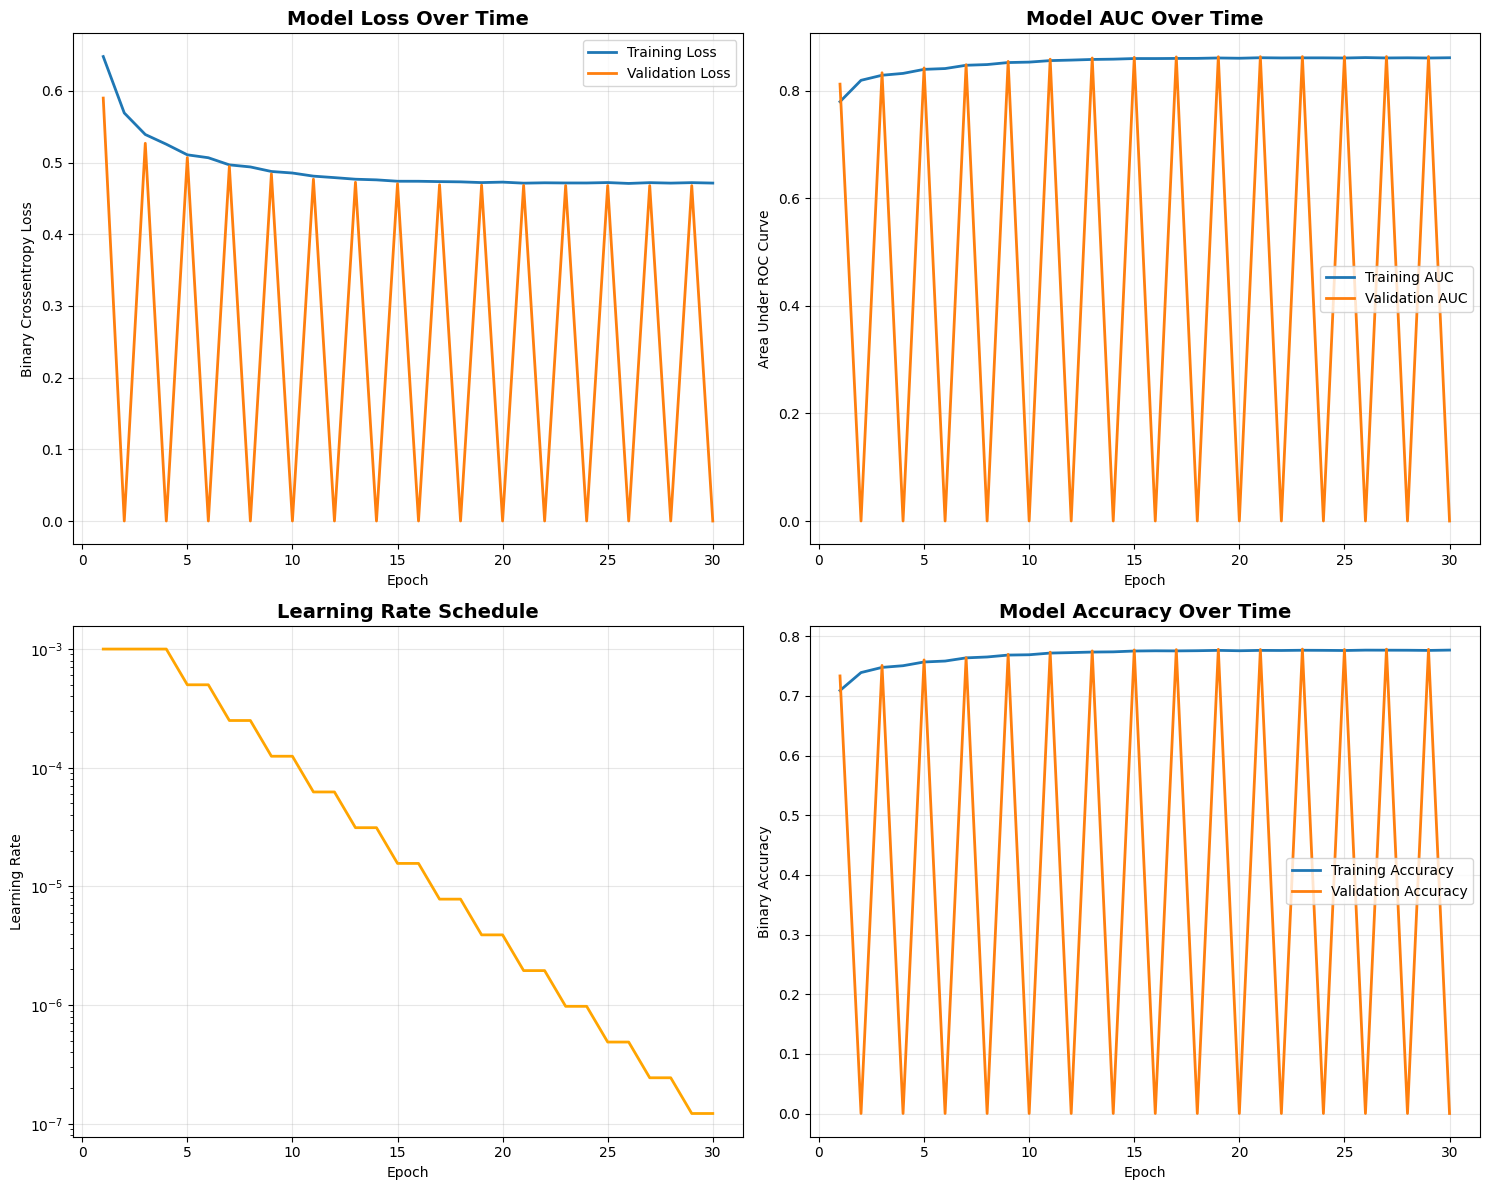

Training visualizations saved to 'training_history.png'


In [13]:
# Create comprehensive training visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and Validation Loss
axes[0, 0].plot(history_df['epoch'], history_df['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Binary Crossentropy Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training and Validation AUC
axes[0, 1].plot(history_df['epoch'], history_df[auc_key], label='Training AUC', linewidth=2)
axes[0, 1].plot(history_df['epoch'], history_df[val_auc_key], label='Validation AUC', linewidth=2)
axes[0, 1].set_title('Model AUC Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Area Under ROC Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
axes[1, 0].plot(history_df['epoch'], history_df[lr_key], linewidth=2, color='orange')
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Training and Validation Accuracy
axes[1, 1].plot(history_df['epoch'], history_df['binary_accuracy'], label='Training Accuracy', linewidth=2)
axes[1, 1].plot(history_df['epoch'], history_df['val_binary_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1, 1].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Binary Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training visualizations saved to 'training_history.png'")


In [14]:
# Model performance analysis
best_epoch = history_df[val_auc_key].idxmax() + 1
best_val_auc = history_df[val_auc_key].max()
best_val_accuracy = history_df.loc[history_df[val_auc_key].idxmax(), 'val_binary_accuracy']
final_lr = history_df[lr_key].iloc[-1]

print("Model Performance Summary")
print("=" * 40)
print(f"Best Validation AUC: {best_val_auc:.4f} (Epoch {best_epoch})")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Total Training Time: {len(history_df)} epochs")
print(f"Final Learning Rate: {final_lr:.2e}")

# Calculate training efficiency
total_samples_processed = len(history_df) * steps_per_epoch * batch_size
print(f"Total Samples Processed: {total_samples_processed:,}")

print("\nKey Insights:")
if best_val_auc > 0.85:
    print("Excellent performance! AUC > 0.85 indicates strong discriminative ability.")
elif best_val_auc > 0.80:
    print("Good performance! AUC > 0.80 shows the model can distinguish signal from background.")
elif best_val_auc > 0.75:
    print("Moderate performance. Consider hyperparameter tuning or feature engineering.")
else:
    print("Poor performance. Model may need architectural changes or more data.")

if len(history_df) < 10:
    print("Training stopped very early. Consider adjusting early stopping patience.")
elif len(history_df) >= 45:
    print("Training used most of the available epochs. Consider increasing max epochs.")


Model Performance Summary
Best Validation AUC: 0.8639 (Epoch 29)
Best Validation Accuracy: 0.7779
Total Training Time: 30 epochs
Final Learning Rate: 1.22e-07
Total Samples Processed: 329,809,920

Key Insights:
Excellent performance! AUC > 0.85 indicates strong discriminative ability.


## Model Architecture Analysis

### Wide & Deep Architecture Benefits:

1. **Wide Component**: The linear model captures feature interactions and provides memorization capabilities for frequent feature combinations.

2. **Deep Component**: The deep neural network learns complex, non-linear feature representations and generalizes to unseen feature combinations.

3. **Combined Strength**: The ensemble of both components balances memorization (wide) and generalization (deep) for optimal performance.

### Key Improvements in This Implementation:

1. **Input Normalization**: Integrated normalization layer ensures consistent feature scaling across all data.

2. **L2 Regularization**: Added to deep layers to prevent overfitting on the large parameter space.

3. **Enhanced Callbacks**: 
   - AUC-based early stopping for better classification performance monitoring
   - Conservative learning rate scheduling for training stability
   - Model checkpointing to save the best-performing model

4. **Modern Keras API**: Built with the functional API for better flexibility and maintainability.

### Physics Context:

The 28 input features represent kinematic properties of particle collision events:
- Lepton properties (energy, momentum, angles)
- Missing transverse energy (indicating neutrinos)
- Jet properties and counts
- Derived kinematic variables

High AUC scores indicate the model successfully learned to distinguish Higgs boson decay signatures from background Standard Model processes.

In [15]:
# Optional: Save final model and training history
try:
    # Save the final model (best weights are restored from checkpoint)
    wide_and_deep.save(os.path.join(OUTPUT_DIR, 'final_higgs_model.keras'))
    print(f"Final model saved to '{os.path.join(OUTPUT_DIR, 'final_higgs_model.keras')}'")
    
    # Save training history
    history_df.to_csv(os.path.join(OUTPUT_DIR, 'training_history.csv'), index=False)
    print(f"Training history saved to '{os.path.join(OUTPUT_DIR, 'training_history.csv')}'")
    
    # Generate and save the model architecture diagram
    tf.keras.utils.plot_model(
        wide_and_deep,
        to_file=os.path.join(OUTPUT_DIR, 'wide_and_deep_model.png'),
        show_shapes=True,
        show_layer_names=True
    )
    print(f"Model architecture diagram saved to '{os.path.join(OUTPUT_DIR, 'wide_and_deep_model.png')}'")
    
    # Save model configuration summary
    config_summary = {
        'model_name': 'Wide & Deep Higgs Classifier',
        'total_parameters': wide_and_deep.count_params(),
        'best_val_auc': float(best_val_auc),
        'best_val_accuracy': float(best_val_accuracy),
        'training_epochs': len(history_df),
        'batch_size': batch_size,
        'learning_rate_initial': 0.001,
        'learning_rate_final': float(final_lr),
        'regularization_l2': 1e-5,
        'dropout_rate': DROPOUT,
        'units_per_layer': UNITS,
        'architecture': 'Wide & Deep with 5 dense layers'
    }
    
    import json
    with open(os.path.join(OUTPUT_DIR, 'model_config.json'), 'w') as f:
        json.dump(config_summary, f, indent=2)
    print(f"Model configuration saved to '{os.path.join(OUTPUT_DIR, 'model_config.json')}'")
    
except Exception as e:
    print(f"Error saving files: {e}")

print(f"\nHiggs Boson Classification Project Complete!")
print(f"\nFiles generated in: {OUTPUT_DIR}")
print("  training_history.png - Training curves visualization")
print("  best_higgs_model.keras - Best model weights (saved during training)")
print("  final_higgs_model.keras - Final model state")
print("  training_history.csv - Complete training metrics")
print("  model_config.json - Model configuration summary")
print("  wide_and_deep_model.png - Model architecture diagram")


Final model saved to '/kaggle/working/final_higgs_model.keras'
Training history saved to '/kaggle/working/training_history.csv'
You must install pydot (`pip install pydot`) for `plot_model` to work.


Model architecture diagram saved to '/kaggle/working/wide_and_deep_model.png'
Model configuration saved to '/kaggle/working/model_config.json'

Higgs Boson Classification Project Complete!

Files generated in: /kaggle/working/
  training_history.png - Training curves visualization
  best_higgs_model.keras - Best model weights (saved during training)
  final_higgs_model.keras - Final model state
  training_history.csv - Complete training metrics
  model_config.json - Model configuration summary
  wide_and_deep_model.png - Model architecture diagram
